# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [1]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

# import local copy of cvxpower
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from cvxpower import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
matplotlib.rc("font", serif='Computer Modern Roman')

graphdir = '../fig/'
figsize=(10,2)

## TODOs

- keep simplifying the code. it must become much easier to read!
- make a cell at the start with ALL the constants/parameters and their units!
- make better plot/comparisons
- test on two separate weeks? or on the whole year...

## Load predictive model 

In [2]:
baseline = pd.read_pickle('wind_baseline.pickle')
autoreg_residual_params = pd.read_pickle('residual_params.pickle')
sigma_residual_errors = pd.read_pickle('sigma_epsilon.pickle')
train = pd.read_pickle('wind_power_train.pickle')
test = pd.read_pickle('wind_power_test.pickle')

## Randomly select an (off-sample) day to test the methods on

2012-09-22 00:00:00


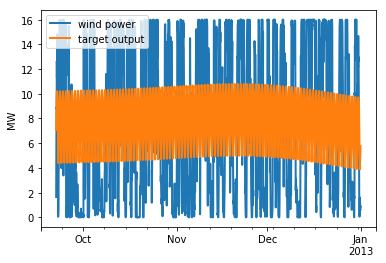

In [4]:
np.random.seed(10)
sample_day = pd.Timestamp(np.random.choice(sorted(set(test.index.date))))
print(sample_day)

target_output = baseline[(baseline.index >= sample_day)]
wind_power_available = test[target_output.index]

wind_power_available.plot(label='wind power')
target_output.plot(label='target output')
plt.ylabel('MW')
plt.legend()

## Prescient DOPF

In [5]:
storage_capacity = 100 # MWh
initial_storage = storage_capacity // 2
battery_charge_max = storage_capacity /10. # a full charge in 10 hours
battery_discharge_max = storage_capacity /10. # a full discharge in 10 hours

gas_power_max = 10  #MW
gas_power_min = 0.01 #MW
gas_alpha = .1
gas_beta = 80.

# analysis horizon
T = 24 * 1 

## print .. (gas_alpha * gas_power_max**2 + gas_beta * gas_power_max)/gas_power_max

### Marginal cost of MWh produced by gas turbine 

Text(0,0.5,'$ / MWh')

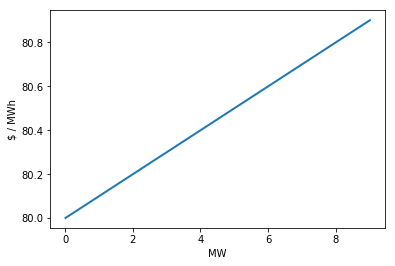

In [6]:
def cost_per_unit(power):
    return (gas_alpha * power**2 + gas_beta * power)/power

x = np.arange(gas_power_min, gas_power_max, gas_power_max/10)
plt.plot(x, cost_per_unit(x))
plt.xlabel('MW')
plt.ylabel('$ / MWh')

In [7]:
def make_network(T, K):
    """Define network and parameters for data."""
    target_output = Parameter((T,K))
    wind_power_available = Parameter((T,K))
    initial_storage = Parameter((1,1))
    final_storage = Parameter((1,1))
    out = FixedLoad(power = target_output, name="Target output")
    wind_gen = Generator(alpha=0, beta=0, power_min=-2, 
                         power_max=wind_power_available, name="Wind generator")
    gas_gen = Generator(alpha=gas_alpha, beta=gas_beta, 
                        power_min=gas_power_min, power_max=gas_power_max, name="Gas generator")
    storage = Storage(discharge_max=battery_discharge_max, charge_max=battery_charge_max, 
                      energy_max=storage_capacity, 
                      energy_init = initial_storage, 
                      energy_final = final_storage)
    net = Net([wind_gen.terminals[0],
               gas_gen.terminals[0],
               storage.terminals[0],
               out.terminals[0]])
    dopf_network = Group([wind_gen, gas_gen, storage, out], [net])
    dopf_network.init_problem(time_horizon=T, num_scenarios = K)
    return target_output, wind_power_available, initial_storage, final_storage, dopf_network

In [8]:
target_output_par, wind_power_available_par, initial_storage_par, final_storage_par, dopf_network = \
    make_network(T, 1)
    
target_output_par.value = np.matrix(target_output[:T]).T
wind_power_available_par.value = np.matrix(wind_power_available[:T]).T
initial_storage_par.value = np.matrix(initial_storage)
final_storage_par.value = np.matrix(initial_storage)

cost_dopf = dopf_network.problem.solve(solver='ECOS', verbose=True)
#print(cost_dopf)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.135e+03  -4.623e+04  +7e+04  8e-02  7e-02  1e+00  3e+02    ---    ---    1  1  - |  -  - 
 1  +4.122e+03  -3.185e+04  +4e+04  5e-02  4e-02  5e+01  2e+02  0.5563  3e-01   2  2  2 |  0  0
 2  +7.279e+02  -1.267e+04  +2e+04  2e-02  2e-02  8e+01  6e+01  0.9890  4e-01   2  2  1 |  0  0
 3  +7.045e+02  -6.221e+03  +8e+03  9e-03  8e-03  5e+01  3e+01  0.7864  4e-01   2  1  2 |  0  0
 4  +1.199e+02  -1.116e+03  +1e+03  1e-03  2e-03  8e+00  6e+00  0.9890  2e-01   1  1  1 |  0  0
 5  +1.821e+01  -1.337e+02  +2e+02  2e-04  3e-04  9e-01  8e-01  0.8865  2e-02   1  1  1 |  0  0
 6  +1.942e+01  +1.729e+01  +3e+00  2e-06  4e-06  1e-02  1e-02  0.9880  2e-03   1  1  1 |  0  0
 7  +1.920e+01  +1.918e+01  +3e-02  2e-08  4e-08  1e-04  1e-04  0.9890  1e-04   1  1  1 |  0  0
 8  +1.920e+01  +1.920e+01  +3e-04  3e-10  5e-

In [9]:
print(cost_dopf)

19.20024000037401


In [10]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

total_output = sum(target_output[:T])/len(target_output[:T])
total_wind_power_avail = sum(wind_power_available[:T])/len(target_output[:T])
total_gas_gen = -sum(dopf_network.results.power[(gas_gen,0)])[0]/len(target_output[:T])

print('(Values are per period.)')
print('Power sold:\t%.2f MWh\nWind avail.:\t%.2f MWh\nGas gen.:\t%.2f MWh\nPower lost:\t%.2f MWh' % (
    total_output,
    total_wind_power_avail,
    total_gas_gen,
    (total_wind_power_avail + total_gas_gen) - total_output
))

(Values are per period.)
Power sold:	7.61 MWh
Wind avail.:	7.74 MWh
Gas gen.:	0.01 MWh
Power lost:	0.14 MWh


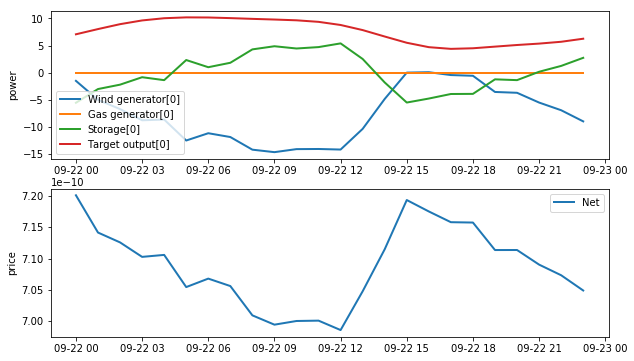

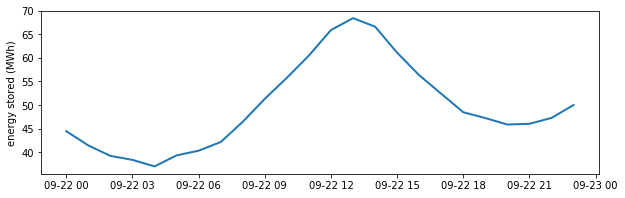

In [11]:
# plot the results
dopf_network.results.plot(figsize=(10,6), 
                          index=target_output[:T].index)
#plt.ylabel('M')
plt.savefig(graphdir+'wind_dopf_results.pdf')

# plot energy stored in battery
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plt.figure(figsize=(10,3))
plt.plot(target_output[:T].index, storage.energy.value)
plt.ylabel("energy stored (MWh)")
plt.savefig(graphdir+'wind_dopf_energy.pdf')

power_dopf = dopf_network.results.power.items()

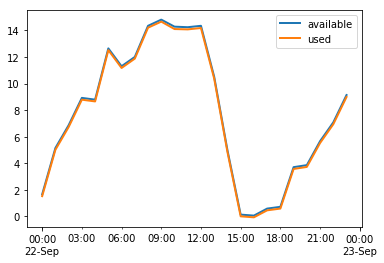

In [12]:
wind_power_available[:T].plot(label='available')
pd.Series(data=-dopf_network.results.power[(wind_gen, 0)].flatten(), 
          index = wind_power_available.index[:T]).plot(label='used')
plt.legend()

## Prescient MPC 

#### Problem logic 

In [13]:
# T = 24 # one day
# out_MPC = FixedLoad(power=Parameter((T+1,1)), name="Fixed load")
# wind_gen_MPC = Generator(alpha=0, beta=0, power_min=0, power_max=Parameter((T+1,1)), name="Wind")
# gas_gen = Generator(alpha=0.02, beta=1, power_min=0.01, power_max=10, name="Gas")
# storage = Storage(discharge_max=10, charge_max=10, energy_max=storage_capacity, 
#                   energy_init=Parameter((1,1), value=[[initial_storage]]),
#                  energy_final = initial_storage)
# net = Net([wind_gen_MPC.terminals[0], 
#            gas_gen.terminals[0],
#            storage.terminals[0], 
#            out_MPC.terminals[0]])
# mpc_network = Group([wind_gen_MPC, gas_gen, storage, out_MPC], [net])
# mpc_network.init_problem(time_horizon=T+1)

In [14]:
T_MPC = 24

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(wind_power_available[t:t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 24/24 [00:00<00:00, 24.56it/s]


In [15]:
#-sum(prescient_MPC_results.power[(gas_gen,0)])

In [16]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

total_output = sum(target_output[:T])/len(target_output[:T])
total_wind_power_avail = sum(wind_power_available[:T])/len(target_output[:T])
total_gas_gen = -sum(prescient_MPC_results.power[(gas_gen,0)])/len(target_output[:T])

print('(Values are per period.)')
print('Power sold:\t%.2f MWh\nWind avail.:\t%.2f MWh\nGas gen.:\t%.2f MWh\nPower lost:\t%.2f MWh' % (
    total_output,
    total_wind_power_avail,
    total_gas_gen,
    (total_wind_power_avail + total_gas_gen) - total_output
))

(Values are per period.)
Power sold:	7.61 MWh
Wind avail.:	7.74 MWh
Gas gen.:	0.01 MWh
Power lost:	0.14 MWh


In [17]:
cost_prescient_MPC

19.200239999041386

In [18]:
def plot(results, target_output, energy_stored, methodname):
    ax = prescient_MPC_results.plot(figsize=(10,6), 
                              index=target_output.index)
    ax[0].set_ylabel('MW')
    ax[1].set_ylabel('$ / MWh')
    plt.savefig(graphdir+'wind_%s_results.pdf'%methodname)
    plt.figure(figsize=(10,3))
    plt.plot(target_output.index, energy_stored)
    plt.ylabel("MWh")
    plt.savefig(graphdir+'wind_%s_energy.pdf'%methodname)

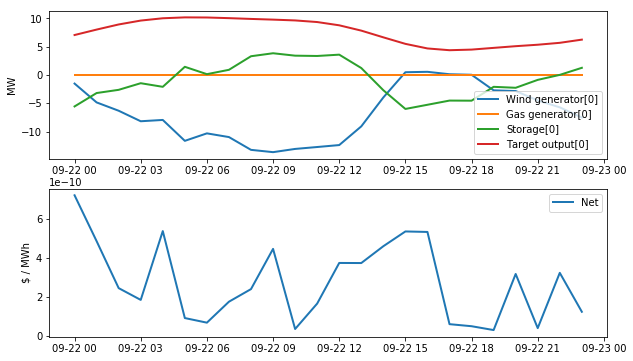

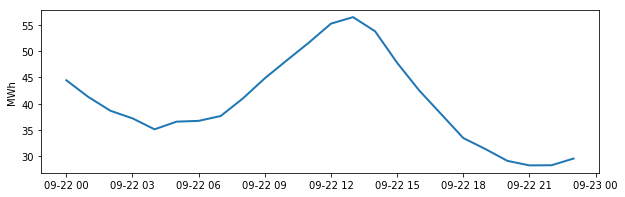

In [19]:
plot(prescient_MPC_results, target_output[:T], energy_stored, 'presc_mpc')

In [ ]:
wind_power_available[:T].plot(label='available')
pd.Series(data=-dopf_network.results.power[(wind_gen, 0)].flatten(), 
          index = wind_power_available.index[:T]).plot(label='used')
plt.legend()

In [42]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

total_output = sum(target_output)/len(target_output)
total_wind_power_avail = sum(wind_power_available)/len(target_output)
total_gas_gen = -sum(dopf_network.results.power[(gas_gen,0)])[0]/len(target_output)

print('(Values are per period.)')
print('Power sold:\t%.2f MWh\nWind avail.:\t%.2f MWh\nGas gen.:\t%.2f MWh\nPower lost:\t%.2f MWh' % (
    total_output,
    total_wind_power_avail,
    total_gas_gen,
    (total_wind_power_avail + total_gas_gen) - total_output
))

(Values are per period.)
Power sold:	7.85 MWh
Wind avail.:	7.94 MWh
Gas gen.:	0.06 MWh
Power lost:	0.14 MWh


KeyError: (<cvxpower.devices.Generator object at 0x11230cfd0>, 0)

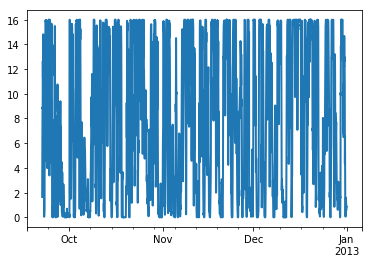

In [44]:
wind_power_available.plot(label='available')
pd.Series(data=-prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
          index = wind_power_available.index[:-25]
         ).plot(label='used')
plt.legend()

## MPC with baseline and residual AR

### Diagnostic 

In [11]:
# t = 288*7+1000

# past = p_wind[t-T:t]
# future = p_wind[t:t+T]

# past_baseline = baseline[t-T:t]
# fut_baseline = baseline[t:t+T]


# #pred = (np.matrix((p_wind[t-T:t] - baseline[t-T:t])) @ autoreg_residual_params).T

# past.plot()
# future.plot()

# past_baseline.plot()
# fut_baseline.plot()

# plt.figure()

# (past-  past_baseline).plot()
# (future-  fut_baseline).plot()

# pred = predict_wind(t)

# pred.plot(style='--')

# plt.figure()
# past.plot()
# future.plot()
# (pred+fut_baseline).plot()

#### run MPC 

In [12]:
T = 288 # one day
out = FixedLoad(power=Parameter((T+1,1)), name="Fixed load")
wind_gen = Generator(alpha=0, beta=0, power_min=-100, power_max=Parameter((T+1,1)), name="Wind")
gas_gen = Generator(alpha=0.02, beta=1, power_min=0.01, power_max=100, name="Gas")
storage = Storage(discharge_max=1, charge_max=1, energy_max=12*4, energy_init=Parameter((1,1), value=[[6*4]]))
net = Net([wind_gen.terminals[0], 
           gas_gen.terminals[0],
           storage.terminals[0], 
           out.terminals[0]])
mpc_network = Group([wind_gen, gas_gen, storage, out], [net])
mpc_network.init_problem(time_horizon=T+1)

def predict_wind(t, T = 288):
    past = p_wind[t-T:t]
    past_baseline = baseline[t-T:t]
    fut_baseline = baseline[t:t+T]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    return pred + fut_baseline

initial_time = 288*3

def make_forecasts(t):
    t_used = t + initial_time
    out.power.value = np.matrix(baseline[t_used:t_used+T+1].as_matrix()/16).T
    wind_gen.power_max.value = np.matrix(np.hstack((p_wind[t_used], predict_wind(t_used+1)))/16).T

def implement(t):
    energy_stored[t] = storage.energy.value[0]
    storage.energy_init.value = np.matrix(storage.energy.value[0])

N = 288*7  # one week
energy_stored = np.empty(N)
AR_MPC_cost, AR_MPC_results = run_mpc(mpc_network, N, make_forecasts, implement, verbose = False, solver='ECOS')

  0%|          | 1/2016 [00:00<17:40,  1.90it/s]

at time 0, adding cost 0.097790


  0%|          | 2/2016 [00:01<17:50,  1.88it/s]

at time 1, adding cost 0.100614


  0%|          | 3/2016 [00:01<17:37,  1.90it/s]

at time 2, adding cost 0.104735


  0%|          | 4/2016 [00:02<17:18,  1.94it/s]

at time 3, adding cost 0.110349


  0%|          | 5/2016 [00:02<17:04,  1.96it/s]

at time 4, adding cost 0.115820


  0%|          | 6/2016 [00:03<17:01,  1.97it/s]

at time 5, adding cost 0.121433


  0%|          | 7/2016 [00:03<16:56,  1.98it/s]

at time 6, adding cost 0.126199


  0%|          | 8/2016 [00:04<16:43,  2.00it/s]

at time 7, adding cost 0.129085


  0%|          | 9/2016 [00:04<16:43,  2.00it/s]

at time 8, adding cost 0.130715


  0%|          | 10/2016 [00:05<16:29,  2.03it/s]

at time 9, adding cost 0.132671


  1%|          | 11/2016 [00:05<16:33,  2.02it/s]

at time 10, adding cost 0.135001


  1%|          | 12/2016 [00:06<16:23,  2.04it/s]

at time 11, adding cost 0.138332


  1%|          | 13/2016 [00:06<16:27,  2.03it/s]

at time 12, adding cost 0.142497


  1%|          | 14/2016 [00:07<16:57,  1.97it/s]

at time 13, adding cost 0.145644


  1%|          | 15/2016 [00:07<16:38,  2.00it/s]

at time 14, adding cost 0.147451


  1%|          | 17/2016 [00:08<16:36,  2.01it/s]

at time 15, adding cost 0.147057
at time 16, adding cost 0.148552


  1%|          | 18/2016 [00:09<16:27,  2.02it/s]

at time 17, adding cost 0.149610


  1%|          | 19/2016 [00:09<17:19,  1.92it/s]

at time 18, adding cost 0.151557


  1%|          | 20/2016 [00:10<19:27,  1.71it/s]

at time 19, adding cost 0.150730


  1%|          | 21/2016 [00:11<20:20,  1.63it/s]

at time 20, adding cost 0.150308


  1%|          | 23/2016 [00:12<21:06,  1.57it/s]

at time 21, adding cost 0.151519
at time 22, adding cost 0.152745


  1%|          | 24/2016 [00:12<20:38,  1.61it/s]

at time 23, adding cost 0.156440


  1%|          | 25/2016 [00:13<19:56,  1.66it/s]

at time 24, adding cost 0.161891


  1%|▏         | 26/2016 [00:13<18:49,  1.76it/s]

at time 25, adding cost 0.166779


  1%|▏         | 27/2016 [00:14<20:02,  1.65it/s]

at time 26, adding cost 0.170801


  1%|▏         | 29/2016 [00:15<19:01,  1.74it/s]

at time 27, adding cost 0.175498
at time 28, adding cost 0.181224


  1%|▏         | 30/2016 [00:16<19:47,  1.67it/s]

at time 29, adding cost 0.185679


  2%|▏         | 31/2016 [00:16<19:23,  1.71it/s]

at time 30, adding cost 0.189372


  2%|▏         | 32/2016 [00:17<18:54,  1.75it/s]

at time 31, adding cost 0.192877


  2%|▏         | 33/2016 [00:17<17:53,  1.85it/s]

at time 32, adding cost 0.197083


  2%|▏         | 34/2016 [00:18<17:36,  1.88it/s]

at time 33, adding cost 0.201605


  2%|▏         | 35/2016 [00:18<16:58,  1.94it/s]

at time 34, adding cost 0.206710


  2%|▏         | 36/2016 [00:19<16:42,  1.98it/s]

at time 35, adding cost 0.214392


  2%|▏         | 37/2016 [00:19<16:32,  1.99it/s]

at time 36, adding cost 0.221270


  2%|▏         | 38/2016 [00:20<16:13,  2.03it/s]

at time 37, adding cost 0.227927


  2%|▏         | 39/2016 [00:20<16:02,  2.05it/s]

at time 38, adding cost 0.234011


  2%|▏         | 40/2016 [00:21<15:54,  2.07it/s]

at time 39, adding cost 0.238936


  2%|▏         | 41/2016 [00:21<16:24,  2.01it/s]

at time 40, adding cost 0.246268


  2%|▏         | 42/2016 [00:22<16:10,  2.03it/s]

at time 41, adding cost 0.253152


  2%|▏         | 43/2016 [00:22<16:02,  2.05it/s]

at time 42, adding cost 0.259301


  2%|▏         | 44/2016 [00:23<16:01,  2.05it/s]

at time 43, adding cost 0.265340


  2%|▏         | 45/2016 [00:23<15:53,  2.07it/s]

at time 44, adding cost 0.272321


  2%|▏         | 46/2016 [00:24<15:56,  2.06it/s]

at time 45, adding cost 0.278526


  2%|▏         | 47/2016 [00:24<16:12,  2.03it/s]

at time 46, adding cost 0.283245


  2%|▏         | 48/2016 [00:25<15:59,  2.05it/s]

at time 47, adding cost 0.287630


  2%|▏         | 49/2016 [00:25<16:01,  2.04it/s]

at time 48, adding cost 0.287931


  2%|▏         | 50/2016 [00:26<16:05,  2.04it/s]

at time 49, adding cost 0.290572


  3%|▎         | 51/2016 [00:26<15:55,  2.06it/s]

at time 50, adding cost 0.293445


  3%|▎         | 52/2016 [00:27<15:58,  2.05it/s]

at time 51, adding cost 0.290392


  3%|▎         | 53/2016 [00:27<15:52,  2.06it/s]

at time 52, adding cost 0.287349


  3%|▎         | 54/2016 [00:28<15:40,  2.09it/s]

at time 53, adding cost 0.287724


  3%|▎         | 55/2016 [00:28<15:50,  2.06it/s]

at time 54, adding cost 0.292652


  3%|▎         | 56/2016 [00:29<15:43,  2.08it/s]

at time 55, adding cost 0.299056


  3%|▎         | 58/2016 [00:30<15:56,  2.05it/s]

at time 56, adding cost 0.305098
at time 57, adding cost 0.310677


  3%|▎         | 59/2016 [00:30<15:41,  2.08it/s]

at time 58, adding cost 0.315994


  3%|▎         | 60/2016 [00:31<15:39,  2.08it/s]

at time 59, adding cost 0.322100


  3%|▎         | 61/2016 [00:31<15:50,  2.06it/s]

at time 60, adding cost 0.327159


  3%|▎         | 62/2016 [00:32<15:44,  2.07it/s]

at time 61, adding cost 0.332589


  3%|▎         | 63/2016 [00:32<15:41,  2.07it/s]

at time 62, adding cost 0.338359


  3%|▎         | 65/2016 [00:33<15:53,  2.05it/s]

at time 63, adding cost 0.344264
at time 64, adding cost 0.348769


  3%|▎         | 66/2016 [00:33<15:43,  2.07it/s]

at time 65, adding cost 0.353345


  3%|▎         | 67/2016 [00:34<16:23,  1.98it/s]

at time 66, adding cost 0.357857


  3%|▎         | 68/2016 [00:35<16:23,  1.98it/s]

at time 67, adding cost 0.362422


  3%|▎         | 69/2016 [00:35<16:08,  2.01it/s]

at time 68, adding cost 0.366635


  3%|▎         | 70/2016 [00:36<16:17,  1.99it/s]

at time 69, adding cost 0.370559


  4%|▎         | 71/2016 [00:36<16:12,  2.00it/s]

at time 70, adding cost 0.374142


  4%|▎         | 72/2016 [00:37<16:21,  1.98it/s]

at time 71, adding cost 0.377302


  4%|▎         | 73/2016 [00:37<16:04,  2.01it/s]

at time 72, adding cost 0.381622


  4%|▎         | 74/2016 [00:37<15:54,  2.04it/s]

at time 73, adding cost 0.385088


  4%|▎         | 75/2016 [00:38<15:49,  2.04it/s]

at time 74, adding cost 0.389135


  4%|▍         | 76/2016 [00:38<15:34,  2.08it/s]

at time 75, adding cost 0.393165


  4%|▍         | 78/2016 [00:39<15:42,  2.06it/s]

at time 76, adding cost 0.397810
at time 77, adding cost 0.402732


  4%|▍         | 79/2016 [00:40<15:38,  2.06it/s]

at time 78, adding cost 0.407723


  4%|▍         | 80/2016 [00:40<15:39,  2.06it/s]

at time 79, adding cost 0.412854


  4%|▍         | 81/2016 [00:41<15:48,  2.04it/s]

at time 80, adding cost 0.417849


  4%|▍         | 82/2016 [00:41<15:49,  2.04it/s]

at time 81, adding cost 0.422612


  4%|▍         | 83/2016 [00:42<15:49,  2.04it/s]

at time 82, adding cost 0.427553


  4%|▍         | 84/2016 [00:42<15:46,  2.04it/s]

at time 83, adding cost 0.432521


  4%|▍         | 85/2016 [00:43<15:54,  2.02it/s]

at time 84, adding cost 0.437592


  4%|▍         | 86/2016 [00:43<15:51,  2.03it/s]

at time 85, adding cost 0.442625


  4%|▍         | 87/2016 [00:44<15:54,  2.02it/s]

at time 86, adding cost 0.447698


  4%|▍         | 88/2016 [00:44<16:02,  2.00it/s]

at time 87, adding cost 0.452773


  4%|▍         | 89/2016 [00:45<15:59,  2.01it/s]

at time 88, adding cost 0.458093


  4%|▍         | 90/2016 [00:45<15:49,  2.03it/s]

at time 89, adding cost 0.463030


  5%|▍         | 91/2016 [00:46<15:48,  2.03it/s]

at time 90, adding cost 0.467809


  5%|▍         | 92/2016 [00:46<15:58,  2.01it/s]

at time 91, adding cost 0.472687


  5%|▍         | 93/2016 [00:47<15:56,  2.01it/s]

at time 92, adding cost 0.477836


  5%|▍         | 94/2016 [00:47<16:25,  1.95it/s]

at time 93, adding cost 0.483100


  5%|▍         | 95/2016 [00:48<16:30,  1.94it/s]

at time 94, adding cost 0.488424


  5%|▍         | 96/2016 [00:48<16:16,  1.97it/s]

at time 95, adding cost 0.493718


  5%|▍         | 97/2016 [00:49<16:11,  1.97it/s]

at time 96, adding cost 0.499393


  5%|▍         | 99/2016 [00:50<16:17,  1.96it/s]

at time 97, adding cost 0.505098
at time 98, adding cost 0.511001


  5%|▍         | 100/2016 [00:50<15:46,  2.02it/s]

at time 99, adding cost 0.516580


  5%|▌         | 101/2016 [00:51<16:02,  1.99it/s]

at time 100, adding cost 0.522699


  5%|▌         | 102/2016 [00:51<16:08,  1.98it/s]

at time 101, adding cost 0.528476


  5%|▌         | 103/2016 [00:52<16:13,  1.96it/s]

at time 102, adding cost 0.534306


  5%|▌         | 104/2016 [00:52<16:19,  1.95it/s]

at time 103, adding cost 0.540118


  5%|▌         | 105/2016 [00:53<16:22,  1.95it/s]

at time 104, adding cost 0.545551


  5%|▌         | 106/2016 [00:53<16:13,  1.96it/s]

at time 105, adding cost 0.551115


  5%|▌         | 107/2016 [00:54<16:06,  1.97it/s]

at time 106, adding cost 0.557118


  5%|▌         | 108/2016 [00:54<16:08,  1.97it/s]

at time 107, adding cost 0.562519


  5%|▌         | 109/2016 [00:55<16:06,  1.97it/s]

at time 108, adding cost 0.567671


  5%|▌         | 110/2016 [00:55<15:57,  1.99it/s]

at time 109, adding cost 0.572535


  6%|▌         | 111/2016 [00:56<16:00,  1.98it/s]

at time 110, adding cost 0.576716


  6%|▌         | 112/2016 [00:57<16:03,  1.98it/s]

at time 111, adding cost 0.578749


  6%|▌         | 113/2016 [00:57<15:54,  1.99it/s]

at time 112, adding cost 0.577981


  6%|▌         | 114/2016 [00:58<15:56,  1.99it/s]

at time 113, adding cost 0.577186


  6%|▌         | 115/2016 [00:58<15:50,  2.00it/s]

at time 114, adding cost 0.576359


  6%|▌         | 116/2016 [00:58<15:41,  2.02it/s]

at time 115, adding cost 0.575496


  6%|▌         | 117/2016 [00:59<15:36,  2.03it/s]

at time 116, adding cost 0.574593


  6%|▌         | 118/2016 [00:59<15:25,  2.05it/s]

at time 117, adding cost 0.573646


  6%|▌         | 119/2016 [01:00<15:19,  2.06it/s]

at time 118, adding cost 0.572650


  6%|▌         | 120/2016 [01:00<15:15,  2.07it/s]

at time 119, adding cost 0.571599


  6%|▌         | 121/2016 [01:01<15:35,  2.02it/s]

at time 120, adding cost 0.570489


  6%|▌         | 122/2016 [01:01<15:24,  2.05it/s]

at time 121, adding cost 0.569315


  6%|▌         | 123/2016 [01:02<15:12,  2.07it/s]

at time 122, adding cost 0.568072


  6%|▌         | 124/2016 [01:02<15:08,  2.08it/s]

at time 123, adding cost 0.566753


  6%|▌         | 125/2016 [01:03<15:04,  2.09it/s]

at time 124, adding cost 0.565355


  6%|▋         | 126/2016 [01:03<15:05,  2.09it/s]

at time 125, adding cost 0.563871


  6%|▋         | 127/2016 [01:04<15:04,  2.09it/s]

at time 126, adding cost 0.562295


  6%|▋         | 128/2016 [01:04<15:10,  2.07it/s]

at time 127, adding cost 0.560623


  6%|▋         | 129/2016 [01:05<15:09,  2.08it/s]

at time 128, adding cost 0.558848


  6%|▋         | 130/2016 [01:05<14:53,  2.11it/s]

at time 129, adding cost 0.556967


  6%|▋         | 131/2016 [01:06<14:48,  2.12it/s]

at time 130, adding cost 0.554973


  7%|▋         | 132/2016 [01:06<14:31,  2.16it/s]

at time 131, adding cost 0.552861


  7%|▋         | 133/2016 [01:07<14:24,  2.18it/s]

at time 132, adding cost 0.550626


  7%|▋         | 134/2016 [01:07<14:33,  2.15it/s]

at time 133, adding cost 0.548264


  7%|▋         | 135/2016 [01:08<14:36,  2.15it/s]

at time 134, adding cost 0.545770


  7%|▋         | 136/2016 [01:08<14:33,  2.15it/s]

at time 135, adding cost 0.543139


  7%|▋         | 137/2016 [01:08<14:19,  2.19it/s]

at time 136, adding cost 0.540369


  7%|▋         | 138/2016 [01:09<14:25,  2.17it/s]

at time 137, adding cost 0.537455


  7%|▋         | 139/2016 [01:09<14:24,  2.17it/s]

at time 138, adding cost 0.534393


  7%|▋         | 140/2016 [01:10<14:28,  2.16it/s]

at time 139, adding cost 0.531182


  7%|▋         | 141/2016 [01:10<14:19,  2.18it/s]

at time 140, adding cost 0.527819


  7%|▋         | 142/2016 [01:11<14:26,  2.16it/s]

at time 141, adding cost 0.524301


  7%|▋         | 143/2016 [01:11<14:12,  2.20it/s]

at time 142, adding cost 0.520627


  7%|▋         | 144/2016 [01:12<14:22,  2.17it/s]

at time 143, adding cost 0.516797


  7%|▋         | 145/2016 [01:12<14:02,  2.22it/s]

at time 144, adding cost 0.512809


  7%|▋         | 147/2016 [01:13<14:42,  2.12it/s]

at time 145, adding cost 0.508664
at time 146, adding cost 0.504362


  7%|▋         | 148/2016 [01:13<14:20,  2.17it/s]

at time 147, adding cost 0.499905


  7%|▋         | 149/2016 [01:14<14:15,  2.18it/s]

at time 148, adding cost 0.495294


  7%|▋         | 150/2016 [01:14<14:24,  2.16it/s]

at time 149, adding cost 0.490531


  7%|▋         | 151/2016 [01:15<14:10,  2.19it/s]

at time 150, adding cost 0.485621


  8%|▊         | 152/2016 [01:15<13:57,  2.23it/s]

at time 151, adding cost 0.480565


  8%|▊         | 153/2016 [01:16<13:48,  2.25it/s]

at time 152, adding cost 0.475370


  8%|▊         | 155/2016 [01:17<13:36,  2.28it/s]

at time 153, adding cost 0.470038
at time 154, adding cost 0.464577


  8%|▊         | 156/2016 [01:17<13:38,  2.27it/s]

at time 155, adding cost 0.458992


  8%|▊         | 158/2016 [01:18<13:38,  2.27it/s]

at time 156, adding cost 0.453289
at time 157, adding cost 0.447476


  8%|▊         | 159/2016 [01:18<13:46,  2.25it/s]

at time 158, adding cost 0.441561


  8%|▊         | 160/2016 [01:19<13:51,  2.23it/s]

at time 159, adding cost 0.435553


  8%|▊         | 161/2016 [01:19<13:55,  2.22it/s]

at time 160, adding cost 0.429459


  8%|▊         | 163/2016 [01:20<14:02,  2.20it/s]

at time 161, adding cost 0.423290
at time 162, adding cost 0.417055


  8%|▊         | 164/2016 [01:21<13:50,  2.23it/s]

at time 163, adding cost 0.410765


  8%|▊         | 166/2016 [01:22<13:45,  2.24it/s]

at time 164, adding cost 0.404429
at time 165, adding cost 0.397997


  8%|▊         | 167/2016 [01:22<13:42,  2.25it/s]

at time 166, adding cost 0.391034


  8%|▊         | 168/2016 [01:22<13:35,  2.27it/s]

at time 167, adding cost 0.384061


  8%|▊         | 169/2016 [01:23<13:42,  2.24it/s]

at time 168, adding cost 0.377088


  8%|▊         | 170/2016 [01:23<13:51,  2.22it/s]

at time 169, adding cost 0.370192


  8%|▊         | 171/2016 [01:24<13:41,  2.25it/s]

at time 170, adding cost 0.363449


  9%|▊         | 172/2016 [01:24<13:32,  2.27it/s]

at time 171, adding cost 0.356679


  9%|▊         | 174/2016 [01:25<14:10,  2.17it/s]

at time 172, adding cost 0.350022
at time 173, adding cost 0.343490


  9%|▊         | 175/2016 [01:26<13:54,  2.21it/s]

at time 174, adding cost 0.337222


  9%|▊         | 176/2016 [01:26<13:55,  2.20it/s]

at time 175, adding cost 0.331166


  9%|▉         | 177/2016 [01:26<13:56,  2.20it/s]

at time 176, adding cost 0.325207


  9%|▉         | 178/2016 [01:27<13:55,  2.20it/s]

at time 177, adding cost 0.319230


  9%|▉         | 179/2016 [01:27<13:45,  2.23it/s]

at time 178, adding cost 0.313310


  9%|▉         | 180/2016 [01:28<13:40,  2.24it/s]

at time 179, adding cost 0.307458


  9%|▉         | 181/2016 [01:28<13:28,  2.27it/s]

at time 180, adding cost 0.301748


  9%|▉         | 182/2016 [01:29<13:33,  2.25it/s]

at time 181, adding cost 0.296189


  9%|▉         | 183/2016 [01:29<13:44,  2.22it/s]

at time 182, adding cost 0.290603


  9%|▉         | 184/2016 [01:30<13:41,  2.23it/s]

at time 183, adding cost 0.284112


  9%|▉         | 185/2016 [01:30<13:52,  2.20it/s]

at time 184, adding cost 0.278180


  9%|▉         | 186/2016 [01:30<13:40,  2.23it/s]

at time 185, adding cost 0.272688


  9%|▉         | 188/2016 [01:31<13:53,  2.19it/s]

at time 186, adding cost 0.268527
at time 187, adding cost 0.268042


  9%|▉         | 189/2016 [01:32<13:45,  2.21it/s]

at time 188, adding cost 0.264794


  9%|▉         | 190/2016 [01:32<13:43,  2.22it/s]

at time 189, adding cost 0.261506


  9%|▉         | 191/2016 [01:33<13:50,  2.20it/s]

at time 190, adding cost 0.258624


 10%|▉         | 192/2016 [01:33<14:36,  2.08it/s]

at time 191, adding cost 0.255520


 10%|▉         | 193/2016 [01:34<14:50,  2.05it/s]

at time 192, adding cost 0.252198


 10%|▉         | 194/2016 [01:34<14:59,  2.02it/s]

at time 193, adding cost 0.248913


 10%|▉         | 195/2016 [01:35<14:58,  2.03it/s]

at time 194, adding cost 0.245918


 10%|▉         | 196/2016 [01:35<14:39,  2.07it/s]

at time 195, adding cost 0.243151


 10%|▉         | 198/2016 [01:36<14:03,  2.15it/s]

at time 196, adding cost 0.240550
at time 197, adding cost 0.238302


 10%|▉         | 199/2016 [01:37<13:59,  2.16it/s]

at time 198, adding cost 0.236279


 10%|▉         | 200/2016 [01:37<14:12,  2.13it/s]

at time 199, adding cost 0.234417


 10%|▉         | 201/2016 [01:38<13:57,  2.17it/s]

at time 200, adding cost 0.230819


 10%|█         | 202/2016 [01:38<13:55,  2.17it/s]

at time 201, adding cost 0.227501


 10%|█         | 203/2016 [01:38<13:45,  2.20it/s]

at time 202, adding cost 0.224900


 10%|█         | 204/2016 [01:39<13:46,  2.19it/s]

at time 203, adding cost 0.222694


 10%|█         | 205/2016 [01:39<13:54,  2.17it/s]

at time 204, adding cost 0.221320


 10%|█         | 206/2016 [01:40<13:45,  2.19it/s]

at time 205, adding cost 0.220959


 10%|█         | 207/2016 [01:40<13:49,  2.18it/s]

at time 206, adding cost 0.221165


 10%|█         | 208/2016 [01:41<13:36,  2.21it/s]

at time 207, adding cost 0.221802


 10%|█         | 209/2016 [01:41<13:34,  2.22it/s]

at time 208, adding cost 0.223117


 10%|█         | 210/2016 [01:42<13:38,  2.21it/s]

at time 209, adding cost 0.224973


 10%|█         | 211/2016 [01:42<13:36,  2.21it/s]

at time 210, adding cost 0.227237


 11%|█         | 212/2016 [01:43<13:37,  2.21it/s]

at time 211, adding cost 0.229584


 11%|█         | 213/2016 [01:43<13:38,  2.20it/s]

at time 212, adding cost 0.231815


 11%|█         | 214/2016 [01:43<13:44,  2.19it/s]

at time 213, adding cost 0.233228


 11%|█         | 215/2016 [01:44<13:37,  2.20it/s]

at time 214, adding cost 0.234381


 11%|█         | 216/2016 [01:44<13:41,  2.19it/s]

at time 215, adding cost 0.235578


 11%|█         | 217/2016 [01:45<13:39,  2.20it/s]

at time 216, adding cost 0.237000


 11%|█         | 218/2016 [01:45<13:41,  2.19it/s]

at time 217, adding cost 0.238447


 11%|█         | 219/2016 [01:46<13:41,  2.19it/s]

at time 218, adding cost 0.239910


 11%|█         | 220/2016 [01:46<13:37,  2.20it/s]

at time 219, adding cost 0.241442


 11%|█         | 221/2016 [01:47<13:29,  2.22it/s]

at time 220, adding cost 0.242844


 11%|█         | 223/2016 [01:48<13:30,  2.21it/s]

at time 221, adding cost 0.243350
at time 222, adding cost 0.243141


 11%|█         | 224/2016 [01:48<13:32,  2.21it/s]

at time 223, adding cost 0.242963


 11%|█         | 225/2016 [01:48<13:20,  2.24it/s]

at time 224, adding cost 0.244326


 11%|█         | 226/2016 [01:49<13:41,  2.18it/s]

at time 225, adding cost 0.247477


 11%|█▏        | 227/2016 [01:49<14:39,  2.03it/s]

at time 226, adding cost 0.251792


 11%|█▏        | 228/2016 [01:50<14:32,  2.05it/s]

at time 227, adding cost 0.255077


 11%|█▏        | 229/2016 [01:50<14:07,  2.11it/s]

at time 228, adding cost 0.257319


 11%|█▏        | 230/2016 [01:51<13:56,  2.14it/s]

at time 229, adding cost 0.259453


 11%|█▏        | 231/2016 [01:51<13:59,  2.13it/s]

at time 230, adding cost 0.261509


 12%|█▏        | 232/2016 [01:52<13:54,  2.14it/s]

at time 231, adding cost 0.263546


 12%|█▏        | 233/2016 [01:52<13:47,  2.16it/s]

at time 232, adding cost 0.265559


 12%|█▏        | 234/2016 [01:53<13:45,  2.16it/s]

at time 233, adding cost 0.267481


 12%|█▏        | 235/2016 [01:53<13:32,  2.19it/s]

at time 234, adding cost 0.269436


 12%|█▏        | 236/2016 [01:54<13:31,  2.19it/s]

at time 235, adding cost 0.271295


 12%|█▏        | 238/2016 [01:55<13:29,  2.20it/s]

at time 236, adding cost 0.273122
at time 237, adding cost 0.274787


 12%|█▏        | 239/2016 [01:55<13:23,  2.21it/s]

at time 238, adding cost 0.276418


 12%|█▏        | 240/2016 [01:55<13:30,  2.19it/s]

at time 239, adding cost 0.277951


 12%|█▏        | 241/2016 [01:56<13:33,  2.18it/s]

at time 240, adding cost 0.279514


 12%|█▏        | 242/2016 [01:56<13:47,  2.14it/s]

at time 241, adding cost 0.281046


 12%|█▏        | 243/2016 [01:57<13:46,  2.14it/s]

at time 242, adding cost 0.282549


 12%|█▏        | 244/2016 [01:57<13:34,  2.18it/s]

at time 243, adding cost 0.284089


 12%|█▏        | 245/2016 [01:58<13:39,  2.16it/s]

at time 244, adding cost 0.285669


 12%|█▏        | 246/2016 [01:58<13:32,  2.18it/s]

at time 245, adding cost 0.287105


 12%|█▏        | 248/2016 [01:59<13:36,  2.17it/s]

at time 246, adding cost 0.288653
at time 247, adding cost 0.290191


 12%|█▏        | 249/2016 [02:00<13:29,  2.18it/s]

at time 248, adding cost 0.291789


 12%|█▏        | 250/2016 [02:00<13:48,  2.13it/s]

at time 249, adding cost 0.293135


 12%|█▏        | 251/2016 [02:01<13:39,  2.15it/s]

at time 250, adding cost 0.294426


 13%|█▎        | 253/2016 [02:02<14:07,  2.08it/s]

at time 251, adding cost 0.295731
at time 252, adding cost 0.297056


 13%|█▎        | 254/2016 [02:02<13:44,  2.14it/s]

at time 253, adding cost 0.298408


 13%|█▎        | 255/2016 [02:02<13:44,  2.14it/s]

at time 254, adding cost 0.299795


 13%|█▎        | 256/2016 [02:03<13:45,  2.13it/s]

at time 255, adding cost 0.301222


 13%|█▎        | 257/2016 [02:03<13:40,  2.14it/s]

at time 256, adding cost 0.302697


 13%|█▎        | 258/2016 [02:04<13:54,  2.11it/s]

at time 257, adding cost 0.304227


 13%|█▎        | 259/2016 [02:04<13:44,  2.13it/s]

at time 258, adding cost 0.305818


 13%|█▎        | 260/2016 [02:05<13:30,  2.17it/s]

at time 259, adding cost 0.307478


 13%|█▎        | 261/2016 [02:05<13:38,  2.14it/s]

at time 260, adding cost 0.309214


 13%|█▎        | 262/2016 [02:06<13:30,  2.16it/s]

at time 261, adding cost 0.311030


 13%|█▎        | 263/2016 [02:06<13:23,  2.18it/s]

at time 262, adding cost 0.312935


 13%|█▎        | 264/2016 [02:07<13:19,  2.19it/s]

at time 263, adding cost 0.314933


 13%|█▎        | 265/2016 [02:07<13:31,  2.16it/s]

at time 264, adding cost 0.317031


 13%|█▎        | 266/2016 [02:08<13:15,  2.20it/s]

at time 265, adding cost 0.319234


 13%|█▎        | 267/2016 [02:08<13:23,  2.18it/s]

at time 266, adding cost 0.321545


 13%|█▎        | 268/2016 [02:08<13:56,  2.09it/s]

at time 267, adding cost 0.323970


 13%|█▎        | 270/2016 [02:09<14:09,  2.05it/s]

at time 268, adding cost 0.326513
at time 269, adding cost 0.329178


 13%|█▎        | 271/2016 [02:10<13:55,  2.09it/s]

at time 270, adding cost 0.331966


 13%|█▎        | 272/2016 [02:10<13:39,  2.13it/s]

at time 271, adding cost 0.334882


 14%|█▎        | 273/2016 [02:11<13:35,  2.14it/s]

at time 272, adding cost 0.337924


 14%|█▎        | 275/2016 [02:12<13:26,  2.16it/s]

at time 273, adding cost 0.341098
at time 274, adding cost 0.344401


 14%|█▎        | 276/2016 [02:12<13:24,  2.16it/s]

at time 275, adding cost 0.347835


 14%|█▎        | 277/2016 [02:13<13:35,  2.13it/s]

at time 276, adding cost 0.351400


 14%|█▍        | 278/2016 [02:13<13:30,  2.15it/s]

at time 277, adding cost 0.355095


 14%|█▍        | 280/2016 [02:14<13:59,  2.07it/s]

at time 278, adding cost 0.358914
at time 279, adding cost 0.362860


 14%|█▍        | 281/2016 [02:15<14:15,  2.03it/s]

at time 280, adding cost 0.366932


 14%|█▍        | 282/2016 [02:15<14:34,  1.98it/s]

at time 281, adding cost 0.371115


 14%|█▍        | 283/2016 [02:16<14:19,  2.02it/s]

at time 282, adding cost 0.375423


 14%|█▍        | 284/2016 [02:16<13:54,  2.08it/s]

at time 283, adding cost 0.379835


 14%|█▍        | 285/2016 [02:17<13:44,  2.10it/s]

at time 284, adding cost 0.384357


 14%|█▍        | 286/2016 [02:17<13:49,  2.09it/s]

at time 285, adding cost 0.388978


 14%|█▍        | 287/2016 [02:18<13:47,  2.09it/s]

at time 286, adding cost 0.393693


 14%|█▍        | 288/2016 [02:18<13:47,  2.09it/s]

at time 287, adding cost 0.398498


 14%|█▍        | 289/2016 [02:19<13:36,  2.12it/s]

at time 288, adding cost 0.403386


 14%|█▍        | 290/2016 [02:19<13:36,  2.11it/s]

at time 289, adding cost 0.408347


 14%|█▍        | 291/2016 [02:20<14:05,  2.04it/s]

at time 290, adding cost 0.413377


 14%|█▍        | 292/2016 [02:20<13:57,  2.06it/s]

at time 291, adding cost 0.418467


 15%|█▍        | 293/2016 [02:20<13:52,  2.07it/s]

at time 292, adding cost 0.423609


 15%|█▍        | 294/2016 [02:21<13:44,  2.09it/s]

at time 293, adding cost 0.428223


 15%|█▍        | 295/2016 [02:21<13:42,  2.09it/s]

at time 294, adding cost 0.432873


 15%|█▍        | 296/2016 [02:22<13:38,  2.10it/s]

at time 295, adding cost 0.437869


 15%|█▍        | 297/2016 [02:22<13:42,  2.09it/s]

at time 296, adding cost 0.443200


 15%|█▍        | 298/2016 [02:23<13:51,  2.07it/s]

at time 297, adding cost 0.448607


 15%|█▍        | 299/2016 [02:23<13:59,  2.05it/s]

at time 298, adding cost 0.453951


 15%|█▍        | 300/2016 [02:24<14:03,  2.04it/s]

at time 299, adding cost 0.458207


 15%|█▍        | 301/2016 [02:24<13:59,  2.04it/s]

at time 300, adding cost 0.453539


 15%|█▍        | 302/2016 [02:25<13:46,  2.07it/s]

at time 301, adding cost 0.416997


 15%|█▌        | 303/2016 [02:25<13:46,  2.07it/s]

at time 302, adding cost 0.399768


 15%|█▌        | 304/2016 [02:26<13:48,  2.07it/s]

at time 303, adding cost 0.418201


 15%|█▌        | 305/2016 [02:26<13:42,  2.08it/s]

at time 304, adding cost 0.433695


 15%|█▌        | 306/2016 [02:27<14:11,  2.01it/s]

at time 305, adding cost 0.448210


 15%|█▌        | 307/2016 [02:27<14:05,  2.02it/s]

at time 306, adding cost 0.448622


 15%|█▌        | 308/2016 [02:28<14:01,  2.03it/s]

at time 307, adding cost 0.437240


 15%|█▌        | 309/2016 [02:28<13:57,  2.04it/s]

at time 308, adding cost 0.424386


 15%|█▌        | 310/2016 [02:29<14:00,  2.03it/s]

at time 309, adding cost 0.424623


 15%|█▌        | 311/2016 [02:29<13:56,  2.04it/s]

at time 310, adding cost 0.422099


 15%|█▌        | 312/2016 [02:30<13:57,  2.03it/s]

at time 311, adding cost 0.411538


 16%|█▌        | 313/2016 [02:30<13:54,  2.04it/s]

at time 312, adding cost 0.406849


 16%|█▌        | 314/2016 [02:31<13:44,  2.06it/s]

at time 313, adding cost 0.417568


 16%|█▌        | 315/2016 [02:31<13:43,  2.07it/s]

at time 314, adding cost 0.419166


 16%|█▌        | 316/2016 [02:32<13:51,  2.04it/s]

at time 315, adding cost 0.407869


 16%|█▌        | 317/2016 [02:32<13:46,  2.06it/s]

at time 316, adding cost 0.373215


 16%|█▌        | 318/2016 [02:33<13:28,  2.10it/s]

at time 317, adding cost 0.337661


 16%|█▌        | 319/2016 [02:33<13:22,  2.12it/s]

at time 318, adding cost 0.307407


 16%|█▌        | 320/2016 [02:34<13:28,  2.10it/s]

at time 319, adding cost 0.227379


 16%|█▌        | 321/2016 [02:34<13:34,  2.08it/s]

at time 320, adding cost 0.112040


 16%|█▌        | 322/2016 [02:35<13:30,  2.09it/s]

at time 321, adding cost 0.162015


 16%|█▌        | 323/2016 [02:35<13:35,  2.08it/s]

at time 322, adding cost 0.211030


 16%|█▌        | 324/2016 [02:35<13:33,  2.08it/s]

at time 323, adding cost 0.232321


 16%|█▌        | 325/2016 [02:36<13:37,  2.07it/s]

at time 324, adding cost 0.230075


 16%|█▌        | 326/2016 [02:36<13:38,  2.07it/s]

at time 325, adding cost 0.223371


 16%|█▌        | 327/2016 [02:37<13:54,  2.02it/s]

at time 326, adding cost 0.223072


 16%|█▋        | 328/2016 [02:37<13:49,  2.04it/s]

at time 327, adding cost 0.226471


 16%|█▋        | 329/2016 [02:38<13:46,  2.04it/s]

at time 328, adding cost 0.228406


 16%|█▋        | 330/2016 [02:38<13:28,  2.09it/s]

at time 329, adding cost 0.237020


 16%|█▋        | 331/2016 [02:39<13:26,  2.09it/s]

at time 330, adding cost 0.257776


 16%|█▋        | 332/2016 [02:39<13:23,  2.09it/s]

at time 331, adding cost 0.283970


 17%|█▋        | 333/2016 [02:40<13:53,  2.02it/s]

at time 332, adding cost 0.296388


 17%|█▋        | 334/2016 [02:40<13:42,  2.05it/s]

at time 333, adding cost 0.311057


 17%|█▋        | 335/2016 [02:41<13:26,  2.08it/s]

at time 334, adding cost 0.334905


 17%|█▋        | 336/2016 [02:41<13:30,  2.07it/s]

at time 335, adding cost 0.354567


 17%|█▋        | 337/2016 [02:42<13:36,  2.06it/s]

at time 336, adding cost 0.359453


 17%|█▋        | 338/2016 [02:42<13:27,  2.08it/s]

at time 337, adding cost 0.349074


 17%|█▋        | 339/2016 [02:43<13:33,  2.06it/s]

at time 338, adding cost 0.318620


 17%|█▋        | 340/2016 [02:43<13:36,  2.05it/s]

at time 339, adding cost 0.280472


 17%|█▋        | 341/2016 [02:44<13:33,  2.06it/s]

at time 340, adding cost 0.241014


 17%|█▋        | 342/2016 [02:44<13:41,  2.04it/s]

at time 341, adding cost 0.217713


 17%|█▋        | 343/2016 [02:45<13:46,  2.03it/s]

at time 342, adding cost 0.197486


 17%|█▋        | 344/2016 [02:45<13:30,  2.06it/s]

at time 343, adding cost 0.178125


 17%|█▋        | 345/2016 [02:46<13:27,  2.07it/s]

at time 344, adding cost 0.165105


 17%|█▋        | 346/2016 [02:46<13:22,  2.08it/s]

at time 345, adding cost 0.153703


 17%|█▋        | 347/2016 [02:47<13:24,  2.07it/s]

at time 346, adding cost 0.140841


 17%|█▋        | 348/2016 [02:47<13:32,  2.05it/s]

at time 347, adding cost 0.122881


 17%|█▋        | 349/2016 [02:48<13:39,  2.03it/s]

at time 348, adding cost 0.103039


 17%|█▋        | 350/2016 [02:48<13:44,  2.02it/s]

at time 349, adding cost 0.088847


 17%|█▋        | 351/2016 [02:49<13:37,  2.04it/s]

at time 350, adding cost 0.078482


 17%|█▋        | 352/2016 [02:49<13:31,  2.05it/s]

at time 351, adding cost 0.067618


 18%|█▊        | 353/2016 [02:50<13:59,  1.98it/s]

at time 352, adding cost 0.053377


 18%|█▊        | 354/2016 [02:50<14:12,  1.95it/s]

at time 353, adding cost 0.040276


 18%|█▊        | 355/2016 [02:51<13:59,  1.98it/s]

at time 354, adding cost 0.027127


 18%|█▊        | 356/2016 [02:51<12:59,  2.13it/s]

at time 355, adding cost 0.011621


 18%|█▊        | 357/2016 [02:51<12:10,  2.27it/s]

at time 356, adding cost 0.010002


 18%|█▊        | 359/2016 [02:52<11:47,  2.34it/s]

at time 357, adding cost 0.010002
at time 358, adding cost 0.010002


 18%|█▊        | 360/2016 [02:53<11:15,  2.45it/s]

at time 359, adding cost 0.010002


 18%|█▊        | 362/2016 [02:53<10:50,  2.54it/s]

at time 360, adding cost 0.010002
at time 361, adding cost 0.010002


 18%|█▊        | 363/2016 [02:54<10:42,  2.57it/s]

at time 362, adding cost 0.010002


 18%|█▊        | 364/2016 [02:54<10:32,  2.61it/s]

at time 363, adding cost 0.010002


 18%|█▊        | 365/2016 [02:54<10:20,  2.66it/s]

at time 364, adding cost 0.010002


 18%|█▊        | 366/2016 [02:55<10:10,  2.70it/s]

at time 365, adding cost 0.010002


 18%|█▊        | 367/2016 [02:55<10:07,  2.71it/s]

at time 366, adding cost 0.010002


 18%|█▊        | 368/2016 [02:56<10:01,  2.74it/s]

at time 367, adding cost 0.010002


 18%|█▊        | 369/2016 [02:56<10:01,  2.74it/s]

at time 368, adding cost 0.010002


 18%|█▊        | 370/2016 [02:56<09:57,  2.75it/s]

at time 369, adding cost 0.010002


 18%|█▊        | 371/2016 [02:57<09:47,  2.80it/s]

at time 370, adding cost 0.010002


 18%|█▊        | 372/2016 [02:57<09:44,  2.81it/s]

at time 371, adding cost 0.010002


 19%|█▊        | 373/2016 [02:57<09:41,  2.83it/s]

at time 372, adding cost 0.010002


 19%|█▊        | 374/2016 [02:58<09:47,  2.79it/s]

at time 373, adding cost 0.010002


 19%|█▊        | 375/2016 [02:58<09:50,  2.78it/s]

at time 374, adding cost 0.010002


 19%|█▊        | 376/2016 [02:58<09:44,  2.81it/s]

at time 375, adding cost 0.010002


 19%|█▊        | 377/2016 [02:59<09:37,  2.84it/s]

at time 376, adding cost 0.010002


 19%|█▉        | 378/2016 [02:59<09:39,  2.83it/s]

at time 377, adding cost 0.010002


 19%|█▉        | 379/2016 [02:59<09:32,  2.86it/s]

at time 378, adding cost 0.010002


 19%|█▉        | 380/2016 [03:00<09:35,  2.84it/s]

at time 379, adding cost 0.010002


 19%|█▉        | 381/2016 [03:00<09:41,  2.81it/s]

at time 380, adding cost 0.010002


 19%|█▉        | 382/2016 [03:01<09:41,  2.81it/s]

at time 381, adding cost 0.010002


 19%|█▉        | 383/2016 [03:01<09:34,  2.84it/s]

at time 382, adding cost 0.010002


 19%|█▉        | 384/2016 [03:01<09:33,  2.85it/s]

at time 383, adding cost 0.010002


 19%|█▉        | 385/2016 [03:02<09:30,  2.86it/s]

at time 384, adding cost 0.010002


 19%|█▉        | 386/2016 [03:02<09:50,  2.76it/s]

at time 385, adding cost 0.010002


 19%|█▉        | 387/2016 [03:02<09:43,  2.79it/s]

at time 386, adding cost 0.010002


 19%|█▉        | 388/2016 [03:03<09:32,  2.84it/s]

at time 387, adding cost 0.010002


 19%|█▉        | 389/2016 [03:03<09:28,  2.86it/s]

at time 388, adding cost 0.010002


 19%|█▉        | 390/2016 [03:03<09:22,  2.89it/s]

at time 389, adding cost 0.010002


 19%|█▉        | 391/2016 [03:04<09:19,  2.90it/s]

at time 390, adding cost 0.010002


 19%|█▉        | 392/2016 [03:04<09:18,  2.91it/s]

at time 391, adding cost 0.010002


 19%|█▉        | 393/2016 [03:04<09:12,  2.94it/s]

at time 392, adding cost 0.010002


 20%|█▉        | 394/2016 [03:05<09:06,  2.97it/s]

at time 393, adding cost 0.010002


 20%|█▉        | 395/2016 [03:05<09:08,  2.95it/s]

at time 394, adding cost 0.010002


 20%|█▉        | 396/2016 [03:05<09:08,  2.95it/s]

at time 395, adding cost 0.010002


 20%|█▉        | 398/2016 [03:06<09:06,  2.96it/s]

at time 396, adding cost 0.010002
at time 397, adding cost 0.010002


 20%|█▉        | 399/2016 [03:06<09:01,  2.99it/s]

at time 398, adding cost 0.010002


 20%|█▉        | 400/2016 [03:07<09:10,  2.94it/s]

at time 399, adding cost 0.010002


 20%|█▉        | 401/2016 [03:07<09:07,  2.95it/s]

at time 400, adding cost 0.010002


 20%|█▉        | 402/2016 [03:07<09:15,  2.91it/s]

at time 401, adding cost 0.010002


 20%|█▉        | 403/2016 [03:08<09:31,  2.82it/s]

at time 402, adding cost 0.010002


 20%|██        | 404/2016 [03:08<09:30,  2.83it/s]

at time 403, adding cost 0.010002


 20%|██        | 405/2016 [03:08<09:27,  2.84it/s]

at time 404, adding cost 0.010002


 20%|██        | 406/2016 [03:09<09:28,  2.83it/s]

at time 405, adding cost 0.010002


 20%|██        | 407/2016 [03:09<09:24,  2.85it/s]

at time 406, adding cost 0.010002


 20%|██        | 408/2016 [03:10<09:16,  2.89it/s]

at time 407, adding cost 0.010002


 20%|██        | 409/2016 [03:10<09:13,  2.91it/s]

at time 408, adding cost 0.010002


 20%|██        | 410/2016 [03:10<09:20,  2.87it/s]

at time 409, adding cost 0.010002


 20%|██        | 411/2016 [03:11<09:20,  2.86it/s]

at time 410, adding cost 0.010002


 20%|██        | 412/2016 [03:11<09:43,  2.75it/s]

at time 411, adding cost 0.010002


 20%|██        | 413/2016 [03:11<09:33,  2.79it/s]

at time 412, adding cost 0.010002


 21%|██        | 414/2016 [03:12<09:27,  2.82it/s]

at time 413, adding cost 0.010002


 21%|██        | 415/2016 [03:12<09:33,  2.79it/s]

at time 414, adding cost 0.010002


 21%|██        | 416/2016 [03:12<09:28,  2.81it/s]

at time 415, adding cost 0.010002


 21%|██        | 417/2016 [03:13<09:33,  2.79it/s]

at time 416, adding cost 0.010002


 21%|██        | 418/2016 [03:13<09:28,  2.81it/s]

at time 417, adding cost 0.010002


 21%|██        | 419/2016 [03:13<09:21,  2.85it/s]

at time 418, adding cost 0.010002


 21%|██        | 420/2016 [03:14<09:17,  2.86it/s]

at time 419, adding cost 0.010002


 21%|██        | 422/2016 [03:14<08:58,  2.96it/s]

at time 420, adding cost 0.010002
at time 421, adding cost 0.010002


 21%|██        | 423/2016 [03:15<08:52,  2.99it/s]

at time 422, adding cost 0.010002


 21%|██        | 424/2016 [03:15<08:51,  2.99it/s]

at time 423, adding cost 0.010002


 21%|██        | 425/2016 [03:15<08:51,  2.99it/s]

at time 424, adding cost 0.010002


 21%|██        | 426/2016 [03:16<08:54,  2.97it/s]

at time 425, adding cost 0.010002


 21%|██        | 427/2016 [03:16<08:52,  2.99it/s]

at time 426, adding cost 0.010002


 21%|██        | 428/2016 [03:16<08:52,  2.98it/s]

at time 427, adding cost 0.010002


 21%|██▏       | 429/2016 [03:17<08:51,  2.98it/s]

at time 428, adding cost 0.010002


 21%|██▏       | 430/2016 [03:17<08:52,  2.98it/s]

at time 429, adding cost 0.010002


 21%|██▏       | 431/2016 [03:17<08:57,  2.95it/s]

at time 430, adding cost 0.010002


 21%|██▏       | 432/2016 [03:18<08:52,  2.97it/s]

at time 431, adding cost 0.010002


 21%|██▏       | 433/2016 [03:18<08:55,  2.95it/s]

at time 432, adding cost 0.010002


 22%|██▏       | 434/2016 [03:18<08:49,  2.99it/s]

at time 433, adding cost 0.010002


 22%|██▏       | 435/2016 [03:19<08:49,  2.99it/s]

at time 434, adding cost 0.010002


 22%|██▏       | 436/2016 [03:19<08:48,  2.99it/s]

at time 435, adding cost 0.010002


 22%|██▏       | 437/2016 [03:19<09:05,  2.89it/s]

at time 436, adding cost 0.010002


 22%|██▏       | 438/2016 [03:20<09:01,  2.91it/s]

at time 437, adding cost 0.010002


 22%|██▏       | 439/2016 [03:20<09:17,  2.83it/s]

at time 438, adding cost 0.010002


 22%|██▏       | 440/2016 [03:21<09:06,  2.89it/s]

at time 439, adding cost 0.010002


 22%|██▏       | 441/2016 [03:21<08:57,  2.93it/s]

at time 440, adding cost 0.010002


 22%|██▏       | 442/2016 [03:21<08:53,  2.95it/s]

at time 441, adding cost 0.010002


 22%|██▏       | 443/2016 [03:22<08:39,  3.03it/s]

at time 442, adding cost 0.010002


 22%|██▏       | 444/2016 [03:22<08:32,  3.07it/s]

at time 443, adding cost 0.010002


 22%|██▏       | 445/2016 [03:22<08:28,  3.09it/s]

at time 444, adding cost 0.010002


 22%|██▏       | 446/2016 [03:22<08:28,  3.09it/s]

at time 445, adding cost 0.010002


 22%|██▏       | 447/2016 [03:23<08:28,  3.08it/s]

at time 446, adding cost 0.010002


 22%|██▏       | 448/2016 [03:23<08:36,  3.04it/s]

at time 447, adding cost 0.010002


 22%|██▏       | 449/2016 [03:23<08:37,  3.03it/s]

at time 448, adding cost 0.010002


 22%|██▏       | 450/2016 [03:24<08:45,  2.98it/s]

at time 449, adding cost 0.010002


 22%|██▏       | 451/2016 [03:24<08:42,  2.99it/s]

at time 450, adding cost 0.010002


 22%|██▏       | 452/2016 [03:24<08:42,  2.99it/s]

at time 451, adding cost 0.010002


 22%|██▏       | 453/2016 [03:25<08:38,  3.02it/s]

at time 452, adding cost 0.010002


 23%|██▎       | 454/2016 [03:25<08:31,  3.05it/s]

at time 453, adding cost 0.010002


 23%|██▎       | 456/2016 [03:26<08:27,  3.07it/s]

at time 454, adding cost 0.010002
at time 455, adding cost 0.010002


 23%|██▎       | 457/2016 [03:26<08:28,  3.07it/s]

at time 456, adding cost 0.010002


 23%|██▎       | 458/2016 [03:26<08:23,  3.10it/s]

at time 457, adding cost 0.010002


 23%|██▎       | 459/2016 [03:27<08:17,  3.13it/s]

at time 458, adding cost 0.010002


 23%|██▎       | 460/2016 [03:27<08:11,  3.17it/s]

at time 459, adding cost 0.010002


 23%|██▎       | 461/2016 [03:27<08:10,  3.17it/s]

at time 460, adding cost 0.010002


 23%|██▎       | 462/2016 [03:28<08:14,  3.14it/s]

at time 461, adding cost 0.010002


 23%|██▎       | 463/2016 [03:28<08:13,  3.15it/s]

at time 462, adding cost 0.010002


 23%|██▎       | 464/2016 [03:28<08:12,  3.15it/s]

at time 463, adding cost 0.010002


 23%|██▎       | 465/2016 [03:29<08:38,  2.99it/s]

at time 464, adding cost 0.010002


 23%|██▎       | 466/2016 [03:29<08:34,  3.01it/s]

at time 465, adding cost 0.010002


 23%|██▎       | 467/2016 [03:29<08:29,  3.04it/s]

at time 466, adding cost 0.010002


 23%|██▎       | 469/2016 [03:30<08:21,  3.09it/s]

at time 467, adding cost 0.010002
at time 468, adding cost 0.010002


 23%|██▎       | 470/2016 [03:30<08:12,  3.14it/s]

at time 469, adding cost 0.010002


 23%|██▎       | 471/2016 [03:31<08:09,  3.16it/s]

at time 470, adding cost 0.010002


 23%|██▎       | 472/2016 [03:31<08:14,  3.12it/s]

at time 471, adding cost 0.010002


 23%|██▎       | 473/2016 [03:31<08:16,  3.11it/s]

at time 472, adding cost 0.010002


 24%|██▎       | 474/2016 [03:32<08:21,  3.07it/s]

at time 473, adding cost 0.010002


 24%|██▎       | 475/2016 [03:32<08:25,  3.05it/s]

at time 474, adding cost 0.010002


 24%|██▎       | 476/2016 [03:32<08:32,  3.01it/s]

at time 475, adding cost 0.010002


 24%|██▎       | 477/2016 [03:33<08:36,  2.98it/s]

at time 476, adding cost 0.010002


 24%|██▎       | 478/2016 [03:33<08:41,  2.95it/s]

at time 477, adding cost 0.010002


 24%|██▍       | 479/2016 [03:33<08:36,  2.98it/s]

at time 478, adding cost 0.010002


 24%|██▍       | 480/2016 [03:34<08:32,  3.00it/s]

at time 479, adding cost 0.010002


 24%|██▍       | 481/2016 [03:34<08:32,  2.99it/s]

at time 480, adding cost 0.010002


 24%|██▍       | 482/2016 [03:34<08:32,  2.99it/s]

at time 481, adding cost 0.010002


 24%|██▍       | 483/2016 [03:35<08:30,  3.00it/s]

at time 482, adding cost 0.010002


 24%|██▍       | 484/2016 [03:35<08:27,  3.02it/s]

at time 483, adding cost 0.010002


 24%|██▍       | 485/2016 [03:35<08:28,  3.01it/s]

at time 484, adding cost 0.010002


 24%|██▍       | 486/2016 [03:36<08:30,  3.00it/s]

at time 485, adding cost 0.010002


 24%|██▍       | 487/2016 [03:36<08:28,  3.01it/s]

at time 486, adding cost 0.010002


 24%|██▍       | 488/2016 [03:36<08:29,  3.00it/s]

at time 487, adding cost 0.010002


 24%|██▍       | 489/2016 [03:37<08:33,  2.97it/s]

at time 488, adding cost 0.010002


 24%|██▍       | 490/2016 [03:37<08:33,  2.97it/s]

at time 489, adding cost 0.010002


 24%|██▍       | 491/2016 [03:37<08:36,  2.95it/s]

at time 490, adding cost 0.010002


 24%|██▍       | 492/2016 [03:38<09:02,  2.81it/s]

at time 491, adding cost 0.010002


 24%|██▍       | 493/2016 [03:38<08:55,  2.84it/s]

at time 492, adding cost 0.010002


 25%|██▍       | 494/2016 [03:38<08:43,  2.91it/s]

at time 493, adding cost 0.010002


 25%|██▍       | 495/2016 [03:39<08:38,  2.93it/s]

at time 494, adding cost 0.010002


 25%|██▍       | 496/2016 [03:39<08:36,  2.95it/s]

at time 495, adding cost 0.010002


 25%|██▍       | 497/2016 [03:39<08:30,  2.98it/s]

at time 496, adding cost 0.010002


 25%|██▍       | 498/2016 [03:40<08:30,  2.98it/s]

at time 497, adding cost 0.010002


 25%|██▍       | 499/2016 [03:40<08:30,  2.97it/s]

at time 498, adding cost 0.010002


 25%|██▍       | 500/2016 [03:40<08:31,  2.96it/s]

at time 499, adding cost 0.010002


 25%|██▍       | 501/2016 [03:41<08:30,  2.97it/s]

at time 500, adding cost 0.010002


 25%|██▍       | 502/2016 [03:41<08:25,  2.99it/s]

at time 501, adding cost 0.010002


 25%|██▍       | 503/2016 [03:41<08:30,  2.97it/s]

at time 502, adding cost 0.010002


 25%|██▌       | 504/2016 [03:42<08:28,  2.98it/s]

at time 503, adding cost 0.010002


 25%|██▌       | 505/2016 [03:42<08:25,  2.99it/s]

at time 504, adding cost 0.010002


 25%|██▌       | 506/2016 [03:42<08:26,  2.98it/s]

at time 505, adding cost 0.010002


 25%|██▌       | 507/2016 [03:43<08:30,  2.96it/s]

at time 506, adding cost 0.010002


 25%|██▌       | 508/2016 [03:43<08:26,  2.98it/s]

at time 507, adding cost 0.010002


 25%|██▌       | 509/2016 [03:43<08:28,  2.96it/s]

at time 508, adding cost 0.010002


 25%|██▌       | 510/2016 [03:44<08:25,  2.98it/s]

at time 509, adding cost 0.010002


 25%|██▌       | 511/2016 [03:44<08:31,  2.94it/s]

at time 510, adding cost 0.010002


 25%|██▌       | 512/2016 [03:44<08:30,  2.95it/s]

at time 511, adding cost 0.010002


 25%|██▌       | 513/2016 [03:45<08:30,  2.94it/s]

at time 512, adding cost 0.010002


 25%|██▌       | 514/2016 [03:45<08:27,  2.96it/s]

at time 513, adding cost 0.010002


 26%|██▌       | 515/2016 [03:45<08:25,  2.97it/s]

at time 514, adding cost 0.010002


 26%|██▌       | 516/2016 [03:46<08:19,  3.00it/s]

at time 515, adding cost 0.010002


 26%|██▌       | 517/2016 [03:46<08:18,  3.01it/s]

at time 516, adding cost 0.010002


 26%|██▌       | 518/2016 [03:46<08:38,  2.89it/s]

at time 517, adding cost 0.010002


 26%|██▌       | 519/2016 [03:47<08:27,  2.95it/s]

at time 518, adding cost 0.010002


 26%|██▌       | 520/2016 [03:47<08:27,  2.95it/s]

at time 519, adding cost 0.010002


 26%|██▌       | 521/2016 [03:47<08:24,  2.97it/s]

at time 520, adding cost 0.010002


 26%|██▌       | 522/2016 [03:48<08:30,  2.93it/s]

at time 521, adding cost 0.010002


 26%|██▌       | 524/2016 [03:48<08:24,  2.96it/s]

at time 522, adding cost 0.010002
at time 523, adding cost 0.010002


 26%|██▌       | 525/2016 [03:49<08:21,  2.97it/s]

at time 524, adding cost 0.010002


 26%|██▌       | 526/2016 [03:49<08:17,  3.00it/s]

at time 525, adding cost 0.010002


 26%|██▌       | 527/2016 [03:50<08:38,  2.87it/s]

at time 526, adding cost 0.010002


 26%|██▌       | 528/2016 [03:50<08:38,  2.87it/s]

at time 527, adding cost 0.010002


 26%|██▌       | 529/2016 [03:50<08:33,  2.89it/s]

at time 528, adding cost 0.010002


 26%|██▋       | 530/2016 [03:51<08:26,  2.93it/s]

at time 529, adding cost 0.010002


 26%|██▋       | 531/2016 [03:51<08:19,  2.97it/s]

at time 530, adding cost 0.010002


 26%|██▋       | 532/2016 [03:51<08:17,  2.98it/s]

at time 531, adding cost 0.010002


 26%|██▋       | 533/2016 [03:52<08:14,  3.00it/s]

at time 532, adding cost 0.010002


 26%|██▋       | 534/2016 [03:52<08:13,  3.01it/s]

at time 533, adding cost 0.010002


 27%|██▋       | 535/2016 [03:52<08:15,  2.99it/s]

at time 534, adding cost 0.010002


 27%|██▋       | 536/2016 [03:53<08:14,  2.99it/s]

at time 535, adding cost 0.010002


 27%|██▋       | 537/2016 [03:53<08:20,  2.95it/s]

at time 536, adding cost 0.010002


 27%|██▋       | 538/2016 [03:53<08:17,  2.97it/s]

at time 537, adding cost 0.010002


 27%|██▋       | 539/2016 [03:54<08:12,  3.00it/s]

at time 538, adding cost 0.010002


 27%|██▋       | 540/2016 [03:54<08:09,  3.02it/s]

at time 539, adding cost 0.010002


 27%|██▋       | 541/2016 [03:54<08:08,  3.02it/s]

at time 540, adding cost 0.010002


 27%|██▋       | 542/2016 [03:55<08:06,  3.03it/s]

at time 541, adding cost 0.010002


 27%|██▋       | 543/2016 [03:55<08:11,  2.99it/s]

at time 542, adding cost 0.010002


 27%|██▋       | 544/2016 [03:55<08:09,  3.01it/s]

at time 543, adding cost 0.010002


 27%|██▋       | 545/2016 [03:56<08:28,  2.89it/s]

at time 544, adding cost 0.010002


 27%|██▋       | 546/2016 [03:56<08:25,  2.91it/s]

at time 545, adding cost 0.010002


 27%|██▋       | 547/2016 [03:56<08:18,  2.95it/s]

at time 546, adding cost 0.010002


 27%|██▋       | 548/2016 [03:57<08:11,  2.99it/s]

at time 547, adding cost 0.010002


 27%|██▋       | 549/2016 [03:57<08:08,  3.00it/s]

at time 548, adding cost 0.010002


 27%|██▋       | 550/2016 [03:57<08:06,  3.01it/s]

at time 549, adding cost 0.010002


 27%|██▋       | 551/2016 [03:58<08:06,  3.01it/s]

at time 550, adding cost 0.010002


 27%|██▋       | 552/2016 [03:58<08:08,  3.00it/s]

at time 551, adding cost 0.010002


 27%|██▋       | 553/2016 [03:58<08:06,  3.01it/s]

at time 552, adding cost 0.010002


 27%|██▋       | 554/2016 [03:59<08:12,  2.97it/s]

at time 553, adding cost 0.010002


 28%|██▊       | 555/2016 [03:59<08:14,  2.95it/s]

at time 554, adding cost 0.010002


 28%|██▊       | 556/2016 [03:59<08:07,  3.00it/s]

at time 555, adding cost 0.010002


 28%|██▊       | 557/2016 [04:00<08:05,  3.01it/s]

at time 556, adding cost 0.010002


 28%|██▊       | 558/2016 [04:00<08:08,  2.98it/s]

at time 557, adding cost 0.010002


 28%|██▊       | 559/2016 [04:00<08:07,  2.99it/s]

at time 558, adding cost 0.010002


 28%|██▊       | 560/2016 [04:01<08:11,  2.96it/s]

at time 559, adding cost 0.010002


 28%|██▊       | 561/2016 [04:01<08:09,  2.98it/s]

at time 560, adding cost 0.010002


 28%|██▊       | 562/2016 [04:01<08:07,  2.98it/s]

at time 561, adding cost 0.010002


 28%|██▊       | 563/2016 [04:02<08:06,  2.99it/s]

at time 562, adding cost 0.010002


 28%|██▊       | 564/2016 [04:02<08:02,  3.01it/s]

at time 563, adding cost 0.010002


 28%|██▊       | 565/2016 [04:02<08:08,  2.97it/s]

at time 564, adding cost 0.010002


 28%|██▊       | 566/2016 [04:03<08:04,  2.99it/s]

at time 565, adding cost 0.010002


 28%|██▊       | 567/2016 [04:03<08:09,  2.96it/s]

at time 566, adding cost 0.010002


 28%|██▊       | 568/2016 [04:03<08:05,  2.98it/s]

at time 567, adding cost 0.010002


 28%|██▊       | 569/2016 [04:04<08:02,  3.00it/s]

at time 568, adding cost 0.010002


 28%|██▊       | 570/2016 [04:04<08:04,  2.99it/s]

at time 569, adding cost 0.010002


 28%|██▊       | 571/2016 [04:04<08:32,  2.82it/s]

at time 570, adding cost 0.010002


 28%|██▊       | 572/2016 [04:05<08:29,  2.84it/s]

at time 571, adding cost 0.010002


 28%|██▊       | 573/2016 [04:05<08:25,  2.85it/s]

at time 572, adding cost 0.010002


 28%|██▊       | 574/2016 [04:05<08:19,  2.89it/s]

at time 573, adding cost 0.010002


 29%|██▊       | 575/2016 [04:06<08:14,  2.92it/s]

at time 574, adding cost 0.010002


 29%|██▊       | 576/2016 [04:06<08:09,  2.94it/s]

at time 575, adding cost 0.010002


 29%|██▊       | 577/2016 [04:06<08:02,  2.98it/s]

at time 576, adding cost 0.010002


 29%|██▊       | 578/2016 [04:07<08:01,  2.99it/s]

at time 577, adding cost 0.010002


 29%|██▊       | 579/2016 [04:07<07:59,  2.99it/s]

at time 578, adding cost 0.010002


 29%|██▉       | 580/2016 [04:07<07:59,  3.00it/s]

at time 579, adding cost 0.010002


 29%|██▉       | 581/2016 [04:08<08:01,  2.98it/s]

at time 580, adding cost 0.010002


 29%|██▉       | 582/2016 [04:08<07:56,  3.01it/s]

at time 581, adding cost 0.010002


 29%|██▉       | 583/2016 [04:08<08:01,  2.98it/s]

at time 582, adding cost 0.010002


 29%|██▉       | 584/2016 [04:09<07:57,  3.00it/s]

at time 583, adding cost 0.010002


 29%|██▉       | 585/2016 [04:09<08:00,  2.98it/s]

at time 584, adding cost 0.010002


 29%|██▉       | 586/2016 [04:09<07:58,  2.99it/s]

at time 585, adding cost 0.010002


 29%|██▉       | 587/2016 [04:10<08:01,  2.97it/s]

at time 586, adding cost 0.010002


 29%|██▉       | 588/2016 [04:10<07:56,  3.00it/s]

at time 587, adding cost 0.010002


 29%|██▉       | 589/2016 [04:10<08:01,  2.96it/s]

at time 588, adding cost 0.010002


 29%|██▉       | 590/2016 [04:11<07:54,  3.00it/s]

at time 589, adding cost 0.010002


 29%|██▉       | 591/2016 [04:11<07:56,  2.99it/s]

at time 590, adding cost 0.010002


 29%|██▉       | 592/2016 [04:11<07:54,  3.00it/s]

at time 591, adding cost 0.010002


 29%|██▉       | 593/2016 [04:12<07:55,  2.99it/s]

at time 592, adding cost 0.010002


 29%|██▉       | 594/2016 [04:12<07:54,  3.00it/s]

at time 593, adding cost 0.010002


 30%|██▉       | 595/2016 [04:12<07:56,  2.98it/s]

at time 594, adding cost 0.010002


 30%|██▉       | 596/2016 [04:13<07:57,  2.97it/s]

at time 595, adding cost 0.010002


 30%|██▉       | 597/2016 [04:13<07:58,  2.96it/s]

at time 596, adding cost 0.010002


 30%|██▉       | 598/2016 [04:13<08:21,  2.83it/s]

at time 597, adding cost 0.010002


 30%|██▉       | 599/2016 [04:14<08:13,  2.87it/s]

at time 598, adding cost 0.010002


 30%|██▉       | 600/2016 [04:14<08:08,  2.90it/s]

at time 599, adding cost 0.010002


 30%|██▉       | 601/2016 [04:14<08:02,  2.93it/s]

at time 600, adding cost 0.010002


 30%|██▉       | 602/2016 [04:15<07:57,  2.96it/s]

at time 601, adding cost 0.010002


 30%|██▉       | 603/2016 [04:15<07:54,  2.98it/s]

at time 602, adding cost 0.010002


 30%|██▉       | 604/2016 [04:15<07:43,  3.05it/s]

at time 603, adding cost 0.010002


 30%|███       | 605/2016 [04:16<07:47,  3.02it/s]

at time 604, adding cost 0.010002


 30%|███       | 606/2016 [04:16<07:43,  3.04it/s]

at time 605, adding cost 0.010002


 30%|███       | 607/2016 [04:16<07:39,  3.07it/s]

at time 606, adding cost 0.010002


 30%|███       | 608/2016 [04:17<07:36,  3.08it/s]

at time 607, adding cost 0.010002


 30%|███       | 609/2016 [04:17<07:40,  3.06it/s]

at time 608, adding cost 0.010002


 30%|███       | 610/2016 [04:17<07:33,  3.10it/s]

at time 609, adding cost 0.010002


 30%|███       | 611/2016 [04:18<07:31,  3.11it/s]

at time 610, adding cost 0.010002


 30%|███       | 612/2016 [04:18<07:29,  3.12it/s]

at time 611, adding cost 0.010002


 30%|███       | 613/2016 [04:18<07:25,  3.15it/s]

at time 612, adding cost 0.010002


 30%|███       | 614/2016 [04:19<07:25,  3.15it/s]

at time 613, adding cost 0.010002


 31%|███       | 615/2016 [04:19<07:26,  3.14it/s]

at time 614, adding cost 0.010002


 31%|███       | 616/2016 [04:19<07:26,  3.14it/s]

at time 615, adding cost 0.010002


 31%|███       | 617/2016 [04:20<07:53,  2.95it/s]

at time 616, adding cost 0.010002


 31%|███       | 618/2016 [04:20<07:41,  3.03it/s]

at time 617, adding cost 0.010002


 31%|███       | 619/2016 [04:20<07:34,  3.07it/s]

at time 618, adding cost 0.010002


 31%|███       | 620/2016 [04:21<07:31,  3.09it/s]

at time 619, adding cost 0.010002


 31%|███       | 621/2016 [04:21<07:27,  3.12it/s]

at time 620, adding cost 0.010002


 31%|███       | 622/2016 [04:21<07:25,  3.13it/s]

at time 621, adding cost 0.010002


 31%|███       | 623/2016 [04:22<07:27,  3.11it/s]

at time 622, adding cost 0.010002


 31%|███       | 624/2016 [04:22<07:52,  2.95it/s]

at time 623, adding cost 0.010002


 31%|███       | 625/2016 [04:22<07:41,  3.02it/s]

at time 624, adding cost 0.010002


 31%|███       | 626/2016 [04:23<07:37,  3.04it/s]

at time 625, adding cost 0.010002


 31%|███       | 627/2016 [04:23<07:37,  3.03it/s]

at time 626, adding cost 0.010002


 31%|███       | 628/2016 [04:23<07:33,  3.06it/s]

at time 627, adding cost 0.010002


 31%|███       | 629/2016 [04:24<07:26,  3.11it/s]

at time 628, adding cost 0.010002


 31%|███▏      | 630/2016 [04:24<07:32,  3.06it/s]

at time 629, adding cost 0.010002


 31%|███▏      | 631/2016 [04:24<07:33,  3.05it/s]

at time 630, adding cost 0.010002


 31%|███▏      | 632/2016 [04:25<07:27,  3.09it/s]

at time 631, adding cost 0.010002


 31%|███▏      | 633/2016 [04:25<07:22,  3.13it/s]

at time 632, adding cost 0.010002


 31%|███▏      | 634/2016 [04:25<07:20,  3.14it/s]

at time 633, adding cost 0.010002


 31%|███▏      | 635/2016 [04:25<07:18,  3.15it/s]

at time 634, adding cost 0.010002


 32%|███▏      | 636/2016 [04:26<07:16,  3.16it/s]

at time 635, adding cost 0.010002


 32%|███▏      | 637/2016 [04:26<07:18,  3.14it/s]

at time 636, adding cost 0.010002


 32%|███▏      | 638/2016 [04:26<07:19,  3.13it/s]

at time 637, adding cost 0.010002


 32%|███▏      | 639/2016 [04:27<07:20,  3.13it/s]

at time 638, adding cost 0.010002


 32%|███▏      | 640/2016 [04:27<07:18,  3.14it/s]

at time 639, adding cost 0.010002


 32%|███▏      | 641/2016 [04:27<07:22,  3.11it/s]

at time 640, adding cost 0.010002


 32%|███▏      | 642/2016 [04:28<07:24,  3.09it/s]

at time 641, adding cost 0.010002


 32%|███▏      | 643/2016 [04:28<07:27,  3.07it/s]

at time 642, adding cost 0.010002


 32%|███▏      | 644/2016 [04:28<07:29,  3.05it/s]

at time 643, adding cost 0.010002


 32%|███▏      | 645/2016 [04:29<07:31,  3.04it/s]

at time 644, adding cost 0.010002


 32%|███▏      | 646/2016 [04:29<07:27,  3.06it/s]

at time 645, adding cost 0.010002


 32%|███▏      | 647/2016 [04:29<07:24,  3.08it/s]

at time 646, adding cost 0.010002


 32%|███▏      | 648/2016 [04:30<07:27,  3.06it/s]

at time 647, adding cost 0.010002


 32%|███▏      | 649/2016 [04:30<07:24,  3.08it/s]

at time 648, adding cost 0.010002


 32%|███▏      | 650/2016 [04:30<07:21,  3.10it/s]

at time 649, adding cost 0.010002


 32%|███▏      | 651/2016 [04:31<07:38,  2.98it/s]

at time 650, adding cost 0.010002


 32%|███▏      | 652/2016 [04:31<07:31,  3.02it/s]

at time 651, adding cost 0.010002


 32%|███▏      | 653/2016 [04:31<07:26,  3.06it/s]

at time 652, adding cost 0.010002


 32%|███▏      | 654/2016 [04:32<07:22,  3.08it/s]

at time 653, adding cost 0.010002


 32%|███▏      | 655/2016 [04:32<07:15,  3.12it/s]

at time 654, adding cost 0.010002


 33%|███▎      | 656/2016 [04:32<07:11,  3.15it/s]

at time 655, adding cost 0.010002


 33%|███▎      | 657/2016 [04:33<07:17,  3.11it/s]

at time 656, adding cost 0.010002


 33%|███▎      | 658/2016 [04:33<07:19,  3.09it/s]

at time 657, adding cost 0.010002


 33%|███▎      | 659/2016 [04:33<07:16,  3.11it/s]

at time 658, adding cost 0.010002


 33%|███▎      | 660/2016 [04:34<07:18,  3.09it/s]

at time 659, adding cost 0.010002


 33%|███▎      | 661/2016 [04:34<07:16,  3.11it/s]

at time 660, adding cost 0.010002


 33%|███▎      | 662/2016 [04:34<07:18,  3.09it/s]

at time 661, adding cost 0.010002


 33%|███▎      | 663/2016 [04:35<07:21,  3.06it/s]

at time 662, adding cost 0.010002


 33%|███▎      | 664/2016 [04:35<07:19,  3.08it/s]

at time 663, adding cost 0.010002


 33%|███▎      | 665/2016 [04:35<07:17,  3.08it/s]

at time 664, adding cost 0.010002


 33%|███▎      | 666/2016 [04:36<07:19,  3.07it/s]

at time 665, adding cost 0.010002


 33%|███▎      | 667/2016 [04:36<07:16,  3.09it/s]

at time 666, adding cost 0.010002


 33%|███▎      | 668/2016 [04:36<07:14,  3.10it/s]

at time 667, adding cost 0.010002


 33%|███▎      | 669/2016 [04:36<07:10,  3.13it/s]

at time 668, adding cost 0.010002


 33%|███▎      | 670/2016 [04:37<07:09,  3.14it/s]

at time 669, adding cost 0.010002


 33%|███▎      | 671/2016 [04:37<07:06,  3.15it/s]

at time 670, adding cost 0.010002


 33%|███▎      | 672/2016 [04:37<07:05,  3.16it/s]

at time 671, adding cost 0.010002


 33%|███▎      | 674/2016 [04:38<07:09,  3.13it/s]

at time 672, adding cost 0.010002
at time 673, adding cost 0.010002


 33%|███▎      | 675/2016 [04:38<07:04,  3.16it/s]

at time 674, adding cost 0.010002


 34%|███▎      | 676/2016 [04:39<07:06,  3.14it/s]

at time 675, adding cost 0.010002


 34%|███▎      | 677/2016 [04:39<07:27,  2.99it/s]

at time 676, adding cost 0.010002


 34%|███▎      | 678/2016 [04:39<07:25,  3.00it/s]

at time 677, adding cost 0.010002


 34%|███▎      | 679/2016 [04:40<07:18,  3.05it/s]

at time 678, adding cost 0.010002


 34%|███▎      | 680/2016 [04:40<07:14,  3.07it/s]

at time 679, adding cost 0.010002


 34%|███▍      | 681/2016 [04:40<07:11,  3.09it/s]

at time 680, adding cost 0.010002


 34%|███▍      | 682/2016 [04:41<07:09,  3.11it/s]

at time 681, adding cost 0.010002


 34%|███▍      | 683/2016 [04:41<07:09,  3.11it/s]

at time 682, adding cost 0.010002


 34%|███▍      | 684/2016 [04:41<07:12,  3.08it/s]

at time 683, adding cost 0.010002


 34%|███▍      | 685/2016 [04:42<07:07,  3.11it/s]

at time 684, adding cost 0.010002


 34%|███▍      | 686/2016 [04:42<07:07,  3.11it/s]

at time 685, adding cost 0.010002


 34%|███▍      | 687/2016 [04:42<07:13,  3.06it/s]

at time 686, adding cost 0.010002


 34%|███▍      | 688/2016 [04:43<07:17,  3.04it/s]

at time 687, adding cost 0.010002


 34%|███▍      | 689/2016 [04:43<07:23,  2.99it/s]

at time 688, adding cost 0.010002


 34%|███▍      | 690/2016 [04:43<07:22,  2.99it/s]

at time 689, adding cost 0.010002


 34%|███▍      | 691/2016 [04:44<07:18,  3.02it/s]

at time 690, adding cost 0.010002


 34%|███▍      | 692/2016 [04:44<07:29,  2.94it/s]

at time 691, adding cost 0.010002


 34%|███▍      | 693/2016 [04:44<07:41,  2.87it/s]

at time 692, adding cost 0.016089


 34%|███▍      | 694/2016 [04:45<08:00,  2.75it/s]

at time 693, adding cost 0.020456


 35%|███▍      | 696/2016 [04:46<08:52,  2.48it/s]

at time 694, adding cost 0.024909
at time 695, adding cost 0.027318


 35%|███▍      | 697/2016 [04:46<08:56,  2.46it/s]

at time 696, adding cost 0.026919


 35%|███▍      | 699/2016 [04:47<08:45,  2.50it/s]

at time 697, adding cost 0.025258
at time 698, adding cost 0.024621


 35%|███▍      | 700/2016 [04:47<08:57,  2.45it/s]

at time 699, adding cost 0.027109


 35%|███▍      | 702/2016 [04:48<09:22,  2.33it/s]

at time 700, adding cost 0.036788
at time 701, adding cost 0.050081


 35%|███▍      | 703/2016 [04:49<09:25,  2.32it/s]

at time 702, adding cost 0.057531


 35%|███▍      | 704/2016 [04:49<09:55,  2.20it/s]

at time 703, adding cost 0.065241


 35%|███▍      | 705/2016 [04:50<10:07,  2.16it/s]

at time 704, adding cost 0.067904


 35%|███▌      | 706/2016 [04:50<09:49,  2.22it/s]

at time 705, adding cost 0.069114


 35%|███▌      | 707/2016 [04:50<09:47,  2.23it/s]

at time 706, adding cost 0.070794


 35%|███▌      | 708/2016 [04:51<09:43,  2.24it/s]

at time 707, adding cost 0.072204


 35%|███▌      | 709/2016 [04:51<09:35,  2.27it/s]

at time 708, adding cost 0.076342


 35%|███▌      | 710/2016 [04:52<09:32,  2.28it/s]

at time 709, adding cost 0.081438


 35%|███▌      | 711/2016 [04:52<09:37,  2.26it/s]

at time 710, adding cost 0.086805


 35%|███▌      | 712/2016 [04:53<09:25,  2.31it/s]

at time 711, adding cost 0.090463


 35%|███▌      | 713/2016 [04:53<09:25,  2.30it/s]

at time 712, adding cost 0.093245


 35%|███▌      | 714/2016 [04:53<09:19,  2.33it/s]

at time 713, adding cost 0.093211


 35%|███▌      | 715/2016 [04:54<09:20,  2.32it/s]

at time 714, adding cost 0.093433


 36%|███▌      | 716/2016 [04:54<09:25,  2.30it/s]

at time 715, adding cost 0.092438


 36%|███▌      | 717/2016 [04:55<09:31,  2.27it/s]

at time 716, adding cost 0.090917


 36%|███▌      | 718/2016 [04:55<09:27,  2.29it/s]

at time 717, adding cost 0.089362


 36%|███▌      | 720/2016 [04:56<09:30,  2.27it/s]

at time 718, adding cost 0.087627
at time 719, adding cost 0.085013


 36%|███▌      | 721/2016 [04:57<09:23,  2.30it/s]

at time 720, adding cost 0.081906


 36%|███▌      | 722/2016 [04:57<09:24,  2.29it/s]

at time 721, adding cost 0.076318


 36%|███▌      | 723/2016 [04:57<09:26,  2.28it/s]

at time 722, adding cost 0.072141


 36%|███▌      | 724/2016 [04:58<09:35,  2.25it/s]

at time 723, adding cost 0.065335


 36%|███▌      | 725/2016 [04:58<09:39,  2.23it/s]

at time 724, adding cost 0.060129


 36%|███▌      | 726/2016 [04:59<09:36,  2.24it/s]

at time 725, adding cost 0.056762


 36%|███▌      | 727/2016 [04:59<09:38,  2.23it/s]

at time 726, adding cost 0.053316


 36%|███▌      | 728/2016 [05:00<09:40,  2.22it/s]

at time 727, adding cost 0.050413


 36%|███▌      | 729/2016 [05:00<09:35,  2.24it/s]

at time 728, adding cost 0.046649


 36%|███▌      | 730/2016 [05:01<09:37,  2.23it/s]

at time 729, adding cost 0.043529


 36%|███▋      | 731/2016 [05:01<09:14,  2.32it/s]

at time 730, adding cost 0.040752


 36%|███▋      | 732/2016 [05:01<09:08,  2.34it/s]

at time 731, adding cost 0.038076


 36%|███▋      | 733/2016 [05:02<09:04,  2.35it/s]

at time 732, adding cost 0.034982


 36%|███▋      | 734/2016 [05:02<09:08,  2.34it/s]

at time 733, adding cost 0.031445


 36%|███▋      | 735/2016 [05:03<09:03,  2.36it/s]

at time 734, adding cost 0.028063


 37%|███▋      | 736/2016 [05:03<09:05,  2.35it/s]

at time 735, adding cost 0.023797


 37%|███▋      | 737/2016 [05:04<10:14,  2.08it/s]

at time 736, adding cost 0.020958


 37%|███▋      | 738/2016 [05:04<10:42,  1.99it/s]

at time 737, adding cost 0.018678


 37%|███▋      | 739/2016 [05:05<11:15,  1.89it/s]

at time 738, adding cost 0.017053


 37%|███▋      | 740/2016 [05:05<11:32,  1.84it/s]

at time 739, adding cost 0.015261


 37%|███▋      | 741/2016 [05:06<10:58,  1.94it/s]

at time 740, adding cost 0.013907


 37%|███▋      | 742/2016 [05:06<10:34,  2.01it/s]

at time 741, adding cost 0.014288


 37%|███▋      | 743/2016 [05:07<10:46,  1.97it/s]

at time 742, adding cost 0.014265


 37%|███▋      | 744/2016 [05:07<10:45,  1.97it/s]

at time 743, adding cost 0.013523


 37%|███▋      | 745/2016 [05:08<11:05,  1.91it/s]

at time 744, adding cost 0.012797


 37%|███▋      | 746/2016 [05:08<10:47,  1.96it/s]

at time 745, adding cost 0.012235


 37%|███▋      | 747/2016 [05:09<10:43,  1.97it/s]

at time 746, adding cost 0.010870


 37%|███▋      | 748/2016 [05:09<10:28,  2.02it/s]

at time 747, adding cost 0.010002


 37%|███▋      | 749/2016 [05:10<10:05,  2.09it/s]

at time 748, adding cost 0.010002


 37%|███▋      | 750/2016 [05:10<09:46,  2.16it/s]

at time 749, adding cost 0.010002


 37%|███▋      | 751/2016 [05:11<09:34,  2.20it/s]

at time 750, adding cost 0.010002


 37%|███▋      | 752/2016 [05:11<10:02,  2.10it/s]

at time 751, adding cost 0.010002


 37%|███▋      | 753/2016 [05:12<11:42,  1.80it/s]

at time 752, adding cost 0.010002


 37%|███▋      | 754/2016 [05:12<11:17,  1.86it/s]

at time 753, adding cost 0.010002


 37%|███▋      | 755/2016 [05:13<10:15,  2.05it/s]

at time 754, adding cost 0.010002


 38%|███▊      | 756/2016 [05:13<09:28,  2.22it/s]

at time 755, adding cost 0.010002


 38%|███▊      | 757/2016 [05:14<09:11,  2.28it/s]

at time 756, adding cost 0.010002


 38%|███▊      | 758/2016 [05:14<09:02,  2.32it/s]

at time 757, adding cost 0.010002


 38%|███▊      | 759/2016 [05:14<09:12,  2.28it/s]

at time 758, adding cost 0.010002


 38%|███▊      | 760/2016 [05:15<09:50,  2.13it/s]

at time 759, adding cost 0.010002


 38%|███▊      | 761/2016 [05:16<10:19,  2.02it/s]

at time 760, adding cost 0.010002


 38%|███▊      | 762/2016 [05:16<10:26,  2.00it/s]

at time 761, adding cost 0.010002


 38%|███▊      | 763/2016 [05:17<10:13,  2.04it/s]

at time 762, adding cost 0.010002


 38%|███▊      | 764/2016 [05:17<09:51,  2.12it/s]

at time 763, adding cost 0.010002


 38%|███▊      | 765/2016 [05:17<09:42,  2.15it/s]

at time 764, adding cost 0.010002


 38%|███▊      | 766/2016 [05:18<09:28,  2.20it/s]

at time 765, adding cost 0.010002


 38%|███▊      | 767/2016 [05:18<09:30,  2.19it/s]

at time 766, adding cost 0.010002


 38%|███▊      | 768/2016 [05:19<09:45,  2.13it/s]

at time 767, adding cost 0.010002


 38%|███▊      | 769/2016 [05:19<09:32,  2.18it/s]

at time 768, adding cost 0.010002


 38%|███▊      | 770/2016 [05:20<09:52,  2.10it/s]

at time 769, adding cost 0.010002


 38%|███▊      | 771/2016 [05:20<09:54,  2.10it/s]

at time 770, adding cost 0.010002


 38%|███▊      | 772/2016 [05:21<09:23,  2.21it/s]

at time 771, adding cost 0.010002


 38%|███▊      | 773/2016 [05:21<08:57,  2.31it/s]

at time 772, adding cost 0.010002


 38%|███▊      | 774/2016 [05:21<08:40,  2.39it/s]

at time 773, adding cost 0.010002


 38%|███▊      | 775/2016 [05:22<08:21,  2.48it/s]

at time 774, adding cost 0.010002


 38%|███▊      | 776/2016 [05:22<08:17,  2.49it/s]

at time 775, adding cost 0.010002


 39%|███▊      | 777/2016 [05:23<08:28,  2.44it/s]

at time 776, adding cost 0.010002


 39%|███▊      | 778/2016 [05:23<08:55,  2.31it/s]

at time 777, adding cost 0.010002


 39%|███▊      | 779/2016 [05:24<09:07,  2.26it/s]

at time 778, adding cost 0.010002


 39%|███▊      | 780/2016 [05:24<08:45,  2.35it/s]

at time 779, adding cost 0.010002


 39%|███▊      | 781/2016 [05:24<08:41,  2.37it/s]

at time 780, adding cost 0.010002


 39%|███▉      | 782/2016 [05:25<08:31,  2.41it/s]

at time 781, adding cost 0.010002


 39%|███▉      | 783/2016 [05:25<08:44,  2.35it/s]

at time 782, adding cost 0.010002


 39%|███▉      | 784/2016 [05:26<08:34,  2.39it/s]

at time 783, adding cost 0.010002


 39%|███▉      | 785/2016 [05:26<08:23,  2.44it/s]

at time 784, adding cost 0.010002


 39%|███▉      | 786/2016 [05:26<08:18,  2.47it/s]

at time 785, adding cost 0.010002


 39%|███▉      | 788/2016 [05:27<08:06,  2.52it/s]

at time 786, adding cost 0.010002
at time 787, adding cost 0.010002


 39%|███▉      | 789/2016 [05:28<07:55,  2.58it/s]

at time 788, adding cost 0.010002


 39%|███▉      | 791/2016 [05:28<08:13,  2.48it/s]

at time 789, adding cost 0.010002
at time 790, adding cost 0.010002


 39%|███▉      | 792/2016 [05:29<08:46,  2.33it/s]

at time 791, adding cost 0.010002


 39%|███▉      | 793/2016 [05:29<08:40,  2.35it/s]

at time 792, adding cost 0.010002


 39%|███▉      | 794/2016 [05:30<08:51,  2.30it/s]

at time 793, adding cost 0.010002


 39%|███▉      | 795/2016 [05:30<09:55,  2.05it/s]

at time 794, adding cost 0.011222


 39%|███▉      | 796/2016 [05:31<10:10,  2.00it/s]

at time 795, adding cost 0.012524


 40%|███▉      | 797/2016 [05:31<10:05,  2.01it/s]

at time 796, adding cost 0.015225


 40%|███▉      | 798/2016 [05:32<10:12,  1.99it/s]

at time 797, adding cost 0.018151


 40%|███▉      | 799/2016 [05:32<10:06,  2.01it/s]

at time 798, adding cost 0.019759


 40%|███▉      | 800/2016 [05:33<10:10,  1.99it/s]

at time 799, adding cost 0.019981


 40%|███▉      | 802/2016 [05:34<10:56,  1.85it/s]

at time 800, adding cost 0.020298
at time 801, adding cost 0.022408


 40%|███▉      | 803/2016 [05:35<11:07,  1.82it/s]

at time 802, adding cost 0.024254


 40%|███▉      | 804/2016 [05:35<11:05,  1.82it/s]

at time 803, adding cost 0.026697


 40%|███▉      | 805/2016 [05:36<11:11,  1.80it/s]

at time 804, adding cost 0.027819


 40%|███▉      | 806/2016 [05:36<11:34,  1.74it/s]

at time 805, adding cost 0.026780


 40%|████      | 807/2016 [05:37<11:42,  1.72it/s]

at time 806, adding cost 0.024929


 40%|████      | 808/2016 [05:38<11:54,  1.69it/s]

at time 807, adding cost 0.024824


 40%|████      | 809/2016 [05:38<11:20,  1.77it/s]

at time 808, adding cost 0.025765


 40%|████      | 810/2016 [05:39<11:10,  1.80it/s]

at time 809, adding cost 0.027751


 40%|████      | 811/2016 [05:39<11:07,  1.80it/s]

at time 810, adding cost 0.033542


 40%|████      | 812/2016 [05:40<10:54,  1.84it/s]

at time 811, adding cost 0.039355


 40%|████      | 814/2016 [05:41<10:46,  1.86it/s]

at time 812, adding cost 0.037640
at time 813, adding cost 0.028933


 40%|████      | 816/2016 [05:42<11:05,  1.80it/s]

at time 814, adding cost 0.022548
at time 815, adding cost 0.020686


 41%|████      | 817/2016 [05:42<11:03,  1.81it/s]

at time 816, adding cost 0.020761


 41%|████      | 818/2016 [05:43<11:16,  1.77it/s]

at time 817, adding cost 0.019747


 41%|████      | 820/2016 [05:44<12:14,  1.63it/s]

at time 818, adding cost 0.018840
at time 819, adding cost 0.018062


 41%|████      | 821/2016 [05:45<11:41,  1.70it/s]

at time 820, adding cost 0.010176


 41%|████      | 822/2016 [05:45<10:30,  1.89it/s]

at time 821, adding cost 0.010002


 41%|████      | 823/2016 [05:46<09:54,  2.01it/s]

at time 822, adding cost 0.010002


 41%|████      | 824/2016 [05:46<09:31,  2.09it/s]

at time 823, adding cost 0.010002


 41%|████      | 825/2016 [05:47<09:16,  2.14it/s]

at time 824, adding cost 0.010002


 41%|████      | 826/2016 [05:47<09:27,  2.10it/s]

at time 825, adding cost 0.010002


 41%|████      | 827/2016 [05:47<09:09,  2.16it/s]

at time 826, adding cost 0.010002


 41%|████      | 828/2016 [05:48<08:54,  2.22it/s]

at time 827, adding cost 0.010002


 41%|████      | 830/2016 [05:49<09:00,  2.19it/s]

at time 828, adding cost 0.010002
at time 829, adding cost 0.010002


 41%|████      | 831/2016 [05:49<09:14,  2.14it/s]

at time 830, adding cost 0.010002


 41%|████▏     | 832/2016 [05:50<09:27,  2.09it/s]

at time 831, adding cost 0.010002


 41%|████▏     | 833/2016 [05:50<09:10,  2.15it/s]

at time 832, adding cost 0.010002


 41%|████▏     | 834/2016 [05:51<08:49,  2.23it/s]

at time 833, adding cost 0.010002


 41%|████▏     | 835/2016 [05:51<08:26,  2.33it/s]

at time 834, adding cost 0.010002


 41%|████▏     | 836/2016 [05:51<08:29,  2.31it/s]

at time 835, adding cost 0.010002


 42%|████▏     | 837/2016 [05:52<08:11,  2.40it/s]

at time 836, adding cost 0.010002


 42%|████▏     | 838/2016 [05:52<08:01,  2.45it/s]

at time 837, adding cost 0.010002


 42%|████▏     | 839/2016 [05:53<07:52,  2.49it/s]

at time 838, adding cost 0.010002


 42%|████▏     | 840/2016 [05:53<08:19,  2.35it/s]

at time 839, adding cost 0.010002


 42%|████▏     | 841/2016 [05:54<08:33,  2.29it/s]

at time 840, adding cost 0.010002


 42%|████▏     | 842/2016 [05:54<08:25,  2.32it/s]

at time 841, adding cost 0.010002


 42%|████▏     | 843/2016 [05:54<08:15,  2.37it/s]

at time 842, adding cost 0.010002


 42%|████▏     | 844/2016 [05:55<08:01,  2.43it/s]

at time 843, adding cost 0.010002


 42%|████▏     | 845/2016 [05:55<07:53,  2.47it/s]

at time 844, adding cost 0.010002


 42%|████▏     | 846/2016 [05:56<07:51,  2.48it/s]

at time 845, adding cost 0.010002


 42%|████▏     | 848/2016 [05:56<07:58,  2.44it/s]

at time 846, adding cost 0.010002
at time 847, adding cost 0.010002


 42%|████▏     | 849/2016 [05:57<07:56,  2.45it/s]

at time 848, adding cost 0.010002


 42%|████▏     | 850/2016 [05:57<08:20,  2.33it/s]

at time 849, adding cost 0.010002


 42%|████▏     | 851/2016 [05:58<08:52,  2.19it/s]

at time 850, adding cost 0.010002


 42%|████▏     | 852/2016 [05:58<09:05,  2.13it/s]

at time 851, adding cost 0.010002


 42%|████▏     | 853/2016 [05:59<08:58,  2.16it/s]

at time 852, adding cost 0.010002


 42%|████▏     | 855/2016 [06:00<08:09,  2.37it/s]

at time 853, adding cost 0.010002
at time 854, adding cost 0.010002


 42%|████▏     | 856/2016 [06:00<07:52,  2.45it/s]

at time 855, adding cost 0.010002


 43%|████▎     | 857/2016 [06:00<07:41,  2.51it/s]

at time 856, adding cost 0.010002


 43%|████▎     | 858/2016 [06:01<07:33,  2.56it/s]

at time 857, adding cost 0.010002


 43%|████▎     | 859/2016 [06:01<07:29,  2.57it/s]

at time 858, adding cost 0.010002


 43%|████▎     | 860/2016 [06:01<07:26,  2.59it/s]

at time 859, adding cost 0.010002


 43%|████▎     | 861/2016 [06:02<07:54,  2.43it/s]

at time 860, adding cost 0.010002


 43%|████▎     | 862/2016 [06:02<07:40,  2.50it/s]

at time 861, adding cost 0.010002


 43%|████▎     | 863/2016 [06:03<08:16,  2.32it/s]

at time 862, adding cost 0.010002


 43%|████▎     | 864/2016 [06:03<08:01,  2.39it/s]

at time 863, adding cost 0.010002


 43%|████▎     | 865/2016 [06:04<08:05,  2.37it/s]

at time 864, adding cost 0.010002


 43%|████▎     | 866/2016 [06:04<08:01,  2.39it/s]

at time 865, adding cost 0.010002


 43%|████▎     | 867/2016 [06:04<07:43,  2.48it/s]

at time 866, adding cost 0.010002


 43%|████▎     | 869/2016 [06:05<07:25,  2.57it/s]

at time 867, adding cost 0.010002
at time 868, adding cost 0.010002


 43%|████▎     | 870/2016 [06:06<07:58,  2.39it/s]

at time 869, adding cost 0.010002


 43%|████▎     | 871/2016 [06:06<08:16,  2.31it/s]

at time 870, adding cost 0.010002


 43%|████▎     | 872/2016 [06:06<07:51,  2.42it/s]

at time 871, adding cost 0.010002


 43%|████▎     | 873/2016 [06:07<07:32,  2.53it/s]

at time 872, adding cost 0.010002


 43%|████▎     | 874/2016 [06:07<07:31,  2.53it/s]

at time 873, adding cost 0.010002


 43%|████▎     | 875/2016 [06:08<07:17,  2.61it/s]

at time 874, adding cost 0.010002


 43%|████▎     | 876/2016 [06:08<07:12,  2.64it/s]

at time 875, adding cost 0.010002


 44%|████▎     | 877/2016 [06:08<07:11,  2.64it/s]

at time 876, adding cost 0.010002


 44%|████▎     | 878/2016 [06:09<07:41,  2.47it/s]

at time 877, adding cost 0.010002


 44%|████▎     | 879/2016 [06:09<08:02,  2.36it/s]

at time 878, adding cost 0.010002


 44%|████▎     | 880/2016 [06:10<08:22,  2.26it/s]

at time 879, adding cost 0.010002


 44%|████▍     | 882/2016 [06:11<08:13,  2.30it/s]

at time 880, adding cost 0.010002
at time 881, adding cost 0.010002


 44%|████▍     | 883/2016 [06:11<07:52,  2.40it/s]

at time 882, adding cost 0.010002


 44%|████▍     | 885/2016 [06:12<07:21,  2.56it/s]

at time 883, adding cost 0.010002
at time 884, adding cost 0.010002


 44%|████▍     | 886/2016 [06:12<07:15,  2.60it/s]

at time 885, adding cost 0.010002


 44%|████▍     | 887/2016 [06:12<07:04,  2.66it/s]

at time 886, adding cost 0.010002


 44%|████▍     | 888/2016 [06:13<06:52,  2.74it/s]

at time 887, adding cost 0.010002


 44%|████▍     | 889/2016 [06:13<07:06,  2.64it/s]

at time 888, adding cost 0.010002


 44%|████▍     | 891/2016 [06:14<06:43,  2.79it/s]

at time 889, adding cost 0.010002
at time 890, adding cost 0.010002


 44%|████▍     | 892/2016 [06:14<06:38,  2.82it/s]

at time 891, adding cost 0.010002


 44%|████▍     | 893/2016 [06:14<06:36,  2.83it/s]

at time 892, adding cost 0.010002


 44%|████▍     | 894/2016 [06:15<06:30,  2.88it/s]

at time 893, adding cost 0.010002


 44%|████▍     | 895/2016 [06:15<06:31,  2.87it/s]

at time 894, adding cost 0.010002


 44%|████▍     | 896/2016 [06:16<06:24,  2.91it/s]

at time 895, adding cost 0.010002


 44%|████▍     | 897/2016 [06:16<06:24,  2.91it/s]

at time 896, adding cost 0.010002


 45%|████▍     | 898/2016 [06:16<06:40,  2.79it/s]

at time 897, adding cost 0.010002


 45%|████▍     | 899/2016 [06:17<06:44,  2.76it/s]

at time 898, adding cost 0.010002


 45%|████▍     | 900/2016 [06:17<06:44,  2.76it/s]

at time 899, adding cost 0.010002


 45%|████▍     | 901/2016 [06:17<06:45,  2.75it/s]

at time 900, adding cost 0.010002


 45%|████▍     | 903/2016 [06:18<06:48,  2.72it/s]

at time 901, adding cost 0.010002
at time 902, adding cost 0.010002


 45%|████▍     | 904/2016 [06:18<06:44,  2.75it/s]

at time 903, adding cost 0.010002


 45%|████▍     | 906/2016 [06:19<06:41,  2.76it/s]

at time 904, adding cost 0.010002
at time 905, adding cost 0.010002


 45%|████▍     | 907/2016 [06:20<06:57,  2.66it/s]

at time 906, adding cost 0.010002


 45%|████▌     | 908/2016 [06:20<06:53,  2.68it/s]

at time 907, adding cost 0.010002


 45%|████▌     | 909/2016 [06:20<06:58,  2.64it/s]

at time 908, adding cost 0.010002


 45%|████▌     | 910/2016 [06:21<06:58,  2.65it/s]

at time 909, adding cost 0.010002


 45%|████▌     | 912/2016 [06:21<06:40,  2.76it/s]

at time 910, adding cost 0.010002
at time 911, adding cost 0.010002


 45%|████▌     | 913/2016 [06:22<06:31,  2.82it/s]

at time 912, adding cost 0.010002


 45%|████▌     | 914/2016 [06:22<06:29,  2.83it/s]

at time 913, adding cost 0.010002


 45%|████▌     | 915/2016 [06:22<06:27,  2.84it/s]

at time 914, adding cost 0.010002


 45%|████▌     | 916/2016 [06:23<06:43,  2.72it/s]

at time 915, adding cost 0.010002


 46%|████▌     | 918/2016 [06:24<06:29,  2.82it/s]

at time 916, adding cost 0.010002
at time 917, adding cost 0.010002


 46%|████▌     | 919/2016 [06:24<06:29,  2.82it/s]

at time 918, adding cost 0.010002


 46%|████▌     | 920/2016 [06:24<06:39,  2.74it/s]

at time 919, adding cost 0.010002


 46%|████▌     | 921/2016 [06:25<06:42,  2.72it/s]

at time 920, adding cost 0.010002


 46%|████▌     | 922/2016 [06:25<06:46,  2.69it/s]

at time 921, adding cost 0.010002


 46%|████▌     | 923/2016 [06:25<06:49,  2.67it/s]

at time 922, adding cost 0.010002


 46%|████▌     | 924/2016 [06:26<06:58,  2.61it/s]

at time 923, adding cost 0.010002


 46%|████▌     | 925/2016 [06:26<06:58,  2.61it/s]

at time 924, adding cost 0.010002


 46%|████▌     | 926/2016 [06:27<06:51,  2.65it/s]

at time 925, adding cost 0.010002


 46%|████▌     | 927/2016 [06:27<06:49,  2.66it/s]

at time 926, adding cost 0.010002


 46%|████▌     | 928/2016 [06:27<06:59,  2.59it/s]

at time 927, adding cost 0.010002


 46%|████▌     | 929/2016 [06:28<07:00,  2.58it/s]

at time 928, adding cost 0.010002


 46%|████▌     | 930/2016 [06:28<06:54,  2.62it/s]

at time 929, adding cost 0.010002


 46%|████▌     | 931/2016 [06:29<07:14,  2.50it/s]

at time 930, adding cost 0.010002


 46%|████▋     | 933/2016 [06:29<07:15,  2.49it/s]

at time 931, adding cost 0.010002
at time 932, adding cost 0.010002


 46%|████▋     | 934/2016 [06:30<07:19,  2.46it/s]

at time 933, adding cost 0.010002


 46%|████▋     | 935/2016 [06:30<07:34,  2.38it/s]

at time 934, adding cost 0.010002


 46%|████▋     | 936/2016 [06:31<07:37,  2.36it/s]

at time 935, adding cost 0.010002


 46%|████▋     | 937/2016 [06:31<07:23,  2.43it/s]

at time 936, adding cost 0.010002


 47%|████▋     | 938/2016 [06:31<07:01,  2.56it/s]

at time 937, adding cost 0.010002


 47%|████▋     | 939/2016 [06:32<06:51,  2.62it/s]

at time 938, adding cost 0.010002


 47%|████▋     | 940/2016 [06:32<06:40,  2.69it/s]

at time 939, adding cost 0.010002


 47%|████▋     | 942/2016 [06:33<06:46,  2.64it/s]

at time 940, adding cost 0.010002
at time 941, adding cost 0.010002


 47%|████▋     | 943/2016 [06:33<06:41,  2.67it/s]

at time 942, adding cost 0.010002


 47%|████▋     | 944/2016 [06:34<06:42,  2.66it/s]

at time 943, adding cost 0.010002


 47%|████▋     | 945/2016 [06:34<06:41,  2.67it/s]

at time 944, adding cost 0.010002


 47%|████▋     | 946/2016 [06:34<06:42,  2.66it/s]

at time 945, adding cost 0.010002


 47%|████▋     | 947/2016 [06:35<06:34,  2.71it/s]

at time 946, adding cost 0.010002


 47%|████▋     | 948/2016 [06:35<06:26,  2.76it/s]

at time 947, adding cost 0.010002


 47%|████▋     | 949/2016 [06:35<06:22,  2.79it/s]

at time 948, adding cost 0.010002


 47%|████▋     | 950/2016 [06:36<06:23,  2.78it/s]

at time 949, adding cost 0.010002


 47%|████▋     | 951/2016 [06:36<06:20,  2.80it/s]

at time 950, adding cost 0.010002


 47%|████▋     | 952/2016 [06:36<06:23,  2.77it/s]

at time 951, adding cost 0.010002


 47%|████▋     | 953/2016 [06:37<06:17,  2.81it/s]

at time 952, adding cost 0.010002


 47%|████▋     | 954/2016 [06:37<06:17,  2.82it/s]

at time 953, adding cost 0.010002


 47%|████▋     | 955/2016 [06:38<06:14,  2.83it/s]

at time 954, adding cost 0.010002


 47%|████▋     | 956/2016 [06:38<06:17,  2.81it/s]

at time 955, adding cost 0.010002


 47%|████▋     | 957/2016 [06:38<06:16,  2.81it/s]

at time 956, adding cost 0.010002


 48%|████▊     | 958/2016 [06:39<06:12,  2.84it/s]

at time 957, adding cost 0.010002


 48%|████▊     | 959/2016 [06:39<06:13,  2.83it/s]

at time 958, adding cost 0.010002


 48%|████▊     | 960/2016 [06:39<06:12,  2.83it/s]

at time 959, adding cost 0.010002


 48%|████▊     | 961/2016 [06:40<06:19,  2.78it/s]

at time 960, adding cost 0.010002


 48%|████▊     | 962/2016 [06:40<06:17,  2.79it/s]

at time 961, adding cost 0.010002


 48%|████▊     | 963/2016 [06:40<06:10,  2.84it/s]

at time 962, adding cost 0.010002


 48%|████▊     | 964/2016 [06:41<06:09,  2.85it/s]

at time 963, adding cost 0.010002


 48%|████▊     | 966/2016 [06:41<06:06,  2.87it/s]

at time 964, adding cost 0.010002
at time 965, adding cost 0.010002


 48%|████▊     | 967/2016 [06:42<06:07,  2.85it/s]

at time 966, adding cost 0.010002


 48%|████▊     | 968/2016 [06:42<06:03,  2.88it/s]

at time 967, adding cost 0.010002


 48%|████▊     | 969/2016 [06:42<06:14,  2.80it/s]

at time 968, adding cost 0.010002


 48%|████▊     | 970/2016 [06:43<06:12,  2.81it/s]

at time 969, adding cost 0.010002


 48%|████▊     | 971/2016 [06:43<06:09,  2.83it/s]

at time 970, adding cost 0.010002


 48%|████▊     | 972/2016 [06:44<06:02,  2.88it/s]

at time 971, adding cost 0.010002


 48%|████▊     | 973/2016 [06:44<06:03,  2.87it/s]

at time 972, adding cost 0.010002


 48%|████▊     | 974/2016 [06:44<06:01,  2.89it/s]

at time 973, adding cost 0.010002


 48%|████▊     | 975/2016 [06:45<05:59,  2.89it/s]

at time 974, adding cost 0.010002


 48%|████▊     | 976/2016 [06:45<06:00,  2.89it/s]

at time 975, adding cost 0.010002


 48%|████▊     | 977/2016 [06:45<05:54,  2.93it/s]

at time 976, adding cost 0.010002


 49%|████▊     | 978/2016 [06:46<05:55,  2.92it/s]

at time 977, adding cost 0.010002


 49%|████▊     | 979/2016 [06:46<05:58,  2.89it/s]

at time 978, adding cost 0.010002


 49%|████▊     | 980/2016 [06:46<06:01,  2.87it/s]

at time 979, adding cost 0.010002


 49%|████▊     | 981/2016 [06:47<06:02,  2.86it/s]

at time 980, adding cost 0.010002


 49%|████▊     | 982/2016 [06:47<05:57,  2.89it/s]

at time 981, adding cost 0.010002


 49%|████▉     | 983/2016 [06:47<05:56,  2.89it/s]

at time 982, adding cost 0.010002


 49%|████▉     | 984/2016 [06:48<05:55,  2.90it/s]

at time 983, adding cost 0.010002


 49%|████▉     | 985/2016 [06:48<05:55,  2.90it/s]

at time 984, adding cost 0.010002


 49%|████▉     | 986/2016 [06:48<05:51,  2.93it/s]

at time 985, adding cost 0.010002


 49%|████▉     | 987/2016 [06:49<05:52,  2.92it/s]

at time 986, adding cost 0.010002


 49%|████▉     | 988/2016 [06:49<05:54,  2.90it/s]

at time 987, adding cost 0.010002


 49%|████▉     | 989/2016 [06:49<06:04,  2.82it/s]

at time 988, adding cost 0.010002


 49%|████▉     | 990/2016 [06:50<06:08,  2.79it/s]

at time 989, adding cost 0.010002


 49%|████▉     | 991/2016 [06:50<06:10,  2.77it/s]

at time 990, adding cost 0.010002


 49%|████▉     | 992/2016 [06:51<06:21,  2.68it/s]

at time 991, adding cost 0.010002


 49%|████▉     | 993/2016 [06:51<06:28,  2.64it/s]

at time 992, adding cost 0.010002


 49%|████▉     | 994/2016 [06:51<06:50,  2.49it/s]

at time 993, adding cost 0.010002


 49%|████▉     | 995/2016 [06:52<07:10,  2.37it/s]

at time 994, adding cost 0.010002


 49%|████▉     | 996/2016 [06:52<06:40,  2.54it/s]

at time 995, adding cost 0.010002


 49%|████▉     | 997/2016 [06:53<06:20,  2.68it/s]

at time 996, adding cost 0.010002


 50%|████▉     | 998/2016 [06:53<06:36,  2.57it/s]

at time 997, adding cost 0.010002


 50%|████▉     | 999/2016 [06:53<06:17,  2.69it/s]

at time 998, adding cost 0.010002


 50%|████▉     | 1000/2016 [06:54<06:25,  2.63it/s]

at time 999, adding cost 0.010002


 50%|████▉     | 1001/2016 [06:54<06:38,  2.55it/s]

at time 1000, adding cost 0.010002


 50%|████▉     | 1002/2016 [06:55<06:56,  2.43it/s]

at time 1001, adding cost 0.010002


 50%|████▉     | 1003/2016 [06:55<06:59,  2.41it/s]

at time 1002, adding cost 0.010002


 50%|████▉     | 1004/2016 [06:55<07:10,  2.35it/s]

at time 1003, adding cost 0.010002


 50%|████▉     | 1005/2016 [06:56<07:15,  2.32it/s]

at time 1004, adding cost 0.010002


 50%|████▉     | 1006/2016 [06:56<07:16,  2.32it/s]

at time 1005, adding cost 0.010002


 50%|████▉     | 1007/2016 [06:57<07:26,  2.26it/s]

at time 1006, adding cost 0.010002


 50%|█████     | 1008/2016 [06:57<07:30,  2.24it/s]

at time 1007, adding cost 0.010002


 50%|█████     | 1009/2016 [06:58<07:20,  2.29it/s]

at time 1008, adding cost 0.010002


 50%|█████     | 1010/2016 [06:58<07:32,  2.22it/s]

at time 1009, adding cost 0.010002


 50%|█████     | 1011/2016 [06:58<07:09,  2.34it/s]

at time 1010, adding cost 0.010002


 50%|█████     | 1012/2016 [06:59<07:17,  2.30it/s]

at time 1011, adding cost 0.010002


 50%|█████     | 1013/2016 [06:59<07:15,  2.30it/s]

at time 1012, adding cost 0.010002


 50%|█████     | 1014/2016 [07:00<07:12,  2.32it/s]

at time 1013, adding cost 0.010002


 50%|█████     | 1015/2016 [07:00<06:51,  2.43it/s]

at time 1014, adding cost 0.010002


 50%|█████     | 1016/2016 [07:01<06:47,  2.45it/s]

at time 1015, adding cost 0.010002


 50%|█████     | 1017/2016 [07:01<06:39,  2.50it/s]

at time 1016, adding cost 0.010002


 50%|█████     | 1018/2016 [07:01<06:27,  2.58it/s]

at time 1017, adding cost 0.010002


 51%|█████     | 1019/2016 [07:02<06:25,  2.59it/s]

at time 1018, adding cost 0.010002


 51%|█████     | 1020/2016 [07:02<06:12,  2.67it/s]

at time 1019, adding cost 0.010002


 51%|█████     | 1022/2016 [07:03<06:47,  2.44it/s]

at time 1020, adding cost 0.010002
at time 1021, adding cost 0.010002


 51%|█████     | 1023/2016 [07:03<06:51,  2.41it/s]

at time 1022, adding cost 0.010002


 51%|█████     | 1024/2016 [07:04<07:03,  2.34it/s]

at time 1023, adding cost 0.010002


 51%|█████     | 1025/2016 [07:04<06:58,  2.37it/s]

at time 1024, adding cost 0.010002


 51%|█████     | 1027/2016 [07:05<06:32,  2.52it/s]

at time 1025, adding cost 0.010002
at time 1026, adding cost 0.010002


 51%|█████     | 1028/2016 [07:05<06:47,  2.43it/s]

at time 1027, adding cost 0.010002


 51%|█████     | 1029/2016 [07:06<06:43,  2.45it/s]

at time 1028, adding cost 0.010002


 51%|█████     | 1030/2016 [07:06<06:53,  2.39it/s]

at time 1029, adding cost 0.010002


 51%|█████     | 1031/2016 [07:07<07:00,  2.34it/s]

at time 1030, adding cost 0.010002


 51%|█████     | 1032/2016 [07:07<06:39,  2.46it/s]

at time 1031, adding cost 0.010002


 51%|█████     | 1033/2016 [07:07<06:22,  2.57it/s]

at time 1032, adding cost 0.010002


 51%|█████▏    | 1034/2016 [07:08<06:22,  2.57it/s]

at time 1033, adding cost 0.010002


 51%|█████▏    | 1035/2016 [07:08<06:40,  2.45it/s]

at time 1034, adding cost 0.010002


 51%|█████▏    | 1036/2016 [07:09<06:50,  2.39it/s]

at time 1035, adding cost 0.010002


 51%|█████▏    | 1037/2016 [07:09<06:40,  2.44it/s]

at time 1036, adding cost 0.010002


 51%|█████▏    | 1038/2016 [07:09<06:24,  2.55it/s]

at time 1037, adding cost 0.010002


 52%|█████▏    | 1039/2016 [07:10<06:12,  2.62it/s]

at time 1038, adding cost 0.010002


 52%|█████▏    | 1040/2016 [07:10<06:01,  2.70it/s]

at time 1039, adding cost 0.010002


 52%|█████▏    | 1041/2016 [07:11<06:01,  2.70it/s]

at time 1040, adding cost 0.010002


 52%|█████▏    | 1042/2016 [07:11<06:07,  2.65it/s]

at time 1041, adding cost 0.010002


 52%|█████▏    | 1043/2016 [07:11<06:17,  2.58it/s]

at time 1042, adding cost 0.010002


 52%|█████▏    | 1044/2016 [07:12<06:29,  2.49it/s]

at time 1043, adding cost 0.010002


 52%|█████▏    | 1046/2016 [07:12<05:58,  2.71it/s]

at time 1044, adding cost 0.010002
at time 1045, adding cost 0.010002


 52%|█████▏    | 1047/2016 [07:13<05:55,  2.73it/s]

at time 1046, adding cost 0.010002


 52%|█████▏    | 1049/2016 [07:14<05:53,  2.73it/s]

at time 1047, adding cost 0.010002
at time 1048, adding cost 0.010002


 52%|█████▏    | 1050/2016 [07:14<05:44,  2.80it/s]

at time 1049, adding cost 0.010002


 52%|█████▏    | 1051/2016 [07:14<05:37,  2.86it/s]

at time 1050, adding cost 0.010002


 52%|█████▏    | 1052/2016 [07:15<05:43,  2.81it/s]

at time 1051, adding cost 0.010002


 52%|█████▏    | 1053/2016 [07:15<05:43,  2.81it/s]

at time 1052, adding cost 0.010002


 52%|█████▏    | 1054/2016 [07:15<05:39,  2.83it/s]

at time 1053, adding cost 0.010002


 52%|█████▏    | 1055/2016 [07:16<05:40,  2.82it/s]

at time 1054, adding cost 0.010002


 52%|█████▏    | 1056/2016 [07:16<05:39,  2.83it/s]

at time 1055, adding cost 0.010002


 52%|█████▏    | 1057/2016 [07:16<05:57,  2.68it/s]

at time 1056, adding cost 0.010002


 52%|█████▏    | 1058/2016 [07:17<06:10,  2.59it/s]

at time 1057, adding cost 0.010002


 53%|█████▎    | 1059/2016 [07:17<06:01,  2.65it/s]

at time 1058, adding cost 0.010002


 53%|█████▎    | 1060/2016 [07:18<06:16,  2.54it/s]

at time 1059, adding cost 0.010002


 53%|█████▎    | 1061/2016 [07:18<06:29,  2.45it/s]

at time 1060, adding cost 0.010002


 53%|█████▎    | 1062/2016 [07:18<06:36,  2.41it/s]

at time 1061, adding cost 0.010002


 53%|█████▎    | 1063/2016 [07:19<06:22,  2.49it/s]

at time 1062, adding cost 0.010002


 53%|█████▎    | 1064/2016 [07:19<06:15,  2.54it/s]

at time 1063, adding cost 0.010002


 53%|█████▎    | 1065/2016 [07:20<06:22,  2.49it/s]

at time 1064, adding cost 0.010002


 53%|█████▎    | 1066/2016 [07:20<06:15,  2.53it/s]

at time 1065, adding cost 0.010002


 53%|█████▎    | 1067/2016 [07:20<06:02,  2.62it/s]

at time 1066, adding cost 0.010002


 53%|█████▎    | 1069/2016 [07:21<05:47,  2.73it/s]

at time 1067, adding cost 0.010002
at time 1068, adding cost 0.010002


 53%|█████▎    | 1070/2016 [07:21<05:37,  2.80it/s]

at time 1069, adding cost 0.010002


 53%|█████▎    | 1072/2016 [07:22<05:25,  2.90it/s]

at time 1070, adding cost 0.010002
at time 1071, adding cost 0.010002


 53%|█████▎    | 1073/2016 [07:22<05:21,  2.93it/s]

at time 1072, adding cost 0.010002


 53%|█████▎    | 1074/2016 [07:23<05:20,  2.94it/s]

at time 1073, adding cost 0.010002


 53%|█████▎    | 1075/2016 [07:23<05:32,  2.83it/s]

at time 1074, adding cost 0.010002


 53%|█████▎    | 1076/2016 [07:23<05:33,  2.82it/s]

at time 1075, adding cost 0.010002


 53%|█████▎    | 1077/2016 [07:24<05:30,  2.84it/s]

at time 1076, adding cost 0.010002


 53%|█████▎    | 1078/2016 [07:24<05:27,  2.87it/s]

at time 1077, adding cost 0.010002


 54%|█████▎    | 1079/2016 [07:25<05:27,  2.86it/s]

at time 1078, adding cost 0.010002


 54%|█████▎    | 1080/2016 [07:25<05:23,  2.89it/s]

at time 1079, adding cost 0.010002


 54%|█████▎    | 1081/2016 [07:25<05:24,  2.88it/s]

at time 1080, adding cost 0.010002


 54%|█████▎    | 1082/2016 [07:26<05:24,  2.88it/s]

at time 1081, adding cost 0.010002


 54%|█████▎    | 1083/2016 [07:26<05:22,  2.89it/s]

at time 1082, adding cost 0.010002


 54%|█████▍    | 1084/2016 [07:26<05:21,  2.90it/s]

at time 1083, adding cost 0.010002


 54%|█████▍    | 1085/2016 [07:27<05:21,  2.90it/s]

at time 1084, adding cost 0.010002


 54%|█████▍    | 1086/2016 [07:27<05:26,  2.85it/s]

at time 1085, adding cost 0.010002


 54%|█████▍    | 1087/2016 [07:27<05:21,  2.89it/s]

at time 1086, adding cost 0.010002


 54%|█████▍    | 1088/2016 [07:28<05:19,  2.90it/s]

at time 1087, adding cost 0.010002


 54%|█████▍    | 1090/2016 [07:28<05:19,  2.90it/s]

at time 1088, adding cost 0.010002
at time 1089, adding cost 0.010002


 54%|█████▍    | 1091/2016 [07:29<05:17,  2.92it/s]

at time 1090, adding cost 0.010002


 54%|█████▍    | 1093/2016 [07:29<05:15,  2.93it/s]

at time 1091, adding cost 0.010002
at time 1092, adding cost 0.010002


 54%|█████▍    | 1094/2016 [07:30<05:18,  2.89it/s]

at time 1093, adding cost 0.010002


 54%|█████▍    | 1096/2016 [07:30<05:17,  2.90it/s]

at time 1094, adding cost 0.010002
at time 1095, adding cost 0.010002


 54%|█████▍    | 1097/2016 [07:31<05:20,  2.87it/s]

at time 1096, adding cost 0.010002


 54%|█████▍    | 1098/2016 [07:31<05:17,  2.90it/s]

at time 1097, adding cost 0.010002


 55%|█████▍    | 1099/2016 [07:31<05:13,  2.93it/s]

at time 1098, adding cost 0.010002


 55%|█████▍    | 1100/2016 [07:32<05:11,  2.94it/s]

at time 1099, adding cost 0.010002


 55%|█████▍    | 1101/2016 [07:32<05:20,  2.86it/s]

at time 1100, adding cost 0.010002


 55%|█████▍    | 1102/2016 [07:32<05:16,  2.89it/s]

at time 1101, adding cost 0.010002


 55%|█████▍    | 1103/2016 [07:33<05:24,  2.81it/s]

at time 1102, adding cost 0.010002


 55%|█████▍    | 1104/2016 [07:33<05:23,  2.82it/s]

at time 1103, adding cost 0.010002


 55%|█████▍    | 1105/2016 [07:34<05:28,  2.78it/s]

at time 1104, adding cost 0.010002


 55%|█████▍    | 1106/2016 [07:34<05:25,  2.80it/s]

at time 1105, adding cost 0.010002


 55%|█████▍    | 1107/2016 [07:34<05:22,  2.82it/s]

at time 1106, adding cost 0.010002


 55%|█████▍    | 1108/2016 [07:35<05:23,  2.81it/s]

at time 1107, adding cost 0.010002


 55%|█████▌    | 1109/2016 [07:35<05:25,  2.79it/s]

at time 1108, adding cost 0.010002


 55%|█████▌    | 1111/2016 [07:36<05:33,  2.71it/s]

at time 1109, adding cost 0.010002
at time 1110, adding cost 0.010002


 55%|█████▌    | 1112/2016 [07:36<05:51,  2.57it/s]

at time 1111, adding cost 0.010002


 55%|█████▌    | 1113/2016 [07:37<05:51,  2.57it/s]

at time 1112, adding cost 0.010002


 55%|█████▌    | 1114/2016 [07:37<06:02,  2.49it/s]

at time 1113, adding cost 0.010002


 55%|█████▌    | 1115/2016 [07:37<05:59,  2.50it/s]

at time 1114, adding cost 0.010002


 55%|█████▌    | 1117/2016 [07:38<06:15,  2.40it/s]

at time 1115, adding cost 0.010002
at time 1116, adding cost 0.010002


 55%|█████▌    | 1118/2016 [07:39<06:09,  2.43it/s]

at time 1117, adding cost 0.010002


 56%|█████▌    | 1120/2016 [07:39<05:44,  2.60it/s]

at time 1118, adding cost 0.010002
at time 1119, adding cost 0.010002


 56%|█████▌    | 1121/2016 [07:40<05:40,  2.63it/s]

at time 1120, adding cost 0.010002


 56%|█████▌    | 1122/2016 [07:40<05:34,  2.68it/s]

at time 1121, adding cost 0.010002


 56%|█████▌    | 1123/2016 [07:41<05:33,  2.68it/s]

at time 1122, adding cost 0.010002


 56%|█████▌    | 1124/2016 [07:41<05:33,  2.68it/s]

at time 1123, adding cost 0.010002


 56%|█████▌    | 1125/2016 [07:41<05:25,  2.73it/s]

at time 1124, adding cost 0.010002


 56%|█████▌    | 1126/2016 [07:42<05:17,  2.81it/s]

at time 1125, adding cost 0.010002


 56%|█████▌    | 1127/2016 [07:42<05:16,  2.81it/s]

at time 1126, adding cost 0.010002


 56%|█████▌    | 1129/2016 [07:43<05:21,  2.76it/s]

at time 1127, adding cost 0.010002
at time 1128, adding cost 0.010002


 56%|█████▌    | 1130/2016 [07:43<05:24,  2.73it/s]

at time 1129, adding cost 0.010002


 56%|█████▌    | 1131/2016 [07:43<05:35,  2.64it/s]

at time 1130, adding cost 0.010002


 56%|█████▌    | 1132/2016 [07:44<05:32,  2.66it/s]

at time 1131, adding cost 0.010002


 56%|█████▌    | 1133/2016 [07:44<05:45,  2.56it/s]

at time 1132, adding cost 0.010002


 56%|█████▋    | 1135/2016 [07:45<05:33,  2.64it/s]

at time 1133, adding cost 0.010002
at time 1134, adding cost 0.010002


 56%|█████▋    | 1136/2016 [07:45<05:25,  2.70it/s]

at time 1135, adding cost 0.010002


 56%|█████▋    | 1137/2016 [07:46<05:24,  2.71it/s]

at time 1136, adding cost 0.010002


 56%|█████▋    | 1138/2016 [07:46<05:16,  2.77it/s]

at time 1137, adding cost 0.010002


 56%|█████▋    | 1139/2016 [07:46<05:31,  2.64it/s]

at time 1138, adding cost 0.010002


 57%|█████▋    | 1140/2016 [07:47<05:32,  2.64it/s]

at time 1139, adding cost 0.010002


 57%|█████▋    | 1141/2016 [07:47<05:22,  2.72it/s]

at time 1140, adding cost 0.010002


 57%|█████▋    | 1142/2016 [07:48<05:13,  2.79it/s]

at time 1141, adding cost 0.010002


 57%|█████▋    | 1143/2016 [07:48<05:12,  2.79it/s]

at time 1142, adding cost 0.010002


 57%|█████▋    | 1144/2016 [07:48<05:10,  2.81it/s]

at time 1143, adding cost 0.010002


 57%|█████▋    | 1145/2016 [07:49<05:05,  2.85it/s]

at time 1144, adding cost 0.010002


 57%|█████▋    | 1146/2016 [07:49<05:06,  2.84it/s]

at time 1145, adding cost 0.010002


 57%|█████▋    | 1147/2016 [07:49<05:08,  2.81it/s]

at time 1146, adding cost 0.010002


 57%|█████▋    | 1148/2016 [07:50<05:23,  2.68it/s]

at time 1147, adding cost 0.010002


 57%|█████▋    | 1150/2016 [07:51<05:46,  2.50it/s]

at time 1148, adding cost 0.010002
at time 1149, adding cost 0.010002


 57%|█████▋    | 1151/2016 [07:51<05:49,  2.47it/s]

at time 1150, adding cost 0.010002


 57%|█████▋    | 1152/2016 [07:51<06:01,  2.39it/s]

at time 1151, adding cost 0.010002


 57%|█████▋    | 1153/2016 [07:52<06:00,  2.39it/s]

at time 1152, adding cost 0.010002


 57%|█████▋    | 1154/2016 [07:52<05:57,  2.41it/s]

at time 1153, adding cost 0.010002


 57%|█████▋    | 1155/2016 [07:53<05:55,  2.42it/s]

at time 1154, adding cost 0.010002


 57%|█████▋    | 1156/2016 [07:53<05:59,  2.39it/s]

at time 1155, adding cost 0.010002


 57%|█████▋    | 1157/2016 [07:54<06:08,  2.33it/s]

at time 1156, adding cost 0.010002


 57%|█████▋    | 1158/2016 [07:54<06:05,  2.35it/s]

at time 1157, adding cost 0.010002


 57%|█████▋    | 1159/2016 [07:54<05:44,  2.49it/s]

at time 1158, adding cost 0.010002


 58%|█████▊    | 1160/2016 [07:55<05:50,  2.44it/s]

at time 1159, adding cost 0.010002


 58%|█████▊    | 1161/2016 [07:55<05:38,  2.53it/s]

at time 1160, adding cost 0.010002


 58%|█████▊    | 1163/2016 [07:56<05:38,  2.52it/s]

at time 1161, adding cost 0.010002
at time 1162, adding cost 0.010002


 58%|█████▊    | 1164/2016 [07:56<05:24,  2.62it/s]

at time 1163, adding cost 0.010002


 58%|█████▊    | 1165/2016 [07:57<05:15,  2.69it/s]

at time 1164, adding cost 0.010002


 58%|█████▊    | 1166/2016 [07:57<05:09,  2.75it/s]

at time 1165, adding cost 0.010002


 58%|█████▊    | 1167/2016 [07:57<04:58,  2.84it/s]

at time 1166, adding cost 0.010002


 58%|█████▊    | 1168/2016 [07:58<04:53,  2.89it/s]

at time 1167, adding cost 0.010002


 58%|█████▊    | 1170/2016 [07:58<04:52,  2.89it/s]

at time 1168, adding cost 0.010002
at time 1169, adding cost 0.010002


 58%|█████▊    | 1171/2016 [07:59<04:51,  2.90it/s]

at time 1170, adding cost 0.010002


 58%|█████▊    | 1172/2016 [07:59<04:59,  2.82it/s]

at time 1171, adding cost 0.010002


 58%|█████▊    | 1173/2016 [07:59<04:52,  2.88it/s]

at time 1172, adding cost 0.010002


 58%|█████▊    | 1174/2016 [08:00<04:51,  2.89it/s]

at time 1173, adding cost 0.010002


 58%|█████▊    | 1175/2016 [08:00<04:49,  2.90it/s]

at time 1174, adding cost 0.010002


 58%|█████▊    | 1176/2016 [08:00<04:47,  2.93it/s]

at time 1175, adding cost 0.010002


 58%|█████▊    | 1177/2016 [08:01<04:49,  2.90it/s]

at time 1176, adding cost 0.010002


 58%|█████▊    | 1178/2016 [08:01<04:53,  2.86it/s]

at time 1177, adding cost 0.010002


 58%|█████▊    | 1179/2016 [08:01<04:51,  2.87it/s]

at time 1178, adding cost 0.010002


 59%|█████▊    | 1180/2016 [08:02<04:51,  2.86it/s]

at time 1179, adding cost 0.010002


 59%|█████▊    | 1181/2016 [08:02<05:01,  2.77it/s]

at time 1180, adding cost 0.010002


 59%|█████▊    | 1182/2016 [08:03<05:10,  2.69it/s]

at time 1181, adding cost 0.010002


 59%|█████▊    | 1183/2016 [08:03<05:28,  2.53it/s]

at time 1182, adding cost 0.010002


 59%|█████▊    | 1184/2016 [08:03<05:29,  2.53it/s]

at time 1183, adding cost 0.010002


 59%|█████▉    | 1185/2016 [08:04<05:12,  2.66it/s]

at time 1184, adding cost 0.010002


 59%|█████▉    | 1186/2016 [08:04<05:08,  2.69it/s]

at time 1185, adding cost 0.010002


 59%|█████▉    | 1187/2016 [08:04<04:58,  2.78it/s]

at time 1186, adding cost 0.010002


 59%|█████▉    | 1188/2016 [08:05<04:53,  2.82it/s]

at time 1187, adding cost 0.010002


 59%|█████▉    | 1189/2016 [08:05<04:47,  2.88it/s]

at time 1188, adding cost 0.010002


 59%|█████▉    | 1190/2016 [08:05<04:54,  2.80it/s]

at time 1189, adding cost 0.010002


 59%|█████▉    | 1191/2016 [08:06<04:54,  2.80it/s]

at time 1190, adding cost 0.010002


 59%|█████▉    | 1193/2016 [08:07<05:23,  2.54it/s]

at time 1191, adding cost 0.010002
at time 1192, adding cost 0.010002


 59%|█████▉    | 1194/2016 [08:07<05:30,  2.49it/s]

at time 1193, adding cost 0.010002


 59%|█████▉    | 1195/2016 [08:08<05:39,  2.42it/s]

at time 1194, adding cost 0.010002


 59%|█████▉    | 1196/2016 [08:08<05:49,  2.35it/s]

at time 1195, adding cost 0.010002


 59%|█████▉    | 1197/2016 [08:08<05:51,  2.33it/s]

at time 1196, adding cost 0.010002


 59%|█████▉    | 1198/2016 [08:09<05:33,  2.45it/s]

at time 1197, adding cost 0.010002


 59%|█████▉    | 1199/2016 [08:09<05:30,  2.47it/s]

at time 1198, adding cost 0.010002


 60%|█████▉    | 1200/2016 [08:10<05:24,  2.52it/s]

at time 1199, adding cost 0.010002


 60%|█████▉    | 1201/2016 [08:10<05:40,  2.39it/s]

at time 1200, adding cost 0.010002


 60%|█████▉    | 1202/2016 [08:10<05:34,  2.44it/s]

at time 1201, adding cost 0.010002


 60%|█████▉    | 1203/2016 [08:11<05:19,  2.55it/s]

at time 1202, adding cost 0.010002


 60%|█████▉    | 1204/2016 [08:11<05:01,  2.69it/s]

at time 1203, adding cost 0.010002


 60%|█████▉    | 1205/2016 [08:11<04:53,  2.77it/s]

at time 1204, adding cost 0.010002


 60%|█████▉    | 1207/2016 [08:12<04:54,  2.75it/s]

at time 1205, adding cost 0.010002
at time 1206, adding cost 0.010002


 60%|█████▉    | 1208/2016 [08:12<04:44,  2.84it/s]

at time 1207, adding cost 0.010002


 60%|██████    | 1210/2016 [08:13<04:42,  2.85it/s]

at time 1208, adding cost 0.010002
at time 1209, adding cost 0.010002


 60%|██████    | 1211/2016 [08:14<04:42,  2.85it/s]

at time 1210, adding cost 0.010002


 60%|██████    | 1213/2016 [08:14<04:40,  2.86it/s]

at time 1211, adding cost 0.010002
at time 1212, adding cost 0.010002


 60%|██████    | 1214/2016 [08:15<04:44,  2.82it/s]

at time 1213, adding cost 0.010002


 60%|██████    | 1216/2016 [08:15<05:08,  2.59it/s]

at time 1214, adding cost 0.010002
at time 1215, adding cost 0.010002


 60%|██████    | 1217/2016 [08:16<05:24,  2.46it/s]

at time 1216, adding cost 0.010002


 60%|██████    | 1218/2016 [08:16<05:38,  2.36it/s]

at time 1217, adding cost 0.010002


 60%|██████    | 1219/2016 [08:17<05:37,  2.36it/s]

at time 1218, adding cost 0.010002


 61%|██████    | 1220/2016 [08:17<05:17,  2.51it/s]

at time 1219, adding cost 0.010002


 61%|██████    | 1221/2016 [08:17<05:05,  2.61it/s]

at time 1220, adding cost 0.010002


 61%|██████    | 1222/2016 [08:18<04:57,  2.67it/s]

at time 1221, adding cost 0.010002


 61%|██████    | 1224/2016 [08:19<04:50,  2.73it/s]

at time 1222, adding cost 0.010002
at time 1223, adding cost 0.010002


 61%|██████    | 1225/2016 [08:19<04:50,  2.73it/s]

at time 1224, adding cost 0.010002


 61%|██████    | 1226/2016 [08:19<04:51,  2.71it/s]

at time 1225, adding cost 0.010002


 61%|██████    | 1227/2016 [08:20<04:57,  2.65it/s]

at time 1226, adding cost 0.010002


 61%|██████    | 1228/2016 [08:20<05:24,  2.43it/s]

at time 1227, adding cost 0.010002


 61%|██████    | 1229/2016 [08:21<05:33,  2.36it/s]

at time 1228, adding cost 0.010002


 61%|██████    | 1230/2016 [08:21<05:42,  2.30it/s]

at time 1229, adding cost 0.010002


 61%|██████    | 1231/2016 [08:21<05:30,  2.38it/s]

at time 1230, adding cost 0.010002


 61%|██████    | 1232/2016 [08:22<05:33,  2.35it/s]

at time 1231, adding cost 0.010002


 61%|██████    | 1233/2016 [08:22<05:39,  2.31it/s]

at time 1232, adding cost 0.010002


 61%|██████    | 1234/2016 [08:23<06:00,  2.17it/s]

at time 1233, adding cost 0.010002


 61%|██████▏   | 1235/2016 [08:23<05:57,  2.18it/s]

at time 1234, adding cost 0.010002


 61%|██████▏   | 1236/2016 [08:24<05:55,  2.20it/s]

at time 1235, adding cost 0.010002


 61%|██████▏   | 1237/2016 [08:24<05:46,  2.25it/s]

at time 1236, adding cost 0.010002


 61%|██████▏   | 1238/2016 [08:25<05:39,  2.29it/s]

at time 1237, adding cost 0.010002


 61%|██████▏   | 1239/2016 [08:25<05:27,  2.37it/s]

at time 1238, adding cost 0.010002


 62%|██████▏   | 1240/2016 [08:25<05:20,  2.42it/s]

at time 1239, adding cost 0.010002


 62%|██████▏   | 1241/2016 [08:26<05:13,  2.47it/s]

at time 1240, adding cost 0.010002


 62%|██████▏   | 1242/2016 [08:26<05:07,  2.52it/s]

at time 1241, adding cost 0.010002


 62%|██████▏   | 1243/2016 [08:27<05:06,  2.52it/s]

at time 1242, adding cost 0.010002


 62%|██████▏   | 1245/2016 [08:27<05:07,  2.51it/s]

at time 1243, adding cost 0.010002
at time 1244, adding cost 0.010002


 62%|██████▏   | 1246/2016 [08:28<05:15,  2.44it/s]

at time 1245, adding cost 0.014819


 62%|██████▏   | 1248/2016 [08:29<05:18,  2.41it/s]

at time 1246, adding cost 0.025015
at time 1247, adding cost 0.030787


 62%|██████▏   | 1249/2016 [08:29<05:17,  2.42it/s]

at time 1248, adding cost 0.037176


 62%|██████▏   | 1251/2016 [08:30<05:19,  2.40it/s]

at time 1249, adding cost 0.041383
at time 1250, adding cost 0.045244


 62%|██████▏   | 1252/2016 [08:30<05:28,  2.33it/s]

at time 1251, adding cost 0.048203


 62%|██████▏   | 1253/2016 [08:31<05:36,  2.27it/s]

at time 1252, adding cost 0.050527


 62%|██████▏   | 1254/2016 [08:31<05:54,  2.15it/s]

at time 1253, adding cost 0.050859


 62%|██████▏   | 1256/2016 [08:32<06:03,  2.09it/s]

at time 1254, adding cost 0.051306
at time 1255, adding cost 0.052928


 62%|██████▏   | 1257/2016 [08:33<06:02,  2.09it/s]

at time 1256, adding cost 0.055332


 62%|██████▏   | 1258/2016 [08:33<06:01,  2.10it/s]

at time 1257, adding cost 0.057432


 62%|██████▏   | 1259/2016 [08:34<06:00,  2.10it/s]

at time 1258, adding cost 0.059148


 62%|██████▎   | 1260/2016 [08:34<06:15,  2.01it/s]

at time 1259, adding cost 0.061763


 63%|██████▎   | 1261/2016 [08:35<06:21,  1.98it/s]

at time 1260, adding cost 0.066270


 63%|██████▎   | 1262/2016 [08:35<06:26,  1.95it/s]

at time 1261, adding cost 0.070519


 63%|██████▎   | 1263/2016 [08:36<06:12,  2.02it/s]

at time 1262, adding cost 0.075334


 63%|██████▎   | 1264/2016 [08:36<06:12,  2.02it/s]

at time 1263, adding cost 0.080286


 63%|██████▎   | 1265/2016 [08:37<06:20,  1.97it/s]

at time 1264, adding cost 0.084502


 63%|██████▎   | 1266/2016 [08:37<06:34,  1.90it/s]

at time 1265, adding cost 0.089774


 63%|██████▎   | 1267/2016 [08:38<06:47,  1.84it/s]

at time 1266, adding cost 0.093045


 63%|██████▎   | 1268/2016 [08:39<06:52,  1.81it/s]

at time 1267, adding cost 0.092567


 63%|██████▎   | 1269/2016 [08:39<07:23,  1.68it/s]

at time 1268, adding cost 0.089409


 63%|██████▎   | 1270/2016 [08:40<07:11,  1.73it/s]

at time 1269, adding cost 0.084290


 63%|██████▎   | 1271/2016 [08:40<07:00,  1.77it/s]

at time 1270, adding cost 0.075663


 63%|██████▎   | 1272/2016 [08:41<06:55,  1.79it/s]

at time 1271, adding cost 0.067778


 63%|██████▎   | 1274/2016 [08:42<06:46,  1.82it/s]

at time 1272, adding cost 0.061025
at time 1273, adding cost 0.056377


 63%|██████▎   | 1275/2016 [08:43<06:49,  1.81it/s]

at time 1274, adding cost 0.054293


 63%|██████▎   | 1276/2016 [08:43<06:39,  1.85it/s]

at time 1275, adding cost 0.054674


 63%|██████▎   | 1278/2016 [08:44<06:36,  1.86it/s]

at time 1276, adding cost 0.056908
at time 1277, adding cost 0.060768


 63%|██████▎   | 1280/2016 [08:45<06:37,  1.85it/s]

at time 1278, adding cost 0.064846
at time 1279, adding cost 0.068708


 64%|██████▎   | 1282/2016 [08:46<06:24,  1.91it/s]

at time 1280, adding cost 0.071801
at time 1281, adding cost 0.073950


 64%|██████▎   | 1283/2016 [08:47<06:14,  1.96it/s]

at time 1282, adding cost 0.076416


 64%|██████▎   | 1284/2016 [08:47<06:16,  1.95it/s]

at time 1283, adding cost 0.079154


 64%|██████▍   | 1286/2016 [08:48<06:13,  1.96it/s]

at time 1284, adding cost 0.082275
at time 1285, adding cost 0.089862


 64%|██████▍   | 1287/2016 [08:49<07:17,  1.67it/s]

at time 1286, adding cost 0.098080


 64%|██████▍   | 1288/2016 [08:50<07:42,  1.57it/s]

at time 1287, adding cost 0.104384


 64%|██████▍   | 1289/2016 [08:50<07:57,  1.52it/s]

at time 1288, adding cost 0.113308


 64%|██████▍   | 1290/2016 [08:51<08:01,  1.51it/s]

at time 1289, adding cost 0.123372


 64%|██████▍   | 1291/2016 [08:52<08:01,  1.51it/s]

at time 1290, adding cost 0.135437


 64%|██████▍   | 1292/2016 [08:52<07:47,  1.55it/s]

at time 1291, adding cost 0.142014


 64%|██████▍   | 1293/2016 [08:53<08:15,  1.46it/s]

at time 1292, adding cost 0.147502


 64%|██████▍   | 1294/2016 [08:54<08:21,  1.44it/s]

at time 1293, adding cost 0.148810


 64%|██████▍   | 1295/2016 [08:55<08:32,  1.41it/s]

at time 1294, adding cost 0.148580


 64%|██████▍   | 1296/2016 [08:55<08:09,  1.47it/s]

at time 1295, adding cost 0.146386


 64%|██████▍   | 1297/2016 [08:56<07:36,  1.58it/s]

at time 1296, adding cost 0.142419


 64%|██████▍   | 1298/2016 [08:56<07:15,  1.65it/s]

at time 1297, adding cost 0.138695


 64%|██████▍   | 1300/2016 [08:58<08:07,  1.47it/s]

at time 1298, adding cost 0.135323
at time 1299, adding cost 0.133490


 65%|██████▍   | 1301/2016 [08:58<07:59,  1.49it/s]

at time 1300, adding cost 0.132355


 65%|██████▍   | 1302/2016 [08:59<07:32,  1.58it/s]

at time 1301, adding cost 0.132405


 65%|██████▍   | 1303/2016 [09:00<07:09,  1.66it/s]

at time 1302, adding cost 0.131968


 65%|██████▍   | 1304/2016 [09:00<07:04,  1.68it/s]

at time 1303, adding cost 0.132900


 65%|██████▍   | 1305/2016 [09:01<07:01,  1.69it/s]

at time 1304, adding cost 0.133932


 65%|██████▍   | 1306/2016 [09:01<07:13,  1.64it/s]

at time 1305, adding cost 0.133859


 65%|██████▍   | 1307/2016 [09:02<07:19,  1.61it/s]

at time 1306, adding cost 0.132712


 65%|██████▍   | 1308/2016 [09:03<07:45,  1.52it/s]

at time 1307, adding cost 0.132561


 65%|██████▍   | 1309/2016 [09:04<08:24,  1.40it/s]

at time 1308, adding cost 0.131684


 65%|██████▍   | 1310/2016 [09:05<09:13,  1.27it/s]

at time 1309, adding cost 0.132511


 65%|██████▌   | 1311/2016 [09:05<09:26,  1.25it/s]

at time 1310, adding cost 0.133476


 65%|██████▌   | 1312/2016 [09:06<09:17,  1.26it/s]

at time 1311, adding cost 0.136201


 65%|██████▌   | 1313/2016 [09:07<08:52,  1.32it/s]

at time 1312, adding cost 0.136452


 65%|██████▌   | 1315/2016 [09:08<08:09,  1.43it/s]

at time 1313, adding cost 0.136141
at time 1314, adding cost 0.135827


 65%|██████▌   | 1316/2016 [09:09<07:31,  1.55it/s]

at time 1315, adding cost 0.137495


 65%|██████▌   | 1317/2016 [09:09<07:03,  1.65it/s]

at time 1316, adding cost 0.139716


 65%|██████▌   | 1318/2016 [09:10<06:44,  1.72it/s]

at time 1317, adding cost 0.142620


 65%|██████▌   | 1319/2016 [09:10<06:38,  1.75it/s]

at time 1318, adding cost 0.144804


 66%|██████▌   | 1321/2016 [09:11<06:14,  1.85it/s]

at time 1319, adding cost 0.146931
at time 1320, adding cost 0.148958


 66%|██████▌   | 1322/2016 [09:12<06:10,  1.87it/s]

at time 1321, adding cost 0.150288


 66%|██████▌   | 1323/2016 [09:12<06:06,  1.89it/s]

at time 1322, adding cost 0.151980


 66%|██████▌   | 1325/2016 [09:13<06:06,  1.89it/s]

at time 1323, adding cost 0.151190
at time 1324, adding cost 0.150929


 66%|██████▌   | 1326/2016 [09:14<06:07,  1.88it/s]

at time 1325, adding cost 0.149529


 66%|██████▌   | 1327/2016 [09:14<06:04,  1.89it/s]

at time 1326, adding cost 0.149056


 66%|██████▌   | 1328/2016 [09:15<06:22,  1.80it/s]

at time 1327, adding cost 0.148693


 66%|██████▌   | 1329/2016 [09:16<07:11,  1.59it/s]

at time 1328, adding cost 0.146899


 66%|██████▌   | 1330/2016 [09:17<08:18,  1.38it/s]

at time 1329, adding cost 0.145003


 66%|██████▌   | 1331/2016 [09:17<07:46,  1.47it/s]

at time 1330, adding cost 0.142940


 66%|██████▌   | 1332/2016 [09:18<07:26,  1.53it/s]

at time 1331, adding cost 0.140778


 66%|██████▌   | 1334/2016 [09:19<06:50,  1.66it/s]

at time 1332, adding cost 0.139502
at time 1333, adding cost 0.139374


 66%|██████▌   | 1335/2016 [09:20<06:39,  1.71it/s]

at time 1334, adding cost 0.139107


 66%|██████▋   | 1336/2016 [09:20<06:30,  1.74it/s]

at time 1335, adding cost 0.139385


 66%|██████▋   | 1337/2016 [09:21<06:20,  1.79it/s]

at time 1336, adding cost 0.143157


 66%|██████▋   | 1338/2016 [09:21<06:16,  1.80it/s]

at time 1337, adding cost 0.145559


 66%|██████▋   | 1340/2016 [09:22<06:45,  1.67it/s]

at time 1338, adding cost 0.149467
at time 1339, adding cost 0.154375


 67%|██████▋   | 1342/2016 [09:24<06:34,  1.71it/s]

at time 1340, adding cost 0.152047
at time 1341, adding cost 0.152247


 67%|██████▋   | 1343/2016 [09:24<06:19,  1.77it/s]

at time 1342, adding cost 0.149800


 67%|██████▋   | 1344/2016 [09:25<06:12,  1.80it/s]

at time 1343, adding cost 0.147703


 67%|██████▋   | 1346/2016 [09:26<06:04,  1.84it/s]

at time 1344, adding cost 0.146667
at time 1345, adding cost 0.146029


 67%|██████▋   | 1347/2016 [09:26<06:00,  1.85it/s]

at time 1346, adding cost 0.145919


 67%|██████▋   | 1348/2016 [09:27<05:55,  1.88it/s]

at time 1347, adding cost 0.145708


 67%|██████▋   | 1349/2016 [09:27<05:57,  1.87it/s]

at time 1348, adding cost 0.145072


 67%|██████▋   | 1350/2016 [09:28<05:54,  1.88it/s]

at time 1349, adding cost 0.143784


 67%|██████▋   | 1351/2016 [09:28<05:46,  1.92it/s]

at time 1350, adding cost 0.142746


 67%|██████▋   | 1352/2016 [09:29<05:43,  1.93it/s]

at time 1351, adding cost 0.141395


 67%|██████▋   | 1353/2016 [09:29<05:39,  1.96it/s]

at time 1352, adding cost 0.139729


 67%|██████▋   | 1354/2016 [09:30<05:42,  1.93it/s]

at time 1353, adding cost 0.138926


 67%|██████▋   | 1356/2016 [09:31<05:47,  1.90it/s]

at time 1354, adding cost 0.136594
at time 1355, adding cost 0.136023


 67%|██████▋   | 1357/2016 [09:32<05:51,  1.87it/s]

at time 1356, adding cost 0.137689


 67%|██████▋   | 1358/2016 [09:32<05:51,  1.87it/s]

at time 1357, adding cost 0.141323


 67%|██████▋   | 1359/2016 [09:33<05:48,  1.88it/s]

at time 1358, adding cost 0.149820


 67%|██████▋   | 1360/2016 [09:33<05:51,  1.87it/s]

at time 1359, adding cost 0.159227


 68%|██████▊   | 1362/2016 [09:34<05:45,  1.89it/s]

at time 1360, adding cost 0.166805
at time 1361, adding cost 0.170756


 68%|██████▊   | 1364/2016 [09:35<05:37,  1.93it/s]

at time 1362, adding cost 0.172913
at time 1363, adding cost 0.172953


 68%|██████▊   | 1366/2016 [09:36<05:43,  1.89it/s]

at time 1364, adding cost 0.172558
at time 1365, adding cost 0.172808


 68%|██████▊   | 1367/2016 [09:37<05:36,  1.93it/s]

at time 1366, adding cost 0.173041


 68%|██████▊   | 1368/2016 [09:37<05:32,  1.95it/s]

at time 1367, adding cost 0.174247


 68%|██████▊   | 1369/2016 [09:38<05:35,  1.93it/s]

at time 1368, adding cost 0.176808


 68%|██████▊   | 1370/2016 [09:38<05:36,  1.92it/s]

at time 1369, adding cost 0.179145


 68%|██████▊   | 1371/2016 [09:39<05:33,  1.93it/s]

at time 1370, adding cost 0.181657


 68%|██████▊   | 1372/2016 [09:39<05:29,  1.96it/s]

at time 1371, adding cost 0.184580


 68%|██████▊   | 1373/2016 [09:40<05:28,  1.96it/s]

at time 1372, adding cost 0.188123


 68%|██████▊   | 1374/2016 [09:40<05:31,  1.94it/s]

at time 1373, adding cost 0.190815


 68%|██████▊   | 1375/2016 [09:41<05:31,  1.94it/s]

at time 1374, adding cost 0.193193


 68%|██████▊   | 1376/2016 [09:41<05:24,  1.97it/s]

at time 1375, adding cost 0.196090


 68%|██████▊   | 1377/2016 [09:42<05:21,  1.99it/s]

at time 1376, adding cost 0.198940


 68%|██████▊   | 1378/2016 [09:42<05:21,  1.99it/s]

at time 1377, adding cost 0.203061


 68%|██████▊   | 1379/2016 [09:43<05:33,  1.91it/s]

at time 1378, adding cost 0.208478


 68%|██████▊   | 1380/2016 [09:44<06:04,  1.75it/s]

at time 1379, adding cost 0.213596


 69%|██████▊   | 1381/2016 [09:44<05:56,  1.78it/s]

at time 1380, adding cost 0.216892


 69%|██████▊   | 1382/2016 [09:45<05:50,  1.81it/s]

at time 1381, adding cost 0.220819


 69%|██████▊   | 1384/2016 [09:46<05:40,  1.85it/s]

at time 1382, adding cost 0.226047
at time 1383, adding cost 0.231410


 69%|██████▊   | 1385/2016 [09:46<05:32,  1.90it/s]

at time 1384, adding cost 0.236232


 69%|██████▉   | 1386/2016 [09:47<05:29,  1.91it/s]

at time 1385, adding cost 0.240660


 69%|██████▉   | 1387/2016 [09:47<05:27,  1.92it/s]

at time 1386, adding cost 0.245179


 69%|██████▉   | 1388/2016 [09:48<05:25,  1.93it/s]

at time 1387, adding cost 0.247737


 69%|██████▉   | 1389/2016 [09:48<05:23,  1.94it/s]

at time 1388, adding cost 0.251162


 69%|██████▉   | 1390/2016 [09:49<05:20,  1.95it/s]

at time 1389, adding cost 0.254762


 69%|██████▉   | 1391/2016 [09:49<05:13,  1.99it/s]

at time 1390, adding cost 0.259074


 69%|██████▉   | 1392/2016 [09:50<05:14,  1.98it/s]

at time 1391, adding cost 0.262848


 69%|██████▉   | 1393/2016 [09:50<05:17,  1.96it/s]

at time 1392, adding cost 0.265723


 69%|██████▉   | 1394/2016 [09:51<05:12,  1.99it/s]

at time 1393, adding cost 0.267572


 69%|██████▉   | 1395/2016 [09:51<05:10,  2.00it/s]

at time 1394, adding cost 0.269517


 69%|██████▉   | 1396/2016 [09:52<05:08,  2.01it/s]

at time 1395, adding cost 0.270742


 69%|██████▉   | 1397/2016 [09:52<05:10,  1.99it/s]

at time 1396, adding cost 0.271375


 69%|██████▉   | 1398/2016 [09:53<05:09,  2.00it/s]

at time 1397, adding cost 0.271738


 69%|██████▉   | 1399/2016 [09:53<05:08,  2.00it/s]

at time 1398, adding cost 0.272086


 69%|██████▉   | 1400/2016 [09:54<05:07,  2.00it/s]

at time 1399, adding cost 0.273182


 69%|██████▉   | 1401/2016 [09:54<05:08,  1.99it/s]

at time 1400, adding cost 0.275032


 70%|██████▉   | 1402/2016 [09:55<05:07,  2.00it/s]

at time 1401, adding cost 0.276759


 70%|██████▉   | 1403/2016 [09:55<05:03,  2.02it/s]

at time 1402, adding cost 0.278366


 70%|██████▉   | 1404/2016 [09:56<05:04,  2.01it/s]

at time 1403, adding cost 0.279608


 70%|██████▉   | 1405/2016 [09:56<05:01,  2.02it/s]

at time 1404, adding cost 0.280618


 70%|██████▉   | 1406/2016 [09:57<05:09,  1.97it/s]

at time 1405, adding cost 0.281276


 70%|██████▉   | 1407/2016 [09:57<05:14,  1.94it/s]

at time 1406, adding cost 0.280956


 70%|██████▉   | 1408/2016 [09:58<05:12,  1.94it/s]

at time 1407, adding cost 0.280172


 70%|██████▉   | 1409/2016 [09:58<05:06,  1.98it/s]

at time 1408, adding cost 0.278992


 70%|██████▉   | 1410/2016 [09:59<05:19,  1.90it/s]

at time 1409, adding cost 0.276794


 70%|██████▉   | 1411/2016 [09:59<05:23,  1.87it/s]

at time 1410, adding cost 0.274468


 70%|███████   | 1412/2016 [10:00<05:25,  1.85it/s]

at time 1411, adding cost 0.272841


 70%|███████   | 1413/2016 [10:01<05:25,  1.85it/s]

at time 1412, adding cost 0.271543


 70%|███████   | 1414/2016 [10:01<05:27,  1.84it/s]

at time 1413, adding cost 0.270579


 70%|███████   | 1415/2016 [10:02<05:34,  1.80it/s]

at time 1414, adding cost 0.270145


 70%|███████   | 1416/2016 [10:02<05:33,  1.80it/s]

at time 1415, adding cost 0.270120


 70%|███████   | 1417/2016 [10:03<05:42,  1.75it/s]

at time 1416, adding cost 0.270636


 70%|███████   | 1418/2016 [10:03<05:48,  1.72it/s]

at time 1417, adding cost 0.271571


 70%|███████   | 1419/2016 [10:04<06:28,  1.54it/s]

at time 1418, adding cost 0.273059


 70%|███████   | 1420/2016 [10:05<06:19,  1.57it/s]

at time 1419, adding cost 0.275797


 70%|███████   | 1421/2016 [10:05<06:15,  1.58it/s]

at time 1420, adding cost 0.280351


 71%|███████   | 1422/2016 [10:06<06:10,  1.60it/s]

at time 1421, adding cost 0.285877


 71%|███████   | 1423/2016 [10:07<05:51,  1.69it/s]

at time 1422, adding cost 0.292005


 71%|███████   | 1424/2016 [10:07<05:38,  1.75it/s]

at time 1423, adding cost 0.297866


 71%|███████   | 1425/2016 [10:08<05:28,  1.80it/s]

at time 1424, adding cost 0.303600


 71%|███████   | 1426/2016 [10:08<05:28,  1.80it/s]

at time 1425, adding cost 0.308399


 71%|███████   | 1427/2016 [10:09<05:26,  1.81it/s]

at time 1426, adding cost 0.312392


 71%|███████   | 1428/2016 [10:09<05:42,  1.72it/s]

at time 1427, adding cost 0.316382


 71%|███████   | 1430/2016 [10:11<06:06,  1.60it/s]

at time 1428, adding cost 0.320208
at time 1429, adding cost 0.324216


 71%|███████   | 1431/2016 [10:11<06:12,  1.57it/s]

at time 1430, adding cost 0.329945


 71%|███████   | 1432/2016 [10:12<06:36,  1.47it/s]

at time 1431, adding cost 0.337585


 71%|███████   | 1433/2016 [10:13<07:28,  1.30it/s]

at time 1432, adding cost 0.345158


 71%|███████   | 1434/2016 [10:14<08:37,  1.13it/s]

at time 1433, adding cost 0.353116


 71%|███████   | 1435/2016 [10:16<09:31,  1.02it/s]

at time 1434, adding cost 0.361797


 71%|███████   | 1436/2016 [10:16<09:12,  1.05it/s]

at time 1435, adding cost 0.367216


 71%|███████▏  | 1437/2016 [10:18<10:16,  1.07s/it]

at time 1436, adding cost 0.372790


 71%|███████▏  | 1438/2016 [10:19<10:06,  1.05s/it]

at time 1437, adding cost 0.377918


 71%|███████▏  | 1439/2016 [10:20<09:39,  1.00s/it]

at time 1438, adding cost 0.383015


 71%|███████▏  | 1440/2016 [10:21<09:41,  1.01s/it]

at time 1439, adding cost 0.388072


 71%|███████▏  | 1441/2016 [10:21<09:00,  1.06it/s]

at time 1440, adding cost 0.393149


 72%|███████▏  | 1443/2016 [10:23<07:22,  1.30it/s]

at time 1441, adding cost 0.398365
at time 1442, adding cost 0.403520


 72%|███████▏  | 1445/2016 [10:24<07:27,  1.28it/s]

at time 1443, adding cost 0.408610
at time 1444, adding cost 0.413561


 72%|███████▏  | 1446/2016 [10:25<07:18,  1.30it/s]

at time 1445, adding cost 0.418365


 72%|███████▏  | 1447/2016 [10:26<06:50,  1.39it/s]

at time 1446, adding cost 0.423078


 72%|███████▏  | 1448/2016 [10:26<06:18,  1.50it/s]

at time 1447, adding cost 0.427693


 72%|███████▏  | 1449/2016 [10:27<05:56,  1.59it/s]

at time 1448, adding cost 0.432323


 72%|███████▏  | 1450/2016 [10:27<05:43,  1.65it/s]

at time 1449, adding cost 0.436776


 72%|███████▏  | 1451/2016 [10:28<06:00,  1.57it/s]

at time 1450, adding cost 0.438685


 72%|███████▏  | 1452/2016 [10:29<05:58,  1.57it/s]

at time 1451, adding cost 0.442241


 72%|███████▏  | 1453/2016 [10:29<06:16,  1.49it/s]

at time 1452, adding cost 0.446989


 72%|███████▏  | 1454/2016 [10:30<05:56,  1.58it/s]

at time 1453, adding cost 0.452732


 72%|███████▏  | 1456/2016 [10:31<05:29,  1.70it/s]

at time 1454, adding cost 0.457932
at time 1455, adding cost 0.462585


 72%|███████▏  | 1458/2016 [10:32<05:09,  1.80it/s]

at time 1456, adding cost 0.466616
at time 1457, adding cost 0.469381


 72%|███████▏  | 1460/2016 [10:33<05:03,  1.83it/s]

at time 1458, adding cost 0.468899
at time 1459, adding cost 0.464845


 73%|███████▎  | 1462/2016 [10:34<04:52,  1.90it/s]

at time 1460, adding cost 0.460713
at time 1461, adding cost 0.458088


 73%|███████▎  | 1463/2016 [10:35<04:50,  1.90it/s]

at time 1462, adding cost 0.455054


 73%|███████▎  | 1464/2016 [10:35<04:49,  1.91it/s]

at time 1463, adding cost 0.455804


 73%|███████▎  | 1465/2016 [10:36<04:52,  1.88it/s]

at time 1464, adding cost 0.457979


 73%|███████▎  | 1466/2016 [10:36<04:48,  1.90it/s]

at time 1465, adding cost 0.455974


 73%|███████▎  | 1468/2016 [10:38<05:57,  1.53it/s]

at time 1466, adding cost 0.445270
at time 1467, adding cost 0.424601


 73%|███████▎  | 1469/2016 [10:39<06:33,  1.39it/s]

at time 1468, adding cost 0.383136


 73%|███████▎  | 1470/2016 [10:40<07:19,  1.24it/s]

at time 1469, adding cost 0.347126


 73%|███████▎  | 1471/2016 [10:40<06:45,  1.34it/s]

at time 1470, adding cost 0.311357


 73%|███████▎  | 1472/2016 [10:41<06:27,  1.40it/s]

at time 1471, adding cost 0.274056


 73%|███████▎  | 1473/2016 [10:41<05:54,  1.53it/s]

at time 1472, adding cost 0.216437


 73%|███████▎  | 1475/2016 [10:42<05:15,  1.72it/s]

at time 1473, adding cost 0.134109
at time 1474, adding cost 0.064697


 73%|███████▎  | 1476/2016 [10:43<05:07,  1.76it/s]

at time 1475, adding cost 0.020686


 73%|███████▎  | 1477/2016 [10:43<04:55,  1.82it/s]

at time 1476, adding cost 0.016293


 73%|███████▎  | 1478/2016 [10:44<04:36,  1.95it/s]

at time 1477, adding cost 0.010002


 73%|███████▎  | 1479/2016 [10:44<04:26,  2.02it/s]

at time 1478, adding cost 0.010002


 73%|███████▎  | 1480/2016 [10:45<05:01,  1.78it/s]

at time 1479, adding cost 0.010002


 73%|███████▎  | 1481/2016 [10:45<04:38,  1.92it/s]

at time 1480, adding cost 0.010002


 74%|███████▎  | 1482/2016 [10:46<04:27,  2.00it/s]

at time 1481, adding cost 0.010002


 74%|███████▎  | 1483/2016 [10:46<04:08,  2.15it/s]

at time 1482, adding cost 0.010002


 74%|███████▎  | 1484/2016 [10:47<03:59,  2.22it/s]

at time 1483, adding cost 0.010002


 74%|███████▎  | 1485/2016 [10:47<04:30,  1.97it/s]

at time 1484, adding cost 0.010002


 74%|███████▎  | 1486/2016 [10:48<04:28,  1.97it/s]

at time 1485, adding cost 0.010002


 74%|███████▍  | 1487/2016 [10:48<04:20,  2.03it/s]

at time 1486, adding cost 0.010002


 74%|███████▍  | 1488/2016 [10:49<04:27,  1.98it/s]

at time 1487, adding cost 0.010002


 74%|███████▍  | 1489/2016 [10:49<04:39,  1.89it/s]

at time 1488, adding cost 0.010002


 74%|███████▍  | 1490/2016 [10:50<04:18,  2.03it/s]

at time 1489, adding cost 0.010002


 74%|███████▍  | 1491/2016 [10:50<04:09,  2.11it/s]

at time 1490, adding cost 0.010002


 74%|███████▍  | 1493/2016 [10:51<03:41,  2.36it/s]

at time 1491, adding cost 0.010002
at time 1492, adding cost 0.010002


 74%|███████▍  | 1494/2016 [10:51<03:33,  2.45it/s]

at time 1493, adding cost 0.010002


 74%|███████▍  | 1495/2016 [10:52<03:48,  2.28it/s]

at time 1494, adding cost 0.010002


 74%|███████▍  | 1496/2016 [10:52<04:02,  2.14it/s]

at time 1495, adding cost 0.010002


 74%|███████▍  | 1497/2016 [10:53<03:55,  2.20it/s]

at time 1496, adding cost 0.010002


 74%|███████▍  | 1498/2016 [10:53<04:12,  2.05it/s]

at time 1497, adding cost 0.010002


 74%|███████▍  | 1499/2016 [10:54<04:16,  2.02it/s]

at time 1498, adding cost 0.010002


 74%|███████▍  | 1500/2016 [10:54<03:59,  2.16it/s]

at time 1499, adding cost 0.010002


 74%|███████▍  | 1501/2016 [10:55<03:50,  2.24it/s]

at time 1500, adding cost 0.010002


 75%|███████▍  | 1502/2016 [10:55<03:56,  2.18it/s]

at time 1501, adding cost 0.010002


 75%|███████▍  | 1503/2016 [10:56<03:42,  2.30it/s]

at time 1502, adding cost 0.010002


 75%|███████▍  | 1504/2016 [10:56<03:43,  2.29it/s]

at time 1503, adding cost 0.010002


 75%|███████▍  | 1506/2016 [10:57<03:45,  2.26it/s]

at time 1504, adding cost 0.010002
at time 1505, adding cost 0.010002


 75%|███████▍  | 1507/2016 [10:57<03:37,  2.34it/s]

at time 1506, adding cost 0.010002


 75%|███████▍  | 1508/2016 [10:58<03:29,  2.43it/s]

at time 1507, adding cost 0.010002


 75%|███████▍  | 1509/2016 [10:58<03:24,  2.47it/s]

at time 1508, adding cost 0.010002


 75%|███████▍  | 1510/2016 [10:58<03:21,  2.51it/s]

at time 1509, adding cost 0.010002


 75%|███████▍  | 1511/2016 [10:59<03:19,  2.53it/s]

at time 1510, adding cost 0.010002


 75%|███████▌  | 1512/2016 [10:59<03:49,  2.20it/s]

at time 1511, adding cost 0.021217


 75%|███████▌  | 1513/2016 [11:00<04:29,  1.86it/s]

at time 1512, adding cost 0.047439


 75%|███████▌  | 1514/2016 [11:01<04:53,  1.71it/s]

at time 1513, adding cost 0.063672


 75%|███████▌  | 1515/2016 [11:01<04:47,  1.74it/s]

at time 1514, adding cost 0.080847


 75%|███████▌  | 1516/2016 [11:02<04:38,  1.79it/s]

at time 1515, adding cost 0.096734


 75%|███████▌  | 1517/2016 [11:02<04:26,  1.87it/s]

at time 1516, adding cost 0.117150


 75%|███████▌  | 1518/2016 [11:03<04:25,  1.88it/s]

at time 1517, adding cost 0.130006


 75%|███████▌  | 1519/2016 [11:03<04:18,  1.92it/s]

at time 1518, adding cost 0.136561


 75%|███████▌  | 1520/2016 [11:04<04:14,  1.95it/s]

at time 1519, adding cost 0.137636


 75%|███████▌  | 1521/2016 [11:04<04:06,  2.00it/s]

at time 1520, adding cost 0.137361


 75%|███████▌  | 1522/2016 [11:05<04:06,  2.00it/s]

at time 1521, adding cost 0.136702


 76%|███████▌  | 1523/2016 [11:05<04:06,  2.00it/s]

at time 1522, adding cost 0.136273


 76%|███████▌  | 1524/2016 [11:06<04:03,  2.02it/s]

at time 1523, adding cost 0.138601


 76%|███████▌  | 1525/2016 [11:06<04:14,  1.93it/s]

at time 1524, adding cost 0.145354


 76%|███████▌  | 1526/2016 [11:07<04:13,  1.93it/s]

at time 1525, adding cost 0.152985


 76%|███████▌  | 1527/2016 [11:07<04:17,  1.90it/s]

at time 1526, adding cost 0.157883


 76%|███████▌  | 1528/2016 [11:08<04:35,  1.77it/s]

at time 1527, adding cost 0.162464


 76%|███████▌  | 1529/2016 [11:09<04:36,  1.76it/s]

at time 1528, adding cost 0.165006


 76%|███████▌  | 1530/2016 [11:09<04:53,  1.66it/s]

at time 1529, adding cost 0.168101


 76%|███████▌  | 1531/2016 [11:10<05:06,  1.58it/s]

at time 1530, adding cost 0.172693


 76%|███████▌  | 1533/2016 [11:12<05:32,  1.45it/s]

at time 1531, adding cost 0.176811
at time 1532, adding cost 0.179871


 76%|███████▌  | 1534/2016 [11:12<05:32,  1.45it/s]

at time 1533, adding cost 0.180967


 76%|███████▌  | 1535/2016 [11:13<05:32,  1.45it/s]

at time 1534, adding cost 0.181457


 76%|███████▌  | 1537/2016 [11:14<05:18,  1.51it/s]

at time 1535, adding cost 0.178483
at time 1536, adding cost 0.174329


 76%|███████▋  | 1538/2016 [11:15<05:10,  1.54it/s]

at time 1537, adding cost 0.171042


 76%|███████▋  | 1539/2016 [11:15<05:01,  1.58it/s]

at time 1538, adding cost 0.167931


 76%|███████▋  | 1540/2016 [11:16<05:17,  1.50it/s]

at time 1539, adding cost 0.165100


 76%|███████▋  | 1541/2016 [11:17<05:04,  1.56it/s]

at time 1540, adding cost 0.161391


 77%|███████▋  | 1543/2016 [11:18<04:37,  1.70it/s]

at time 1541, adding cost 0.155751
at time 1542, adding cost 0.146159


 77%|███████▋  | 1544/2016 [11:19<05:26,  1.45it/s]

at time 1543, adding cost 0.135628


 77%|███████▋  | 1545/2016 [11:20<05:39,  1.39it/s]

at time 1544, adding cost 0.126705


 77%|███████▋  | 1546/2016 [11:20<05:46,  1.36it/s]

at time 1545, adding cost 0.120283


 77%|███████▋  | 1547/2016 [11:21<05:37,  1.39it/s]

at time 1546, adding cost 0.114643


 77%|███████▋  | 1548/2016 [11:22<05:34,  1.40it/s]

at time 1547, adding cost 0.110909


 77%|███████▋  | 1549/2016 [11:23<06:05,  1.28it/s]

at time 1548, adding cost 0.106717


 77%|███████▋  | 1550/2016 [11:23<05:37,  1.38it/s]

at time 1549, adding cost 0.102511


 77%|███████▋  | 1552/2016 [11:24<05:00,  1.54it/s]

at time 1550, adding cost 0.099589
at time 1551, adding cost 0.098658


 77%|███████▋  | 1553/2016 [11:25<04:48,  1.60it/s]

at time 1552, adding cost 0.099718


 77%|███████▋  | 1554/2016 [11:26<04:40,  1.65it/s]

at time 1553, adding cost 0.102405


 77%|███████▋  | 1555/2016 [11:26<04:35,  1.67it/s]

at time 1554, adding cost 0.104312


 77%|███████▋  | 1556/2016 [11:27<04:42,  1.63it/s]

at time 1555, adding cost 0.107974


 77%|███████▋  | 1558/2016 [11:28<04:26,  1.72it/s]

at time 1556, adding cost 0.109478
at time 1557, adding cost 0.112427


 77%|███████▋  | 1559/2016 [11:28<04:18,  1.77it/s]

at time 1558, adding cost 0.116468


 77%|███████▋  | 1560/2016 [11:29<04:16,  1.78it/s]

at time 1559, adding cost 0.120029


 77%|███████▋  | 1561/2016 [11:29<04:13,  1.80it/s]

at time 1560, adding cost 0.122032


 77%|███████▋  | 1562/2016 [11:30<04:10,  1.81it/s]

at time 1561, adding cost 0.124479


 78%|███████▊  | 1564/2016 [11:31<04:09,  1.81it/s]

at time 1562, adding cost 0.127842
at time 1563, adding cost 0.131842


 78%|███████▊  | 1566/2016 [11:32<04:09,  1.80it/s]

at time 1564, adding cost 0.133579
at time 1565, adding cost 0.131377


 78%|███████▊  | 1567/2016 [11:33<04:22,  1.71it/s]

at time 1566, adding cost 0.132151


 78%|███████▊  | 1568/2016 [11:34<04:28,  1.67it/s]

at time 1567, adding cost 0.133158


 78%|███████▊  | 1569/2016 [11:34<04:28,  1.67it/s]

at time 1568, adding cost 0.136558


 78%|███████▊  | 1570/2016 [11:35<04:35,  1.62it/s]

at time 1569, adding cost 0.142160


 78%|███████▊  | 1571/2016 [11:36<05:01,  1.47it/s]

at time 1570, adding cost 0.150813


 78%|███████▊  | 1572/2016 [11:36<04:47,  1.54it/s]

at time 1571, adding cost 0.158459


 78%|███████▊  | 1573/2016 [11:37<04:38,  1.59it/s]

at time 1572, adding cost 0.163809


 78%|███████▊  | 1574/2016 [11:37<04:27,  1.65it/s]

at time 1573, adding cost 0.174605


 78%|███████▊  | 1575/2016 [11:38<04:20,  1.69it/s]

at time 1574, adding cost 0.187721


 78%|███████▊  | 1576/2016 [11:38<04:17,  1.71it/s]

at time 1575, adding cost 0.200504


 78%|███████▊  | 1577/2016 [11:39<04:07,  1.78it/s]

at time 1576, adding cost 0.213546


 78%|███████▊  | 1578/2016 [11:40<04:09,  1.75it/s]

at time 1577, adding cost 0.226320


 78%|███████▊  | 1579/2016 [11:40<04:03,  1.80it/s]

at time 1578, adding cost 0.241176


 78%|███████▊  | 1580/2016 [11:41<03:55,  1.85it/s]

at time 1579, adding cost 0.256251


 78%|███████▊  | 1581/2016 [11:41<03:49,  1.89it/s]

at time 1580, adding cost 0.268962


 78%|███████▊  | 1582/2016 [11:42<03:46,  1.91it/s]

at time 1581, adding cost 0.282408


 79%|███████▊  | 1583/2016 [11:42<03:42,  1.94it/s]

at time 1582, adding cost 0.294264


 79%|███████▊  | 1584/2016 [11:43<03:43,  1.93it/s]

at time 1583, adding cost 0.300434


 79%|███████▊  | 1586/2016 [11:44<03:42,  1.93it/s]

at time 1584, adding cost 0.305853
at time 1585, adding cost 0.310902


 79%|███████▊  | 1587/2016 [11:44<03:38,  1.96it/s]

at time 1586, adding cost 0.316408


 79%|███████▉  | 1588/2016 [11:45<03:39,  1.95it/s]

at time 1587, adding cost 0.322200


 79%|███████▉  | 1589/2016 [11:45<03:37,  1.96it/s]

at time 1588, adding cost 0.328089


 79%|███████▉  | 1590/2016 [11:46<03:40,  1.93it/s]

at time 1589, adding cost 0.333735


 79%|███████▉  | 1592/2016 [11:47<03:40,  1.92it/s]

at time 1590, adding cost 0.340414
at time 1591, adding cost 0.345614


 79%|███████▉  | 1593/2016 [11:47<03:39,  1.93it/s]

at time 1592, adding cost 0.348681


 79%|███████▉  | 1594/2016 [11:48<03:42,  1.90it/s]

at time 1593, adding cost 0.349170


 79%|███████▉  | 1595/2016 [11:48<03:41,  1.90it/s]

at time 1594, adding cost 0.347751


 79%|███████▉  | 1596/2016 [11:49<03:40,  1.91it/s]

at time 1595, adding cost 0.343270


 79%|███████▉  | 1597/2016 [11:49<03:41,  1.89it/s]

at time 1596, adding cost 0.337341


 79%|███████▉  | 1598/2016 [11:50<03:40,  1.90it/s]

at time 1597, adding cost 0.327504


 79%|███████▉  | 1599/2016 [11:50<03:40,  1.89it/s]

at time 1598, adding cost 0.317377


 79%|███████▉  | 1600/2016 [11:51<03:41,  1.88it/s]

at time 1599, adding cost 0.306654


 79%|███████▉  | 1602/2016 [11:52<03:33,  1.94it/s]

at time 1600, adding cost 0.297304
at time 1601, adding cost 0.290410


 80%|███████▉  | 1603/2016 [11:52<03:31,  1.96it/s]

at time 1602, adding cost 0.285978


 80%|███████▉  | 1604/2016 [11:53<03:30,  1.95it/s]

at time 1603, adding cost 0.284209


 80%|███████▉  | 1605/2016 [11:54<03:36,  1.90it/s]

at time 1604, adding cost 0.284227


 80%|███████▉  | 1606/2016 [11:54<03:34,  1.91it/s]

at time 1605, adding cost 0.284335


 80%|███████▉  | 1607/2016 [11:55<03:35,  1.90it/s]

at time 1606, adding cost 0.284230


 80%|███████▉  | 1608/2016 [11:55<03:34,  1.90it/s]

at time 1607, adding cost 0.284682


 80%|███████▉  | 1609/2016 [11:56<03:33,  1.90it/s]

at time 1608, adding cost 0.285259


 80%|███████▉  | 1610/2016 [11:56<03:32,  1.91it/s]

at time 1609, adding cost 0.285848


 80%|███████▉  | 1611/2016 [11:57<03:31,  1.92it/s]

at time 1610, adding cost 0.286459


 80%|███████▉  | 1612/2016 [11:57<03:29,  1.93it/s]

at time 1611, adding cost 0.286474


 80%|████████  | 1613/2016 [11:58<03:30,  1.91it/s]

at time 1612, adding cost 0.285905


 80%|████████  | 1614/2016 [11:58<03:28,  1.93it/s]

at time 1613, adding cost 0.285142


 80%|████████  | 1616/2016 [11:59<03:27,  1.93it/s]

at time 1614, adding cost 0.284768
at time 1615, adding cost 0.283023


 80%|████████  | 1617/2016 [12:00<03:27,  1.92it/s]

at time 1616, adding cost 0.278846


 80%|████████  | 1618/2016 [12:00<03:30,  1.89it/s]

at time 1617, adding cost 0.274967


 80%|████████  | 1619/2016 [12:01<03:33,  1.86it/s]

at time 1618, adding cost 0.271334


 80%|████████  | 1620/2016 [12:01<03:32,  1.86it/s]

at time 1619, adding cost 0.267578


 80%|████████  | 1621/2016 [12:02<03:35,  1.84it/s]

at time 1620, adding cost 0.264530


 80%|████████  | 1622/2016 [12:03<03:35,  1.82it/s]

at time 1621, adding cost 0.262897


 81%|████████  | 1623/2016 [12:03<03:41,  1.78it/s]

at time 1622, adding cost 0.262308


 81%|████████  | 1624/2016 [12:04<03:37,  1.80it/s]

at time 1623, adding cost 0.262456


 81%|████████  | 1625/2016 [12:04<03:31,  1.85it/s]

at time 1624, adding cost 0.262656


 81%|████████  | 1626/2016 [12:05<03:26,  1.89it/s]

at time 1625, adding cost 0.262094


 81%|████████  | 1627/2016 [12:05<03:19,  1.95it/s]

at time 1626, adding cost 0.260969


 81%|████████  | 1628/2016 [12:06<03:17,  1.97it/s]

at time 1627, adding cost 0.256759


 81%|████████  | 1629/2016 [12:06<03:16,  1.97it/s]

at time 1628, adding cost 0.251242


 81%|████████  | 1630/2016 [12:07<03:13,  1.99it/s]

at time 1629, adding cost 0.244170


 81%|████████  | 1631/2016 [12:07<03:17,  1.95it/s]

at time 1630, adding cost 0.236623


 81%|████████  | 1632/2016 [12:08<03:15,  1.97it/s]

at time 1631, adding cost 0.231190


 81%|████████  | 1633/2016 [12:08<03:13,  1.98it/s]

at time 1632, adding cost 0.228819


 81%|████████  | 1634/2016 [12:09<03:18,  1.92it/s]

at time 1633, adding cost 0.230458


 81%|████████  | 1635/2016 [12:09<03:13,  1.97it/s]

at time 1634, adding cost 0.233080


 81%|████████  | 1636/2016 [12:10<03:13,  1.96it/s]

at time 1635, adding cost 0.233155


 81%|████████  | 1637/2016 [12:10<03:19,  1.90it/s]

at time 1636, adding cost 0.231881


 81%|████████▏ | 1638/2016 [12:11<03:27,  1.82it/s]

at time 1637, adding cost 0.230771


 81%|████████▏ | 1640/2016 [12:12<03:23,  1.85it/s]

at time 1638, adding cost 0.229760
at time 1639, adding cost 0.228720


 81%|████████▏ | 1641/2016 [12:13<03:25,  1.83it/s]

at time 1640, adding cost 0.227836


 81%|████████▏ | 1642/2016 [12:13<03:27,  1.80it/s]

at time 1641, adding cost 0.227169


 81%|████████▏ | 1643/2016 [12:14<03:21,  1.85it/s]

at time 1642, adding cost 0.226713


 82%|████████▏ | 1644/2016 [12:14<03:18,  1.87it/s]

at time 1643, adding cost 0.226275


 82%|████████▏ | 1645/2016 [12:15<03:14,  1.90it/s]

at time 1644, adding cost 0.225785


 82%|████████▏ | 1646/2016 [12:15<03:12,  1.92it/s]

at time 1645, adding cost 0.225489


 82%|████████▏ | 1647/2016 [12:16<03:12,  1.91it/s]

at time 1646, adding cost 0.225255


 82%|████████▏ | 1648/2016 [12:16<03:09,  1.94it/s]

at time 1647, adding cost 0.225390


 82%|████████▏ | 1649/2016 [12:17<03:08,  1.94it/s]

at time 1648, adding cost 0.225697


 82%|████████▏ | 1650/2016 [12:17<03:15,  1.87it/s]

at time 1649, adding cost 0.226105


 82%|████████▏ | 1651/2016 [12:18<03:21,  1.81it/s]

at time 1650, adding cost 0.226668


 82%|████████▏ | 1652/2016 [12:18<03:17,  1.84it/s]

at time 1651, adding cost 0.227377


 82%|████████▏ | 1654/2016 [12:20<03:23,  1.78it/s]

at time 1652, adding cost 0.228222
at time 1653, adding cost 0.229196


 82%|████████▏ | 1655/2016 [12:20<03:23,  1.77it/s]

at time 1654, adding cost 0.230287


 82%|████████▏ | 1656/2016 [12:21<03:18,  1.81it/s]

at time 1655, adding cost 0.231486


 82%|████████▏ | 1658/2016 [12:22<03:18,  1.81it/s]

at time 1656, adding cost 0.232783
at time 1657, adding cost 0.234168


 82%|████████▏ | 1660/2016 [12:23<03:15,  1.83it/s]

at time 1658, adding cost 0.235633
at time 1659, adding cost 0.237166


 82%|████████▏ | 1662/2016 [12:24<03:12,  1.84it/s]

at time 1660, adding cost 0.238759
at time 1661, adding cost 0.240403


 82%|████████▏ | 1663/2016 [12:25<03:21,  1.75it/s]

at time 1662, adding cost 0.242088


 83%|████████▎ | 1664/2016 [12:25<03:28,  1.69it/s]

at time 1663, adding cost 0.243806


 83%|████████▎ | 1665/2016 [12:26<03:27,  1.69it/s]

at time 1664, adding cost 0.245548


 83%|████████▎ | 1666/2016 [12:26<03:35,  1.62it/s]

at time 1665, adding cost 0.247307


 83%|████████▎ | 1667/2016 [12:27<03:36,  1.62it/s]

at time 1666, adding cost 0.249076


 83%|████████▎ | 1668/2016 [12:28<03:35,  1.62it/s]

at time 1667, adding cost 0.250847


 83%|████████▎ | 1669/2016 [12:28<03:26,  1.68it/s]

at time 1668, adding cost 0.252614


 83%|████████▎ | 1670/2016 [12:29<03:29,  1.65it/s]

at time 1669, adding cost 0.254371


 83%|████████▎ | 1672/2016 [12:30<03:19,  1.72it/s]

at time 1670, adding cost 0.255924
at time 1671, adding cost 0.256888


 83%|████████▎ | 1673/2016 [12:31<03:16,  1.74it/s]

at time 1672, adding cost 0.257892


 83%|████████▎ | 1674/2016 [12:31<03:14,  1.76it/s]

at time 1673, adding cost 0.258742


 83%|████████▎ | 1675/2016 [12:32<03:16,  1.74it/s]

at time 1674, adding cost 0.259498


 83%|████████▎ | 1676/2016 [12:32<03:10,  1.79it/s]

at time 1675, adding cost 0.260159


 83%|████████▎ | 1677/2016 [12:33<03:13,  1.75it/s]

at time 1676, adding cost 0.260913


 83%|████████▎ | 1678/2016 [12:33<03:14,  1.73it/s]

at time 1677, adding cost 0.258790


 83%|████████▎ | 1679/2016 [12:34<03:16,  1.71it/s]

at time 1678, adding cost 0.256885


 83%|████████▎ | 1680/2016 [12:35<03:19,  1.68it/s]

at time 1679, adding cost 0.256020


 83%|████████▎ | 1682/2016 [12:36<03:16,  1.70it/s]

at time 1680, adding cost 0.256510
at time 1681, adding cost 0.257411


 83%|████████▎ | 1683/2016 [12:36<03:16,  1.69it/s]

at time 1682, adding cost 0.257209


 84%|████████▎ | 1684/2016 [12:37<03:26,  1.61it/s]

at time 1683, adding cost 0.256161


 84%|████████▎ | 1686/2016 [12:38<03:25,  1.60it/s]

at time 1684, adding cost 0.254711
at time 1685, adding cost 0.253179


 84%|████████▎ | 1688/2016 [12:39<03:12,  1.70it/s]

at time 1686, adding cost 0.251317
at time 1687, adding cost 0.250015


 84%|████████▍ | 1689/2016 [12:40<03:05,  1.76it/s]

at time 1688, adding cost 0.250918


 84%|████████▍ | 1690/2016 [12:40<02:59,  1.82it/s]

at time 1689, adding cost 0.252074


 84%|████████▍ | 1691/2016 [12:41<02:56,  1.84it/s]

at time 1690, adding cost 0.251660


 84%|████████▍ | 1692/2016 [12:42<03:14,  1.66it/s]

at time 1691, adding cost 0.248546


 84%|████████▍ | 1694/2016 [12:43<03:10,  1.69it/s]

at time 1692, adding cost 0.240719
at time 1693, adding cost 0.228570


 84%|████████▍ | 1695/2016 [12:43<03:03,  1.74it/s]

at time 1694, adding cost 0.218478


 84%|████████▍ | 1696/2016 [12:44<02:59,  1.78it/s]

at time 1695, adding cost 0.211707


 84%|████████▍ | 1697/2016 [12:44<02:55,  1.82it/s]

at time 1696, adding cost 0.208452


 84%|████████▍ | 1698/2016 [12:45<02:54,  1.82it/s]

at time 1697, adding cost 0.208214


 84%|████████▍ | 1699/2016 [12:46<02:52,  1.84it/s]

at time 1698, adding cost 0.209927


 84%|████████▍ | 1700/2016 [12:46<02:52,  1.83it/s]

at time 1699, adding cost 0.212593


 84%|████████▍ | 1701/2016 [12:47<02:59,  1.75it/s]

at time 1700, adding cost 0.216298


 84%|████████▍ | 1702/2016 [12:47<02:56,  1.78it/s]

at time 1701, adding cost 0.220797


 84%|████████▍ | 1703/2016 [12:48<02:53,  1.81it/s]

at time 1702, adding cost 0.225905


 85%|████████▍ | 1704/2016 [12:48<02:48,  1.85it/s]

at time 1703, adding cost 0.230356


 85%|████████▍ | 1705/2016 [12:49<02:45,  1.88it/s]

at time 1704, adding cost 0.232775


 85%|████████▍ | 1706/2016 [12:49<02:42,  1.90it/s]

at time 1705, adding cost 0.231629


 85%|████████▍ | 1708/2016 [12:50<02:41,  1.90it/s]

at time 1706, adding cost 0.228573
at time 1707, adding cost 0.223991


 85%|████████▍ | 1709/2016 [12:51<02:39,  1.92it/s]

at time 1708, adding cost 0.215555


 85%|████████▍ | 1710/2016 [12:51<02:37,  1.95it/s]

at time 1709, adding cost 0.204218


 85%|████████▍ | 1711/2016 [12:52<02:39,  1.91it/s]

at time 1710, adding cost 0.196095


 85%|████████▍ | 1712/2016 [12:52<02:38,  1.92it/s]

at time 1711, adding cost 0.181679


 85%|████████▍ | 1713/2016 [12:53<02:39,  1.90it/s]

at time 1712, adding cost 0.172306


 85%|████████▌ | 1714/2016 [12:54<02:38,  1.90it/s]

at time 1713, adding cost 0.165644


 85%|████████▌ | 1715/2016 [12:54<02:37,  1.92it/s]

at time 1714, adding cost 0.154270


 85%|████████▌ | 1716/2016 [12:55<02:36,  1.92it/s]

at time 1715, adding cost 0.144414


 85%|████████▌ | 1717/2016 [12:55<02:35,  1.93it/s]

at time 1716, adding cost 0.131862


 85%|████████▌ | 1718/2016 [12:56<02:34,  1.93it/s]

at time 1717, adding cost 0.115300


 85%|████████▌ | 1719/2016 [12:56<02:32,  1.95it/s]

at time 1718, adding cost 0.097745


 85%|████████▌ | 1720/2016 [12:57<02:32,  1.94it/s]

at time 1719, adding cost 0.080012


 85%|████████▌ | 1721/2016 [12:57<02:31,  1.95it/s]

at time 1720, adding cost 0.065796


 85%|████████▌ | 1722/2016 [12:58<02:33,  1.91it/s]

at time 1721, adding cost 0.057906


 85%|████████▌ | 1723/2016 [12:58<02:34,  1.90it/s]

at time 1722, adding cost 0.055388


 86%|████████▌ | 1724/2016 [12:59<02:35,  1.88it/s]

at time 1723, adding cost 0.051052


 86%|████████▌ | 1725/2016 [12:59<02:34,  1.88it/s]

at time 1724, adding cost 0.040670


 86%|████████▌ | 1726/2016 [13:00<02:33,  1.89it/s]

at time 1725, adding cost 0.023889


 86%|████████▌ | 1727/2016 [13:00<02:21,  2.04it/s]

at time 1726, adding cost 0.010002


 86%|████████▌ | 1728/2016 [13:01<02:12,  2.17it/s]

at time 1727, adding cost 0.010002


 86%|████████▌ | 1729/2016 [13:01<02:06,  2.27it/s]

at time 1728, adding cost 0.010002


 86%|████████▌ | 1730/2016 [13:01<02:01,  2.35it/s]

at time 1729, adding cost 0.010002


 86%|████████▌ | 1731/2016 [13:02<01:58,  2.41it/s]

at time 1730, adding cost 0.010002


 86%|████████▌ | 1732/2016 [13:02<01:57,  2.42it/s]

at time 1731, adding cost 0.010002


 86%|████████▌ | 1734/2016 [13:03<01:54,  2.47it/s]

at time 1732, adding cost 0.010002
at time 1733, adding cost 0.010002


 86%|████████▌ | 1735/2016 [13:03<01:50,  2.55it/s]

at time 1734, adding cost 0.010002


 86%|████████▌ | 1736/2016 [13:04<01:50,  2.54it/s]

at time 1735, adding cost 0.010002


 86%|████████▌ | 1737/2016 [13:04<01:50,  2.52it/s]

at time 1736, adding cost 0.010002


 86%|████████▌ | 1738/2016 [13:05<01:48,  2.56it/s]

at time 1737, adding cost 0.010002


 86%|████████▋ | 1739/2016 [13:05<01:47,  2.57it/s]

at time 1738, adding cost 0.010002


 86%|████████▋ | 1740/2016 [13:05<01:45,  2.61it/s]

at time 1739, adding cost 0.010002


 86%|████████▋ | 1741/2016 [13:06<01:44,  2.62it/s]

at time 1740, adding cost 0.010002


 86%|████████▋ | 1742/2016 [13:06<01:42,  2.69it/s]

at time 1741, adding cost 0.010002


 86%|████████▋ | 1743/2016 [13:06<01:40,  2.72it/s]

at time 1742, adding cost 0.010002


 87%|████████▋ | 1744/2016 [13:07<01:39,  2.74it/s]

at time 1743, adding cost 0.010002


 87%|████████▋ | 1746/2016 [13:07<01:38,  2.75it/s]

at time 1744, adding cost 0.010002
at time 1745, adding cost 0.010002


 87%|████████▋ | 1747/2016 [13:08<01:37,  2.76it/s]

at time 1746, adding cost 0.010002


 87%|████████▋ | 1748/2016 [13:08<01:35,  2.80it/s]

at time 1747, adding cost 0.010002


 87%|████████▋ | 1749/2016 [13:09<01:36,  2.77it/s]

at time 1748, adding cost 0.010002


 87%|████████▋ | 1750/2016 [13:09<01:37,  2.73it/s]

at time 1749, adding cost 0.010002


 87%|████████▋ | 1752/2016 [13:10<01:38,  2.69it/s]

at time 1750, adding cost 0.010002
at time 1751, adding cost 0.010002


 87%|████████▋ | 1753/2016 [13:10<01:37,  2.71it/s]

at time 1752, adding cost 0.010002


 87%|████████▋ | 1754/2016 [13:10<01:36,  2.73it/s]

at time 1753, adding cost 0.010002


 87%|████████▋ | 1755/2016 [13:11<01:36,  2.72it/s]

at time 1754, adding cost 0.010002


 87%|████████▋ | 1756/2016 [13:11<01:36,  2.71it/s]

at time 1755, adding cost 0.010002


 87%|████████▋ | 1757/2016 [13:11<01:35,  2.71it/s]

at time 1756, adding cost 0.010002


 87%|████████▋ | 1758/2016 [13:12<01:34,  2.72it/s]

at time 1757, adding cost 0.010002


 87%|████████▋ | 1759/2016 [13:12<01:33,  2.76it/s]

at time 1758, adding cost 0.010002


 87%|████████▋ | 1761/2016 [13:13<01:34,  2.70it/s]

at time 1759, adding cost 0.010002
at time 1760, adding cost 0.010002


 87%|████████▋ | 1762/2016 [13:13<01:33,  2.72it/s]

at time 1761, adding cost 0.010002


 88%|████████▊ | 1764/2016 [13:14<01:34,  2.66it/s]

at time 1762, adding cost 0.010002
at time 1763, adding cost 0.010002


 88%|████████▊ | 1765/2016 [13:14<01:33,  2.68it/s]

at time 1764, adding cost 0.010002


 88%|████████▊ | 1766/2016 [13:15<01:33,  2.67it/s]

at time 1765, adding cost 0.010002


 88%|████████▊ | 1767/2016 [13:15<01:32,  2.70it/s]

at time 1766, adding cost 0.010002


 88%|████████▊ | 1768/2016 [13:16<01:32,  2.69it/s]

at time 1767, adding cost 0.010002


 88%|████████▊ | 1769/2016 [13:16<01:31,  2.70it/s]

at time 1768, adding cost 0.010002


 88%|████████▊ | 1770/2016 [13:16<01:31,  2.70it/s]

at time 1769, adding cost 0.010002


 88%|████████▊ | 1771/2016 [13:17<01:30,  2.70it/s]

at time 1770, adding cost 0.010002


 88%|████████▊ | 1772/2016 [13:17<01:29,  2.72it/s]

at time 1771, adding cost 0.010002


 88%|████████▊ | 1773/2016 [13:17<01:27,  2.77it/s]

at time 1772, adding cost 0.010002


 88%|████████▊ | 1774/2016 [13:18<01:27,  2.77it/s]

at time 1773, adding cost 0.010002


 88%|████████▊ | 1775/2016 [13:18<01:26,  2.79it/s]

at time 1774, adding cost 0.010002


 88%|████████▊ | 1776/2016 [13:18<01:25,  2.82it/s]

at time 1775, adding cost 0.010002


 88%|████████▊ | 1777/2016 [13:19<01:25,  2.79it/s]

at time 1776, adding cost 0.010002


 88%|████████▊ | 1779/2016 [13:20<01:27,  2.72it/s]

at time 1777, adding cost 0.010002
at time 1778, adding cost 0.010002


 88%|████████▊ | 1780/2016 [13:20<01:25,  2.75it/s]

at time 1779, adding cost 0.010002


 88%|████████▊ | 1782/2016 [13:21<01:23,  2.82it/s]

at time 1780, adding cost 0.010002
at time 1781, adding cost 0.010002


 88%|████████▊ | 1783/2016 [13:21<01:22,  2.84it/s]

at time 1782, adding cost 0.010002


 89%|████████▊ | 1785/2016 [13:22<01:21,  2.82it/s]

at time 1783, adding cost 0.010002
at time 1784, adding cost 0.010002


 89%|████████▊ | 1786/2016 [13:22<01:20,  2.85it/s]

at time 1785, adding cost 0.010002


 89%|████████▊ | 1787/2016 [13:22<01:19,  2.88it/s]

at time 1786, adding cost 0.010002


 89%|████████▊ | 1788/2016 [13:23<01:19,  2.86it/s]

at time 1787, adding cost 0.010002


 89%|████████▊ | 1789/2016 [13:23<01:19,  2.86it/s]

at time 1788, adding cost 0.010002


 89%|████████▉ | 1790/2016 [13:23<01:22,  2.75it/s]

at time 1789, adding cost 0.010002


 89%|████████▉ | 1791/2016 [13:24<01:20,  2.78it/s]

at time 1790, adding cost 0.010002


 89%|████████▉ | 1792/2016 [13:24<01:19,  2.82it/s]

at time 1791, adding cost 0.010002


 89%|████████▉ | 1793/2016 [13:24<01:18,  2.82it/s]

at time 1792, adding cost 0.010002


 89%|████████▉ | 1794/2016 [13:25<01:18,  2.83it/s]

at time 1793, adding cost 0.010002


 89%|████████▉ | 1795/2016 [13:25<01:17,  2.84it/s]

at time 1794, adding cost 0.010002


 89%|████████▉ | 1797/2016 [13:26<01:17,  2.83it/s]

at time 1795, adding cost 0.010002
at time 1796, adding cost 0.010002


 89%|████████▉ | 1798/2016 [13:26<01:17,  2.82it/s]

at time 1797, adding cost 0.010002


 89%|████████▉ | 1799/2016 [13:27<01:17,  2.80it/s]

at time 1798, adding cost 0.010002


 89%|████████▉ | 1800/2016 [13:27<01:17,  2.81it/s]

at time 1799, adding cost 0.010002


 89%|████████▉ | 1801/2016 [13:27<01:16,  2.80it/s]

at time 1800, adding cost 0.010002


 89%|████████▉ | 1802/2016 [13:28<01:16,  2.78it/s]

at time 1801, adding cost 0.010002


 89%|████████▉ | 1803/2016 [13:28<01:16,  2.77it/s]

at time 1802, adding cost 0.010002


 89%|████████▉ | 1804/2016 [13:28<01:16,  2.78it/s]

at time 1803, adding cost 0.010002


 90%|████████▉ | 1805/2016 [13:29<01:16,  2.77it/s]

at time 1804, adding cost 0.010002


 90%|████████▉ | 1806/2016 [13:29<01:15,  2.80it/s]

at time 1805, adding cost 0.010002


 90%|████████▉ | 1807/2016 [13:29<01:15,  2.78it/s]

at time 1806, adding cost 0.010002


 90%|████████▉ | 1808/2016 [13:30<01:15,  2.77it/s]

at time 1807, adding cost 0.010002


 90%|████████▉ | 1809/2016 [13:30<01:14,  2.80it/s]

at time 1808, adding cost 0.010002


 90%|████████▉ | 1810/2016 [13:31<01:13,  2.80it/s]

at time 1809, adding cost 0.010002


 90%|████████▉ | 1811/2016 [13:31<01:12,  2.84it/s]

at time 1810, adding cost 0.010002


 90%|████████▉ | 1812/2016 [13:31<01:11,  2.85it/s]

at time 1811, adding cost 0.010002


 90%|████████▉ | 1813/2016 [13:32<01:11,  2.84it/s]

at time 1812, adding cost 0.010002


 90%|████████▉ | 1814/2016 [13:32<01:10,  2.88it/s]

at time 1813, adding cost 0.010002


 90%|█████████ | 1815/2016 [13:32<01:09,  2.91it/s]

at time 1814, adding cost 0.010002


 90%|█████████ | 1816/2016 [13:33<01:09,  2.87it/s]

at time 1815, adding cost 0.010002


 90%|█████████ | 1817/2016 [13:33<01:15,  2.64it/s]

at time 1816, adding cost 0.010002


 90%|█████████ | 1818/2016 [13:33<01:13,  2.71it/s]

at time 1817, adding cost 0.010002


 90%|█████████ | 1819/2016 [13:34<01:12,  2.72it/s]

at time 1818, adding cost 0.010002


 90%|█████████ | 1820/2016 [13:34<01:10,  2.79it/s]

at time 1819, adding cost 0.010002


 90%|█████████ | 1821/2016 [13:34<01:09,  2.82it/s]

at time 1820, adding cost 0.010002


 90%|█████████ | 1822/2016 [13:35<01:09,  2.78it/s]

at time 1821, adding cost 0.010002


 90%|█████████ | 1823/2016 [13:35<01:11,  2.69it/s]

at time 1822, adding cost 0.010002


 90%|█████████ | 1824/2016 [13:36<01:12,  2.66it/s]

at time 1823, adding cost 0.010002


 91%|█████████ | 1825/2016 [13:36<01:10,  2.69it/s]

at time 1824, adding cost 0.010002


 91%|█████████ | 1827/2016 [13:37<01:08,  2.77it/s]

at time 1825, adding cost 0.010002
at time 1826, adding cost 0.010002


 91%|█████████ | 1828/2016 [13:37<01:07,  2.81it/s]

at time 1827, adding cost 0.010002


 91%|█████████ | 1829/2016 [13:37<01:06,  2.83it/s]

at time 1828, adding cost 0.010002


 91%|█████████ | 1830/2016 [13:38<01:06,  2.80it/s]

at time 1829, adding cost 0.010002


 91%|█████████ | 1831/2016 [13:38<01:05,  2.82it/s]

at time 1830, adding cost 0.010002


 91%|█████████ | 1832/2016 [13:38<01:04,  2.86it/s]

at time 1831, adding cost 0.010002


 91%|█████████ | 1833/2016 [13:39<01:04,  2.84it/s]

at time 1832, adding cost 0.010002


 91%|█████████ | 1834/2016 [13:39<01:03,  2.87it/s]

at time 1833, adding cost 0.010002


 91%|█████████ | 1835/2016 [13:39<01:02,  2.88it/s]

at time 1834, adding cost 0.010002


 91%|█████████ | 1836/2016 [13:40<01:02,  2.88it/s]

at time 1835, adding cost 0.010002


 91%|█████████ | 1837/2016 [13:40<01:02,  2.88it/s]

at time 1836, adding cost 0.010002


 91%|█████████ | 1839/2016 [13:41<01:02,  2.84it/s]

at time 1837, adding cost 0.010002
at time 1838, adding cost 0.010002


 91%|█████████▏| 1840/2016 [13:41<01:01,  2.88it/s]

at time 1839, adding cost 0.010002


 91%|█████████▏| 1842/2016 [13:42<01:00,  2.89it/s]

at time 1840, adding cost 0.010002
at time 1841, adding cost 0.010002


 91%|█████████▏| 1843/2016 [13:42<01:02,  2.79it/s]

at time 1842, adding cost 0.010002


 91%|█████████▏| 1844/2016 [13:43<01:00,  2.83it/s]

at time 1843, adding cost 0.010002


 92%|█████████▏| 1845/2016 [13:43<00:59,  2.87it/s]

at time 1844, adding cost 0.010002


 92%|█████████▏| 1846/2016 [13:43<00:58,  2.91it/s]

at time 1845, adding cost 0.010002


 92%|█████████▏| 1847/2016 [13:44<00:57,  2.93it/s]

at time 1846, adding cost 0.010002


 92%|█████████▏| 1848/2016 [13:44<00:56,  2.96it/s]

at time 1847, adding cost 0.010002


 92%|█████████▏| 1849/2016 [13:44<00:57,  2.92it/s]

at time 1848, adding cost 0.010002


 92%|█████████▏| 1850/2016 [13:45<00:57,  2.88it/s]

at time 1849, adding cost 0.010002


 92%|█████████▏| 1851/2016 [13:45<00:57,  2.88it/s]

at time 1850, adding cost 0.010002


 92%|█████████▏| 1852/2016 [13:45<00:56,  2.89it/s]

at time 1851, adding cost 0.010002


 92%|█████████▏| 1853/2016 [13:46<00:57,  2.86it/s]

at time 1852, adding cost 0.010002


 92%|█████████▏| 1854/2016 [13:46<00:56,  2.88it/s]

at time 1853, adding cost 0.010002


 92%|█████████▏| 1855/2016 [13:46<00:55,  2.92it/s]

at time 1854, adding cost 0.010002


 92%|█████████▏| 1856/2016 [13:47<00:54,  2.94it/s]

at time 1855, adding cost 0.010002


 92%|█████████▏| 1857/2016 [13:47<00:53,  2.98it/s]

at time 1856, adding cost 0.010002


 92%|█████████▏| 1858/2016 [13:47<00:52,  3.03it/s]

at time 1857, adding cost 0.010002


 92%|█████████▏| 1859/2016 [13:48<00:52,  3.01it/s]

at time 1858, adding cost 0.010002


 92%|█████████▏| 1860/2016 [13:48<00:52,  2.95it/s]

at time 1859, adding cost 0.010002


 92%|█████████▏| 1861/2016 [13:48<00:52,  2.97it/s]

at time 1860, adding cost 0.010002


 92%|█████████▏| 1862/2016 [13:49<00:51,  2.97it/s]

at time 1861, adding cost 0.010002


 92%|█████████▏| 1863/2016 [13:49<00:50,  3.01it/s]

at time 1862, adding cost 0.010002


 92%|█████████▏| 1864/2016 [13:49<00:53,  2.86it/s]

at time 1863, adding cost 0.010002


 93%|█████████▎| 1865/2016 [13:50<00:51,  2.90it/s]

at time 1864, adding cost 0.010002


 93%|█████████▎| 1866/2016 [13:50<00:51,  2.93it/s]

at time 1865, adding cost 0.010002


 93%|█████████▎| 1867/2016 [13:50<00:50,  2.96it/s]

at time 1866, adding cost 0.010002


 93%|█████████▎| 1868/2016 [13:51<00:49,  2.97it/s]

at time 1867, adding cost 0.010002


 93%|█████████▎| 1869/2016 [13:51<00:49,  3.00it/s]

at time 1868, adding cost 0.010002


 93%|█████████▎| 1870/2016 [13:51<00:51,  2.85it/s]

at time 1869, adding cost 0.010002


 93%|█████████▎| 1871/2016 [13:52<00:49,  2.92it/s]

at time 1870, adding cost 0.010002


 93%|█████████▎| 1872/2016 [13:52<00:48,  2.94it/s]

at time 1871, adding cost 0.010002


 93%|█████████▎| 1873/2016 [13:52<00:48,  2.96it/s]

at time 1872, adding cost 0.010002


 93%|█████████▎| 1874/2016 [13:53<00:48,  2.95it/s]

at time 1873, adding cost 0.010002


 93%|█████████▎| 1875/2016 [13:53<00:46,  3.00it/s]

at time 1874, adding cost 0.010002


 93%|█████████▎| 1876/2016 [13:53<00:46,  2.98it/s]

at time 1875, adding cost 0.010002


 93%|█████████▎| 1877/2016 [13:54<00:46,  3.00it/s]

at time 1876, adding cost 0.010002


 93%|█████████▎| 1878/2016 [13:54<00:45,  3.01it/s]

at time 1877, adding cost 0.010002


 93%|█████████▎| 1879/2016 [13:54<00:45,  3.02it/s]

at time 1878, adding cost 0.010002


 93%|█████████▎| 1880/2016 [13:55<00:44,  3.04it/s]

at time 1879, adding cost 0.010002


 93%|█████████▎| 1881/2016 [13:55<00:44,  3.01it/s]

at time 1880, adding cost 0.010002


 93%|█████████▎| 1882/2016 [13:55<00:44,  3.00it/s]

at time 1881, adding cost 0.010002


 93%|█████████▎| 1883/2016 [13:56<00:44,  3.00it/s]

at time 1882, adding cost 0.010002


 93%|█████████▎| 1884/2016 [13:56<00:44,  2.99it/s]

at time 1883, adding cost 0.010002


 94%|█████████▎| 1885/2016 [13:56<00:43,  2.99it/s]

at time 1884, adding cost 0.010002


 94%|█████████▎| 1886/2016 [13:57<00:43,  3.00it/s]

at time 1885, adding cost 0.010002


 94%|█████████▎| 1887/2016 [13:57<00:42,  3.03it/s]

at time 1886, adding cost 0.010002


 94%|█████████▎| 1888/2016 [13:57<00:42,  3.01it/s]

at time 1887, adding cost 0.010002


 94%|█████████▎| 1889/2016 [13:58<00:42,  3.01it/s]

at time 1888, adding cost 0.010002


 94%|█████████▍| 1890/2016 [13:58<00:41,  3.03it/s]

at time 1889, adding cost 0.010002


 94%|█████████▍| 1891/2016 [13:58<00:41,  3.00it/s]

at time 1890, adding cost 0.010002


 94%|█████████▍| 1892/2016 [13:59<00:41,  2.98it/s]

at time 1891, adding cost 0.010002


 94%|█████████▍| 1893/2016 [13:59<00:40,  3.01it/s]

at time 1892, adding cost 0.010002


 94%|█████████▍| 1894/2016 [13:59<00:40,  3.03it/s]

at time 1893, adding cost 0.010002


 94%|█████████▍| 1895/2016 [14:00<00:40,  3.01it/s]

at time 1894, adding cost 0.010002


 94%|█████████▍| 1896/2016 [14:00<00:41,  2.88it/s]

at time 1895, adding cost 0.010002


 94%|█████████▍| 1897/2016 [14:01<00:41,  2.89it/s]

at time 1896, adding cost 0.010002


 94%|█████████▍| 1898/2016 [14:01<00:40,  2.93it/s]

at time 1897, adding cost 0.010002


 94%|█████████▍| 1899/2016 [14:01<00:39,  2.94it/s]

at time 1898, adding cost 0.010002


 94%|█████████▍| 1900/2016 [14:02<00:39,  2.97it/s]

at time 1899, adding cost 0.010002


 94%|█████████▍| 1901/2016 [14:02<00:38,  2.96it/s]

at time 1900, adding cost 0.010002


 94%|█████████▍| 1902/2016 [14:02<00:38,  2.98it/s]

at time 1901, adding cost 0.010002


 94%|█████████▍| 1903/2016 [14:03<00:38,  2.97it/s]

at time 1902, adding cost 0.010002


 94%|█████████▍| 1904/2016 [14:03<00:38,  2.94it/s]

at time 1903, adding cost 0.010002


 94%|█████████▍| 1905/2016 [14:03<00:37,  2.96it/s]

at time 1904, adding cost 0.010002


 95%|█████████▍| 1906/2016 [14:04<00:37,  2.96it/s]

at time 1905, adding cost 0.010002


 95%|█████████▍| 1907/2016 [14:04<00:36,  3.00it/s]

at time 1906, adding cost 0.010002


 95%|█████████▍| 1908/2016 [14:04<00:36,  3.00it/s]

at time 1907, adding cost 0.010002


 95%|█████████▍| 1909/2016 [14:05<00:35,  3.00it/s]

at time 1908, adding cost 0.010002


 95%|█████████▍| 1910/2016 [14:05<00:35,  2.99it/s]

at time 1909, adding cost 0.010002


 95%|█████████▍| 1911/2016 [14:05<00:35,  2.99it/s]

at time 1910, adding cost 0.010002


 95%|█████████▍| 1912/2016 [14:06<00:35,  2.96it/s]

at time 1911, adding cost 0.010002


 95%|█████████▍| 1913/2016 [14:06<00:34,  3.00it/s]

at time 1912, adding cost 0.010002


 95%|█████████▍| 1914/2016 [14:06<00:33,  3.02it/s]

at time 1913, adding cost 0.010002


 95%|█████████▍| 1915/2016 [14:07<00:33,  3.00it/s]

at time 1914, adding cost 0.010002


 95%|█████████▌| 1916/2016 [14:07<00:33,  3.01it/s]

at time 1915, adding cost 0.010002


 95%|█████████▌| 1917/2016 [14:07<00:32,  3.01it/s]

at time 1916, adding cost 0.010002


 95%|█████████▌| 1918/2016 [14:08<00:32,  2.98it/s]

at time 1917, adding cost 0.010002


 95%|█████████▌| 1919/2016 [14:08<00:32,  2.98it/s]

at time 1918, adding cost 0.010002


 95%|█████████▌| 1920/2016 [14:08<00:32,  2.92it/s]

at time 1919, adding cost 0.010002


 95%|█████████▌| 1921/2016 [14:09<00:33,  2.80it/s]

at time 1920, adding cost 0.010002


 95%|█████████▌| 1922/2016 [14:09<00:33,  2.80it/s]

at time 1921, adding cost 0.010002


 95%|█████████▌| 1923/2016 [14:09<00:35,  2.62it/s]

at time 1922, adding cost 0.010002


 95%|█████████▌| 1924/2016 [14:10<00:35,  2.60it/s]

at time 1923, adding cost 0.010002


 95%|█████████▌| 1925/2016 [14:10<00:35,  2.59it/s]

at time 1924, adding cost 0.010002


 96%|█████████▌| 1927/2016 [14:11<00:35,  2.52it/s]

at time 1925, adding cost 0.010002
at time 1926, adding cost 0.010002


 96%|█████████▌| 1928/2016 [14:11<00:35,  2.45it/s]

at time 1927, adding cost 0.010002


 96%|█████████▌| 1929/2016 [14:12<00:34,  2.54it/s]

at time 1928, adding cost 0.010002


 96%|█████████▌| 1930/2016 [14:12<00:35,  2.42it/s]

at time 1929, adding cost 0.010002


 96%|█████████▌| 1931/2016 [14:13<00:35,  2.37it/s]

at time 1930, adding cost 0.010002


 96%|█████████▌| 1932/2016 [14:13<00:36,  2.30it/s]

at time 1931, adding cost 0.010002


 96%|█████████▌| 1933/2016 [14:14<00:37,  2.23it/s]

at time 1932, adding cost 0.010002


 96%|█████████▌| 1934/2016 [14:14<00:37,  2.18it/s]

at time 1933, adding cost 0.010002


 96%|█████████▌| 1935/2016 [14:15<00:37,  2.16it/s]

at time 1934, adding cost 0.010002


 96%|█████████▌| 1936/2016 [14:15<00:37,  2.14it/s]

at time 1935, adding cost 0.010002


 96%|█████████▌| 1937/2016 [14:16<00:37,  2.13it/s]

at time 1936, adding cost 0.010002


 96%|█████████▌| 1938/2016 [14:16<00:37,  2.09it/s]

at time 1937, adding cost 0.010002


 96%|█████████▌| 1939/2016 [14:17<00:36,  2.08it/s]

at time 1938, adding cost 0.010002


 96%|█████████▌| 1940/2016 [14:17<00:36,  2.09it/s]

at time 1939, adding cost 0.010002


 96%|█████████▋| 1941/2016 [14:17<00:33,  2.24it/s]

at time 1940, adding cost 0.010002


 96%|█████████▋| 1942/2016 [14:18<00:32,  2.29it/s]

at time 1941, adding cost 0.010002


 96%|█████████▋| 1944/2016 [14:19<00:28,  2.50it/s]

at time 1942, adding cost 0.010002
at time 1943, adding cost 0.010002


 96%|█████████▋| 1945/2016 [14:19<00:27,  2.61it/s]

at time 1944, adding cost 0.010002


 97%|█████████▋| 1946/2016 [14:19<00:26,  2.66it/s]

at time 1945, adding cost 0.010002


 97%|█████████▋| 1947/2016 [14:20<00:26,  2.57it/s]

at time 1946, adding cost 0.010002


 97%|█████████▋| 1948/2016 [14:20<00:26,  2.60it/s]

at time 1947, adding cost 0.010002


 97%|█████████▋| 1950/2016 [14:21<00:24,  2.66it/s]

at time 1948, adding cost 0.010002
at time 1949, adding cost 0.010002


 97%|█████████▋| 1951/2016 [14:21<00:24,  2.68it/s]

at time 1950, adding cost 0.010002


 97%|█████████▋| 1953/2016 [14:22<00:22,  2.76it/s]

at time 1951, adding cost 0.010002
at time 1952, adding cost 0.010002


 97%|█████████▋| 1954/2016 [14:22<00:22,  2.81it/s]

at time 1953, adding cost 0.010002


 97%|█████████▋| 1955/2016 [14:23<00:21,  2.83it/s]

at time 1954, adding cost 0.010002


 97%|█████████▋| 1956/2016 [14:23<00:21,  2.85it/s]

at time 1955, adding cost 0.010002


 97%|█████████▋| 1957/2016 [14:23<00:20,  2.85it/s]

at time 1956, adding cost 0.010002


 97%|█████████▋| 1958/2016 [14:24<00:20,  2.83it/s]

at time 1957, adding cost 0.010002


 97%|█████████▋| 1959/2016 [14:24<00:20,  2.81it/s]

at time 1958, adding cost 0.010002


 97%|█████████▋| 1960/2016 [14:24<00:20,  2.78it/s]

at time 1959, adding cost 0.010002


 97%|█████████▋| 1962/2016 [14:25<00:19,  2.72it/s]

at time 1960, adding cost 0.010002
at time 1961, adding cost 0.010002


 97%|█████████▋| 1963/2016 [14:25<00:19,  2.75it/s]

at time 1962, adding cost 0.010002


 97%|█████████▋| 1964/2016 [14:26<00:18,  2.77it/s]

at time 1963, adding cost 0.010002


 97%|█████████▋| 1965/2016 [14:26<00:18,  2.73it/s]

at time 1964, adding cost 0.010002


 98%|█████████▊| 1966/2016 [14:27<00:20,  2.49it/s]

at time 1965, adding cost 0.010002


 98%|█████████▊| 1967/2016 [14:27<00:21,  2.31it/s]

at time 1966, adding cost 0.010002


 98%|█████████▊| 1968/2016 [14:28<00:21,  2.21it/s]

at time 1967, adding cost 0.010002


 98%|█████████▊| 1969/2016 [14:28<00:21,  2.14it/s]

at time 1968, adding cost 0.010002


 98%|█████████▊| 1970/2016 [14:29<00:21,  2.10it/s]

at time 1969, adding cost 0.010002


 98%|█████████▊| 1971/2016 [14:29<00:21,  2.06it/s]

at time 1970, adding cost 0.010002


 98%|█████████▊| 1972/2016 [14:30<00:21,  2.05it/s]

at time 1971, adding cost 0.010002


 98%|█████████▊| 1973/2016 [14:30<00:20,  2.08it/s]

at time 1972, adding cost 0.010002


 98%|█████████▊| 1974/2016 [14:31<00:19,  2.20it/s]

at time 1973, adding cost 0.010002


 98%|█████████▊| 1975/2016 [14:31<00:18,  2.27it/s]

at time 1974, adding cost 0.010002


 98%|█████████▊| 1976/2016 [14:31<00:18,  2.20it/s]

at time 1975, adding cost 0.010002


 98%|█████████▊| 1977/2016 [14:32<00:18,  2.14it/s]

at time 1976, adding cost 0.010002


 98%|█████████▊| 1978/2016 [14:32<00:17,  2.23it/s]

at time 1977, adding cost 0.010002


 98%|█████████▊| 1979/2016 [14:33<00:16,  2.22it/s]

at time 1978, adding cost 0.010002


 98%|█████████▊| 1980/2016 [14:33<00:17,  2.10it/s]

at time 1979, adding cost 0.010002


 98%|█████████▊| 1981/2016 [14:34<00:17,  2.04it/s]

at time 1980, adding cost 0.010002


 98%|█████████▊| 1982/2016 [14:34<00:16,  2.04it/s]

at time 1981, adding cost 0.010002


 98%|█████████▊| 1983/2016 [14:35<00:15,  2.11it/s]

at time 1982, adding cost 0.010002


 98%|█████████▊| 1985/2016 [14:36<00:14,  2.13it/s]

at time 1983, adding cost 0.010002
at time 1984, adding cost 0.010002


 99%|█████████▊| 1986/2016 [14:36<00:13,  2.23it/s]

at time 1985, adding cost 0.010002


 99%|█████████▊| 1987/2016 [14:36<00:12,  2.27it/s]

at time 1986, adding cost 0.010002


 99%|█████████▊| 1988/2016 [14:37<00:11,  2.40it/s]

at time 1987, adding cost 0.010002


 99%|█████████▊| 1989/2016 [14:37<00:11,  2.45it/s]

at time 1988, adding cost 0.010002


 99%|█████████▊| 1990/2016 [14:38<00:11,  2.26it/s]

at time 1989, adding cost 0.010002


 99%|█████████▉| 1992/2016 [14:39<00:10,  2.20it/s]

at time 1990, adding cost 0.010002
at time 1991, adding cost 0.010002


 99%|█████████▉| 1993/2016 [14:39<00:09,  2.31it/s]

at time 1992, adding cost 0.010002


 99%|█████████▉| 1994/2016 [14:40<00:09,  2.28it/s]

at time 1993, adding cost 0.010002


 99%|█████████▉| 1995/2016 [14:40<00:09,  2.29it/s]

at time 1994, adding cost 0.010002


 99%|█████████▉| 1996/2016 [14:40<00:08,  2.33it/s]

at time 1995, adding cost 0.010002


 99%|█████████▉| 1997/2016 [14:41<00:08,  2.19it/s]

at time 1996, adding cost 0.010002


 99%|█████████▉| 1998/2016 [14:41<00:07,  2.32it/s]

at time 1997, adding cost 0.010002


 99%|█████████▉| 2000/2016 [14:42<00:06,  2.30it/s]

at time 1998, adding cost 0.010002
at time 1999, adding cost 0.010002


 99%|█████████▉| 2001/2016 [14:43<00:06,  2.26it/s]

at time 2000, adding cost 0.010002


 99%|█████████▉| 2002/2016 [14:43<00:06,  2.19it/s]

at time 2001, adding cost 0.010002


 99%|█████████▉| 2003/2016 [14:44<00:06,  2.08it/s]

at time 2002, adding cost 0.010002


 99%|█████████▉| 2004/2016 [14:44<00:05,  2.15it/s]

at time 2003, adding cost 0.010002


 99%|█████████▉| 2005/2016 [14:45<00:05,  2.07it/s]

at time 2004, adding cost 0.010002


100%|█████████▉| 2006/2016 [14:45<00:04,  2.07it/s]

at time 2005, adding cost 0.010002


100%|█████████▉| 2007/2016 [14:45<00:04,  2.22it/s]

at time 2006, adding cost 0.010002


100%|█████████▉| 2008/2016 [14:46<00:03,  2.26it/s]

at time 2007, adding cost 0.010002


100%|█████████▉| 2009/2016 [14:46<00:03,  2.16it/s]

at time 2008, adding cost 0.010002


100%|█████████▉| 2010/2016 [14:47<00:02,  2.12it/s]

at time 2009, adding cost 0.010002


100%|█████████▉| 2011/2016 [14:47<00:02,  2.10it/s]

at time 2010, adding cost 0.010002


100%|█████████▉| 2012/2016 [14:48<00:01,  2.21it/s]

at time 2011, adding cost 0.010002


100%|█████████▉| 2013/2016 [14:48<00:01,  2.14it/s]

at time 2012, adding cost 0.010002


100%|█████████▉| 2014/2016 [14:49<00:00,  2.16it/s]

at time 2013, adding cost 0.010002


100%|█████████▉| 2015/2016 [14:49<00:00,  2.06it/s]

at time 2014, adding cost 0.010002


100%|██████████| 2016/2016 [14:50<00:00,  2.07it/s]

at time 2015, adding cost 0.010002


In [13]:
AR_MPC_cost

226.93230153763687

Text(0,0.5,'energy stored')

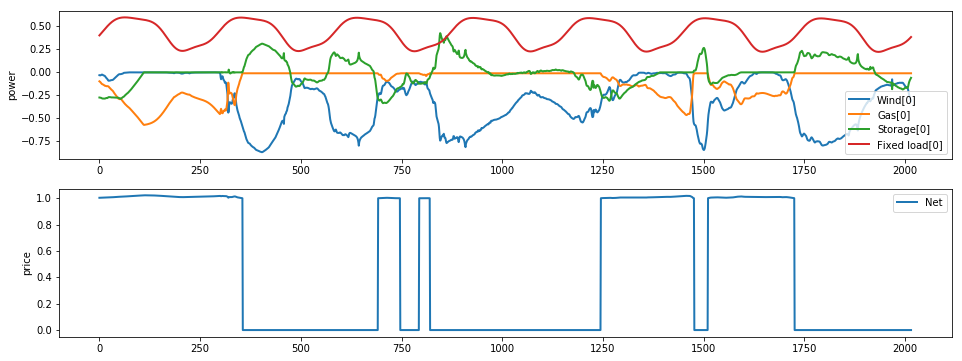

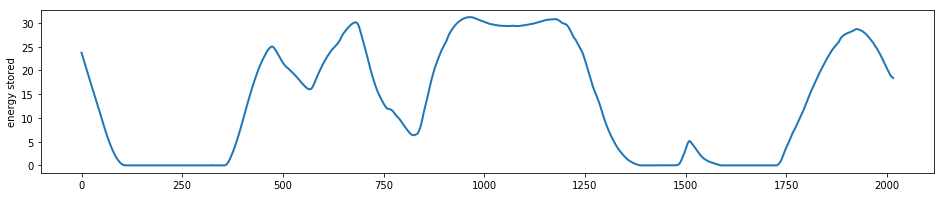

In [14]:
# plot the results
AR_MPC_results.plot(figsize=(16,6))

# plot energy stored in battery
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
ax.plot(energy_stored)
ax.set_ylabel("energy stored")

### Wind curtailment

Current model is not too smart about using all the available wind power, at times it doesn't even charge the battery when there is extra power available...

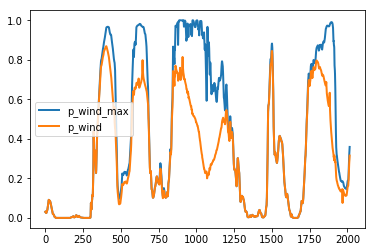

In [15]:
plt.plot(range(N), p_wind[initial_time:initial_time+N]/16, label="p_wind_max")
plt.plot(-AR_MPC_results.power[(wind_gen, 0)], label="p_wind")
plt.legend()

## Robust MPC

### Probabilistic predictions

In [16]:
# from sklearn import linear_model

# H = 4*6
# p_wind_residual = p_wind - baseline
# X = np.hstack([p_wind_residual.shift(x).fillna(0).reshape(-1,1) for x in range(1,H+1)])
# lr = linear_model.RidgeCV()
# lr.fit(X, p_wind_residual)
# sigma = np.std(lr.predict(X) - p_wind_residual)

# def predict_wind_probs(t, T, K):
#     np.random.seed(0)    
#     R = np.empty((T,K))    
#     Xp =  np.tile(X[t,:], (K,1))  # K x H prediction matrix
#     for i in range(T):
#         tau = t+i
#         R[i,:] = lr.predict(Xp) + sigma*np.random.randn(K)
#         Xp = np.hstack((R[i:i+1,:].T, Xp[:,:-1]))
#     return np.minimum(np.maximum(np.tile(baseline[t:t+T], (K,1)).T + R, 0), 16)

# # plot an example of predictions at a particular time
# idx = slice("2011-01-02", "2011-01-03")
# t = 4*24*2
# T = 4*24
# K = 10
# wind_probs = predict_wind_probs(t, T, K)
# ax0 = plt.plot(p_wind[idx].index, p_wind[idx])
# ax1 = plt.plot(p_wind.index[t:t+T], wind_probs, color="b", alpha=0.3)
# ax2 = plt.plot(baseline[idx].index, baseline[idx])
# plt.legend(handles=[ax0[0], ax1[0], ax2[0]], labels=["p_wind", "p_wind_pred", "p_out"])

In [ ]:
initial_time = 288*3


T = 288 # one day
K = 10

out = FixedLoad(power=Parameter((T+1,K)), name="Fixed load")
wind_gen = Generator(alpha=0, beta=0, power_min=-100, power_max=Parameter((T+1,K)), name="Wind")
gas_gen = Generator(alpha=0.02, beta=1, power_min=0.01, power_max=100, name="Gas")
storage = Storage(discharge_max=1, charge_max=1, energy_max=12*4, energy_init=Parameter((1,1), value=[[6*4]]))
net = Net([wind_gen.terminals[0], 
           gas_gen.terminals[0],
           storage.terminals[0], 
           out.terminals[0]])
mpc_network = Group([wind_gen, gas_gen, storage, out], [net])
mpc_network.init_problem(time_horizon=T+1, num_scenarios=K)

def predict_wind(t):
    past = p_wind[t-T:t]
    past_baseline = baseline[t-T:t]
    fut_baseline = baseline[t:t+T]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    return pred

initial_time = 288*3

def make_forecasts(t):
    t_used = t + initial_time
    out.power.value = np.tile(baseline[t_used:t_used+T+1], (K,1)).T / 16
    #wind_gen.power_max.value = np.empty((T+1, K))
    mean_prediction = np.hstack((p_wind[t_used], predict_wind(t_used+1)))
    scenarios = np.random.multivariate_normal(np.zeros(288), sigma_residual_errors, K)
    wind_gen.power_max.value = np.tile(mean_prediction, (K,1)).T 
    wind_gen.power_max.value[1:, :] += scenarios.T
    wind_gen.power_max.value /= 16

def implement(t):
    energy_stored[t] = storage.energy.value[0,0]
    storage.energy_init.value = np.matrix(energy_stored[t])

N = 288*1  # one week
energy_stored = np.empty(N)
robust_MPC_cost, robust_MPC_results = \
    run_mpc(mpc_network, N, make_forecasts, implement, verbose = True, solver='ECOS')

  0%|          | 0/288 [00:00<?, ?it/s]


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.385e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.048e+03  -9.490e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6590  5e-01   1  1  1 |  0  0
 2  +3.466e+03  -3.777e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7751  4e-01   1  1  1 |  0  0
 3  +3.359e+03  -1.782e+04  +4e+04  4e-03  6e-03  3e+00  1e+00  0.9372  1e-02   1  1  1 |  0  0
 4  +9.310e+02  -1.472e+03  +8e+03  5e-04  5e-03  4e-01  3e-01  0.8607  5e-02   1  1  1 |  0  0
 5  +2.891e+02  -1.573e+02  +2e+03  8e-05  1e-03  6e-02  5e-02  0.8553  6e-02   1  1  1 |  0  0
 6  +2.481e+02  -3.828e+01  +1e+03  5e-05  6e-04  2e-02  3e-02  0.7167  5e-01   1  1  1 |  0  0
 7  +2.343e+02  +7.006e+00  +8e+02  4e-05  5e-04  2e-02  3e-02  0.4783  6e-01   1  1  1 |  0  0
 8  +2.031e+02  +1.263e+02  +3e+02  1e-05  2e-

  0%|          | 1/288 [00:06<29:45,  6.22s/it]

22  +1.886e+02  +1.886e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  4e-01   2  2  2 |  0  0
23  +1.886e+02  +1.886e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.9100  1e-02   3  2  2 |  0  0
24  +1.886e+02  +1.886e+02  +3e-07  2e-14  5e-13  3e-12  1e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=5.2e-13, reltol=1.7e-09, abstol=3.1e-07).
Runtime: 5.007924 seconds.

at time 0, adding cost 0.800219

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  -3.455e+03  -9.513e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6639  5e-01   1  1  1 |  0  0
 2  +3.417e+03  -3.773e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7738  4e-01   1  1  1 |  0  0
 3  +3.382e+03  -1.759e+04  +4e+04  4e-03  6e-03  3e+00  1e+00  0.9379  1e-02   1  1  1 |  0  0
 4  +9.061e+02 

  1%|          | 2/288 [00:13<31:01,  6.51s/it]

26  +1.327e+02  +1.327e+02  +5e-07  3e-14  1e-12  5e-12  2e-11  0.9890  3e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.0e-12, reltol=3.8e-09, abstol=5.0e-07).
Runtime: 5.875059 seconds.

at time 1, adding cost 0.617979

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  -3.169e+03  -9.486e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6608  5e-01   1  1  1 |  0  0
 2  +3.439e+03  -3.772e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7748  4e-01   1  1  1 |  0  0
 3  +3.351e+03  -1.778e+04  +4e+04  4e-03  6e-03  3e+00  1e+00  0.9373  1e-02   1  1  1 |  0  0
 4  +9.086e+02  -1.528e+03  +8e+03  5e-04  5e-03  4e-01  3e-01  0.8579  5e-02   1  1  1 |  0  0
 5  +2.600e+02  -2.013e+02  +2e+03  9e-05  1e-03  7e-02  6e-02  0.8397  5e-02   1  1  1 |  0  0
 6  +2.047e+02 

  1%|          | 3/288 [00:19<30:38,  6.45s/it]

24  +1.436e+02  +1.436e+02  +3e-06  1e-12  4e-12  3e-11  1e-10  0.8868  3e-02   3  2  1 |  0  0
25  +1.436e+02  +1.436e+02  +7e-07  3e-13  2e-12  8e-12  3e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.8e-12, reltol=5.2e-09, abstol=7.5e-07).
Runtime: 5.142743 seconds.

at time 2, adding cost 0.677974

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.387e+03  -9.508e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6637  5e-01   1  1  1 |  0  0
 2  +3.423e+03  -3.779e+05  +6e+05  8e-02  9e-02  4e+01  2e+01  0.7733  4e-01   1  1  1 |  0  0
 3  +3.382e+03  -1.762e+04  +4e+04  4e-03  6e-03  3e+00  1e+00  0.9379  1e-02   1  1  1 |  0  0
 4  +9.143e+02  -1.491e+03  +8e+03  4e-04  5e-03  4e-01  3e-01  0.8590  5e-02   1  1  1 |  0  0
 5  +2.629e+02 

  1%|▏         | 4/288 [00:27<31:51,  6.73s/it]

22  +1.552e+02  +1.552e+02  +6e-06  3e-13  6e-12  7e-11  2e-10  0.9890  3e-01   2  2  2 |  0  0
23  +1.552e+02  +1.552e+02  +2e-07  1e-14  5e-13  2e-12  8e-12  0.9646  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=5.2e-13, reltol=1.5e-09, abstol=2.4e-07).
Runtime: 6.187175 seconds.

at time 3, adding cost 0.748464

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.170e+03  -9.496e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6605  5e-01   1  1  1 |  0  0
 2  +3.444e+03  -3.774e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7748  4e-01   1  1  1 |  0  0
 3  +3.360e+03  -1.777e+04  +4e+04  4e-03  6e-03  3e+00  1e+00  0.9373  1e-02   1  1  1 |  0  0
 4  +9.219e+02  -1.497e+03  +8e+03  5e-04  5e-03  4e-01  3e-01  0.8591  5e-02   1  1  1 |  0  0
 5  +2.763e+02 

  2%|▏         | 5/288 [00:33<31:58,  6.78s/it]

24  +1.722e+02  +1.722e+02  +2e-06  8e-14  2e-12  2e-11  5e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=2.0e-12, reltol=8.9e-09, abstol=1.5e-06).
Runtime: 5.683432 seconds.

at time 4, adding cost 0.759626

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.319e+03  -9.503e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6631  5e-01   1  1  1 |  0  0
 2  +3.434e+03  -3.782e+05  +6e+05  8e-02  9e-02  4e+01  2e+01  0.7733  4e-01   1  1  1 |  0  0
 3  +3.382e+03  -1.765e+04  +4e+04  4e-03  6e-03  3e+00  1e+00  0.9379  1e-02   1  1  1 |  0  0
 4  +9.251e+02  -1.502e+03  +8e+03  5e-04  5e-03  4e-01  3e-01  0.8577  5e-02   1  1  1 |  0  0
 5  +2.867e+02  -1.834e+02  +2e+03  9e-05  1e-03  7e-02  6e-02  0.8426  6e-02   1  1  1 |  0  0
 6  +2.359e+02 

  2%|▏         | 6/288 [00:40<31:20,  6.67s/it]

21  +1.713e+02  +1.713e+02  +2e-04  1e-11  1e-10  2e-09  7e-09  0.9475  1e-01   1  1  1 |  0  0
22  +1.713e+02  +1.713e+02  +5e-05  3e-12  3e-11  5e-10  2e-09  0.9890  2e-01   2  1  1 |  0  0
23  +1.713e+02  +1.713e+02  +6e-06  4e-13  6e-12  6e-11  2e-10  0.8825  1e-02   2  1  1 |  0  0
24  +1.713e+02  +1.713e+02  +2e-06  1e-13  3e-12  2e-11  6e-11  0.9890  3e-01   2  2  2 |  0  0

OPTIMAL (within feastol=2.6e-12, reltol=9.6e-09, abstol=1.6e-06).
Runtime: 5.118829 seconds.

at time 5, adding cost 0.812602

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.068e+03  -9.463e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6611  5e-01   1  1  1 |  0  0
 2  +3.453e+03  -3.751e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7767  4e-01   1  1  1 |  0  0
 3  +3.344e+03 

  2%|▏         | 7/288 [00:46<30:30,  6.51s/it]

23  +1.781e+02  +1.781e+02  +1e-06  7e-14  2e-12  1e-11  4e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.8e-12, reltol=6.9e-09, abstol=1.2e-06).
Runtime: 4.986091 seconds.

at time 6, adding cost 0.786359

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.167e+03  -9.489e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6611  5e-01   1  1  1 |  0  0
 2  +3.433e+03  -3.777e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7743  4e-01   1  1  1 |  0  0
 3  +3.353e+03  -1.839e+04  +4e+04  4e-03  6e-03  3e+00  2e+00  0.9353  1e-02   1  1  1 |  0  0
 4  +9.317e+02  -1.523e+03  +8e+03  5e-04  5e-03  4e-01  3e-01  0.8608  5e-02   1  1  1 |  0  0
 5  +2.922e+02  -2.142e+02  +2e+03  1e-04  1e-03  7e-02  6e-02  0.8199  5e-02   1  1  1 |  0  0
 6  +2.351e+02 

  3%|▎         | 8/288 [00:52<29:15,  6.27s/it]

20  +1.667e+02  +1.667e+02  +8e-04  4e-11  5e-10  9e-09  3e-08  0.9890  2e-01   1  1  1 |  0  0
21  +1.667e+02  +1.667e+02  +1e-04  7e-12  8e-11  1e-09  5e-09  0.8691  3e-02   1  1  1 |  0  0
22  +1.667e+02  +1.667e+02  +4e-05  2e-12  3e-11  5e-10  2e-09  0.9890  3e-01   2  1  1 |  0  0
23  +1.667e+02  +1.667e+02  +3e-06  5e-13  4e-12  3e-11  1e-10  0.9289  5e-03   3  1  1 |  0  0
24  +1.667e+02  +1.667e+02  +4e-07  6e-14  7e-13  4e-12  1e-11  0.9484  6e-02   3  2  2 |  0  0

OPTIMAL (within feastol=7.4e-13, reltol=2.1e-09, abstol=3.6e-07).
Runtime: 4.633325 seconds.

at time 7, adding cost 0.762351

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -3.314e+03  -9.502e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6625  5e-01   1  1  1 |  0  0
 2  +3.425e+03 

  3%|▎         | 9/288 [00:58<29:13,  6.28s/it]

21  +1.515e+02  +1.515e+02  +2e-04  1e-11  1e-10  2e-09  7e-09  0.8979  9e-03   1  1  1 |  0  0
22  +1.515e+02  +1.515e+02  +5e-05  2e-12  3e-11  5e-10  2e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.515e+02  +1.515e+02  +7e-06  4e-13  6e-12  7e-11  2e-10  0.8797  4e-02   2  1  1 |  0  0
24  +1.515e+02  +1.515e+02  +2e-06  9e-14  2e-12  2e-11  6e-11  0.9890  2e-01   2  2  2 |  0  0
25  +1.515e+02  +1.515e+02  +1e-07  7e-15  4e-13  1e-12  5e-12  0.9241  1e-02   3  2  2 |  0  0

OPTIMAL (within feastol=3.7e-13, reltol=9.0e-10, abstol=1.4e-07).
Runtime: 5.141885 seconds.

at time 8, adding cost 0.726406

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  -2.644e+03  -9.486e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6481  5e-01   1  1  1 |  0  0
 2  +3.532e+03 

  3%|▎         | 10/288 [01:04<29:16,  6.32s/it]

23  +1.415e+02  +1.415e+02  +3e-06  2e-13  4e-12  3e-11  1e-10  0.9890  2e-01   3  2  2 |  0  0
24  +1.415e+02  +1.415e+02  +2e-07  1e-14  6e-13  3e-12  9e-12  0.9314  6e-03   3  2  2 |  0  0

OPTIMAL (within feastol=5.7e-13, reltol=1.8e-09, abstol=2.5e-07).
Runtime: 5.281924 seconds.

at time 9, adding cost 0.671456

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -2.113e+03  -9.470e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6374  5e-01   1  1  1 |  0  0
 2  +3.664e+03  -3.798e+05  +6e+05  8e-02  8e-02  4e+01  2e+01  0.7792  4e-01   1  1  1 |  0  0
 3  +3.350e+03  -1.989e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9305  1e-02   1  1  1 |  0  0
 4  +9.628e+02  -1.554e+03  +8e+03  5e-04  5e-03  3e-01  3e-01  0.8683  5e-02   1  1  1 |  0  0
 5  +2.542e+02 

  4%|▍         | 11/288 [01:12<31:27,  6.81s/it]


OPTIMAL (within feastol=6.7e-13, reltol=1.3e-09, abstol=1.8e-07).
Runtime: 6.553895 seconds.

at time 10, adding cost 0.618271

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -1.830e+03  -9.477e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6306  5e-01   1  1  1 |  0  0
 2  +3.759e+03  -3.791e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.7824  4e-01   1  1  1 |  0  0
 3  +3.377e+03  -2.012e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9294  1e-02   1  1  1 |  0  0
 4  +9.899e+02  -1.529e+03  +8e+03  5e-04  5e-03  3e-01  3e-01  0.8701  5e-02   1  1  1 |  0  0
 5  +2.772e+02  -2.190e+02  +2e+03  9e-05  1e-03  5e-02  6e-02  0.8425  6e-02   1  1  1 |  0  0
 6  +2.333e+02  -9.040e+01  +1e+03  6e-05  7e-04  2e-02  4e-02  0.7088  5e-01   1  1  1 |  0  0
 7  +2.178e+02

  4%|▍         | 12/288 [01:20<32:36,  7.09s/it]

25  +1.617e+02  +1.617e+02  +1e-06  8e-14  2e-12  1e-11  4e-11  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.6e-12, reltol=7.5e-09, abstol=1.2e-06).
Runtime: 6.272237 seconds.

at time 11, adding cost 0.699690

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  -1.316e+03  -9.455e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6202  5e-01   1  1  1 |  0  0
 2  +3.909e+03  -3.777e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.7870  4e-01   1  1  1 |  0  0
 3  +3.408e+03  -2.047e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9279  1e-02   1  1  1 |  0  0
 4  +1.006e+03  -1.546e+03  +8e+03  5e-04  5e-03  3e-01  3e-01  0.8708  5e-02   1  1  1 |  0  0
 5  +2.522e+02  -2.069e+02  +2e+03  9e-05  1e-03  5e-02  6e-02  0.8622  6e-02   1  1  1 |  0  0
 6  +2.138e+02

  5%|▍         | 13/288 [01:28<32:56,  7.19s/it]

24  +1.509e+02  +1.509e+02  +7e-06  4e-13  6e-12  8e-11  3e-10  0.9890  4e-01   2  2  2 |  0  0
25  +1.509e+02  +1.509e+02  +8e-07  4e-14  1e-12  9e-12  3e-11  0.8956  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=5.5e-09, abstol=8.3e-07).
Runtime: 6.112672 seconds.

at time 12, adding cost 0.704985

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  -9.072e+02  -9.447e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6111  5e-01   1  1  1 |  0  0
 2  +4.042e+03  -3.770e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.7908  4e-01   1  1  1 |  0  0
 3  +3.450e+03  -2.075e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9266  1e-02   1  1  1 |  0  0
 4  +1.034e+03  -1.546e+03  +9e+03  5e-04  5e-03  3e-01  3e-01  0.8714  5e-02   1  1  1 |  0  0
 5  +2.442e+02

  5%|▍         | 14/288 [01:34<32:09,  7.04s/it]

23  +1.698e+02  +1.698e+02  +9e-06  5e-13  7e-12  9e-11  3e-10  0.9890  2e-01   2  1  1 |  0  0
24  +1.698e+02  +1.698e+02  +8e-07  5e-14  1e-12  9e-12  3e-11  0.9215  1e-02   3  2  2 |  0  0

OPTIMAL (within feastol=9.8e-13, reltol=4.9e-09, abstol=8.4e-07).
Runtime: 5.363570 seconds.

at time 13, adding cost 0.722376

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  -4.442e+02  -9.425e+05  +1e+06  3e-01  1e-01  3e+01  4e+01  0.6014  5e-01   1  1  1 |  0  0
 2  +4.187e+03  -3.763e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.7945  4e-01   1  1  1 |  0  0
 3  +3.494e+03  -2.104e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9253  1e-02   1  1  1 |  0  0
 4  +1.050e+03  -1.546e+03  +9e+03  5e-04  5e-03  3e-01  3e-01  0.8729  5e-02   1  1  1 |  0  0
 5  +5.551e+02

  5%|▌         | 15/288 [01:42<32:36,  7.17s/it]

20  +1.568e+02  +1.568e+02  +2e-02  8e-10  8e-09  2e-07  5e-07  0.6912  4e-02   1  1  1 |  0  0
21  +1.568e+02  +1.568e+02  +3e-03  2e-10  2e-09  3e-08  1e-07  0.9890  2e-01   1  1  1 |  0  0
22  +1.568e+02  +1.568e+02  +6e-04  3e-11  3e-10  6e-09  2e-08  0.9398  1e-01   1  1  1 |  0  0
23  +1.568e+02  +1.568e+02  +2e-04  1e-11  1e-10  3e-09  8e-09  0.9890  4e-01   2  1  1 |  0  0
24  +1.568e+02  +1.568e+02  +2e-05  1e-12  2e-11  2e-10  8e-10  0.9128  5e-03   2  1  1 |  0  0
25  +1.568e+02  +1.568e+02  +4e-06  2e-13  4e-12  4e-11  1e-10  0.9114  8e-02   3  2  2 |  0  0
26  +1.568e+02  +1.568e+02  +9e-07  5e-14  1e-12  9e-12  3e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.5e-12, reltol=5.8e-09, abstol=9.1e-07).
Runtime: 6.155549 seconds.

at time 14, adding cost 0.767961

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04 

  6%|▌         | 16/288 [01:49<32:17,  7.12s/it]

19  +1.604e+02  +1.604e+02  +1e-02  7e-10  7e-09  1e-07  5e-07  0.9284  2e-01   1  1  1 |  0  0
20  +1.604e+02  +1.604e+02  +3e-03  2e-10  2e-09  3e-08  1e-07  0.9120  1e-01   1  1  1 |  0  0
21  +1.604e+02  +1.604e+02  +1e-03  6e-11  6e-10  1e-08  4e-08  0.9890  4e-01   1  1  1 |  0  0
22  +1.604e+02  +1.604e+02  +1e-04  5e-12  6e-11  1e-09  4e-09  0.9172  7e-03   1  1  1 |  0  0
23  +1.604e+02  +1.604e+02  +2e-05  8e-13  1e-11  2e-10  6e-10  0.9890  1e-01   2  1  1 |  0  0
24  +1.604e+02  +1.604e+02  +1e-06  5e-14  1e-12  1e-11  3e-11  0.9625  2e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.5e-12, reltol=6.0e-09, abstol=9.6e-07).
Runtime: 5.486469 seconds.

at time 15, adding cost 0.719874

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.641e+02

  6%|▌         | 17/288 [01:56<32:02,  7.09s/it]

24  +1.596e+02  +1.596e+02  +2e-06  8e-14  2e-12  2e-11  5e-11  0.9240  6e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.1e-12, reltol=9.5e-09, abstol=1.5e-06).
Runtime: 5.760138 seconds.

at time 16, adding cost 0.687419

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +7.256e+02  -9.363e+05  +1e+06  3e-01  2e-01  3e+01  4e+01  0.5763  5e-01   1  1  1 |  0  0
 2  +4.552e+03  -3.755e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8029  4e-01   1  1  1 |  0  0
 3  +3.617e+03  -2.181e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9223  9e-03   1  1  1 |  0  0
 4  +1.231e+03  -2.688e+03  +1e+04  8e-04  4e-03  4e-01  4e-01  0.7998  5e-02   1  1  1 |  0  0
 5  +9.367e+02  -2.221e+03  +1e+04  6e-04  4e-03  3e-01  4e-01  0.3344  5e-01   1  1  1 |  0  0
 6  +1.956e+02

  6%|▋         | 18/288 [02:03<32:11,  7.16s/it]

26  +1.258e+02  +1.258e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.8715  4e-02   3  2  2 |  0  0
27  +1.258e+02  +1.258e+02  +6e-07  3e-14  8e-13  7e-12  2e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=8.4e-13, reltol=5.1e-09, abstol=6.4e-07).
Runtime: 6.094937 seconds.

at time 17, adding cost 0.562963

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.384e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +7.416e+02  -9.385e+05  +1e+06  3e-01  2e-01  3e+01  4e+01  0.5746  5e-01   1  1  1 |  0  0
 2  +4.584e+03  -3.760e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8034  4e-01   1  1  1 |  0  0
 3  +3.649e+03  -2.184e+04  +5e+04  5e-03  6e-03  3e+00  2e+00  0.9222  9e-03   1  1  1 |  0  0
 4  +1.292e+03  -2.839e+03  +1e+04  8e-04  4e-03  4e-01  5e-01  0.7882  5e-02   1  1  1 |  0  0
 5  +1.008e+03

  7%|▋         | 19/288 [02:10<31:35,  7.05s/it]

24  +1.906e+02  +1.906e+02  +8e-05  4e-12  5e-11  8e-10  3e-09  0.9890  4e-01   1  1  2 |  0  0
25  +1.906e+02  +1.906e+02  +7e-06  4e-13  6e-12  8e-11  3e-10  0.9128  6e-03   1  1  1 |  0  0
26  +1.906e+02  +1.906e+02  +9e-07  5e-14  1e-12  9e-12  3e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=4.6e-09, abstol=8.8e-07).
Runtime: 5.627171 seconds.

at time 18, adding cost 0.798211

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +1.202e+03  -9.349e+05  +1e+06  3e-01  2e-01  3e+01  4e+01  0.5650  5e-01   1  1  1 |  0  0
 2  +4.722e+03  -3.759e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8062  4e-01   1  1  1 |  0  0
 3  +3.695e+03  -2.213e+04  +5e+04  6e-03  6e-03  3e+00  2e+00  0.9211  9e-03   1  1  1 |  0  0
 4  +1.365e+03

  7%|▋         | 20/288 [02:17<31:29,  7.05s/it]

25  +1.581e+02  +1.581e+02  +1e-05  5e-13  1e-11  1e-10  4e-10  0.9890  3e-01   3  2  2 |  0  0
26  +1.581e+02  +1.581e+02  +1e-06  7e-14  2e-12  1e-11  4e-11  0.8862  1e-02   3  2  2 |  0  0

OPTIMAL (within feastol=2.3e-12, reltol=8.2e-09, abstol=1.3e-06).
Runtime: 5.608426 seconds.

at time 19, adding cost 0.793737

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +1.547e+03  -9.332e+05  +1e+06  3e-01  2e-01  3e+01  4e+01  0.5570  5e-01   1  1  1 |  0  0
 2  +4.836e+03  -3.762e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8083  4e-01   1  1  1 |  0  0
 3  +3.743e+03  -2.237e+04  +5e+04  6e-03  6e-03  3e+00  2e+00  0.9203  9e-03   1  1  1 |  0  0
 4  +1.455e+03  -3.965e+03  +2e+04  1e-03  5e-03  6e-01  6e-01  0.7245  5e-02   1  1  1 |  0  0
 5  +1.203e+03

  7%|▋         | 21/288 [02:24<31:24,  7.06s/it]

26  +1.565e+02  +1.565e+02  +6e-06  3e-13  6e-12  6e-11  2e-10  0.8936  9e-03   2  1  1 |  0  0
27  +1.565e+02  +1.565e+02  +1e-06  8e-14  2e-12  1e-11  5e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=2.0e-12, reltol=9.3e-09, abstol=1.4e-06).
Runtime: 5.956042 seconds.

at time 20, adding cost 0.704531

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +1.824e+03  -9.310e+05  +1e+06  3e-01  2e-01  3e+01  4e+01  0.5510  5e-01   1  1  1 |  0  0
 2  +4.920e+03  -3.764e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8098  4e-01   1  1  1 |  0  0
 3  +3.773e+03  -2.256e+04  +6e+04  6e-03  6e-03  3e+00  2e+00  0.9197  8e-03   1  1  1 |  0  0
 4  +1.513e+03  -4.408e+03  +2e+04  1e-03  5e-03  6e-01  6e-01  0.7012  5e-02   1  1  1 |  0  0
 5  +1.275e+03

  8%|▊         | 22/288 [02:31<31:32,  7.12s/it]

26  +1.373e+02  +1.373e+02  +3e-06  1e-13  3e-12  3e-11  9e-11  0.8948  9e-02   2  2  2 |  0  0
27  +1.373e+02  +1.373e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.9890  4e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-12, reltol=8.2e-09, abstol=1.1e-06).
Runtime: 6.129490 seconds.

at time 21, adding cost 0.613157

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +1.961e+03  -9.307e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5476  5e-01   1  1  1 |  0  0
 2  +4.971e+03  -3.767e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8106  4e-01   1  1  1 |  0  0
 3  +3.800e+03  -2.294e+04  +6e+04  6e-03  6e-03  3e+00  2e+00  0.9184  8e-03   1  1  1 |  0  0
 4  +1.531e+03  -4.398e+03  +2e+04  1e-03  5e-03  6e-01  6e-01  0.7055  5e-02   1  1  1 |  0  0
 5  +1.301e+03

  8%|▊         | 23/288 [02:38<30:47,  6.97s/it]

26  +1.476e+02  +1.476e+02  +7e-07  4e-14  1e-12  7e-12  3e-11  0.9890  4e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-12, reltol=4.9e-09, abstol=7.3e-07).
Runtime: 5.451028 seconds.

at time 22, adding cost 0.700408

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +2.159e+03  -9.300e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5427  5e-01   1  1  1 |  0  0
 2  +5.042e+03  -3.772e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8117  4e-01   1  1  1 |  0  0
 3  +3.838e+03  -2.357e+04  +6e+04  6e-03  7e-03  3e+00  2e+00  0.9164  8e-03   1  1  1 |  0  0
 4  +1.539e+03  -4.250e+03  +2e+04  1e-03  5e-03  6e-01  6e-01  0.7199  5e-02   1  1  1 |  0  0
 5  +1.319e+03  -3.847e+03  +2e+04  1e-03  5e-03  5e-01  6e-01  0.2241  6e-01   1  1  1 |  0  0
 6  +2.911e+02

  8%|▊         | 24/288 [02:45<30:16,  6.88s/it]

25  +1.644e+02  +1.644e+02  +3e-06  1e-13  4e-12  3e-11  1e-10  0.9334  1e-01   2  2  2 |  0  0
26  +1.644e+02  +1.644e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.9890  4e-01   3  2  2 |  0  0

OPTIMAL (within feastol=2.1e-12, reltol=6.5e-09, abstol=1.1e-06).
Runtime: 5.556457 seconds.

at time 23, adding cost 0.705997

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +2.399e+03  -9.281e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5373  5e-01   1  1  1 |  0  0
 2  +5.116e+03  -3.775e+05  +6e+05  9e-02  8e-02  4e+01  2e+01  0.8129  4e-01   1  1  1 |  0  0
 3  +3.869e+03  -2.419e+04  +6e+04  6e-03  7e-03  3e+00  2e+00  0.9144  8e-03   1  1  1 |  0  0
 4  +1.533e+03  -4.114e+03  +2e+04  1e-03  5e-03  5e-01  6e-01  0.7336  5e-02   1  1  1 |  0  0
 5  +1.321e+03

  9%|▊         | 25/288 [02:52<30:33,  6.97s/it]

27  +1.485e+02  +1.485e+02  +2e-06  1e-13  2e-12  2e-11  6e-11  0.9890  3e-01   3  2  2 |  0  0
28  +1.485e+02  +1.485e+02  +2e-07  1e-14  5e-13  2e-12  8e-12  0.8775  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.5e-13, reltol=1.6e-09, abstol=2.3e-07).
Runtime: 5.974578 seconds.

at time 24, adding cost 0.692529

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +2.597e+03  -9.268e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5326  5e-01   1  1  1 |  0  0
 2  +5.181e+03  -3.779e+05  +6e+05  9e-02  9e-02  4e+01  2e+01  0.8139  4e-01   1  1  1 |  0  0
 3  +3.900e+03  -2.475e+04  +6e+04  6e-03  7e-03  3e+00  2e+00  0.9126  8e-03   1  1  1 |  0  0
 4  +1.530e+03  -3.952e+03  +2e+04  1e-03  5e-03  5e-01  6e-01  0.7474  4e-02   1  1  1 |  0  0
 5  +1.326e+03

  9%|▉         | 26/288 [03:00<31:27,  7.20s/it]

28  +1.482e+02  +1.482e+02  +1e-06  5e-14  2e-12  1e-11  4e-11  0.9227  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.6e-12, reltol=6.8e-09, abstol=1.0e-06).
Runtime: 6.616837 seconds.

at time 25, adding cost 0.709756

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +2.787e+03  -9.257e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5281  5e-01   1  1  1 |  0  0
 2  +5.245e+03  -3.784e+05  +6e+05  9e-02  9e-02  4e+01  2e+01  0.8147  4e-01   1  1  1 |  0  0
 3  +3.932e+03  -2.532e+04  +6e+04  6e-03  7e-03  3e+00  2e+00  0.9108  8e-03   1  1  1 |  0  0
 4  +1.529e+03  -3.759e+03  +2e+04  1e-03  4e-03  4e-01  6e-01  0.7622  4e-02   1  1  1 |  0  0
 5  +1.333e+03  -3.491e+03  +2e+04  1e-03  4e-03  4e-01  5e-01  0.1950  6e-01   1  1  1 |  0  0
 6  +2.609e+02

  9%|▉         | 27/288 [03:07<31:10,  7.17s/it]

25  +1.485e+02  +1.485e+02  +6e-06  5e-13  5e-12  6e-11  2e-10  0.8897  8e-02   2  1  1 |  0  0
26  +1.485e+02  +1.485e+02  +2e-06  2e-13  3e-12  2e-11  8e-11  0.9890  4e-01   2  2  2 |  0  0
27  +1.485e+02  +1.485e+02  +3e-07  2e-14  4e-13  3e-12  9e-12  0.9014  7e-03   3  2  2 |  0  0

OPTIMAL (within feastol=4.3e-13, reltol=1.7e-09, abstol=2.5e-07).
Runtime: 5.881915 seconds.

at time 26, adding cost 0.677970

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +2.950e+03  -9.245e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5242  5e-01   1  1  1 |  0  0
 2  +5.297e+03  -3.788e+05  +6e+05  9e-02  9e-02  4e+01  2e+01  0.8155  4e-01   1  1  1 |  0  0
 3  +3.958e+03  -2.578e+04  +6e+04  7e-03  7e-03  3e+00  2e+00  0.9094  8e-03   1  1  1 |  0  0
 4  +1.524e+03

 10%|▉         | 28/288 [03:13<30:17,  6.99s/it]

19  +1.461e+02  +1.461e+02  +3e-02  2e-09  2e-08  3e-07  1e-06  0.7569  4e-01   1  1  1 |  0  0
20  +1.461e+02  +1.461e+02  +7e-03  4e-10  4e-09  7e-08  2e-07  0.7939  4e-02   1  1  1 |  0  0
21  +1.461e+02  +1.461e+02  +1e-03  7e-11  8e-10  1e-08  5e-08  0.9766  2e-01   1  1  1 |  0  0
22  +1.461e+02  +1.461e+02  +4e-04  2e-11  2e-10  4e-09  1e-08  0.9890  3e-01   1  1  1 |  0  0
23  +1.461e+02  +1.461e+02  +6e-05  3e-12  3e-11  6e-10  2e-09  0.8737  3e-02   1  1  1 |  0  0
24  +1.461e+02  +1.461e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  3e-01   1  1  1 |  0  0
25  +1.461e+02  +1.461e+02  +9e-07  5e-14  1e-12  9e-12  3e-11  0.9450  1e-03   2  1  2 |  0  0

OPTIMAL (within feastol=1.2e-12, reltol=6.4e-09, abstol=9.3e-07).
Runtime: 5.449228 seconds.

at time 27, adding cost 0.604067

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04 

 10%|█         | 29/288 [03:20<29:48,  6.91s/it]

23  +1.603e+02  +1.603e+02  +6e-05  3e-12  4e-11  6e-10  2e-09  0.9194  3e-03   2  1  1 |  0  0
24  +1.603e+02  +1.603e+02  +9e-06  5e-13  8e-12  9e-11  3e-10  0.9890  1e-01   3  2  1 |  0  0
25  +1.603e+02  +1.603e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.8973  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-12, reltol=7.0e-09, abstol=1.1e-06).
Runtime: 5.395484 seconds.

at time 28, adding cost 0.751986

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.242e+03  -9.225e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5172  5e-01   1  1  1 |  0  0
 2  +5.394e+03  -3.797e+05  +6e+05  9e-02  9e-02  4e+01  2e+01  0.8167  4e-01   1  1  1 |  0  0
 3  +4.006e+03  -2.663e+04  +7e+04  7e-03  7e-03  3e+00  2e+00  0.9068  8e-03   1  1  1 |  0  0
 4  +1.513e+03

 10%|█         | 30/288 [03:27<29:36,  6.89s/it]

16  +1.444e+02  +1.442e+02  +9e-01  5e-08  5e-07  9e-06  3e-05  0.7946  7e-02   1  1  1 |  0  0
17  +1.444e+02  +1.442e+02  +7e-01  4e-08  4e-07  7e-06  2e-05  0.5954  6e-01   1  1  1 |  0  0
18  +1.444e+02  +1.443e+02  +2e-01  1e-08  1e-07  2e-06  7e-06  0.7433  4e-02   1  1  1 |  0  0
19  +1.444e+02  +1.444e+02  +1e-01  5e-09  5e-08  1e-06  3e-06  0.9122  4e-01   1  1  1 |  0  0
20  +1.444e+02  +1.444e+02  +3e-02  2e-09  2e-08  3e-07  1e-06  0.7776  1e-01   1  1  1 |  0  0
21  +1.444e+02  +1.444e+02  +2e-02  1e-09  1e-08  2e-07  7e-07  0.6403  5e-01   1  1  1 |  0  0
22  +1.444e+02  +1.444e+02  +4e-03  2e-10  2e-09  4e-08  1e-07  0.8202  3e-02   1  1  1 |  0  0
23  +1.444e+02  +1.444e+02  +7e-04  4e-11  4e-10  7e-09  3e-08  0.9682  1e-01   1  1  1 |  0  0
24  +1.444e+02  +1.444e+02  +1e-04  5e-12  6e-11  1e-09  3e-09  0.9201  6e-02   1  1  1 |  0  0
25  +1.444e+02  +1.444e+02  +2e-05  1e-12  2e-11  2e-10  7e-10  0.9890  2e-01   2  1  1 |  0  0
26  +1.444e+02  +1.444e+02  +1e-06  7e-1

 11%|█         | 31/288 [03:34<29:51,  6.97s/it]

24  +1.704e+02  +1.704e+02  +2e-05  8e-13  1e-11  2e-10  5e-10  0.9890  2e-01   2  1  2 |  0  0
25  +1.704e+02  +1.704e+02  +3e-07  2e-14  9e-13  3e-12  1e-11  0.9788  6e-04   3  2  2 |  0  0

OPTIMAL (within feastol=9.2e-13, reltol=2.0e-09, abstol=3.4e-07).
Runtime: 5.971201 seconds.

at time 30, adding cost 0.749822

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.545e+03  -9.201e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5099  5e-01   1  1  1 |  0  0
 2  +5.489e+03  -3.805e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8179  4e-01   1  1  1 |  0  0
 3  +4.052e+03  -2.749e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9042  8e-03   1  1  1 |  0  0
 4  +1.495e+03  -2.814e+03  +1e+04  9e-04  4e-03  3e-01  5e-01  0.8253  4e-02   1  1  1 |  0  0
 5  +1.334e+03

 11%|█         | 32/288 [03:41<29:43,  6.97s/it]

26  +1.391e+02  +1.391e+02  +7e-07  4e-14  1e-12  7e-12  2e-11  0.9270  3e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=5.0e-09, abstol=6.9e-07).
Runtime: 5.673542 seconds.

at time 31, adding cost 0.646961

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.634e+03  -9.197e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5076  5e-01   1  1  1 |  0  0
 2  +5.522e+03  -3.809e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8182  4e-01   1  1  1 |  0  0
 3  +4.072e+03  -2.778e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9034  8e-03   1  1  1 |  0  0
 4  +1.493e+03  -2.633e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8357  4e-02   1  1  1 |  0  0
 5  +1.339e+03  -2.548e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.1474  7e-01   1  1  1 |  0  0
 6  +2.189e+02

 11%|█▏        | 33/288 [03:48<29:22,  6.91s/it]

26  +1.403e+02  +1.403e+02  +2e-07  1e-14  4e-13  2e-12  7e-12  0.9038  9e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.1e-13, reltol=1.4e-09, abstol=2.0e-07).
Runtime: 5.495841 seconds.

at time 32, adding cost 0.632818

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.693e+03  -9.198e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5060  5e-01   1  1  1 |  0  0
 2  +5.550e+03  -3.813e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8184  4e-01   1  1  1 |  0  0
 3  +4.093e+03  -2.803e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9028  8e-03   1  1  1 |  0  0
 4  +1.497e+03  -2.438e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8459  4e-02   1  1  1 |  0  0
 5  +1.351e+03  -2.372e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.1401  7e-01   1  1  1 |  0  0
 6  +2.360e+02

 12%|█▏        | 34/288 [03:54<29:03,  6.86s/it]

24  +1.668e+02  +1.668e+02  +5e-06  3e-13  4e-12  5e-11  2e-10  0.9890  9e-02   2  1  1 |  0  0
25  +1.668e+02  +1.668e+02  +5e-08  3e-15  2e-13  5e-13  2e-12  0.9890  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.8e-13, reltol=3.2e-10, abstol=5.3e-08).
Runtime: 5.607203 seconds.

at time 33, adding cost 0.734354

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.840e+03  -9.185e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5024  5e-01   1  1  1 |  0  0
 2  +5.596e+03  -3.818e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8189  4e-01   1  1  1 |  0  0
 3  +4.116e+03  -2.845e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9018  8e-03   1  1  1 |  0  0
 4  +1.485e+03  -2.192e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.8600  4e-02   1  1  1 |  0  0
 5  +1.351e+03

 12%|█▏        | 35/288 [04:01<29:04,  6.90s/it]

18  +1.598e+02  +1.598e+02  +5e-02  3e-09  3e-08  5e-07  2e-06  0.9890  4e-01   1  1  1 |  0  0
19  +1.598e+02  +1.598e+02  +9e-03  4e-10  4e-09  9e-08  3e-07  0.8938  6e-02   1  1  1 |  0  0
20  +1.598e+02  +1.598e+02  +5e-03  2e-10  2e-09  5e-08  2e-07  0.7499  4e-01   1  1  1 |  0  0
21  +1.598e+02  +1.598e+02  +4e-04  2e-11  2e-10  4e-09  1e-08  0.9125  5e-03   1  1  1 |  0  0
22  +1.598e+02  +1.598e+02  +9e-05  5e-12  5e-11  1e-09  3e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.598e+02  +1.598e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.8799  7e-02   1  1  1 |  0  0
24  +1.598e+02  +1.598e+02  +7e-06  4e-13  5e-12  7e-11  2e-10  0.9890  4e-01   2  2  2 |  0  0
25  +1.598e+02  +1.598e+02  +5e-07  3e-14  6e-13  5e-12  2e-11  0.9302  4e-03   3  2  2 |  0  0

OPTIMAL (within feastol=5.9e-13, reltol=3.3e-09, abstol=5.2e-07).
Runtime: 5.718118 seconds.

at time 34, adding cost 0.647315

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost  

 12%|█▎        | 36/288 [04:08<28:44,  6.85s/it]

25  +1.400e+02  +1.400e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  3e-01   3  2  2 |  0  0
26  +1.400e+02  +1.400e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.9390  2e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.7e-12, reltol=7.7e-09, abstol=1.1e-06).
Runtime: 5.584860 seconds.

at time 35, adding cost 0.635450

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.032e+03  -9.164e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4979  5e-01   1  1  1 |  0  0
 2  +5.649e+03  -3.824e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8196  4e-01   1  1  1 |  0  0
 3  +4.137e+03  -2.894e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9006  9e-03   1  1  1 |  0  0
 4  +1.476e+03  -2.083e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8679  4e-02   1  1  1 |  0  0
 5  +1.248e+03

 13%|█▎        | 37/288 [04:14<27:52,  6.66s/it]

25  +1.259e+02  +1.259e+02  +5e-07  4e-14  8e-13  5e-12  2e-11  0.9398  3e-03   3  2  2 |  0  0

OPTIMAL (within feastol=7.7e-13, reltol=3.9e-09, abstol=5.0e-07).
Runtime: 5.066280 seconds.

at time 36, adding cost 0.600568

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.070e+03  -9.164e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4969  5e-01   1  1  1 |  0  0
 2  +5.666e+03  -3.826e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8197  4e-01   1  1  1 |  0  0
 3  +4.150e+03  -2.909e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9003  9e-03   1  1  1 |  0  0
 4  +1.491e+03  -2.100e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8672  4e-02   1  1  1 |  0  0
 5  +1.168e+03  -1.898e+03  +1e+04  6e-04  4e-03  1e-01  4e-01  0.2734  5e-01   1  1  1 |  0  0
 6  +2.076e+02

 13%|█▎        | 38/288 [04:20<27:00,  6.48s/it]

25  +1.404e+02  +1.404e+02  +8e-07  4e-14  1e-12  8e-12  3e-11  0.8998  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-12, reltol=5.7e-09, abstol=8.0e-07).
Runtime: 4.917999 seconds.

at time 37, adding cost 0.647076

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.141e+03  -9.158e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4951  5e-01   1  1  1 |  0  0
 2  +5.689e+03  -3.829e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8199  4e-01   1  1  1 |  0  0
 3  +4.162e+03  -2.930e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.8998  9e-03   1  1  1 |  0  0
 4  +1.503e+03  -2.131e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8663  4e-02   1  1  1 |  0  0
 5  +1.064e+03  -1.790e+03  +1e+04  6e-04  3e-03  1e-01  3e-01  0.3573  5e-01   1  1  1 |  0  0
 6  +3.016e+02

 14%|█▎        | 39/288 [04:27<26:51,  6.47s/it]

24  +1.431e+02  +1.431e+02  +1e-04  6e-12  6e-11  1e-09  4e-09  0.9293  1e-01   1  1  1 |  0  0
25  +1.431e+02  +1.431e+02  +4e-05  2e-12  3e-11  4e-10  2e-09  0.9890  4e-01   2  2  2 |  0  0
26  +1.431e+02  +1.431e+02  +5e-06  5e-13  4e-12  5e-11  2e-10  0.9036  7e-03   2  1  1 |  0  0
27  +1.431e+02  +1.431e+02  +8e-07  8e-14  1e-12  8e-12  3e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=9.8e-13, reltol=5.4e-09, abstol=7.7e-07).
Runtime: 5.367828 seconds.

at time 38, adding cost 0.655588

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.384e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.168e+03  -9.164e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4941  5e-01   1  1  1 |  0  0
 2  +5.711e+03  -3.833e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8200  4e-01   1  1  1 |  0  0
 3  +4.186e+03

 14%|█▍        | 40/288 [04:33<26:42,  6.46s/it]

25  +1.847e+02  +1.847e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.9890  2e-01   2  2  2 |  0  0
26  +1.847e+02  +1.847e+02  +3e-07  2e-14  6e-13  3e-12  1e-11  0.8658  4e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.3e-13, reltol=1.9e-09, abstol=3.5e-07).
Runtime: 5.288962 seconds.

at time 39, adding cost 0.801837

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.334e+03  -9.145e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4902  5e-01   1  1  1 |  0  0
 2  +5.755e+03  -3.838e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8205  4e-01   1  1  1 |  0  0
 3  +4.202e+03  -2.991e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8984  9e-03   1  1  1 |  0  0
 4  +1.541e+03  -2.217e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8639  4e-02   1  1  1 |  0  0
 5  +7.886e+02

 14%|█▍        | 41/288 [04:40<26:42,  6.49s/it]

24  +1.532e+02  +1.532e+02  +1e-05  6e-13  9e-12  1e-10  4e-10  0.9890  3e-01   2  2  2 |  0  0
25  +1.532e+02  +1.532e+02  +1e-06  5e-14  1e-12  1e-11  4e-11  0.9169  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.4e-12, reltol=6.8e-09, abstol=1.0e-06).
Runtime: 5.410023 seconds.

at time 40, adding cost 0.658963

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.385e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.374e+03  -9.146e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4890  5e-01   1  1  1 |  0  0
 2  +5.775e+03  -3.842e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8206  4e-01   1  1  1 |  0  0
 3  +4.219e+03  -3.008e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8979  9e-03   1  1  1 |  0  0
 4  +1.563e+03  -2.231e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8632  4e-02   1  1  1 |  0  0
 5  +7.172e+02

 15%|█▍        | 42/288 [04:46<26:28,  6.46s/it]

24  +1.746e+02  +1.746e+02  +1e-05  5e-13  8e-12  1e-10  4e-10  0.9890  2e-01   2  1  2 |  0  0
25  +1.746e+02  +1.746e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.8659  6e-02   2  2  2 |  0  0
26  +1.746e+02  +1.746e+02  +8e-07  4e-14  1e-12  8e-12  3e-11  0.9890  4e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.4e-12, reltol=4.5e-09, abstol=7.8e-07).
Runtime: 5.250040 seconds.

at time 41, adding cost 0.728128

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.480e+03  -9.134e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4865  5e-01   1  1  1 |  0  0
 2  +5.804e+03  -3.845e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8209  4e-01   1  1  1 |  0  0
 3  +4.231e+03  -3.036e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8973  9e-03   1  1  1 |  0  0
 4  +1.567e+03

 15%|█▍        | 43/288 [04:52<25:45,  6.31s/it]


OPTIMAL (within feastol=2.2e-13, reltol=3.3e-10, abstol=5.1e-08).
Runtime: 4.935428 seconds.

at time 42, adding cost 0.697657

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.559e+03  -9.126e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4845  5e-01   1  1  1 |  0  0
 2  +5.828e+03  -3.848e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8211  4e-01   1  1  1 |  0  0
 3  +4.242e+03  -3.058e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8968  1e-02   1  1  1 |  0  0
 4  +1.575e+03  -2.307e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8619  4e-02   1  1  1 |  0  0
 5  +5.551e+02  -1.048e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.7382  3e-01   1  1  1 |  0  0
 6  +3.552e+02  -5.227e+02  +3e+03  2e-04  2e-03  4e-02  1e-01  0.4577  3e-02   1  1  1 |  0  0
 7  +3.446e+02

 15%|█▌        | 44/288 [04:58<25:32,  6.28s/it]

26  +1.477e+02  +1.477e+02  +8e-07  9e-14  1e-12  8e-12  3e-11  0.8763  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=5.3e-09, abstol=7.9e-07).
Runtime: 5.085399 seconds.

at time 43, adding cost 0.662153

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.611e+03  -9.122e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4832  5e-01   1  1  1 |  0  0
 2  +5.845e+03  -3.851e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8213  4e-01   1  1  1 |  0  0
 3  +4.251e+03  -3.074e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8964  1e-02   1  1  1 |  0  0
 4  +1.582e+03  -2.327e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8616  4e-02   1  1  1 |  0  0
 5  +5.111e+02  -9.716e+02  +5e+03  3e-04  3e-03  6e-02  2e-01  0.7684  2e-01   1  1  1 |  0  0
 6  +3.295e+02

 16%|█▌        | 45/288 [05:04<24:51,  6.14s/it]

23  +1.451e+02  +1.451e+02  +5e-06  2e-13  4e-12  5e-11  2e-10  0.9890  3e-01   2  2  2 |  0  0
24  +1.451e+02  +1.451e+02  +2e-07  1e-14  5e-13  2e-12  7e-12  0.9601  2e-03   3  2  2 |  0  0

OPTIMAL (within feastol=5.0e-13, reltol=1.3e-09, abstol=1.9e-07).
Runtime: 4.735460 seconds.

at time 44, adding cost 0.713290

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.666e+03  -9.120e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4817  5e-01   1  1  1 |  0  0
 2  +5.867e+03  -3.854e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8214  4e-01   1  1  1 |  0  0
 3  +4.268e+03  -3.094e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8960  1e-02   1  1  1 |  0  0
 4  +1.600e+03  -2.346e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8610  3e-02   1  1  1 |  0  0
 5  +4.644e+02

 16%|█▌        | 46/288 [05:10<24:51,  6.16s/it]

21  +1.605e+02  +1.605e+02  +5e-04  3e-11  3e-10  5e-09  2e-08  0.9797  2e-01   1  1  1 |  0  0
22  +1.605e+02  +1.605e+02  +7e-05  4e-12  4e-11  7e-10  2e-09  0.8736  2e-02   1  1  1 |  0  0
23  +1.605e+02  +1.605e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  3e-01   1  1  2 |  0  0
24  +1.605e+02  +1.605e+02  +2e-06  9e-14  2e-12  2e-11  6e-11  0.9199  7e-03   2  2  2 |  0  0
25  +1.605e+02  +1.605e+02  +2e-07  1e-14  5e-13  2e-12  7e-12  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=4.7e-13, reltol=1.2e-09, abstol=2.0e-07).
Runtime: 5.123285 seconds.

at time 45, adding cost 0.667518

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.724e+03  -9.113e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4803  5e-01   1  1  1 |  0  0
 2  +5.883e+03

 16%|█▋        | 47/288 [05:17<24:45,  6.16s/it]

23  +1.511e+02  +1.511e+02  +6e-05  3e-12  4e-11  6e-10  2e-09  0.9890  3e-01   2  2  2 |  0  0
24  +1.511e+02  +1.511e+02  +6e-06  3e-13  5e-12  6e-11  2e-10  0.9118  6e-03   2  1  1 |  0  0
25  +1.511e+02  +1.511e+02  +7e-07  4e-14  9e-13  7e-12  2e-11  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=8.7e-13, reltol=4.5e-09, abstol=6.8e-07).
Runtime: 4.984547 seconds.

at time 46, adding cost 0.701743

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.385e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.759e+03  -9.114e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4793  5e-01   1  1  1 |  0  0
 2  +5.901e+03  -3.860e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8216  4e-01   1  1  1 |  0  0
 3  +4.291e+03  -3.124e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8953  1e-02   1  1  1 |  0  0
 4  +1.624e+03

 17%|█▋        | 48/288 [05:23<24:48,  6.20s/it]


OPTIMAL (within feastol=9.9e-13, reltol=4.3e-09, abstol=7.6e-07).
Runtime: 5.201965 seconds.

at time 47, adding cost 0.690364

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.385e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.809e+03  -9.110e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4780  5e-01   1  1  1 |  0  0
 2  +5.918e+03  -3.862e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8217  4e-01   1  1  1 |  0  0
 3  +4.300e+03  -3.140e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8949  1e-02   1  1  1 |  0  0
 4  +1.631e+03  -2.399e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8598  3e-02   1  1  1 |  0  0
 5  +3.757e+02  -6.621e+02  +4e+03  2e-04  2e-03  5e-02  1e-01  0.8723  2e-01   1  1  1 |  0  0
 6  +2.880e+02  -3.401e+02  +2e+03  1e-04  1e-03  3e-02  8e-02  0.4564  1e-01   1  1  1 |  0  0
 7  +2.839e+02

 17%|█▋        | 49/288 [05:30<25:18,  6.35s/it]

24  +1.759e+02  +1.759e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.9890  2e-01   3  2  2 |  0  0
25  +1.759e+02  +1.759e+02  +2e-07  1e-14  4e-13  2e-12  7e-12  0.9245  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.5e-13, reltol=1.2e-09, abstol=2.0e-07).
Runtime: 5.538067 seconds.

at time 48, adding cost 0.681540

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.868e+03  -9.102e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4766  5e-01   1  1  1 |  0  0
 2  +5.932e+03  -3.864e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8219  4e-01   1  1  1 |  0  0
 3  +4.305e+03  -3.154e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8946  1e-02   1  1  1 |  0  0
 4  +1.630e+03  -2.425e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8595  3e-02   1  1  1 |  0  0
 5  +3.467e+02

 17%|█▋        | 50/288 [05:36<25:17,  6.38s/it]

24  +1.586e+02  +1.586e+02  +2e-07  2e-14  3e-13  2e-12  7e-12  0.9890  4e-02   3  2  2 |  0  0

OPTIMAL (within feastol=3.5e-13, reltol=1.3e-09, abstol=2.0e-07).
Runtime: 5.173872 seconds.

at time 49, adding cost 0.637179

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.896e+03  -9.099e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4759  5e-01   1  1  1 |  0  0
 2  +5.938e+03  -3.865e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8219  4e-01   1  1  1 |  0  0
 3  +4.306e+03  -3.161e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8944  1e-02   1  1  1 |  0  0
 4  +1.629e+03  -2.437e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8594  3e-02   1  1  1 |  0  0
 5  +3.332e+02  -6.199e+02  +3e+03  2e-04  2e-03  4e-02  1e-01  0.8911  2e-01   1  1  1 |  0  0
 6  +2.596e+02

 18%|█▊        | 51/288 [05:43<25:54,  6.56s/it]

25  +1.531e+02  +1.531e+02  +4e-06  2e-13  5e-12  4e-11  1e-10  0.9890  3e-01   2  2  2 |  0  0
26  +1.531e+02  +1.531e+02  +5e-07  3e-14  1e-12  5e-12  2e-11  0.8917  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.0e-12, reltol=3.3e-09, abstol=5.0e-07).
Runtime: 5.687534 seconds.

at time 50, adding cost 0.708114

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.965e+03  -9.089e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4742  5e-01   1  1  1 |  0  0
 2  +5.954e+03  -3.868e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8221  4e-01   1  1  1 |  0  0
 3  +4.309e+03  -3.178e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8941  1e-02   1  1  1 |  0  0
 4  +1.625e+03  -2.471e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8591  3e-02   1  1  1 |  0  0
 5  +3.008e+02

 18%|█▊        | 52/288 [05:50<26:43,  6.80s/it]

23  +1.314e+02  +1.314e+02  +5e-05  2e-12  3e-11  5e-10  2e-09  0.9395  3e-01   2  1  1 |  0  0
24  +1.314e+02  +1.314e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  4e-01   2  2  2 |  0  0
25  +1.314e+02  +1.314e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.8999  9e-03   2  1  2 |  0  0
26  +1.314e+02  +1.314e+02  +3e-07  1e-14  5e-13  3e-12  1e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-13, reltol=2.2e-09, abstol=2.9e-07).
Runtime: 5.985709 seconds.

at time 51, adding cost 0.589641

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.950e+03  -9.094e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4745  5e-01   1  1  1 |  0  0
 2  +5.956e+03  -3.868e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8221  4e-01   1  1  1 |  0  0
 3  +4.317e+03

 18%|█▊        | 53/288 [05:57<26:26,  6.75s/it]

20  +1.514e+02  +1.514e+02  +4e-03  2e-10  2e-09  4e-08  1e-07  0.8718  4e-01   1  1  1 |  0  0
21  +1.514e+02  +1.514e+02  +4e-04  2e-11  2e-10  4e-09  2e-08  0.8829  1e-02   1  1  1 |  0  0
22  +1.514e+02  +1.514e+02  +1e-04  6e-12  6e-11  1e-09  4e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.514e+02  +1.514e+02  +1e-05  6e-13  9e-12  1e-10  4e-10  0.9051  1e-02   2  1  1 |  0  0
24  +1.514e+02  +1.514e+02  +2e-06  9e-14  2e-12  2e-11  6e-11  0.9890  1e-01   2  2  2 |  0  0
25  +1.514e+02  +1.514e+02  +3e-07  1e-14  5e-13  3e-12  1e-11  0.9131  7e-02   3  2  2 |  0  0

OPTIMAL (within feastol=5.4e-13, reltol=1.8e-09, abstol=2.8e-07).
Runtime: 5.536419 seconds.

at time 52, adding cost 0.689668

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.993e+03

 19%|█▉        | 54/288 [06:03<25:56,  6.65s/it]

21  +1.473e+02  +1.473e+02  +2e-05  1e-12  1e-11  2e-10  8e-10  0.9263  4e-03   1  1  1 |  0  0
22  +1.473e+02  +1.473e+02  +4e-06  4e-13  3e-12  4e-11  1e-10  0.9217  1e-01   2  2  1 |  0  0
23  +1.473e+02  +1.473e+02  +1e-06  1e-13  1e-12  1e-11  5e-11  0.9890  4e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.3e-12, reltol=9.5e-09, abstol=1.4e-06).
Runtime: 5.184859 seconds.

at time 53, adding cost 0.631066

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.022e+03  -9.086e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4727  5e-01   1  1  1 |  0  0
 2  +5.975e+03  -3.871e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8222  4e-01   1  1  1 |  0  0
 3  +4.324e+03  -3.197e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8936  1e-02   1  1  1 |  0  0
 4  +1.640e+03

 19%|█▉        | 55/288 [06:10<25:53,  6.67s/it]

22  +1.343e+02  +1.343e+02  +9e-06  5e-13  6e-12  9e-11  3e-10  0.9890  3e-01   2  2  2 |  0  0
23  +1.343e+02  +1.343e+02  +8e-07  4e-14  9e-13  8e-12  3e-11  0.9148  4e-03   3  2  2 |  0  0

OPTIMAL (within feastol=9.1e-13, reltol=6.0e-09, abstol=8.0e-07).
Runtime: 5.417225 seconds.

at time 54, adding cost 0.595802

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.029e+03  -9.085e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4725  5e-01   1  1  1 |  0  0
 2  +5.977e+03  -3.872e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8222  4e-01   1  1  1 |  0  0
 3  +4.324e+03  -3.199e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8936  1e-02   1  1  1 |  0  0
 4  +1.639e+03  -2.497e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8588  3e-02   1  1  1 |  0  0
 5  +2.742e+02

 19%|█▉        | 56/288 [06:17<25:52,  6.69s/it]

23  +1.313e+02  +1.313e+02  +2e-06  1e-13  3e-12  2e-11  8e-11  0.9890  2e-01   2  2  2 |  0  0
24  +1.313e+02  +1.313e+02  +3e-07  2e-14  8e-13  3e-12  1e-11  0.8883  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=7.5e-13, reltol=2.2e-09, abstol=2.9e-07).
Runtime: 5.524536 seconds.

at time 55, adding cost 0.639648

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.061e+03  -9.080e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4717  5e-01   1  1  1 |  0  0
 2  +5.982e+03  -3.872e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.324e+03  -3.206e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8934  1e-02   1  1  1 |  0  0
 4  +1.634e+03  -2.514e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8587  3e-02   1  1  1 |  0  0
 5  +2.586e+02

 20%|█▉        | 57/288 [06:23<25:40,  6.67s/it]

at time 56, adding cost 0.520664

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.007e+03  -9.090e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4730  5e-01   1  1  1 |  0  0
 2  +5.976e+03  -3.872e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8222  4e-01   1  1  1 |  0  0
 3  +4.329e+03  -3.196e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8936  1e-02   1  1  1 |  0  0
 4  +1.649e+03  -2.485e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8588  3e-02   1  1  1 |  0  0
 5  +2.848e+02  -5.105e+02  +3e+03  2e-04  2e-03  4e-02  1e-01  0.9233  2e-01   1  1  1 |  0  0
 6  +2.328e+02  -2.634e+02  +2e+03  1e-04  1e-03  2e-02  6e-02  0.4725  2e-01   1  1  1 |  0  0
 7  +2.313e+02  -2.339e+02  +2e+03  9e-05  1e-03  2e-02  6e-02  0.1940  7e-01   1  1  1 |  0  0
 8  +1.800e+0

 20%|██        | 58/288 [06:30<25:45,  6.72s/it]

23  +1.543e+02  +1.543e+02  +5e-06  3e-13  3e-12  5e-11  2e-10  0.9890  1e-01   1  1  2 |  0  0
24  +1.543e+02  +1.543e+02  +5e-08  3e-15  1e-13  5e-13  2e-12  0.9890  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=1.4e-13, reltol=3.5e-10, abstol=5.4e-08).
Runtime: 5.554577 seconds.

at time 57, adding cost 0.642436

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.039e+03  -9.085e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4722  5e-01   1  1  1 |  0  0
 2  +5.982e+03  -3.872e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.329e+03  -3.204e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8935  1e-02   1  1  1 |  0  0
 4  +1.645e+03  -2.501e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8588  3e-02   1  1  1 |  0  0
 5  +2.713e+02

 20%|██        | 59/288 [06:37<25:42,  6.73s/it]

25  +1.410e+02  +1.410e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.9890  3e-01   2  2  2 |  0  0
26  +1.410e+02  +1.410e+02  +3e-07  1e-14  5e-13  3e-12  1e-11  0.8827  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-13, reltol=2.0e-09, abstol=2.8e-07).
Runtime: 5.482391 seconds.

at time 58, adding cost 0.644272

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.052e+03  -9.085e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4718  5e-01   1  1  1 |  0  0
 2  +5.989e+03  -3.874e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.336e+03  -3.209e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8934  1e-02   1  1  1 |  0  0
 4  +1.654e+03  -2.503e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8587  3e-02   1  1  1 |  0  0
 5  +2.683e+02

 21%|██        | 60/288 [06:44<25:27,  6.70s/it]

21  +1.508e+02  +1.508e+02  +1e-04  7e-12  7e-11  1e-09  4e-09  0.9023  1e-02   1  1  1 |  0  0
22  +1.508e+02  +1.508e+02  +2e-05  1e-12  2e-11  2e-10  8e-10  0.9502  1e-01   2  1  1 |  0  0
23  +1.508e+02  +1.508e+02  +9e-06  5e-13  7e-12  9e-11  3e-10  0.9890  4e-01   3  2  2 |  0  0
24  +1.508e+02  +1.508e+02  +1e-06  5e-14  1e-12  1e-11  4e-11  0.8938  7e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.4e-12, reltol=6.8e-09, abstol=1.0e-06).
Runtime: 5.440977 seconds.

at time 59, adding cost 0.649165

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.080e+03  -9.082e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4711  5e-01   1  1  1 |  0  0
 2  +5.995e+03  -3.875e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.337e+03

 21%|██        | 61/288 [06:50<24:52,  6.57s/it]

20  +1.392e+02  +1.392e+02  +4e-04  2e-11  2e-10  4e-09  1e-08  0.9890  2e-01   1  1  1 |  0  0
21  +1.392e+02  +1.392e+02  +6e-05  3e-12  3e-11  6e-10  2e-09  0.8703  2e-02   1  1  1 |  0  0
22  +1.392e+02  +1.392e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  3e-01   1  1  1 |  0  0
23  +1.392e+02  +1.392e+02  +9e-07  4e-13  8e-13  9e-12  3e-11  0.9555  2e-03   2  1  1 |  0  0

OPTIMAL (within feastol=8.1e-13, reltol=6.5e-09, abstol=9.1e-07).
Runtime: 4.964354 seconds.

at time 60, adding cost 0.588118

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.054e+03  -9.088e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4717  5e-01   1  1  1 |  0  0
 2  +5.996e+03  -3.875e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8222  4e-01   1  1  1 |  0  0
 3  +4.345e+03

 22%|██▏       | 62/288 [06:57<25:12,  6.69s/it]

18  +1.704e+02  +1.704e+02  +2e-02  8e-10  8e-09  2e-07  5e-07  0.8696  3e-01   1  1  1 |  0  0
19  +1.704e+02  +1.704e+02  +2e-03  1e-10  1e-09  2e-08  7e-08  0.9102  4e-02   1  1  1 |  0  0
20  +1.704e+02  +1.704e+02  +7e-04  4e-11  4e-10  7e-09  2e-08  0.9890  3e-01   1  1  1 |  0  0
21  +1.704e+02  +1.704e+02  +7e-05  4e-12  4e-11  7e-10  3e-09  0.9005  7e-03   1  1  1 |  0  0
22  +1.704e+02  +1.704e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  2e-01   2  1  1 |  0  0
23  +1.704e+02  +1.704e+02  +3e-06  1e-13  2e-12  3e-11  1e-10  0.8742  5e-02   2  2  2 |  0  0
24  +1.704e+02  +1.704e+02  +9e-07  5e-14  9e-13  9e-12  3e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=9.3e-13, reltol=5.4e-09, abstol=9.2e-07).
Runtime: 5.510620 seconds.

at time 61, adding cost 0.701055

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04 

 22%|██▏       | 63/288 [07:03<24:31,  6.54s/it]

22  +1.316e+02  +1.316e+02  +1e-07  7e-15  3e-13  1e-12  5e-12  0.9886  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.2e-13, reltol=9.9e-10, abstol=1.3e-07).
Runtime: 5.040620 seconds.

at time 62, adding cost 0.589265

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.090e+03  -9.085e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4708  5e-01   1  1  1 |  0  0
 2  +6.006e+03  -3.877e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.350e+03  -3.224e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8930  1e-02   1  1  1 |  0  0
 4  +1.670e+03  -2.515e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.700e+02  -4.334e+02  +3e+03  1e-04  2e-03  3e-02  9e-02  0.9376  1e-01   1  1  1 |  0  0
 6  +2.341e+02

 22%|██▏       | 64/288 [07:11<25:22,  6.80s/it]

25  +1.676e+02  +1.676e+02  +4e-06  4e-13  4e-12  4e-11  2e-10  0.8903  5e-02   1  1  1 |  0  0
26  +1.676e+02  +1.676e+02  +1e-06  1e-13  1e-12  1e-11  4e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.4e-12, reltol=7.6e-09, abstol=1.3e-06).
Runtime: 6.233488 seconds.

at time 63, adding cost 0.727869

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.164e+03  -9.073e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4690  5e-01   1  1  1 |  0  0
 2  +6.020e+03  -3.879e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8225  4e-01   1  1  1 |  0  0
 3  +4.350e+03  -3.241e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8927  1e-02   1  1  1 |  0  0
 4  +1.659e+03  -2.553e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.462e+02

 23%|██▎       | 65/288 [07:17<25:05,  6.75s/it]

23  +1.320e+02  +1.320e+02  +1e-06  1e-13  2e-12  1e-11  5e-11  0.9890  4e-01   2  2  2 |  0  0
24  +1.320e+02  +1.320e+02  +8e-08  6e-15  2e-13  8e-13  3e-12  0.9495  3e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.9e-13, reltol=5.8e-10, abstol=7.7e-08).
Runtime: 5.341686 seconds.

at time 64, adding cost 0.575025

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.135e+03  -9.079e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4696  5e-01   1  1  1 |  0  0
 2  +6.018e+03  -3.879e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8224  4e-01   1  1  1 |  0  0
 3  +4.355e+03  -3.236e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8928  1e-02   1  1  1 |  0  0
 4  +1.671e+03  -2.534e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.645e+02

 23%|██▎       | 66/288 [07:24<25:02,  6.77s/it]

25  +1.585e+02  +1.585e+02  +2e-08  1e-15  8e-14  2e-13  7e-13  0.9890  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=8.3e-14, reltol=1.3e-10, abstol=2.1e-08).
Runtime: 5.655959 seconds.

at time 65, adding cost 0.683371

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.185e+03  -9.071e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4684  5e-01   1  1  1 |  0  0
 2  +6.026e+03  -3.880e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8226  4e-01   1  1  1 |  0  0
 3  +4.353e+03  -3.247e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8925  1e-02   1  1  1 |  0  0
 4  +1.662e+03  -2.561e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8584  3e-02   1  1  1 |  0  0
 5  +2.456e+02  -4.466e+02  +3e+03  1e-04  2e-03  3e-02  9e-02  0.9358  1e-01   1  1  1 |  0  0
 6  +1.982e+02

 23%|██▎       | 67/288 [07:30<24:07,  6.55s/it]

22  +1.291e+02  +1.291e+02  +1e-05  6e-13  9e-12  1e-10  4e-10  0.8805  2e-02   1  1  1 |  0  0
23  +1.291e+02  +1.291e+02  +3e-06  2e-13  3e-12  3e-11  1e-10  0.9890  3e-01   2  2  2 |  0  0
24  +1.291e+02  +1.291e+02  +1e-07  6e-15  3e-13  1e-12  4e-12  0.9671  1e-03   3  2  2 |  0  0

OPTIMAL (within feastol=3.4e-13, reltol=8.9e-10, abstol=1.1e-07).
Runtime: 4.844414 seconds.

at time 66, adding cost 0.554244

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.385e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.134e+03  -9.082e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4696  5e-01   1  1  1 |  0  0
 2  +6.024e+03  -3.880e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8224  4e-01   1  1  1 |  0  0
 3  +4.363e+03  -3.239e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8927  1e-02   1  1  1 |  0  0
 4  +1.682e+03

 24%|██▎       | 68/288 [07:36<23:22,  6.37s/it]

22  +1.776e+02  +1.776e+02  +1e-05  7e-13  9e-12  1e-10  5e-10  0.8803  1e-02   1  1  1 |  0  0
23  +1.776e+02  +1.776e+02  +4e-06  2e-13  3e-12  4e-11  1e-10  0.9890  3e-01   2  2  2 |  0  0
24  +1.776e+02  +1.776e+02  +5e-07  3e-14  7e-13  5e-12  2e-11  0.8875  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=7.0e-13, reltol=2.7e-09, abstol=4.8e-07).
Runtime: 4.843051 seconds.

at time 67, adding cost 0.671544

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.208e+03  -9.066e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4679  5e-01   1  1  1 |  0  0
 2  +6.028e+03  -3.880e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8226  4e-01   1  1  1 |  0  0
 3  +4.349e+03  -3.250e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8925  1e-02   1  1  1 |  0  0
 4  +1.652e+03

 24%|██▍       | 69/288 [07:43<23:58,  6.57s/it]

24  +1.117e+02  +1.117e+02  +2e-06  3e-13  2e-12  2e-11  6e-11  0.9268  6e-03   2  1  1 |  0  0
25  +1.117e+02  +1.117e+02  +2e-07  3e-14  4e-13  2e-12  7e-12  0.9559  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.4e-13, reltol=1.7e-09, abstol=1.9e-07).
Runtime: 5.950841 seconds.

at time 68, adding cost 0.513381

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.167e+03  -9.071e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4689  5e-01   1  1  1 |  0  0
 2  +6.017e+03  -3.878e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8225  4e-01   1  1  1 |  0  0
 3  +4.345e+03  -3.239e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8927  1e-02   1  1  1 |  0  0
 4  +1.652e+03  -2.557e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.374e+02

 24%|██▍       | 70/288 [07:50<24:27,  6.73s/it]

22  +1.181e+02  +1.181e+02  +2e-05  8e-13  1e-11  2e-10  5e-10  0.9890  1e-01   2  1  1 |  0  0
23  +1.181e+02  +1.181e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.9610  4e-02   2  2  2 |  0  0
24  +1.181e+02  +1.181e+02  +5e-08  3e-15  2e-13  5e-13  2e-12  0.9890  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.6e-13, reltol=4.2e-10, abstol=5.0e-08).
Runtime: 5.620722 seconds.

at time 69, adding cost 0.575125

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.150e+03  -9.074e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4693  5e-01   1  1  1 |  0  0
 2  +6.015e+03  -3.878e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8225  4e-01   1  1  1 |  0  0
 3  +4.347e+03  -3.236e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8928  1e-02   1  1  1 |  0  0
 4  +1.657e+03

 25%|██▍       | 71/288 [07:57<24:05,  6.66s/it]

23  +1.308e+02  +1.308e+02  +2e-07  1e-14  6e-13  2e-12  8e-12  0.9890  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.2e-13, reltol=1.8e-09, abstol=2.3e-07).
Runtime: 5.300070 seconds.

at time 70, adding cost 0.611053

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.138e+03  -9.078e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4696  5e-01   1  1  1 |  0  0
 2  +6.018e+03  -3.879e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8224  4e-01   1  1  1 |  0  0
 3  +4.353e+03  -3.236e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8928  1e-02   1  1  1 |  0  0
 4  +1.668e+03  -2.538e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.599e+02  -4.361e+02  +3e+03  1e-04  2e-03  3e-02  9e-02  0.9364  1e-01   1  1  1 |  0  0
 6  +2.199e+02

 25%|██▌       | 72/288 [08:04<24:25,  6.78s/it]

22  +1.513e+02  +1.513e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.8761  6e-02   1  1  1 |  0  0
23  +1.513e+02  +1.513e+02  +8e-06  4e-13  6e-12  8e-11  3e-10  0.9890  3e-01   2  2  2 |  0  0
24  +1.513e+02  +1.513e+02  +4e-07  2e-14  8e-13  4e-12  1e-11  0.9462  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.6e-13, reltol=2.8e-09, abstol=4.2e-07).
Runtime: 5.565478 seconds.

at time 71, adding cost 0.639272

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.156e+03  -9.076e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4691  5e-01   1  1  1 |  0  0
 2  +6.022e+03  -3.880e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8225  4e-01   1  1  1 |  0  0
 3  +4.355e+03  -3.241e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8927  1e-02   1  1  1 |  0  0
 4  +1.668e+03

 25%|██▌       | 73/288 [08:10<23:53,  6.67s/it]

23  +1.473e+02  +1.473e+02  +1e-06  1e-13  1e-12  1e-11  5e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=9.6e-09, abstol=1.4e-06).
Runtime: 5.233820 seconds.

at time 72, adding cost 0.545395

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.131e+03  -9.079e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4698  5e-01   1  1  1 |  0  0
 2  +6.015e+03  -3.878e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8224  4e-01   1  1  1 |  0  0
 3  +4.352e+03  -3.234e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8928  1e-02   1  1  1 |  0  0
 4  +1.667e+03  -2.534e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.590e+02  -4.395e+02  +3e+03  1e-04  2e-03  3e-02  9e-02  0.9368  1e-01   1  1  1 |  0  0
 6  +2.205e+02

 26%|██▌       | 74/288 [08:17<23:33,  6.60s/it]

19  +1.516e+02  +1.516e+02  +5e-03  3e-10  3e-09  5e-08  2e-07  0.9890  4e-01   1  1  1 |  0  0
20  +1.516e+02  +1.516e+02  +7e-04  4e-11  4e-10  7e-09  2e-08  0.8843  2e-02   1  1  1 |  0  0
21  +1.516e+02  +1.516e+02  +1e-04  6e-12  7e-11  1e-09  4e-09  0.9635  1e-01   1  1  1 |  0  0
22  +1.516e+02  +1.516e+02  +4e-05  2e-12  2e-11  4e-10  2e-09  0.9890  4e-01   1  1  1 |  0  0
23  +1.516e+02  +1.516e+02  +1e-06  2e-13  1e-12  1e-11  4e-11  0.9750  5e-04   1  1  1 |  0  0

OPTIMAL (within feastol=1.3e-12, reltol=7.4e-09, abstol=1.1e-06).
Runtime: 5.104808 seconds.

at time 73, adding cost 0.626648

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.146e+03  -9.076e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4694  5e-01   1  1  1 |  0  0
 2  +6.017e+03

 26%|██▌       | 75/288 [08:23<23:18,  6.56s/it]

17  +1.425e+02  +1.425e+02  +6e-02  3e-09  3e-08  6e-07  2e-06  0.9249  3e-01   1  1  1 |  0  0
18  +1.425e+02  +1.425e+02  +1e-02  8e-10  8e-09  1e-07  5e-07  0.7769  4e-02   1  1  1 |  0  0
19  +1.425e+02  +1.425e+02  +8e-03  4e-10  4e-09  8e-08  3e-07  0.9890  5e-01   1  1  1 |  0  0
20  +1.425e+02  +1.425e+02  +9e-04  5e-11  5e-10  9e-09  3e-08  0.8986  1e-02   1  1  1 |  0  0
21  +1.425e+02  +1.425e+02  +1e-04  7e-12  7e-11  1e-09  5e-09  0.9646  1e-01   1  1  1 |  0  0
22  +1.425e+02  +1.425e+02  +4e-05  2e-12  2e-11  4e-10  1e-09  0.9890  3e-01   1  1  1 |  0  0
23  +1.425e+02  +1.425e+02  +5e-06  3e-13  4e-12  5e-11  2e-10  0.8861  1e-02   1  1  1 |  0  0
24  +1.425e+02  +1.425e+02  +1e-06  7e-14  1e-12  1e-11  4e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.3e-12, reltol=8.2e-09, abstol=1.2e-06).
Runtime: 5.307134 seconds.

at time 74, adding cost 0.629962

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost  

 26%|██▋       | 76/288 [08:30<23:20,  6.61s/it]

22  +1.921e+02  +1.921e+02  +2e-05  1e-12  1e-11  2e-10  6e-10  0.9055  1e-01   1  1  1 |  0  0
23  +1.921e+02  +1.921e+02  +6e-06  3e-13  4e-12  6e-11  2e-10  0.9890  3e-01   2  2  2 |  0  0
24  +1.921e+02  +1.921e+02  +1e-07  7e-15  2e-13  1e-12  4e-12  0.9807  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.4e-13, reltol=6.6e-10, abstol=1.3e-07).
Runtime: 5.531184 seconds.

at time 75, adding cost 0.707426

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.219e+03  -9.065e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4676  5e-01   1  1  1 |  0  0
 2  +6.031e+03  -3.881e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8226  4e-01   1  1  1 |  0  0
 3  +4.351e+03  -3.254e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8924  1e-02   1  1  1 |  0  0
 4  +1.654e+03

 27%|██▋       | 77/288 [08:36<23:19,  6.63s/it]

22  +1.085e+02  +1.085e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.8812  2e-02   1  1  1 |  0  0
23  +1.085e+02  +1.085e+02  +5e-06  3e-13  5e-12  5e-11  2e-10  0.9890  3e-01   2  2  2 |  0  0
24  +1.085e+02  +1.085e+02  +4e-07  2e-14  8e-13  4e-12  1e-11  0.9281  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.7e-13, reltol=3.8e-09, abstol=4.1e-07).
Runtime: 5.576248 seconds.

at time 76, adding cost 0.450010

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.162e+03  -9.070e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4691  5e-01   1  1  1 |  0  0
 2  +6.013e+03  -3.878e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8225  4e-01   1  1  1 |  0  0
 3  +4.341e+03  -3.236e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8928  1e-02   1  1  1 |  0  0
 4  +1.646e+03

 27%|██▋       | 78/288 [08:44<24:04,  6.88s/it]

24  +1.100e+02  +1.100e+02  +3e-06  1e-13  2e-12  3e-11  1e-10  0.8615  3e-01   2  2  2 |  0  0
25  +1.100e+02  +1.100e+02  +4e-07  2e-14  5e-13  4e-12  1e-11  0.8779  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=5.3e-13, reltol=3.4e-09, abstol=3.8e-07).
Runtime: 5.985906 seconds.

at time 77, adding cost 0.462619

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.088e+03  -9.081e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4709  5e-01   1  1  1 |  0  0
 2  +5.999e+03  -3.875e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.340e+03  -3.219e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8931  1e-02   1  1  1 |  0  0
 4  +1.654e+03  -2.519e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8586  3e-02   1  1  1 |  0  0
 5  +2.527e+02

 27%|██▋       | 79/288 [08:50<23:01,  6.61s/it]

22  +1.416e+02  +1.416e+02  +3e-06  2e-13  3e-12  3e-11  1e-10  0.9890  4e-01   2  2  2 |  0  0
23  +1.416e+02  +1.416e+02  +2e-07  1e-14  4e-13  2e-12  6e-12  0.9495  2e-03   3  2  2 |  0  0

OPTIMAL (within feastol=3.7e-13, reltol=1.3e-09, abstol=1.8e-07).
Runtime: 4.831189 seconds.

at time 78, adding cost 0.678557

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.138e+03  -9.073e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4697  5e-01   1  1  1 |  0  0
 2  +6.007e+03  -3.877e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8225  4e-01   1  1  1 |  0  0
 3  +4.338e+03  -3.230e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8929  1e-02   1  1  1 |  0  0
 4  +1.645e+03  -2.546e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8585  3e-02   1  1  1 |  0  0
 5  +2.335e+02

 28%|██▊       | 80/288 [08:57<23:23,  6.75s/it]

23  +1.144e+02  +1.144e+02  +4e-06  2e-13  3e-12  4e-11  1e-10  0.8899  2e-02   1  1  1 |  0  0
24  +1.144e+02  +1.144e+02  +4e-07  2e-14  5e-13  4e-12  1e-11  0.9890  9e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.7e-13, reltol=3.5e-09, abstol=4.0e-07).
Runtime: 5.904742 seconds.

at time 79, adding cost 0.427955

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +5.050e+03  -9.085e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4719  5e-01   1  1  1 |  0  0
 2  +5.987e+03  -3.873e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.334e+03  -3.208e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8934  1e-02   1  1  1 |  0  0
 4  +1.651e+03  -2.503e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8587  3e-02   1  1  1 |  0  0
 5  +2.664e+02

 28%|██▊       | 81/288 [09:04<23:28,  6.80s/it]

26  +1.470e+02  +1.470e+02  +5e-07  3e-14  8e-13  5e-12  2e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=8.2e-13, reltol=3.3e-09, abstol=4.9e-07).
Runtime: 5.825996 seconds.

at time 80, adding cost 0.596167

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.057e+03  -9.083e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4717  5e-01   1  1  1 |  0  0
 2  +5.987e+03  -3.873e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.332e+03  -3.209e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8934  1e-02   1  1  1 |  0  0
 4  +1.647e+03  -2.508e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8587  3e-02   1  1  1 |  0  0
 5  +2.627e+02  -4.921e+02  +3e+03  1e-04  2e-03  3e-02  1e-01  0.9310  1e-01   1  1  1 |  0  0
 6  +2.162e+02

 28%|██▊       | 82/288 [09:10<22:31,  6.56s/it]

23  +1.398e+02  +1.398e+02  +6e-06  3e-13  4e-12  6e-11  2e-10  0.9048  7e-03   2  1  1 |  0  0
24  +1.398e+02  +1.398e+02  +1e-06  5e-14  1e-12  1e-11  3e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=7.1e-09, abstol=1.0e-06).
Runtime: 4.805074 seconds.

at time 81, adding cost 0.550922

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +5.061e+03  -9.078e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4718  5e-01   1  1  1 |  0  0
 2  +5.980e+03  -3.872e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8223  4e-01   1  1  1 |  0  0
 3  +4.320e+03  -3.205e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8935  1e-02   1  1  1 |  0  0
 4  +1.629e+03  -2.515e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8588  3e-02   1  1  1 |  0  0
 5  +2.531e+02

 29%|██▉       | 83/288 [09:16<22:14,  6.51s/it]

26  +1.058e+02  +1.058e+02  +4e-07  2e-14  6e-13  4e-12  1e-11  0.9890  9e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.5e-13, reltol=3.8e-09, abstol=4.1e-07).
Runtime: 5.288522 seconds.

at time 82, adding cost 0.486086

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.978e+03  -9.093e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4737  5e-01   1  1  1 |  0  0
 2  +5.968e+03  -3.870e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8221  4e-01   1  1  1 |  0  0
 3  +4.326e+03  -3.189e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8938  1e-02   1  1  1 |  0  0
 4  +1.648e+03  -2.471e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8589  3e-02   1  1  1 |  0  0
 5  +2.947e+02  -5.171e+02  +3e+03  2e-04  2e-03  4e-02  1e-01  0.9195  2e-01   1  1  1 |  0  0
 6  +2.404e+02

 29%|██▉       | 84/288 [09:22<21:35,  6.35s/it]

16  +1.598e+02  +1.598e+02  +1e-01  7e-09  6e-08  1e-06  4e-06  0.9740  5e-01   1  1  1 |  0  0
17  +1.598e+02  +1.598e+02  +3e-02  2e-09  2e-08  3e-07  1e-06  0.8550  1e-01   1  1  1 |  0  0
18  +1.598e+02  +1.598e+02  +1e-02  6e-10  6e-09  1e-07  4e-07  0.8188  2e-01   1  1  1 |  0  0
19  +1.598e+02  +1.598e+02  +3e-03  1e-10  1e-09  3e-08  1e-07  0.9890  2e-01   1  1  1 |  0  0
20  +1.598e+02  +1.598e+02  +1e-03  6e-11  6e-10  1e-08  4e-08  0.6861  1e-01   1  1  1 |  0  0
21  +1.598e+02  +1.598e+02  +1e-04  8e-12  8e-11  1e-09  5e-09  0.9596  1e-01   1  1  1 |  0  0
22  +1.598e+02  +1.598e+02  +4e-05  2e-12  2e-11  4e-10  1e-09  0.9890  3e-01   1  1  1 |  0  0
23  +1.598e+02  +1.598e+02  +2e-06  2e-13  2e-12  2e-11  7e-11  0.9507  2e-03   1  1  1 |  0  0
24  +1.598e+02  +1.598e+02  +3e-08  3e-15  1e-13  3e-13  1e-12  0.9890  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-13, reltol=1.8e-10, abstol=2.9e-08).
Runtime: 4.844238 seconds.

at time 83, adding cost 0.661123

ECOS 2.

 30%|██▉       | 85/288 [09:30<23:06,  6.83s/it]

21  +1.275e+02  +1.275e+02  +2e-03  1e-10  1e-09  2e-08  8e-08  0.9890  3e-01   1  1  1 |  0  0
22  +1.275e+02  +1.275e+02  +3e-04  2e-11  2e-10  3e-09  1e-08  0.8815  2e-02   1  1  1 |  0  0
23  +1.275e+02  +1.275e+02  +8e-05  4e-12  5e-11  8e-10  3e-09  0.9890  3e-01   2  1  2 |  0  0
24  +1.275e+02  +1.275e+02  +1e-05  6e-13  7e-12  1e-10  4e-10  0.8805  1e-02   2  1  1 |  0  0
25  +1.275e+02  +1.275e+02  +3e-06  2e-13  4e-12  3e-11  1e-10  0.9890  3e-01   2  2  2 |  0  0
26  +1.275e+02  +1.275e+02  +3e-07  2e-14  6e-13  3e-12  1e-11  0.9106  1e-02   3  2  2 |  0  0

OPTIMAL (within feastol=5.6e-13, reltol=2.3e-09, abstol=3.0e-07).
Runtime: 6.482324 seconds.

at time 84, adding cost 0.518258

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.995e+03

 30%|██▉       | 86/288 [09:37<23:27,  6.97s/it]

24  +1.314e+02  +1.314e+02  +3e-06  4e-13  3e-12  3e-11  1e-10  0.9890  1e-01   2  1  1 |  0  0
25  +1.314e+02  +1.314e+02  +5e-08  8e-15  2e-13  5e-13  2e-12  0.9830  2e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.6e-13, reltol=3.9e-10, abstol=5.1e-08).
Runtime: 6.029362 seconds.

at time 85, adding cost 0.551624

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.980e+03  -9.088e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4738  5e-01   1  1  1 |  0  0
 2  +5.959e+03  -3.869e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8221  4e-01   1  1  1 |  0  0
 3  +4.313e+03  -3.184e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8939  1e-02   1  1  1 |  0  0
 4  +1.629e+03  -2.477e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8590  3e-02   1  1  1 |  0  0
 5  +2.885e+02

 30%|███       | 87/288 [09:44<22:57,  6.85s/it]

22  +1.276e+02  +1.276e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  4e-01   1  1  1 |  0  0
23  +1.276e+02  +1.276e+02  +2e-06  2e-13  2e-12  2e-11  8e-11  0.8948  9e-03   1  1  1 |  0  0
24  +1.276e+02  +1.276e+02  +4e-07  5e-14  4e-13  4e-12  2e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=4.4e-13, reltol=3.4e-09, abstol=4.4e-07).
Runtime: 5.352113 seconds.

at time 86, adding cost 0.534493

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.954e+03  -9.092e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4744  5e-01   1  1  1 |  0  0
 2  +5.953e+03  -3.868e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8221  4e-01   1  1  1 |  0  0
 3  +4.311e+03  -3.177e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8941  1e-02   1  1  1 |  0  0
 4  +1.629e+03

 31%|███       | 88/288 [09:50<21:29,  6.45s/it]

17  +1.351e+02  +1.351e+02  +4e-04  2e-11  2e-10  4e-09  2e-08  0.9890  1e-01   1  1  1 |  0  0
18  +1.351e+02  +1.351e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9655  5e-03   1  1  1 |  0  0
19  +1.351e+02  +1.351e+02  +2e-07  2e-13  2e-13  2e-12  7e-12  0.9890  2e-04   1  1  1 |  0  0

OPTIMAL (within feastol=2.5e-13, reltol=1.4e-09, abstol=1.9e-07).
Runtime: 4.275218 seconds.

at time 87, adding cost 0.479810

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.902e+03  -9.097e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4757  5e-01   1  1  1 |  0  0
 2  +5.938e+03  -3.865e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8220  4e-01   1  1  1 |  0  0
 3  +4.305e+03  -3.162e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8944  1e-02   1  1  1 |  0  0
 4  +1.626e+03

 31%|███       | 89/288 [09:56<21:40,  6.54s/it]

21  +1.423e+02  +1.423e+02  +2e-03  9e-11  8e-10  2e-08  6e-08  0.8779  1e-01   1  1  1 |  0  0
22  +1.423e+02  +1.423e+02  +7e-04  4e-11  4e-10  7e-09  2e-08  0.9890  4e-01   1  1  1 |  0  0
23  +1.423e+02  +1.423e+02  +8e-05  4e-12  4e-11  8e-10  3e-09  0.9057  2e-02   1  1  1 |  0  0
24  +1.423e+02  +1.423e+02  +1e-05  8e-13  9e-12  1e-10  5e-10  0.9890  2e-01   1  1  1 |  0  0
25  +1.423e+02  +1.423e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.8700  2e-02   3  2  2 |  0  0
26  +1.423e+02  +1.423e+02  +7e-07  4e-14  7e-13  7e-12  2e-11  0.9890  3e-01   2  2  2 |  0  0

OPTIMAL (within feastol=7.3e-13, reltol=4.8e-09, abstol=6.9e-07).
Runtime: 5.597281 seconds.

at time 88, adding cost 0.575813

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.896e+03

 31%|███▏      | 90/288 [10:03<21:28,  6.51s/it]

22  +1.406e+02  +1.406e+02  +1e-05  8e-13  1e-11  1e-10  5e-10  0.9415  3e-03   1  1  1 |  0  0
23  +1.406e+02  +1.406e+02  +5e-07  2e-14  7e-13  5e-12  2e-11  0.9890  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=7.2e-13, reltol=3.4e-09, abstol=4.8e-07).
Runtime: 5.260446 seconds.

at time 89, adding cost 0.541961

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.866e+03  -9.102e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4766  5e-01   1  1  1 |  0  0
 2  +5.930e+03  -3.864e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8219  4e-01   1  1  1 |  0  0
 3  +4.303e+03  -3.154e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8946  1e-02   1  1  1 |  0  0
 4  +1.628e+03  -2.425e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8595  3e-02   1  1  1 |  0  0
 5  +3.404e+02

 32%|███▏      | 91/288 [10:09<21:22,  6.51s/it]

at time 90, adding cost 0.599414

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.875e+03  -9.100e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4764  5e-01   1  1  1 |  0  0
 2  +5.931e+03  -3.864e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8219  4e-01   1  1  1 |  0  0
 3  +4.302e+03  -3.155e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8946  1e-02   1  1  1 |  0  0
 4  +1.625e+03  -2.429e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8596  3e-02   1  1  1 |  0  0
 5  +3.365e+02  -6.333e+02  +4e+03  2e-04  2e-03  4e-02  1e-01  0.8868  2e-01   1  1  1 |  0  0
 6  +2.563e+02  -3.371e+02  +2e+03  1e-04  1e-03  3e-02  8e-02  0.4759  2e-01   1  1  1 |  0  0
 7  +2.515e+02  -3.032e+02  +2e+03  1e-04  1e-03  2e-02  7e-02  0.1939  7e-01   1  1  1 |  0  0
 8  +1.807e+0

 32%|███▏      | 92/288 [10:17<22:11,  6.79s/it]

22  +1.486e+02  +1.486e+02  +3e-04  2e-11  2e-10  3e-09  1e-08  0.9890  3e-01   1  1  1 |  0  0
23  +1.486e+02  +1.486e+02  +3e-05  2e-12  2e-11  3e-10  1e-09  0.9047  6e-03   1  1  1 |  0  0
24  +1.486e+02  +1.486e+02  +6e-06  4e-13  4e-12  6e-11  2e-10  0.9890  2e-01   1  1  1 |  0  0
25  +1.486e+02  +1.486e+02  +4e-07  3e-14  5e-13  4e-12  2e-11  0.9441  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.8e-13, reltol=2.9e-09, abstol=4.4e-07).
Runtime: 6.200981 seconds.

at time 91, adding cost 0.578685

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.882e+03  -9.097e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4763  5e-01   1  1  1 |  0  0
 2  +5.929e+03  -3.864e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8219  4e-01   1  1  1 |  0  0
 3  +4.297e+03

 32%|███▏      | 93/288 [10:22<20:53,  6.43s/it]

16  +1.317e+02  +1.317e+02  +9e-02  4e-09  4e-08  9e-07  3e-06  0.7761  7e-02   1  1  1 |  0  0
17  +1.317e+02  +1.317e+02  +3e-02  1e-09  1e-08  3e-07  9e-07  0.9626  3e-01   1  1  1 |  0  0
18  +1.317e+02  +1.317e+02  +7e-03  4e-10  3e-09  7e-08  2e-07  0.9440  2e-01   1  1  1 |  0  0
19  +1.317e+02  +1.317e+02  +1e-03  5e-11  5e-10  1e-08  3e-08  0.8887  4e-02   1  1  1 |  0  0
20  +1.317e+02  +1.317e+02  +2e-04  1e-11  1e-10  2e-09  8e-09  0.9890  2e-01   1  1  1 |  0  0
21  +1.317e+02  +1.317e+02  +2e-05  1e-12  1e-11  2e-10  6e-10  0.9297  6e-03   1  1  1 |  0  0
22  +1.317e+02  +1.317e+02  +8e-07  6e-13  1e-12  8e-12  3e-11  0.9890  3e-02   2  1  1 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=5.9e-09, abstol=7.7e-07).
Runtime: 4.508950 seconds.

at time 92, adding cost 0.506674

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04 

 33%|███▎      | 94/288 [10:28<20:28,  6.33s/it]

22  +1.059e+02  +1.059e+02  +5e-05  3e-12  3e-11  5e-10  2e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.059e+02  +1.059e+02  +6e-06  3e-13  4e-12  6e-11  2e-10  0.9003  2e-02   2  1  1 |  0  0
24  +1.059e+02  +1.059e+02  +9e-07  5e-14  1e-12  9e-12  3e-11  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.2e-12, reltol=8.4e-09, abstol=8.8e-07).
Runtime: 4.963663 seconds.

at time 93, adding cost 0.420534

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.768e+03  -9.109e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4792  5e-01   1  1  1 |  0  0
 2  +5.896e+03  -3.858e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8216  4e-01   1  1  1 |  0  0
 3  +4.281e+03  -3.122e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8953  1e-02   1  1  1 |  0  0
 4  +1.606e+03

 33%|███▎      | 95/288 [10:34<19:30,  6.06s/it]

22  +1.460e+02  +1.460e+02  +2e-07  9e-15  3e-13  2e-12  6e-12  0.9425  9e-04   3  2  2 |  0  0

OPTIMAL (within feastol=2.5e-13, reltol=1.2e-09, abstol=1.8e-07).
Runtime: 4.379422 seconds.

at time 94, adding cost 0.515880

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.384e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.706e+03  -9.120e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4806  5e-01   1  1  1 |  0  0
 2  +5.887e+03  -3.858e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8214  4e-01   1  1  1 |  0  0
 3  +4.286e+03  -3.111e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8956  1e-02   1  1  1 |  0  0
 4  +1.622e+03  -2.353e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8607  3e-02   1  1  1 |  0  0
 5  +4.202e+02  -7.274e+02  +4e+03  2e-04  2e-03  5e-02  1e-01  0.8461  2e-01   1  1  1 |  0  0
 6  +3.151e+02

 33%|███▎      | 96/288 [10:40<19:03,  5.96s/it]

24  +1.865e+02  +1.865e+02  +1e-06  6e-14  1e-12  1e-11  4e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=5.8e-09, abstol=1.1e-06).
Runtime: 4.624395 seconds.

at time 95, adding cost 0.685623

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.385e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.756e+03  -9.114e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4794  5e-01   1  1  1 |  0  0
 2  +5.900e+03  -3.860e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8216  4e-01   1  1  1 |  0  0
 3  +4.290e+03  -3.124e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8953  1e-02   1  1  1 |  0  0
 4  +1.622e+03  -2.374e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8604  3e-02   1  1  1 |  0  0
 5  +3.962e+02  -7.005e+02  +4e+03  2e-04  2e-03  5e-02  1e-01  0.8581  2e-01   1  1  1 |  0  0
 6  +2.962e+02

 34%|███▎      | 97/288 [10:45<18:26,  5.79s/it]

16  +1.744e+02  +1.744e+02  +6e-02  3e-09  3e-08  6e-07  2e-06  0.9480  1e-01   1  1  1 |  0  0
17  +1.744e+02  +1.744e+02  +2e-02  1e-09  1e-08  2e-07  8e-07  0.8056  2e-01   1  1  1 |  0  0
18  +1.744e+02  +1.744e+02  +1e-02  6e-10  6e-09  1e-07  4e-07  0.8967  4e-01   1  1  1 |  0  0
19  +1.744e+02  +1.744e+02  +2e-03  1e-10  1e-09  2e-08  7e-08  0.8311  3e-02   1  1  1 |  0  0
20  +1.744e+02  +1.744e+02  +6e-04  3e-11  3e-10  6e-09  2e-08  0.9890  3e-01   1  1  1 |  0  0
21  +1.744e+02  +1.744e+02  +7e-05  4e-12  4e-11  7e-10  2e-09  0.9018  2e-02   1  1  1 |  0  0
22  +1.744e+02  +1.744e+02  +1e-05  6e-13  6e-12  1e-10  4e-10  0.9890  1e-01   2  1  1 |  0  0
23  +1.744e+02  +1.744e+02  +1e-07  6e-15  3e-13  1e-12  4e-12  0.9887  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=2.6e-13, reltol=6.8e-10, abstol=1.2e-07).
Runtime: 4.357268 seconds.

at time 96, adding cost 0.657363

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost  

 34%|███▍      | 98/288 [10:51<18:10,  5.74s/it]

18  +1.487e+02  +1.487e+02  +2e-02  1e-09  1e-08  2e-07  8e-07  0.7407  2e-01   1  1  1 |  0  0
19  +1.487e+02  +1.487e+02  +4e-03  2e-10  2e-09  4e-08  1e-07  0.9415  1e-01   1  1  1 |  0  0
20  +1.487e+02  +1.487e+02  +1e-03  7e-11  7e-10  1e-08  5e-08  0.9890  3e-01   1  1  1 |  0  0
21  +1.487e+02  +1.487e+02  +2e-04  9e-12  9e-11  2e-09  6e-09  0.8915  2e-02   1  1  1 |  0  0
22  +1.487e+02  +1.487e+02  +3e-05  2e-12  2e-11  3e-10  1e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.487e+02  +1.487e+02  +8e-06  4e-13  6e-12  8e-11  3e-10  0.8109  9e-02   1  1  1 |  0  0
24  +1.487e+02  +1.487e+02  +1e-06  8e-14  2e-12  1e-11  5e-11  0.8712  7e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.5e-12, reltol=9.7e-09, abstol=1.4e-06).
Runtime: 4.546230 seconds.

at time 97, adding cost 0.539118

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04 

 34%|███▍      | 99/288 [10:57<18:45,  5.95s/it]

23  +1.771e+02  +1.771e+02  +4e-04  2e-11  2e-10  4e-09  1e-08  0.9890  2e-01   1  1  1 |  0  0
24  +1.771e+02  +1.771e+02  +6e-05  3e-12  4e-11  6e-10  2e-09  0.8679  2e-02   1  1  1 |  0  0
25  +1.771e+02  +1.771e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  3e-01   2  2  2 |  0  0
26  +1.771e+02  +1.771e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.8971  1e-02   3  2  2 |  0  0
27  +1.771e+02  +1.771e+02  +4e-07  2e-14  6e-13  4e-12  1e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=6.4e-13, reltol=2.4e-09, abstol=4.2e-07).
Runtime: 5.405597 seconds.

at time 98, adding cost 0.668310

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.844e+03  -9.098e+05  +1e+06  3e-01  2e-01  2e+01  5e+01  0.4774  5e-01   1  1  1 |  0  0
 2  +5.911e+03

 35%|███▍      | 100/288 [11:03<18:46,  5.99s/it]

24  +1.140e+02  +1.140e+02  +3e-06  2e-13  2e-12  3e-11  1e-10  0.9060  1e-02   1  1  1 |  0  0
25  +1.140e+02  +1.140e+02  +3e-07  2e-14  3e-13  3e-12  1e-11  0.9890  8e-02   2  2  2 |  0  0

OPTIMAL (within feastol=3.2e-13, reltol=2.6e-09, abstol=3.0e-07).
Runtime: 4.974855 seconds.

at time 99, adding cost 0.489711

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.795e+03  -9.104e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4786  5e-01   1  1  1 |  0  0
 2  +5.899e+03  -3.859e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8217  4e-01   1  1  1 |  0  0
 3  +4.279e+03  -3.127e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8952  1e-02   1  1  1 |  0  0
 4  +1.600e+03  -2.397e+03  +1e+04  8e-04  4e-03  1e-01  5e-01  0.8605  3e-02   1  1  1 |  0  0
 5  +3.781e+02

 35%|███▌      | 101/288 [11:08<17:58,  5.77s/it]

20  +1.288e+02  +1.288e+02  +2e-05  1e-12  1e-11  2e-10  9e-10  0.9332  2e-03   1  1  1 |  0  0
21  +1.288e+02  +1.288e+02  +9e-07  5e-13  1e-12  9e-12  3e-11  0.9890  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=6.7e-09, abstol=8.7e-07).
Runtime: 4.160509 seconds.

at time 100, adding cost 0.481903

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.738e+03  -9.111e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4799  5e-01   1  1  1 |  0  0
 2  +5.886e+03  -3.857e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8216  4e-01   1  1  1 |  0  0
 3  +4.275e+03  -3.113e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8955  1e-02   1  1  1 |  0  0
 4  +1.602e+03  -2.374e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8607  3e-02   1  1  1 |  0  0
 5  +4.079e+0

 35%|███▌      | 102/288 [11:14<18:02,  5.82s/it]

24  +1.456e+02  +1.456e+02  +8e-07  4e-14  1e-12  8e-12  3e-11  0.9534  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.0e-12, reltol=5.5e-09, abstol=8.0e-07).
Runtime: 4.829190 seconds.

at time 101, adding cost 0.579136

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.734e+03  -9.112e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4800  5e-01   1  1  1 |  0  0
 2  +5.885e+03  -3.857e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8216  4e-01   1  1  1 |  0  0
 3  +4.275e+03  -3.112e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8956  1e-02   1  1  1 |  0  0
 4  +1.602e+03  -2.373e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8607  3e-02   1  1  1 |  0  0
 5  +4.098e+02  -7.860e+02  +4e+03  2e-04  2e-03  5e-02  1e-01  0.8360  2e-01   1  1  1 |  0  0
 6  +2.880e+0

 36%|███▌      | 103/288 [11:20<17:32,  5.69s/it]

21  +1.483e+02  +1.483e+02  +6e-05  3e-12  3e-11  6e-10  2e-09  0.9641  1e-01   1  1  1 |  0  0
22  +1.483e+02  +1.483e+02  +1e-05  8e-13  9e-12  1e-10  5e-10  0.9890  3e-01   1  1  1 |  0  0
23  +1.483e+02  +1.483e+02  +7e-07  6e-13  8e-13  7e-12  3e-11  0.9544  4e-03   2  1  1 |  0  0

OPTIMAL (within feastol=8.2e-13, reltol=5.0e-09, abstol=7.3e-07).
Runtime: 4.327683 seconds.

at time 102, adding cost 0.526021

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.720e+03  -9.111e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4805  5e-01   1  1  1 |  0  0
 2  +5.877e+03  -3.856e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8215  4e-01   1  1  1 |  0  0
 3  +4.268e+03  -3.105e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8957  1e-02   1  1  1 |  0  0
 4  +1.593e+0

 36%|███▌      | 104/288 [11:25<17:33,  5.73s/it]

25  +1.363e+02  +1.363e+02  +6e-08  1e-14  2e-13  6e-13  2e-12  0.9821  4e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.5e-13, reltol=4.1e-10, abstol=5.6e-08).
Runtime: 4.726931 seconds.

at time 103, adding cost 0.498362

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.668e+03  -9.119e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4817  5e-01   1  1  1 |  0  0
 2  +5.866e+03  -3.854e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8214  4e-01   1  1  1 |  0  0
 3  +4.266e+03  -3.094e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8960  1e-02   1  1  1 |  0  0
 4  +1.597e+03  -2.347e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8610  3e-02   1  1  1 |  0  0
 5  +4.499e+02  -8.443e+02  +5e+03  3e-04  2e-03  5e-02  2e-01  0.8126  2e-01   1  1  1 |  0  0
 6  +3.116e+0

 36%|███▋      | 105/288 [11:31<17:30,  5.74s/it]

24  +1.569e+02  +1.569e+02  +2e-06  3e-13  2e-12  2e-11  6e-11  0.9253  1e-02   2  1  1 |  0  0
25  +1.569e+02  +1.569e+02  +3e-07  5e-14  6e-13  3e-12  9e-12  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=6.3e-13, reltol=1.7e-09, abstol=2.6e-07).
Runtime: 4.735021 seconds.

at time 104, adding cost 0.596947

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.687e+03  -9.115e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4813  5e-01   1  1  1 |  0  0
 2  +5.868e+03  -3.854e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8214  4e-01   1  1  1 |  0  0
 3  +4.263e+03  -3.096e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8959  1e-02   1  1  1 |  0  0
 4  +1.591e+03  -2.356e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8610  3e-02   1  1  1 |  0  0
 5  +4.411e+0

 37%|███▋      | 106/288 [11:37<17:19,  5.71s/it]

24  +1.405e+02  +1.405e+02  +4e-07  6e-14  7e-13  4e-12  1e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=7.4e-13, reltol=2.9e-09, abstol=4.1e-07).
Runtime: 4.579828 seconds.

at time 105, adding cost 0.495750

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.647e+03  -9.119e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4823  5e-01   1  1  1 |  0  0
 2  +5.855e+03  -3.852e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8213  4e-01   1  1  1 |  0  0
 3  +4.257e+03  -3.085e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8962  1e-02   1  1  1 |  0  0
 4  +1.587e+03  -2.341e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8613  3e-02   1  1  1 |  0  0
 5  +4.670e+02  -8.961e+02  +5e+03  3e-04  2e-03  6e-02  2e-01  0.7962  2e-01   1  1  1 |  0  0
 6  +3.170e+0

 37%|███▋      | 107/288 [11:43<17:10,  5.69s/it]

24  +1.444e+02  +1.444e+02  +5e-07  3e-14  6e-13  5e-12  2e-11  0.9890  8e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.0e-13, reltol=3.5e-09, abstol=5.0e-07).
Runtime: 4.611540 seconds.

at time 106, adding cost 0.533372

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.640e+03  -9.116e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4826  5e-01   1  1  1 |  0  0
 2  +5.848e+03  -3.851e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8213  4e-01   1  1  1 |  0  0
 3  +4.249e+03  -3.079e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8963  1e-02   1  1  1 |  0  0
 4  +1.575e+03  -2.342e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8615  4e-02   1  1  1 |  0  0
 5  +4.770e+02  -9.458e+02  +5e+03  3e-04  3e-03  6e-02  2e-01  0.7821  2e-01   1  1  1 |  0  0
 6  +3.120e+0

 38%|███▊      | 108/288 [11:49<17:28,  5.83s/it]

24  +1.294e+02  +1.294e+02  +1e-05  6e-13  7e-12  1e-10  4e-10  0.9890  3e-01   2  1  2 |  0  0
25  +1.294e+02  +1.294e+02  +2e-07  1e-14  3e-13  2e-12  6e-12  0.9828  2e-04   3  2  2 |  0  0

OPTIMAL (within feastol=3.0e-13, reltol=1.4e-09, abstol=1.9e-07).
Runtime: 4.991576 seconds.

at time 107, adding cost 0.472623

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.590e+03  -9.121e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4838  5e-01   1  1  1 |  0  0
 2  +5.834e+03  -3.849e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8212  4e-01   1  1  1 |  0  0
 3  +4.242e+03  -3.065e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8966  1e-02   1  1  1 |  0  0
 4  +1.571e+03  -2.322e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8618  4e-02   1  1  1 |  0  0
 5  +5.115e+0

 38%|███▊      | 109/288 [11:54<17:16,  5.79s/it]

22  +1.338e+02  +1.338e+02  +5e-06  4e-13  4e-12  5e-11  2e-10  0.9890  2e-01   1  1  1 |  0  0
23  +1.338e+02  +1.338e+02  +9e-07  8e-14  9e-13  9e-12  3e-11  0.8728  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=9.1e-13, reltol=7.1e-09, abstol=9.4e-07).
Runtime: 4.663849 seconds.

at time 108, adding cost 0.487104

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.525e+03  -9.131e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4853  5e-01   1  1  1 |  0  0
 2  +5.820e+03  -3.848e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8210  4e-01   1  1  1 |  0  0
 3  +4.241e+03  -3.051e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8969  9e-03   1  1  1 |  0  0
 4  +1.578e+03  -2.293e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8620  4e-02   1  1  1 |  0  0
 5  +5.509e+0

 38%|███▊      | 110/288 [12:01<17:29,  5.90s/it]

at time 109, adding cost 0.563498

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.550e+03  -9.123e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4849  5e-01   1  1  1 |  0  0
 2  +5.817e+03  -3.846e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8211  4e-01   1  1  1 |  0  0
 3  +4.230e+03  -3.051e+04  +8e+04  8e-03  9e-03  4e+00  3e+00  0.8970  9e-03   1  1  1 |  0  0
 4  +1.558e+03  -2.308e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8622  4e-02   1  1  1 |  0  0
 5  +5.500e+02  -1.083e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.7289  3e-01   1  1  1 |  0  0
 6  +3.220e+02  -5.028e+02  +3e+03  2e-04  2e-03  3e-02  1e-01  0.4901  1e-02   1  1  1 |  0  0
 7  +3.128e+02  -4.846e+02  +3e+03  2e-04  2e-03  3e-02  1e-01  0.1288  7e-01   1  1  1 |  0  0
 8  +1.725e+

 39%|███▊      | 111/288 [12:07<17:28,  5.93s/it]

23  +1.222e+02  +1.222e+02  +5e-05  3e-12  3e-11  5e-10  2e-09  0.8870  2e-02   1  1  1 |  0  0
24  +1.222e+02  +1.222e+02  +1e-05  6e-13  8e-12  1e-10  4e-10  0.9890  2e-01   1  1  1 |  0  0
25  +1.222e+02  +1.222e+02  +3e-07  2e-14  6e-13  3e-12  1e-11  0.9696  5e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.0e-13, reltol=2.8e-09, abstol=3.4e-07).
Runtime: 4.931643 seconds.

at time 110, adding cost 0.487618

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.498e+03  -9.129e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4862  5e-01   1  1  1 |  0  0
 2  +5.804e+03  -3.845e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8210  4e-01   1  1  1 |  0  0
 3  +4.226e+03  -3.038e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8973  9e-03   1  1  1 |  0  0
 4  +1.558e+0

 39%|███▉      | 112/288 [12:12<17:24,  5.94s/it]

24  +1.360e+02  +1.360e+02  +5e-07  3e-14  5e-13  5e-12  2e-11  0.9890  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=5.1e-13, reltol=3.6e-09, abstol=4.8e-07).
Runtime: 4.831089 seconds.

at time 111, adding cost 0.524513

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.465e+03  -9.134e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4869  5e-01   1  1  1 |  0  0
 2  +5.797e+03  -3.844e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8208  4e-01   1  1  1 |  0  0
 3  +4.225e+03  -3.031e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8974  9e-03   1  1  1 |  0  0
 4  +1.560e+03  -2.271e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8627  4e-02   1  1  1 |  0  0
 5  +6.098e+02  -1.142e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.6967  3e-01   1  1  1 |  0  0
 6  +3.348e+0

 39%|███▉      | 113/288 [12:19<17:33,  6.02s/it]

25  +1.484e+02  +1.484e+02  +3e-07  2e-14  5e-13  3e-12  1e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=4.6e-13, reltol=2.3e-09, abstol=3.4e-07).
Runtime: 5.089829 seconds.

at time 112, adding cost 0.572607

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.450e+03  -9.138e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4872  5e-01   1  1  1 |  0  0
 2  +5.797e+03  -3.844e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8208  4e-01   1  1  1 |  0  0
 3  +4.229e+03  -3.029e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8975  9e-03   1  1  1 |  0  0
 4  +1.569e+03  -2.262e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8627  4e-02   1  1  1 |  0  0
 5  +6.142e+02  -1.121e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.7006  3e-01   1  1  1 |  0  0
 6  +3.672e+0

 40%|███▉      | 114/288 [12:25<17:23,  6.00s/it]

23  +1.653e+02  +1.653e+02  +2e-06  1e-13  2e-12  2e-11  6e-11  0.9890  3e-01   2  2  2 |  0  0
24  +1.653e+02  +1.653e+02  +3e-08  2e-15  1e-13  3e-13  1e-12  0.9834  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=1.2e-13, reltol=1.9e-10, abstol=3.1e-08).
Runtime: 4.834691 seconds.

at time 113, adding cost 0.606345

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.470e+03  -9.135e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4867  5e-01   1  1  1 |  0  0
 2  +5.801e+03  -3.845e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8209  4e-01   1  1  1 |  0  0
 3  +4.229e+03  -3.034e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8974  9e-03   1  1  1 |  0  0
 4  +1.566e+03  -2.272e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8626  4e-02   1  1  1 |  0  0
 5  +6.026e+0

 40%|███▉      | 115/288 [12:31<17:13,  5.97s/it]

24  +1.550e+02  +1.550e+02  +1e-06  1e-13  1e-12  1e-11  4e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.2e-12, reltol=7.7e-09, abstol=1.2e-06).
Runtime: 4.840732 seconds.

at time 114, adding cost 0.573414

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.459e+03  -9.138e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4870  5e-01   1  1  1 |  0  0
 2  +5.801e+03  -3.845e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8208  4e-01   1  1  1 |  0  0
 3  +4.232e+03  -3.033e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8974  9e-03   1  1  1 |  0  0
 4  +1.572e+03  -2.265e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8626  4e-02   1  1  1 |  0  0
 5  +6.052e+02  -1.099e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.7088  3e-01   1  1  1 |  0  0
 6  +3.848e+0

 40%|████      | 116/288 [12:37<17:15,  6.02s/it]

25  +1.677e+02  +1.677e+02  +1e-06  7e-14  1e-12  1e-11  4e-11  0.8789  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.5e-12, reltol=7.5e-09, abstol=1.3e-06).
Runtime: 5.016064 seconds.

at time 115, adding cost 0.622467

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.501e+03  -9.131e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4860  5e-01   1  1  1 |  0  0
 2  +5.808e+03  -3.845e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8210  4e-01   1  1  1 |  0  0
 3  +4.231e+03  -3.041e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8972  9e-03   1  1  1 |  0  0
 4  +1.565e+03  -2.285e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8624  4e-02   1  1  1 |  0  0
 5  +5.829e+02  -1.099e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.7156  3e-01   1  1  1 |  0  0
 6  +3.635e+0

 41%|████      | 117/288 [12:42<16:51,  5.92s/it]

22  +1.456e+02  +1.456e+02  +1e-05  6e-13  1e-11  1e-10  4e-10  0.9616  1e-03   1  1  1 |  0  0
23  +1.456e+02  +1.456e+02  +2e-07  8e-15  5e-13  2e-12  5e-12  0.9878  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.6e-13, reltol=1.1e-09, abstol=1.6e-07).
Runtime: 4.616852 seconds.

at time 116, adding cost 0.545732

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.488e+03  -9.132e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4863  5e-01   1  1  1 |  0  0
 2  +5.805e+03  -3.845e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8209  4e-01   1  1  1 |  0  0
 3  +4.229e+03  -3.037e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8973  9e-03   1  1  1 |  0  0
 4  +1.564e+03  -2.279e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8625  4e-02   1  1  1 |  0  0
 5  +5.940e+0

 41%|████      | 118/288 [12:48<16:32,  5.84s/it]

22  +1.483e+02  +1.483e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  1e-01   1  1  1 |  0  0
23  +1.483e+02  +1.483e+02  +3e-07  2e-14  6e-13  3e-12  1e-11  0.9817  9e-04   2  2  2 |  0  0

OPTIMAL (within feastol=5.9e-13, reltol=2.3e-09, abstol=3.4e-07).
Runtime: 4.548584 seconds.

at time 117, adding cost 0.519857

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.463e+03  -9.134e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4870  5e-01   1  1  1 |  0  0
 2  +5.796e+03  -3.844e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8208  4e-01   1  1  1 |  0  0
 3  +4.225e+03  -3.030e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8975  9e-03   1  1  1 |  0  0
 4  +1.560e+03  -2.269e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8627  4e-02   1  1  1 |  0  0
 5  +6.166e+0

 41%|████▏     | 119/288 [12:54<16:57,  6.02s/it]

27  +1.484e+02  +1.484e+02  +4e-07  2e-13  5e-13  4e-12  1e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=5.3e-13, reltol=2.8e-09, abstol=4.1e-07).
Runtime: 5.364623 seconds.

at time 118, adding cost 0.574888

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.470e+03  -9.133e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4868  5e-01   1  1  1 |  0  0
 2  +5.797e+03  -3.844e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8209  4e-01   1  1  1 |  0  0
 3  +4.224e+03  -3.031e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8974  9e-03   1  1  1 |  0  0
 4  +1.558e+03  -2.273e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8627  4e-02   1  1  1 |  0  0
 5  +6.142e+02  -1.157e+03  +6e+03  3e-04  3e-03  7e-02  2e-01  0.6920  3e-01   1  1  1 |  0  0
 6  +3.317e+0

 42%|████▏     | 120/288 [13:00<16:48,  6.00s/it]

24  +1.441e+02  +1.441e+02  +2e-07  1e-14  4e-13  2e-12  7e-12  0.9878  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.5e-13, reltol=1.4e-09, abstol=2.0e-07).
Runtime: 4.839662 seconds.

at time 119, adding cost 0.542573

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.468e+03  -9.131e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4869  5e-01   1  1  1 |  0  0
 2  +5.793e+03  -3.843e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8209  4e-01   1  1  1 |  0  0
 3  +4.219e+03  -3.028e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8975  9e-03   1  1  1 |  0  0
 4  +1.551e+03  -2.274e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8628  4e-02   1  1  1 |  0  0
 5  +6.249e+02  -1.195e+03  +6e+03  4e-04  3e-03  8e-02  2e-01  0.6793  3e-01   1  1  1 |  0  0
 6  +3.065e+0

 42%|████▏     | 121/288 [13:06<16:33,  5.95s/it]

23  +1.327e+02  +1.327e+02  +9e-06  5e-13  6e-12  9e-11  3e-10  0.9674  5e-02   1  1  1 |  0  0
24  +1.327e+02  +1.327e+02  +7e-07  4e-14  7e-13  7e-12  2e-11  0.9890  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=7.2e-13, reltol=5.3e-09, abstol=7.0e-07).
Runtime: 4.762435 seconds.

at time 120, adding cost 0.468784

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.427e+03  -9.133e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4880  5e-01   1  1  1 |  0  0
 2  +5.779e+03  -3.841e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8208  4e-01   1  1  1 |  0  0
 3  +4.210e+03  -3.014e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8978  9e-03   1  1  1 |  0  0
 4  +1.542e+03  -2.256e+03  +1e+04  8e-04  4e-03  1e-01  4e-01  0.8633  4e-02   1  1  1 |  0  0
 5  +6.691e+0

 42%|████▏     | 122/288 [13:12<16:19,  5.90s/it]

23  +1.287e+02  +1.287e+02  +5e-08  3e-15  9e-14  5e-13  2e-12  0.9890  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=8.8e-14, reltol=3.9e-10, abstol=5.0e-08).
Runtime: 4.667706 seconds.

at time 121, adding cost 0.449493

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.354e+03  -9.143e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4897  5e-01   1  1  1 |  0  0
 2  +5.761e+03  -3.839e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8205  4e-01   1  1  1 |  0  0
 3  +4.204e+03  -2.996e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8982  9e-03   1  1  1 |  0  0
 4  +1.543e+03  -2.223e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8638  4e-02   1  1  1 |  0  0
 5  +7.313e+02  -1.333e+03  +7e+03  4e-04  3e-03  9e-02  2e-01  0.6097  3e-01   1  1  1 |  0  0
 6  +3.788e+0

 43%|████▎     | 123/288 [13:18<16:29,  6.00s/it]

24  +1.478e+02  +1.478e+02  +3e-05  2e-12  2e-11  3e-10  1e-09  0.9890  2e-01   1  1  1 |  0  0
25  +1.478e+02  +1.478e+02  +3e-06  4e-13  3e-12  3e-11  1e-10  0.9020  2e-02   2  1  1 |  0  0
26  +1.478e+02  +1.478e+02  +7e-07  7e-14  1e-12  7e-12  2e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.0e-12, reltol=4.8e-09, abstol=7.0e-07).
Runtime: 5.164694 seconds.

at time 122, adding cost 0.516145

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.326e+03  -9.146e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4904  5e-01   1  1  1 |  0  0
 2  +5.753e+03  -3.838e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8205  4e-01   1  1  1 |  0  0
 3  +4.202e+03  -2.990e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8984  9e-03   1  1  1 |  0  0
 4  +1.542e+0

 43%|████▎     | 124/288 [13:24<16:35,  6.07s/it]

22  +1.551e+02  +1.551e+02  +2e-04  1e-11  1e-10  2e-09  8e-09  0.9890  3e-01   1  1  1 |  0  0
23  +1.551e+02  +1.551e+02  +3e-05  1e-12  2e-11  3e-10  9e-10  0.8955  1e-02   1  1  1 |  0  0
24  +1.551e+02  +1.551e+02  +5e-06  2e-13  4e-12  5e-11  2e-10  0.9890  2e-01   2  2  2 |  0  0
25  +1.551e+02  +1.551e+02  +9e-08  5e-15  3e-13  9e-13  3e-12  0.9823  4e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.7e-13, reltol=5.6e-10, abstol=8.6e-08).
Runtime: 5.108455 seconds.

at time 123, adding cost 0.560265

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.325e+03  -9.146e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4904  5e-01   1  1  1 |  0  0
 2  +5.752e+03  -3.838e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8205  4e-01   1  1  1 |  0  0
 3  +4.201e+0

 43%|████▎     | 125/288 [13:30<16:22,  6.03s/it]

17  +1.528e+02  +1.527e+02  +1e-01  7e-09  6e-08  1e-06  4e-06  0.9344  3e-01   1  1  1 |  0  0
18  +1.528e+02  +1.527e+02  +3e-02  2e-09  2e-08  3e-07  1e-06  0.8410  1e-01   1  1  1 |  0  0
19  +1.528e+02  +1.528e+02  +2e-02  8e-10  8e-09  2e-07  5e-07  0.8521  4e-01   1  1  1 |  0  0
20  +1.528e+02  +1.528e+02  +3e-03  1e-10  1e-09  3e-08  1e-07  0.8537  5e-02   1  1  1 |  0  0
21  +1.528e+02  +1.528e+02  +9e-04  5e-11  5e-10  9e-09  3e-08  0.9890  3e-01   1  1  1 |  0  0
22  +1.528e+02  +1.528e+02  +1e-04  5e-12  5e-11  1e-09  3e-09  0.9062  1e-02   1  1  1 |  0  0
23  +1.528e+02  +1.528e+02  +1e-05  8e-13  1e-11  1e-10  5e-10  0.9890  1e-01   1  1  1 |  0  0
24  +1.528e+02  +1.528e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.9208  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.5e-12, reltol=8.1e-09, abstol=1.2e-06).
Runtime: 4.863242 seconds.

at time 124, adding cost 0.566184

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost 

 44%|████▍     | 126/288 [13:36<16:07,  5.97s/it]

23  +1.618e+02  +1.618e+02  +6e-06  3e-13  5e-12  6e-11  2e-10  0.9094  1e-02   1  1  1 |  0  0
24  +1.618e+02  +1.618e+02  +7e-07  4e-14  8e-13  7e-12  2e-11  0.9890  9e-02   3  2  2 |  0  0

OPTIMAL (within feastol=7.7e-13, reltol=4.2e-09, abstol=6.7e-07).
Runtime: 4.739585 seconds.

at time 125, adding cost 0.584611

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.394e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.384e+03  -9.133e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4892  5e-01   1  1  1 |  0  0
 2  +5.757e+03  -3.837e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8207  4e-01   1  1  1 |  0  0
 3  +4.191e+03  -2.995e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8983  9e-03   1  1  1 |  0  0
 4  +1.518e+03  -2.238e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8642  4e-02   1  1  1 |  0  0
 5  +7.477e+0

 44%|████▍     | 127/288 [13:42<16:03,  5.99s/it]

22  +1.043e+02  +1.043e+02  +1e-04  7e-12  7e-11  1e-09  5e-09  0.8746  2e-02   1  1  1 |  0  0
23  +1.043e+02  +1.043e+02  +5e-05  3e-12  3e-11  5e-10  2e-09  0.8461  3e-01   1  1  1 |  0  0
24  +1.043e+02  +1.043e+02  +2e-05  1e-12  2e-11  2e-10  8e-10  0.9890  5e-01   2  2  2 |  0  0
25  +1.043e+02  +1.043e+02  +5e-07  9e-14  9e-13  5e-12  2e-11  0.9812  3e-04   1  1  1 |  0  0

OPTIMAL (within feastol=9.5e-13, reltol=4.4e-09, abstol=4.5e-07).
Runtime: 4.949143 seconds.

at time 126, adding cost 0.434753

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.295e+03  -9.145e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4913  5e-01   1  1  1 |  0  0
 2  +5.738e+03  -3.835e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8204  4e-01   1  1  1 |  0  0
 3  +4.188e+0

 44%|████▍     | 128/288 [13:48<16:02,  6.02s/it]

24  +1.354e+02  +1.354e+02  +3e-06  3e-13  3e-12  3e-11  1e-10  0.9890  2e-01   2  1  1 |  0  0
25  +1.354e+02  +1.354e+02  +2e-07  2e-14  4e-13  2e-12  7e-12  0.9396  7e-03   3  2  2 |  0  0

OPTIMAL (within feastol=3.6e-13, reltol=1.6e-09, abstol=2.1e-07).
Runtime: 4.991614 seconds.

at time 127, adding cost 0.509675

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.266e+03  -9.149e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4920  5e-01   1  1  1 |  0  0
 2  +5.730e+03  -3.835e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8203  4e-01   1  1  1 |  0  0
 3  +4.187e+03  -2.969e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8989  9e-03   1  1  1 |  0  0
 4  +1.525e+03  -2.185e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8649  4e-02   1  1  1 |  0  0
 5  +8.462e+0

 45%|████▍     | 129/288 [13:55<16:10,  6.10s/it]

25  +1.434e+02  +1.434e+02  +6e-08  3e-15  2e-13  6e-13  2e-12  0.9799  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.8e-13, reltol=4.1e-10, abstol=5.9e-08).
Runtime: 5.232048 seconds.

at time 128, adding cost 0.527157

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.280e+03  -9.143e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4918  5e-01   1  1  1 |  0  0
 2  +5.727e+03  -3.833e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8204  4e-01   1  1  1 |  0  0
 3  +4.177e+03  -2.966e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8989  9e-03   1  1  1 |  0  0
 4  +1.509e+03  -2.192e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8651  4e-02   1  1  1 |  0  0
 5  +8.652e+02  -1.575e+03  +8e+03  5e-04  3e-03  1e-01  3e-01  0.4971  4e-01   1  1  1 |  0  0
 6  +2.687e+0

 45%|████▌     | 130/288 [14:02<17:05,  6.49s/it]

25  +1.153e+02  +1.153e+02  +3e-07  1e-14  6e-13  3e-12  1e-11  0.9042  6e-03   2  2  2 |  0  0

OPTIMAL (within feastol=6.4e-13, reltol=2.5e-09, abstol=2.9e-07).
Runtime: 6.033583 seconds.

at time 129, adding cost 0.398487

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.184e+03  -9.154e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4941  5e-01   1  1  1 |  0  0
 2  +5.701e+03  -3.831e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8201  4e-01   1  1  1 |  0  0
 3  +4.168e+03  -2.942e+04  +7e+04  7e-03  8e-03  4e+00  3e+00  0.8995  9e-03   1  1  1 |  0  0
 4  +1.506e+03  -2.148e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8660  4e-02   1  1  1 |  0  0
 5  +9.663e+02  -1.676e+03  +9e+03  5e-04  3e-03  1e-01  3e-01  0.4284  4e-01   1  1  1 |  0  0
 6  +2.964e+0

 45%|████▌     | 131/288 [14:08<16:55,  6.47s/it]

23  +1.348e+02  +1.348e+02  +2e-04  9e-12  9e-11  2e-09  6e-09  0.9138  7e-03   1  1  1 |  0  0
24  +1.348e+02  +1.348e+02  +3e-05  1e-12  2e-11  3e-10  9e-10  0.9890  1e-01   1  1  1 |  0  0
25  +1.348e+02  +1.348e+02  +2e-06  3e-13  2e-12  2e-11  9e-11  0.9317  3e-02   2  1  1 |  0  0
26  +1.348e+02  +1.348e+02  +3e-07  3e-14  5e-13  3e-12  9e-12  0.9181  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.6e-13, reltol=1.9e-09, abstol=2.6e-07).
Runtime: 5.315125 seconds.

at time 130, adding cost 0.473243

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.131e+03  -9.161e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4953  5e-01   1  1  1 |  0  0
 2  +5.689e+03  -3.830e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8199  4e-01   1  1  1 |  0  0
 3  +4.166e+0

 46%|████▌     | 132/288 [14:14<16:16,  6.26s/it]

21  +1.542e+02  +1.542e+02  +4e-05  2e-12  2e-11  4e-10  1e-09  0.9231  1e-02   1  1  1 |  0  0
22  +1.542e+02  +1.542e+02  +3e-06  4e-13  3e-12  4e-11  1e-10  0.9890  9e-02   1  1  1 |  0  0
23  +1.542e+02  +1.542e+02  +4e-08  5e-15  1e-13  4e-13  1e-12  0.9890  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=9.8e-14, reltol=2.5e-10, abstol=3.9e-08).
Runtime: 4.659941 seconds.

at time 131, adding cost 0.545855

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.142e+03  -9.158e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4951  5e-01   1  1  1 |  0  0
 2  +5.688e+03  -3.829e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8199  4e-01   1  1  1 |  0  0
 3  +4.162e+03  -2.930e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.8998  9e-03   1  1  1 |  0  0
 4  +1.501e+0

 46%|████▌     | 133/288 [14:20<15:59,  6.19s/it]

23  +1.386e+02  +1.386e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  3e-01   1  1  2 |  0  0
24  +1.386e+02  +1.386e+02  +2e-06  2e-13  2e-12  2e-11  9e-11  0.8833  1e-02   2  1  1 |  0  0
25  +1.386e+02  +1.386e+02  +6e-07  5e-14  6e-13  6e-12  2e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.0e-13, reltol=4.5e-09, abstol=6.3e-07).
Runtime: 4.960495 seconds.

at time 132, adding cost 0.487614

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.387e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.097e+03  -9.164e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4961  5e-01   1  1  1 |  0  0
 2  +5.679e+03  -3.828e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8198  4e-01   1  1  1 |  0  0
 3  +4.161e+03  -2.921e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9000  9e-03   1  1  1 |  0  0
 4  +1.505e+0

 47%|████▋     | 134/288 [14:26<15:50,  6.17s/it]

24  +1.566e+02  +1.566e+02  +2e-06  1e-13  1e-12  2e-11  6e-11  0.9890  3e-01   2  2  2 |  0  0
25  +1.566e+02  +1.566e+02  +4e-08  2e-15  1e-13  4e-13  2e-12  0.9756  5e-04   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-13, reltol=2.8e-10, abstol=4.4e-08).
Runtime: 4.983854 seconds.

at time 133, adding cost 0.550462

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.118e+03  -9.160e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4957  5e-01   1  1  1 |  0  0
 2  +5.680e+03  -3.828e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8198  4e-01   1  1  1 |  0  0
 3  +4.158e+03  -2.923e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9000  9e-03   1  1  1 |  0  0
 4  +1.498e+03  -2.116e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8668  4e-02   1  1  1 |  0  0
 5  +1.061e+0

 47%|████▋     | 135/288 [14:33<15:53,  6.23s/it]

23  +1.400e+02  +1.400e+02  +5e-05  3e-12  3e-11  5e-10  2e-09  0.9890  2e-01   1  1  1 |  0  0
24  +1.400e+02  +1.400e+02  +7e-06  4e-13  5e-12  7e-11  3e-10  0.8671  1e-02   1  1  1 |  0  0
25  +1.400e+02  +1.400e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.9890  3e-01   3  2  2 |  0  0
26  +1.400e+02  +1.400e+02  +3e-07  2e-14  5e-13  3e-12  1e-11  0.8746  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.5e-13, reltol=2.3e-09, abstol=3.2e-07).
Runtime: 5.271858 seconds.

at time 134, adding cost 0.506624

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.114e+03  -9.158e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4959  5e-01   1  1  1 |  0  0
 2  +5.675e+03  -3.827e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8198  4e-01   1  1  1 |  0  0
 3  +4.151e+0

 47%|████▋     | 136/288 [14:39<15:44,  6.21s/it]


OPTIMAL (within feastol=8.8e-13, reltol=4.3e-09, abstol=5.4e-07).
Runtime: 5.047035 seconds.

at time 135, adding cost 0.455207

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.047e+03  -9.167e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4974  5e-01   1  1  1 |  0  0
 2  +5.661e+03  -3.826e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8196  4e-01   1  1  1 |  0  0
 3  +4.150e+03  -2.904e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9004  9e-03   1  1  1 |  0  0
 4  +1.493e+03  -2.082e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8676  4e-02   1  1  1 |  0  0
 5  +1.147e+03  -1.856e+03  +1e+04  6e-04  4e-03  1e-01  3e-01  0.2909  5e-01   1  1  1 |  0  0
 6  +2.095e+02  -2.096e+02  +2e+03  8e-05  1e-03  2e-02  5e-02  0.9252  8e-02   1  1  1 |  0  0
 7  +2.071e+0

 48%|████▊     | 137/288 [14:45<15:29,  6.16s/it]

22  +1.514e+02  +1.514e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  1e-01   1  1  1 |  0  0
23  +1.514e+02  +1.514e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.9890  1e-01   2  2  2 |  0  0
24  +1.514e+02  +1.514e+02  +2e-08  1e-15  9e-14  2e-13  8e-13  0.9890  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=8.7e-14, reltol=1.5e-10, abstol=2.3e-08).
Runtime: 4.959103 seconds.

at time 136, adding cost 0.556254

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.071e+03  -9.164e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4968  5e-01   1  1  1 |  0  0
 2  +5.665e+03  -3.826e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8197  4e-01   1  1  1 |  0  0
 3  +4.150e+03  -2.908e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9003  9e-03   1  1  1 |  0  0
 4  +1.490e+0

 48%|████▊     | 138/288 [14:51<15:12,  6.08s/it]

24  +1.407e+02  +1.407e+02  +3e-07  2e-14  4e-13  3e-12  1e-11  0.9365  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.2e-13, reltol=2.3e-09, abstol=3.2e-07).
Runtime: 4.755574 seconds.

at time 137, adding cost 0.490111

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.052e+03  -9.165e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4973  5e-01   1  1  1 |  0  0
 2  +5.658e+03  -3.825e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8196  4e-01   1  1  1 |  0  0
 3  +4.145e+03  -2.902e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9005  9e-03   1  1  1 |  0  0
 4  +1.485e+03  -2.083e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8678  4e-02   1  1  1 |  0  0
 5  +1.169e+03  -1.892e+03  +1e+04  6e-04  4e-03  1e-01  4e-01  0.2680  5e-01   1  1  1 |  0  0
 6  +2.323e+0

 48%|████▊     | 139/288 [14:57<15:07,  6.09s/it]

21  +1.380e+02  +1.380e+02  +5e-04  3e-11  3e-10  5e-09  2e-08  0.8999  1e-01   1  1  1 |  0  0
22  +1.380e+02  +1.380e+02  +2e-04  1e-11  1e-10  2e-09  8e-09  0.9890  4e-01   1  1  1 |  0  0
23  +1.380e+02  +1.380e+02  +2e-05  1e-12  1e-11  2e-10  8e-10  0.9041  7e-03   1  1  1 |  0  0
24  +1.380e+02  +1.380e+02  +5e-06  2e-13  4e-12  5e-11  2e-10  0.9890  2e-01   2  1  2 |  0  0
25  +1.380e+02  +1.380e+02  +1e-06  6e-14  1e-12  1e-11  4e-11  0.8091  7e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.3e-12, reltol=8.4e-09, abstol=1.2e-06).
Runtime: 5.028006 seconds.

at time 138, adding cost 0.484781

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.004e+03  -9.174e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4983  5e-01   1  1  1 |  0  0
 2  +5.651e+0

 49%|████▊     | 140/288 [15:03<15:03,  6.11s/it]

24  +1.676e+02  +1.676e+02  +8e-06  4e-13  5e-12  8e-11  3e-10  0.9890  1e-01   1  1  1 |  0  0
25  +1.676e+02  +1.676e+02  +6e-07  3e-14  7e-13  6e-12  2e-11  0.9405  2e-02   3  2  2 |  0  0

OPTIMAL (within feastol=7.5e-13, reltol=3.8e-09, abstol=6.4e-07).
Runtime: 5.001280 seconds.

at time 139, adding cost 0.585125

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.060e+03  -9.165e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4971  5e-01   1  1  1 |  0  0
 2  +5.662e+03  -3.826e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8197  4e-01   1  1  1 |  0  0
 3  +4.148e+03  -2.905e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9004  9e-03   1  1  1 |  0  0
 4  +1.488e+03  -2.085e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8677  4e-02   1  1  1 |  0  0
 5  +1.162e+0

 49%|████▉     | 141/288 [15:09<14:54,  6.09s/it]

24  +1.413e+02  +1.413e+02  +9e-06  5e-13  7e-12  1e-10  3e-10  0.9286  2e-03   1  1  1 |  0  0
25  +1.413e+02  +1.413e+02  +1e-06  6e-14  2e-12  1e-11  4e-11  0.9582  9e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.6e-12, reltol=8.8e-09, abstol=1.2e-06).
Runtime: 4.970544 seconds.

at time 140, adding cost 0.494972

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.041e+03  -9.168e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4975  5e-01   1  1  1 |  0  0
 2  +5.657e+03  -3.825e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8196  4e-01   1  1  1 |  0  0
 3  +4.147e+03  -2.900e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9005  9e-03   1  1  1 |  0  0
 4  +1.489e+03  -2.076e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8679  4e-02   1  1  1 |  0  0
 5  +1.182e+0

 49%|████▉     | 142/288 [15:15<14:51,  6.11s/it]

22  +1.472e+02  +1.472e+02  +8e-04  4e-11  4e-10  8e-09  3e-08  0.9890  3e-01   1  1  1 |  0  0
23  +1.472e+02  +1.472e+02  +1e-04  5e-12  6e-11  1e-09  4e-09  0.8798  2e-02   1  1  1 |  0  0
24  +1.472e+02  +1.472e+02  +3e-05  1e-12  2e-11  3e-10  1e-09  0.9890  3e-01   2  1  1 |  0  0
25  +1.472e+02  +1.472e+02  +1e-06  1e-13  1e-12  1e-11  4e-11  0.9627  2e-03   2  1  1 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=7.6e-09, abstol=1.1e-06).
Runtime: 5.026101 seconds.

at time 141, adding cost 0.522511

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.078e+03  -9.158e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4968  5e-01   1  1  1 |  0  0
 2  +5.659e+03  -3.825e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8198  4e-01   1  1  1 |  0  0
 3  +4.139e+0

 50%|████▉     | 143/288 [15:21<14:28,  5.99s/it]

23  +1.127e+02  +1.127e+02  +1e-07  5e-15  2e-13  1e-12  3e-12  0.9890  9e-04   3  2  2 |  0  0

OPTIMAL (within feastol=2.3e-13, reltol=8.5e-10, abstol=9.6e-08).
Runtime: 4.612617 seconds.

at time 142, adding cost 0.406750

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.005e+03  -9.168e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4985  5e-01   1  1  1 |  0  0
 2  +5.641e+03  -3.823e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8195  4e-01   1  1  1 |  0  0
 3  +4.135e+03  -2.886e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9009  9e-03   1  1  1 |  0  0
 4  +1.474e+03  -2.058e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8687  4e-02   1  1  1 |  0  0
 5  +1.261e+03  -1.971e+03  +1e+04  6e-04  4e-03  1e-01  4e-01  0.1884  6e-01   1  1  1 |  0  0
 6  +1.910e+0

 50%|█████     | 144/288 [15:27<14:22,  5.99s/it]

22  +1.340e+02  +1.340e+02  +4e-05  2e-12  2e-11  4e-10  1e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.340e+02  +1.340e+02  +4e-06  2e-13  3e-12  4e-11  2e-10  0.9056  2e-02   2  1  1 |  0  0
24  +1.340e+02  +1.340e+02  +5e-07  3e-14  6e-13  6e-12  2e-11  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=5.8e-13, reltol=4.1e-09, abstol=5.5e-07).
Runtime: 4.815615 seconds.

at time 143, adding cost 0.472309

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.989e+03  -9.169e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4989  5e-01   1  1  1 |  0  0
 2  +5.636e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8195  4e-01   1  1  1 |  0  0
 3  +4.131e+03  -2.881e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9010  9e-03   1  1  1 |  0  0
 4  +1.470e+0

 50%|█████     | 145/288 [15:33<14:20,  6.02s/it]

25  +1.317e+02  +1.317e+02  +2e-07  1e-14  3e-13  2e-12  8e-12  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=3.4e-13, reltol=1.8e-09, abstol=2.3e-07).
Runtime: 5.008735 seconds.

at time 144, adding cost 0.471370

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.951e+03  -9.176e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4996  5e-01   1  1  1 |  0  0
 2  +5.630e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8193  4e-01   1  1  1 |  0  0
 3  +4.134e+03  -2.874e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9011  9e-03   1  1  1 |  0  0
 4  +1.478e+03  -2.030e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8692  4e-02   1  1  1 |  0  0
 5  +1.311e+03  -1.980e+03  +1e+04  6e-04  4e-03  1e-01  4e-01  0.1527  7e-01   1  1  1 |  0  0
 6  +2.091e+0

 51%|█████     | 146/288 [15:39<14:22,  6.08s/it]

25  +1.545e+02  +1.545e+02  +5e-07  5e-14  7e-13  5e-12  2e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.8e-13, reltol=3.3e-09, abstol=5.2e-07).
Runtime: 5.073507 seconds.

at time 145, adding cost 0.556924

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.003e+03  -9.168e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4985  5e-01   1  1  1 |  0  0
 2  +5.640e+03  -3.823e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8195  4e-01   1  1  1 |  0  0
 3  +4.134e+03  -2.884e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9009  9e-03   1  1  1 |  0  0
 4  +1.472e+03  -2.052e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8690  4e-02   1  1  1 |  0  0
 5  +1.280e+03  -1.983e+03  +1e+04  6e-04  4e-03  1e-01  4e-01  0.1723  6e-01   1  1  1 |  0  0
 6  +1.982e+0

 51%|█████     | 147/288 [15:46<14:21,  6.11s/it]

24  +1.328e+02  +1.328e+02  +6e-06  3e-13  5e-12  6e-11  2e-10  0.7497  2e-01   2  2  2 |  0  0
25  +1.328e+02  +1.328e+02  +8e-07  4e-14  1e-12  8e-12  3e-11  0.9782  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.2e-12, reltol=5.9e-09, abstol=7.8e-07).
Runtime: 5.113400 seconds.

at time 146, adding cost 0.514890

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.011e+03  -9.168e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4983  5e-01   1  1  1 |  0  0
 2  +5.644e+03  -3.823e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8195  4e-01   1  1  1 |  0  0
 3  +4.136e+03  -2.887e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9008  9e-03   1  1  1 |  0  0
 4  +1.475e+03  -2.056e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8688  4e-02   1  1  1 |  0  0
 5  +1.272e+0

 51%|█████▏    | 148/288 [15:51<14:09,  6.07s/it]

19  +1.345e+02  +1.345e+02  +5e-03  3e-10  3e-09  5e-08  2e-07  0.9868  3e-01   1  1  1 |  0  0
20  +1.345e+02  +1.345e+02  +7e-04  4e-11  4e-10  7e-09  2e-08  0.8745  2e-02   1  1  1 |  0  0
21  +1.345e+02  +1.345e+02  +2e-04  1e-11  1e-10  2e-09  7e-09  0.9890  3e-01   1  1  1 |  0  0
22  +1.345e+02  +1.345e+02  +2e-05  1e-12  1e-11  2e-10  8e-10  0.8877  1e-02   1  1  1 |  0  0
23  +1.345e+02  +1.345e+02  +6e-06  3e-13  5e-12  6e-11  2e-10  0.9890  3e-01   1  1  1 |  0  0
24  +1.345e+02  +1.345e+02  +1e-06  5e-14  1e-12  1e-11  3e-11  0.8643  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=1.0e-12, reltol=7.2e-09, abstol=9.7e-07).
Runtime: 4.831940 seconds.

at time 147, adding cost 0.502834

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.024e+0

 52%|█████▏    | 149/288 [15:57<13:58,  6.03s/it]

22  +1.274e+02  +1.274e+02  +1e-04  7e-12  7e-11  1e-09  5e-09  0.9890  1e-01   1  1  1 |  0  0
23  +1.274e+02  +1.274e+02  +1e-05  6e-13  7e-12  1e-10  4e-10  0.9398  3e-02   1  1  1 |  0  0
24  +1.274e+02  +1.274e+02  +7e-07  3e-14  7e-13  7e-12  2e-11  0.9890  5e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.6e-13, reltol=5.2e-09, abstol=6.7e-07).
Runtime: 4.858068 seconds.

at time 148, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.765e+03  -9.185e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5044  5e-01   1  1  1 |  0  0
 2  +5.561e+03  -3.813e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8187  4e-01   1  1  1 |  0  0
 3  +4.090e+03  -2.812e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9027  8e-03   1  1  1 |  0  0
 4  +1.478e+0

 52%|█████▏    | 150/288 [16:04<14:00,  6.09s/it]

22  +1.309e+02  +1.309e+02  +2e-04  8e-12  9e-11  2e-09  6e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.309e+02  +1.309e+02  +2e-05  1e-12  1e-11  2e-10  9e-10  0.8738  3e-02   1  1  1 |  0  0
24  +1.309e+02  +1.309e+02  +7e-06  4e-13  5e-12  7e-11  2e-10  0.9890  3e-01   1  1  1 |  0  0
25  +1.309e+02  +1.309e+02  +4e-07  2e-14  5e-13  4e-12  1e-11  0.9485  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=5.4e-13, reltol=2.9e-09, abstol=3.8e-07).
Runtime: 5.086297 seconds.

at time 149, adding cost 0.477273

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.751e+03  -9.189e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5046  5e-01   1  1  1 |  0  0
 2  +5.561e+03  -3.814e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8186  4e-01   1  1  1 |  0  0
 3  +4.093e+0

 52%|█████▏    | 151/288 [16:10<13:55,  6.10s/it]

24  +1.428e+02  +1.428e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.8582  4e-02   2  2  2 |  0  0
25  +1.428e+02  +1.428e+02  +9e-07  5e-14  9e-13  9e-12  3e-11  0.9890  4e-01   2  2  2 |  0  0

OPTIMAL (within feastol=9.5e-13, reltol=6.5e-09, abstol=9.2e-07).
Runtime: 5.018961 seconds.

at time 150, adding cost 0.492768

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.789e+03  -9.182e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5039  5e-01   1  1  1 |  0  0
 2  +5.566e+03  -3.814e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8188  4e-01   1  1  1 |  0  0
 3  +4.090e+03  -2.815e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9026  8e-03   1  1  1 |  0  0
 4  +1.475e+03  -2.429e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8480  4e-02   1  1  1 |  0  0
 5  +1.330e+0

 53%|█████▎    | 152/288 [16:16<14:00,  6.18s/it]

26  +1.188e+02  +1.188e+02  +7e-07  4e-14  8e-13  7e-12  2e-11  0.9890  3e-01   2  2  2 |  0  0

OPTIMAL (within feastol=8.2e-13, reltol=5.8e-09, abstol=6.9e-07).
Runtime: 5.245295 seconds.

at time 151, adding cost 0.449695

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.776e+03  -9.183e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5042  5e-01   1  1  1 |  0  0
 2  +5.562e+03  -3.813e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8188  4e-01   1  1  1 |  0  0
 3  +4.088e+03  -2.812e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9027  8e-03   1  1  1 |  0  0
 4  +1.477e+03  -2.456e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8465  4e-02   1  1  1 |  0  0
 5  +1.331e+03  -2.394e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.1391  7e-01   1  1  1 |  0  0
 6  +1.980e+0

 53%|█████▎    | 153/288 [16:22<13:51,  6.16s/it]

24  +1.206e+02  +1.206e+02  +1e-06  7e-14  1e-12  1e-11  5e-11  0.9890  2e-01   3  2  2 |  0  0
25  +1.206e+02  +1.206e+02  +9e-08  5e-15  2e-13  9e-13  3e-12  0.9437  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.6e-13, reltol=7.4e-10, abstol=8.9e-08).
Runtime: 5.034532 seconds.

at time 152, adding cost 0.419200

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.740e+03  -9.188e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5050  5e-01   1  1  1 |  0  0
 2  +5.553e+03  -3.813e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8186  4e-01   1  1  1 |  0  0
 3  +4.085e+03  -2.803e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9029  8e-03   1  1  1 |  0  0
 4  +1.483e+03  -2.494e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8440  4e-02   1  1  1 |  0  0
 5  +1.335e+0

 53%|█████▎    | 154/288 [16:29<13:59,  6.27s/it]

27  +1.304e+02  +1.304e+02  +1e-07  9e-15  2e-13  1e-12  4e-12  0.9352  3e-03   3  2  2 |  0  0

OPTIMAL (within feastol=2.5e-13, reltol=9.0e-10, abstol=1.2e-07).
Runtime: 5.389971 seconds.

at time 153, adding cost 0.474283

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.388e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.729e+03  -9.193e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5050  5e-01   1  1  1 |  0  0
 2  +5.556e+03  -3.814e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8186  4e-01   1  1  1 |  0  0
 3  +4.092e+03  -2.805e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9028  8e-03   1  1  1 |  0  0
 4  +1.491e+03  -2.452e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8457  4e-02   1  1  1 |  0  0
 5  +1.345e+03  -2.387e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.1399  7e-01   1  1  1 |  0  0
 6  +2.254e+0

 54%|█████▍    | 155/288 [16:35<13:50,  6.24s/it]

25  +1.505e+02  +1.505e+02  +6e-07  3e-14  9e-13  6e-12  2e-11  0.9890  8e-02   2  2  2 |  0  0

OPTIMAL (within feastol=9.3e-13, reltol=4.0e-09, abstol=6.0e-07).
Runtime: 5.111509 seconds.

at time 154, adding cost 0.514110

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.746e+03  -9.195e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5045  5e-01   1  1  1 |  0  0
 2  +5.567e+03  -3.816e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8186  4e-01   1  1  1 |  0  0
 3  +4.103e+03  -2.815e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9026  8e-03   1  1  1 |  0  0
 4  +1.497e+03  -2.368e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8498  4e-02   1  1  1 |  0  0
 5  +1.354e+03  -2.311e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.1367  7e-01   1  1  1 |  0  0
 6  +2.296e+0

 54%|█████▍    | 156/288 [16:41<13:32,  6.16s/it]

23  +1.701e+02  +1.701e+02  +6e-06  3e-13  4e-12  6e-11  2e-10  0.9890  2e-01   1  1  2 |  0  0
24  +1.701e+02  +1.701e+02  +9e-07  5e-14  8e-13  9e-12  3e-11  0.8743  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=8.0e-13, reltol=5.5e-09, abstol=9.3e-07).
Runtime: 4.811362 seconds.

at time 155, adding cost 0.604427

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.834e+03  -9.190e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5022  5e-01   1  1  1 |  0  0
 2  +5.597e+03  -3.819e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8189  4e-01   1  1  1 |  0  0
 3  +4.120e+03  -2.841e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9020  8e-03   1  1  1 |  0  0
 4  +1.493e+03  -2.212e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.8585  4e-02   1  1  1 |  0  0
 5  +1.358e+0

 55%|█████▍    | 157/288 [16:47<13:21,  6.12s/it]

22  +1.726e+02  +1.726e+02  +2e-05  1e-12  1e-11  2e-10  6e-10  0.9890  2e-01   1  1  1 |  0  0
23  +1.726e+02  +1.726e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.9284  6e-02   2  2  2 |  0  0
24  +1.726e+02  +1.726e+02  +5e-07  2e-14  6e-13  5e-12  2e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=5.7e-13, reltol=2.6e-09, abstol=4.5e-07).
Runtime: 4.883342 seconds.

at time 156, adding cost 0.600521

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.946e+03  -9.176e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4996  5e-01   1  1  1 |  0  0
 2  +5.626e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8193  4e-01   1  1  1 |  0  0
 3  +4.130e+03  -2.868e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9013  9e-03   1  1  1 |  0  0
 4  +1.479e+0

 55%|█████▍    | 158/288 [16:53<13:17,  6.13s/it]

25  +1.475e+02  +1.475e+02  +8e-07  4e-14  1e-12  8e-12  3e-11  0.9890  3e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=5.5e-09, abstol=8.2e-07).
Runtime: 5.028665 seconds.

at time 157, adding cost 0.523104

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.394e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.038e+03  -9.161e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4977  5e-01   1  1  1 |  0  0
 2  +5.642e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8197  4e-01   1  1  1 |  0  0
 3  +4.126e+03  -2.883e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9010  9e-03   1  1  1 |  0  0
 4  +1.459e+03  -2.093e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8677  4e-02   1  1  1 |  0  0
 5  +1.333e+03  -2.071e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.1180  7e-01   1  1  1 |  0  0
 6  +1.770e+0

 55%|█████▌    | 159/288 [17:00<13:25,  6.24s/it]

26  +1.011e+02  +1.011e+02  +3e-06  2e-13  2e-12  3e-11  1e-10  0.9147  4e-03   1  1  1 |  0  0
27  +1.011e+02  +1.011e+02  +4e-07  2e-14  7e-13  4e-12  2e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=7.1e-13, reltol=4.3e-09, abstol=4.3e-07).
Runtime: 5.381220 seconds.

at time 158, adding cost 0.396612

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.011e+03  -9.165e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4982  5e-01   1  1  1 |  0  0
 2  +5.637e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8196  4e-01   1  1  1 |  0  0
 3  +4.127e+03  -2.878e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9011  9e-03   1  1  1 |  0  0
 4  +1.465e+03  -2.113e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.8663  4e-02   1  1  1 |  0  0
 5  +1.338e+0

 56%|█████▌    | 160/288 [17:06<13:05,  6.14s/it]

23  +1.133e+02  +1.133e+02  +2e-06  5e-13  2e-12  2e-11  7e-11  0.8941  2e-02   2  1  1 |  0  0
24  +1.133e+02  +1.133e+02  +4e-07  9e-14  5e-13  4e-12  1e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-13, reltol=3.2e-09, abstol=3.6e-07).
Runtime: 4.772829 seconds.

at time 159, adding cost 0.426852

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.011e+03  -9.166e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4982  5e-01   1  1  1 |  0  0
 2  +5.638e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8196  4e-01   1  1  1 |  0  0
 3  +4.128e+03  -2.878e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9011  9e-03   1  1  1 |  0  0
 4  +1.468e+03  -2.110e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.8663  4e-02   1  1  1 |  0  0
 5  +1.341e+0

 56%|█████▌    | 161/288 [17:12<13:05,  6.18s/it]

26  +1.165e+02  +1.165e+02  +1e-06  5e-14  1e-12  1e-11  3e-11  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-12, reltol=8.2e-09, abstol=9.5e-07).
Runtime: 5.201972 seconds.

at time 160, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.779e+03  -9.185e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5039  5e-01   1  1  1 |  0  0
 2  +5.565e+03  -3.814e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8188  4e-01   1  1  1 |  0  0
 3  +4.091e+03  -2.812e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9027  8e-03   1  1  1 |  0  0
 4  +1.487e+03  -2.507e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8437  4e-02   1  1  1 |  0  0
 5  +1.340e+03  -2.441e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.1396  7e-01   1  1  1 |  0  0
 6  +2.062e+0

 56%|█████▋    | 162/288 [17:18<12:57,  6.17s/it]

22  +1.287e+02  +1.287e+02  +8e-05  4e-12  4e-11  8e-10  3e-09  0.9271  1e-01   1  1  1 |  0  0
23  +1.287e+02  +1.287e+02  +3e-05  2e-12  2e-11  3e-10  1e-09  0.9890  4e-01   1  1  2 |  0  0
24  +1.287e+02  +1.287e+02  +3e-06  2e-13  2e-12  3e-11  1e-10  0.8997  8e-03   1  1  1 |  0  0
25  +1.287e+02  +1.287e+02  +7e-07  4e-14  6e-13  7e-12  2e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.3e-13, reltol=5.2e-09, abstol=6.7e-07).
Runtime: 5.015462 seconds.

at time 161, adding cost 0.459155

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.396e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.844e+03  -9.173e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5025  5e-01   1  1  1 |  0  0
 2  +5.575e+03  -3.814e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8191  4e-01   1  1  1 |  0  0
 3  +4.087e+0

 57%|█████▋    | 163/288 [17:24<12:45,  6.12s/it]

24  +9.208e+01  +9.208e+01  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9890  3e-01   1  1  1 |  0  0
25  +9.208e+01  +9.208e+01  +8e-07  8e-14  1e-12  8e-12  3e-11  0.9565  3e-03   1  1  1 |  0  0

OPTIMAL (within feastol=9.6e-13, reltol=8.3e-09, abstol=7.7e-07).
Runtime: 4.928028 seconds.

at time 162, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.573e+03  -9.202e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5089  5e-01   1  1  1 |  0  0
 2  +5.499e+03  -3.807e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8181  4e-01   1  1  1 |  0  0
 3  +4.058e+03  -2.752e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9042  8e-03   1  1  1 |  0  0
 4  +1.502e+03  -2.840e+03  +1e+04  9e-04  4e-03  3e-01  5e-01  0.8241  4e-02   1  1  1 |  0  0
 5  +1.342e+0

 57%|█████▋    | 164/288 [17:30<12:43,  6.16s/it]

24  +1.345e+02  +1.345e+02  +6e-05  3e-12  4e-11  6e-10  2e-09  0.9711  2e-01   1  1  1 |  0  0
25  +1.345e+02  +1.345e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9890  3e-01   1  1  1 |  0  0
26  +1.345e+02  +1.345e+02  +3e-06  1e-13  2e-12  3e-11  9e-11  0.8841  1e-02   2  2  2 |  0  0
27  +1.345e+02  +1.345e+02  +6e-07  3e-14  6e-13  6e-12  2e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=5.8e-13, reltol=4.4e-09, abstol=5.9e-07).
Runtime: 5.151679 seconds.

at time 163, adding cost 0.464667

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.597e+03  -9.203e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5081  5e-01   1  1  1 |  0  0
 2  +5.511e+03  -3.809e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8182  4e-01   1  1  1 |  0  0
 3  +4.067e+0

 57%|█████▋    | 165/288 [17:36<12:39,  6.17s/it]

27  +1.483e+02  +1.483e+02  +1e-06  1e-13  1e-12  1e-11  3e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=6.6e-09, abstol=9.7e-07).
Runtime: 5.171179 seconds.

at time 164, adding cost 0.530661

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.705e+03  -9.191e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5056  5e-01   1  1  1 |  0  0
 2  +5.540e+03  -3.811e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8186  4e-01   1  1  1 |  0  0
 3  +4.077e+03  -2.788e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9033  8e-03   1  1  1 |  0  0
 4  +1.494e+03  -2.677e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8342  4e-02   1  1  1 |  0  0
 5  +1.341e+03  -2.593e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.1459  7e-01   1  1  1 |  0  0
 6  +2.133e+0

 58%|█████▊    | 166/288 [17:42<12:22,  6.08s/it]

24  +1.258e+02  +1.258e+02  +3e-06  2e-13  3e-12  3e-11  1e-10  0.9890  3e-01   3  2  2 |  0  0
25  +1.258e+02  +1.258e+02  +6e-08  3e-15  2e-13  6e-13  2e-12  0.9820  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=1.9e-13, reltol=4.5e-10, abstol=5.7e-08).
Runtime: 4.759509 seconds.

at time 165, adding cost 0.415077

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.711e+03  -9.193e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5054  5e-01   1  1  1 |  0  0
 2  +5.545e+03  -3.812e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8186  4e-01   1  1  1 |  0  0
 3  +4.083e+03  -2.792e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9032  8e-03   1  1  1 |  0  0
 4  +1.498e+03  -2.641e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8360  4e-02   1  1  1 |  0  0
 5  +1.346e+0

 58%|█████▊    | 167/288 [17:48<12:08,  6.02s/it]

24  +1.372e+02  +1.372e+02  +1e-06  8e-14  1e-12  1e-11  5e-11  0.8720  5e-02   3  2  2 |  0  0
25  +1.372e+02  +1.372e+02  +5e-07  3e-14  8e-13  5e-12  2e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=8.0e-13, reltol=3.6e-09, abstol=4.9e-07).
Runtime: 4.787627 seconds.

at time 166, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.298e+04  -8.386e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.461e+03  -9.217e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5112  5e-01   1  1  1 |  0  0
 2  +5.473e+03  -3.806e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8176  4e-01   1  1  1 |  0  0
 3  +4.052e+03  -2.727e+04  +7e+04  7e-03  8e-03  3e+00  2e+00  0.9049  8e-03   1  1  1 |  0  0
 4  +1.522e+03  -2.944e+03  +1e+04  9e-04  4e-03  3e-01  5e-01  0.8167  4e-02   1  1  1 |  0  0
 5  +1.358e+0

 58%|█████▊    | 168/288 [17:54<11:59,  5.99s/it]

16  +1.679e+02  +1.678e+02  +5e-01  2e-08  2e-07  5e-06  2e-05  0.9482  4e-01   1  1  1 |  0  0
17  +1.679e+02  +1.679e+02  +1e-01  6e-09  6e-08  1e-06  4e-06  0.7918  5e-02   1  1  1 |  0  0
18  +1.679e+02  +1.679e+02  +5e-02  3e-09  3e-08  5e-07  2e-06  0.9357  4e-01   1  1  1 |  0  0
19  +1.679e+02  +1.679e+02  +1e-02  7e-10  7e-09  1e-07  5e-07  0.7981  9e-02   1  1  1 |  0  0
20  +1.679e+02  +1.679e+02  +4e-03  2e-10  2e-09  4e-08  1e-07  0.9890  3e-01   1  1  1 |  0  0
21  +1.679e+02  +1.679e+02  +7e-04  3e-11  3e-10  7e-09  2e-08  0.8539  4e-02   1  1  1 |  0  0
22  +1.679e+02  +1.679e+02  +2e-04  1e-11  1e-10  3e-09  9e-09  0.9890  4e-01   1  1  1 |  0  0
23  +1.679e+02  +1.679e+02  +2e-05  1e-12  2e-11  2e-10  8e-10  0.9113  8e-03   1  1  1 |  0  0
24  +1.679e+02  +1.679e+02  +3e-06  2e-13  3e-12  3e-11  1e-10  0.9890  1e-01   2  2  2 |  0  0
25  +1.679e+02  +1.679e+02  +1e-07  6e-15  4e-13  1e-12  4e-12  0.9890  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=3.7e-13, reltol

 59%|█████▊    | 169/288 [18:00<11:48,  5.95s/it]

23  +1.320e+02  +1.320e+02  +4e-06  2e-13  3e-12  4e-11  1e-10  0.8742  7e-03   1  1  1 |  0  0
24  +1.320e+02  +1.320e+02  +1e-06  7e-14  2e-12  1e-11  4e-11  0.9890  3e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.9e-12, reltol=9.3e-09, abstol=1.2e-06).
Runtime: 4.751256 seconds.

at time 168, adding cost 0.457554

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.660e+03  -9.198e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5065  5e-01   1  1  1 |  0  0
 2  +5.531e+03  -3.811e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8184  4e-01   1  1  1 |  0  0
 3  +4.077e+03  -2.778e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9035  8e-03   1  1  1 |  0  0
 4  +1.506e+03  -2.734e+03  +1e+04  8e-04  4e-03  3e-01  5e-01  0.8304  4e-02   1  1  1 |  0  0
 5  +1.352e+0

 59%|█████▉    | 170/288 [18:06<11:45,  5.98s/it]

17  +1.431e+02  +1.431e+02  +1e-01  6e-09  6e-08  1e-06  4e-06  0.7440  5e-01   1  1  1 |  0  0
18  +1.431e+02  +1.431e+02  +3e-02  1e-09  1e-08  3e-07  1e-06  0.7539  3e-02   1  1  1 |  0  0
19  +1.431e+02  +1.431e+02  +6e-03  3e-10  3e-09  6e-08  2e-07  0.9496  2e-01   1  1  1 |  0  0
20  +1.431e+02  +1.431e+02  +2e-03  1e-10  1e-09  2e-08  7e-08  0.9890  4e-01   1  1  1 |  0  0
21  +1.431e+02  +1.431e+02  +2e-04  1e-11  1e-10  2e-09  7e-09  0.9057  6e-03   1  1  1 |  0  0
22  +1.431e+02  +1.431e+02  +3e-05  2e-12  2e-11  3e-10  1e-09  0.9867  2e-01   1  1  1 |  0  0
23  +1.431e+02  +1.431e+02  +1e-05  7e-13  9e-12  1e-10  5e-10  0.9890  4e-01   3  2  2 |  0  0
24  +1.431e+02  +1.431e+02  +1e-06  5e-14  1e-12  1e-11  4e-11  0.9262  4e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=7.3e-09, abstol=1.0e-06).
Runtime: 4.898664 seconds.

at time 169, adding cost 0.458296

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost 

 59%|█████▉    | 171/288 [18:12<11:44,  6.02s/it]

23  +1.245e+02  +1.245e+02  +2e-05  1e-12  2e-11  3e-10  9e-10  0.9890  3e-01   1  1  1 |  0  0
24  +1.245e+02  +1.245e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.9125  4e-03   1  1  1 |  0  0
25  +1.245e+02  +1.245e+02  +4e-07  3e-14  7e-13  4e-12  1e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=7.4e-13, reltol=3.4e-09, abstol=4.2e-07).
Runtime: 5.042192 seconds.

at time 170, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.397e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.588e+03  -9.190e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5088  5e-01   1  1  1 |  0  0
 2  +5.487e+03  -3.804e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8182  4e-01   1  1  1 |  0  0
 3  +4.037e+03  -2.738e+04  +7e+04  7e-03  8e-03  3e+00  2e+00  0.9045  8e-03   1  1  1 |  0  0
 4  +1.491e+0

 60%|█████▉    | 172/288 [18:19<11:56,  6.18s/it]

26  +8.501e+01  +8.501e+01  +1e-06  5e-14  1e-12  1e-11  4e-11  0.9890  2e-01   2  2  2 |  0  0
27  +8.501e+01  +8.501e+01  +3e-08  2e-15  1e-13  3e-13  1e-12  0.9709  2e-03   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-13, reltol=3.8e-10, abstol=3.2e-08).
Runtime: 5.404653 seconds.

at time 171, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.314e+03  -9.223e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5150  5e-01   1  1  1 |  0  0
 2  +5.416e+03  -3.799e+05  +7e+05  9e-02  9e-02  4e+01  2e+01  0.8171  4e-01   1  1  1 |  0  0
 3  +4.016e+03  -2.674e+04  +7e+04  7e-03  7e-03  3e+00  2e+00  0.9065  8e-03   1  1  1 |  0  0
 4  +1.523e+03  -3.276e+03  +2e+04  1e-03  4e-03  3e-01  5e-01  0.7974  4e-02   1  1  1 |  0  0
 5  +1.349e+0

 60%|██████    | 173/288 [18:25<11:56,  6.23s/it]

24  +1.420e+02  +1.420e+02  +1e-05  5e-13  7e-12  1e-10  4e-10  0.9077  4e-03   1  1  1 |  0  0
25  +1.420e+02  +1.420e+02  +2e-06  1e-13  2e-12  2e-11  7e-11  0.9890  2e-01   3  2  2 |  0  0
26  +1.420e+02  +1.420e+02  +4e-07  2e-14  5e-13  4e-12  1e-11  0.8959  9e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.8e-13, reltol=2.7e-09, abstol=3.8e-07).
Runtime: 5.254037 seconds.

at time 172, adding cost 0.460904

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.391e+03  -9.218e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5130  5e-01   1  1  1 |  0  0
 2  +5.442e+03  -3.802e+05  +7e+05  9e-02  9e-02  4e+01  2e+01  0.8174  4e-01   1  1  1 |  0  0
 3  +4.029e+03  -2.697e+04  +7e+04  7e-03  8e-03  3e+00  2e+00  0.9058  8e-03   1  1  1 |  0  0
 4  +1.522e+0

 60%|██████    | 174/288 [18:31<11:46,  6.20s/it]

20  +1.436e+02  +1.436e+02  +1e-02  7e-10  7e-09  1e-07  4e-07  0.9890  4e-01   1  1  1 |  0  0
21  +1.436e+02  +1.436e+02  +2e-03  8e-11  8e-10  2e-08  5e-08  0.8885  9e-03   1  1  1 |  0  0
22  +1.436e+02  +1.436e+02  +3e-04  2e-11  2e-10  4e-09  1e-08  0.9890  2e-01   1  1  1 |  0  0
23  +1.436e+02  +1.436e+02  +3e-05  1e-12  2e-11  3e-10  1e-09  0.9255  8e-03   1  1  1 |  0  0
24  +1.436e+02  +1.436e+02  +5e-06  5e-13  4e-12  5e-11  2e-10  0.9890  2e-01   2  1  1 |  0  0
25  +1.436e+02  +1.436e+02  +4e-07  4e-14  6e-13  4e-12  1e-11  0.9810  7e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.1e-13, reltol=2.9e-09, abstol=4.2e-07).
Runtime: 4.978513 seconds.

at time 173, adding cost 0.507448

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.508e+0

 61%|██████    | 175/288 [18:37<11:44,  6.24s/it]

25  +1.357e+02  +1.357e+02  +6e-06  3e-13  5e-12  6e-11  2e-10  0.8940  2e-02   1  1  1 |  0  0
26  +1.357e+02  +1.357e+02  +1e-06  6e-14  1e-12  1e-11  3e-11  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.4e-12, reltol=7.4e-09, abstol=1.0e-06).
Runtime: 5.229072 seconds.

at time 174, adding cost 0.482045

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.607e+03  -9.201e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5078  5e-01   1  1  1 |  0  0
 2  +5.510e+03  -3.808e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8182  4e-01   1  1  1 |  0  0
 3  +4.063e+03  -2.757e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9041  8e-03   1  1  1 |  0  0
 4  +1.511e+03  -2.908e+03  +1e+04  9e-04  4e-03  3e-01  5e-01  0.8209  4e-02   1  1  1 |  0  0
 5  +1.351e+0

 61%|██████    | 176/288 [18:44<11:43,  6.28s/it]

22  +1.343e+02  +1.343e+02  +5e-04  2e-11  3e-10  5e-09  2e-08  0.8665  1e-02   1  1  1 |  0  0
23  +1.343e+02  +1.343e+02  +1e-04  7e-12  8e-11  1e-09  5e-09  0.9890  3e-01   1  1  1 |  0  0
24  +1.343e+02  +1.343e+02  +1e-05  7e-13  9e-12  1e-10  4e-10  0.9169  7e-03   1  1  1 |  0  0
25  +1.343e+02  +1.343e+02  +2e-06  5e-13  2e-12  2e-11  6e-11  0.9890  1e-01   2  2  1 |  0  0
26  +1.343e+02  +1.343e+02  +2e-07  6e-14  4e-13  2e-12  8e-12  0.9056  4e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.4e-13, reltol=1.7e-09, abstol=2.3e-07).
Runtime: 5.240348 seconds.

at time 175, adding cost 0.500089

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.719e+03  -9.192e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5050  5e-01   1  1  1 |  0  0
 2  +5.546e+0

 61%|██████▏   | 177/288 [18:50<11:33,  6.25s/it]

26  +1.286e+02  +1.286e+02  +2e-07  1e-14  5e-13  2e-12  8e-12  0.8744  2e-02   3  2  2 |  0  0

OPTIMAL (within feastol=5.4e-13, reltol=1.9e-09, abstol=2.4e-07).
Runtime: 5.103997 seconds.

at time 176, adding cost 0.441426

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.791e+03  -9.187e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5033  5e-01   1  1  1 |  0  0
 2  +5.570e+03  -3.815e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8189  4e-01   1  1  1 |  0  0
 3  +4.094e+03  -2.810e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9028  8e-03   1  1  1 |  0  0
 4  +1.502e+03  -2.642e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8368  4e-02   1  1  1 |  0  0
 5  +1.353e+03  -2.566e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.1411  7e-01   1  1  1 |  0  0
 6  +2.186e+0

 62%|██████▏   | 178/288 [18:56<11:31,  6.29s/it]

24  +1.304e+02  +1.304e+02  +3e-06  2e-13  2e-12  3e-11  1e-10  0.9890  2e-01   1  2  2 |  0  0
25  +1.304e+02  +1.304e+02  +4e-08  2e-15  8e-14  4e-13  1e-12  0.9890  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=8.2e-14, reltol=2.7e-10, abstol=3.6e-08).
Runtime: 5.149398 seconds.

at time 177, adding cost 0.460606

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.873e+03  -9.182e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5012  5e-01   1  1  1 |  0  0
 2  +5.598e+03  -3.819e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8192  4e-01   1  1  1 |  0  0
 3  +4.110e+03  -2.835e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9022  8e-03   1  1  1 |  0  0
 4  +1.500e+03  -2.494e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8452  4e-02   1  1  1 |  0  0
 5  +1.357e+0

 62%|██████▏   | 179/288 [19:03<11:32,  6.36s/it]

25  +1.346e+02  +1.346e+02  +3e-06  2e-13  3e-12  3e-11  1e-10  0.9890  3e-01   2  2  2 |  0  0
26  +1.346e+02  +1.346e+02  +3e-07  2e-14  6e-13  3e-12  1e-11  0.8993  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=6.5e-13, reltol=2.6e-09, abstol=3.5e-07).
Runtime: 5.434288 seconds.

at time 178, adding cost 0.470360

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.975e+03  -9.173e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4987  5e-01   1  1  1 |  0  0
 2  +5.628e+03  -3.822e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8195  4e-01   1  1  1 |  0  0
 3  +4.124e+03  -2.862e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9015  9e-03   1  1  1 |  0  0
 4  +1.491e+03  -2.358e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8533  4e-02   1  1  1 |  0  0
 5  +1.355e+0

 62%|██████▎   | 180/288 [19:09<11:33,  6.42s/it]

24  +1.235e+02  +1.235e+02  +9e-06  5e-13  7e-12  9e-11  3e-10  0.9075  4e-03   1  1  1 |  0  0
25  +1.235e+02  +1.235e+02  +2e-06  9e-14  2e-12  2e-11  6e-11  0.9890  2e-01   3  2  2 |  0  0
26  +1.235e+02  +1.235e+02  +3e-07  1e-14  5e-13  3e-12  1e-11  0.8880  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.9e-13, reltol=2.3e-09, abstol=2.8e-07).
Runtime: 5.415699 seconds.

at time 179, adding cost 0.472553

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.060e+03  -9.168e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4965  5e-01   1  1  1 |  0  0
 2  +5.659e+03  -3.826e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8198  4e-01   1  1  1 |  0  0
 3  +4.143e+03  -2.889e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9009  9e-03   1  1  1 |  0  0
 4  +1.489e+0

 63%|██████▎   | 181/288 [19:17<11:56,  6.69s/it]

24  +1.393e+02  +1.393e+02  +4e-05  2e-12  2e-11  4e-10  1e-09  0.9890  2e-01   1  1  1 |  0  0
25  +1.393e+02  +1.393e+02  +6e-06  3e-13  5e-12  6e-11  2e-10  0.8865  4e-02   1  1  1 |  0  0
26  +1.393e+02  +1.393e+02  +2e-06  1e-13  2e-12  2e-11  6e-11  0.9890  3e-01   3  2  2 |  0  0
27  +1.393e+02  +1.393e+02  +2e-08  1e-15  1e-13  2e-13  8e-13  0.9852  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-13, reltol=1.8e-10, abstol=2.4e-08).
Runtime: 6.195154 seconds.

at time 180, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.930e+03  -9.174e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4999  5e-01   1  1  1 |  0  0
 2  +5.610e+03  -3.819e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8194  4e-01   1  1  1 |  0  0
 3  +4.111e+0

 63%|██████▎   | 182/288 [19:24<12:00,  6.79s/it]

20  +1.122e+02  +1.122e+02  +7e-03  4e-10  4e-09  7e-08  2e-07  0.8633  2e-02   1  1  1 |  0  0
21  +1.122e+02  +1.122e+02  +2e-03  8e-11  8e-10  2e-08  5e-08  0.8700  1e-01   1  1  1 |  0  0
22  +1.122e+02  +1.122e+02  +3e-04  1e-11  2e-10  3e-09  1e-08  0.9743  2e-01   1  1  1 |  0  0
23  +1.122e+02  +1.122e+02  +1e-04  6e-12  6e-11  1e-09  4e-09  0.8839  3e-01   1  1  1 |  0  0
24  +1.122e+02  +1.122e+02  +7e-06  4e-13  5e-12  7e-11  3e-10  0.9322  2e-03   1  1  1 |  0  0
25  +1.122e+02  +1.122e+02  +4e-07  2e-14  7e-13  4e-12  1e-11  0.9832  4e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.7e-13, reltol=3.8e-09, abstol=4.3e-07).
Runtime: 5.420563 seconds.

at time 181, adding cost 0.375299

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.394e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +3.989e+0

 64%|██████▎   | 183/288 [19:30<11:36,  6.64s/it]

25  +1.021e+02  +1.021e+02  +1e-08  1e-15  4e-14  1e-13  5e-13  0.9890  1e-03   3  2  2 |  0  0

OPTIMAL (within feastol=4.2e-14, reltol=1.3e-10, abstol=1.3e-08).
Runtime: 5.106851 seconds.

at time 182, adding cost 0.363328

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.393e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.021e+03  -9.168e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4975  5e-01   1  1  1 |  0  0
 2  +5.641e+03  -3.823e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8197  4e-01   1  1  1 |  0  0
 3  +4.128e+03  -2.872e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9013  9e-03   1  1  1 |  0  0
 4  +1.489e+03  -2.340e+03  +1e+04  8e-04  4e-03  2e-01  4e-01  0.8547  4e-02   1  1  1 |  0  0
 5  +1.355e+03  -2.300e+03  +1e+04  7e-04  4e-03  2e-01  4e-01  0.1249  7e-01   1  1  1 |  0  0
 6  +2.044e+0

 64%|██████▍   | 184/288 [19:37<11:36,  6.70s/it]

25  +1.148e+02  +1.148e+02  +2e-06  9e-14  2e-12  2e-11  6e-11  0.9890  2e-01   2  2  2 |  0  0
26  +1.148e+02  +1.148e+02  +2e-07  1e-14  4e-13  2e-12  6e-12  0.8965  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.0e-13, reltol=1.5e-09, abstol=1.7e-07).
Runtime: 5.605023 seconds.

at time 183, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.394e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.887e+03  -9.176e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.5009  5e-01   1  1  1 |  0  0
 2  +5.593e+03  -3.817e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8193  4e-01   1  1  1 |  0  0
 3  +4.100e+03  -2.829e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9023  8e-03   1  1  1 |  0  0
 4  +1.494e+03  -2.623e+03  +1e+04  8e-04  4e-03  2e-01  5e-01  0.8393  4e-02   1  1  1 |  0  0
 5  +1.348e+0

 64%|██████▍   | 185/288 [19:45<12:02,  7.01s/it]

24  +1.064e+02  +1.064e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.8746  3e-02   2  1  1 |  0  0
25  +1.064e+02  +1.064e+02  +5e-06  3e-13  4e-12  5e-11  2e-10  0.9890  3e-01   2  1  2 |  0  0
26  +1.064e+02  +1.064e+02  +4e-07  2e-14  6e-13  4e-12  1e-11  0.9190  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=6.5e-13, reltol=3.9e-09, abstol=4.1e-07).
Runtime: 6.541960 seconds.

at time 184, adding cost 0.400707

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +3.929e+03  -9.179e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4996  5e-01   1  1  1 |  0  0
 2  +5.617e+03  -3.821e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8194  4e-01   1  1  1 |  0  0
 3  +4.121e+03  -2.849e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9019  9e-03   1  1  1 |  0  0
 4  +1.503e+0

 65%|██████▍   | 186/288 [19:52<12:03,  7.09s/it]

23  +1.370e+02  +1.370e+02  +2e-05  1e-12  1e-11  2e-10  7e-10  0.9180  7e-03   1  1  1 |  0  0
24  +1.370e+02  +1.370e+02  +2e-06  3e-13  2e-12  2e-11  7e-11  0.9890  9e-02   1  1  1 |  0  0
25  +1.370e+02  +1.370e+02  +2e-08  4e-15  8e-14  2e-13  8e-13  0.9890  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=8.1e-14, reltol=1.7e-10, abstol=2.4e-08).
Runtime: 5.637645 seconds.

at time 185, adding cost 0.491585

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.391e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.054e+03  -9.169e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4965  5e-01   1  1  1 |  0  0
 2  +5.657e+03  -3.826e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8198  4e-01   1  1  1 |  0  0
 3  +4.142e+03  -2.885e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9010  9e-03   1  1  1 |  0  0
 4  +1.495e+0

 65%|██████▍   | 187/288 [19:59<11:55,  7.09s/it]

25  +1.328e+02  +1.328e+02  +7e-07  1e-13  1e-12  7e-12  2e-11  0.9890  3e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.0e-12, reltol=5.2e-09, abstol=6.8e-07).
Runtime: 5.768197 seconds.

at time 186, adding cost 0.482314

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.389e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.158e+03  -9.163e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4938  5e-01   1  1  1 |  0  0
 2  +5.694e+03  -3.831e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8201  4e-01   1  1  1 |  0  0
 3  +4.165e+03  -2.919e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9002  9e-03   1  1  1 |  0  0
 4  +1.497e+03  -2.072e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8688  4e-02   1  1  1 |  0  0
 5  +1.345e+03  -2.035e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.1372  7e-01   1  1  1 |  0  0
 6  +2.088e+0

 65%|██████▌   | 188/288 [20:06<11:49,  7.09s/it]

24  +1.433e+02  +1.433e+02  +2e-06  1e-13  2e-12  2e-11  8e-11  0.9890  2e-01   3  2  2 |  0  0
25  +1.433e+02  +1.433e+02  +5e-08  3e-15  1e-13  5e-13  2e-12  0.9805  3e-04   3  2  2 |  0  0

OPTIMAL (within feastol=1.4e-13, reltol=3.3e-10, abstol=4.8e-08).
Runtime: 5.846059 seconds.

at time 187, adding cost 0.520028

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.397e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.343e+03  -9.138e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4896  5e-01   1  1  1 |  0  0
 2  +5.737e+03  -3.835e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8207  4e-01   1  1  1 |  0  0
 3  +4.174e+03  -2.960e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8993  9e-03   1  1  1 |  0  0
 4  +1.489e+03  -2.158e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8673  4e-02   1  1  1 |  0  0
 5  +1.195e+0

 66%|██████▌   | 189/288 [20:12<11:20,  6.87s/it]

24  +8.601e+01  +8.601e+01  +3e-06  2e-13  3e-12  3e-11  1e-10  0.9890  2e-01   2  2  2 |  0  0
25  +8.601e+01  +8.601e+01  +6e-07  3e-14  8e-13  6e-12  2e-11  0.8727  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=7.6e-13, reltol=6.8e-09, abstol=5.8e-07).
Runtime: 5.157358 seconds.

at time 188, adding cost 0.010002

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.394e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.199e+03  -9.154e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4930  5e-01   1  1  1 |  0  0
 2  +5.697e+03  -3.830e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8203  4e-01   1  1  1 |  0  0
 3  +4.157e+03  -2.922e+04  +7e+04  7e-03  8e-03  4e+00  2e+00  0.9002  9e-03   1  1  1 |  0  0
 4  +1.480e+03  -2.090e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8689  4e-02   1  1  1 |  0  0
 5  +1.350e+0

 66%|██████▌   | 190/288 [20:19<11:07,  6.81s/it]

21  +1.069e+02  +1.069e+02  +3e-04  1e-11  1e-10  3e-09  9e-09  0.8771  2e-02   1  1  1 |  0  0
22  +1.069e+02  +1.069e+02  +6e-05  3e-12  4e-11  6e-10  2e-09  0.9890  2e-01   1  1  1 |  0  0
23  +1.069e+02  +1.069e+02  +5e-06  3e-13  5e-12  5e-11  2e-10  0.9169  4e-03   1  1  1 |  0  0
24  +1.069e+02  +1.069e+02  +9e-07  5e-14  1e-12  9e-12  3e-11  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.1e-12, reltol=8.1e-09, abstol=8.6e-07).
Runtime: 5.403231 seconds.

at time 189, adding cost 0.382127

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.390e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.233e+03  -9.157e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4919  5e-01   1  1  1 |  0  0
 2  +5.718e+03  -3.834e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8204  4e-01   1  1  1 |  0  0
 3  +4.177e+0

 66%|██████▋   | 191/288 [20:25<10:43,  6.64s/it]

23  +1.398e+02  +1.398e+02  +1e-06  7e-14  1e-12  1e-11  4e-11  0.9890  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.4e-12, reltol=8.9e-09, abstol=1.3e-06).
Runtime: 5.014182 seconds.

at time 190, adding cost 0.497096

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.297e+04  -8.392e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    2  1  - |  -  - 
 1  +4.371e+03  -9.143e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4886  5e-01   1  1  1 |  0  0
 2  +5.757e+03  -3.839e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8208  4e-01   1  1  1 |  0  0
 3  +4.194e+03  -2.976e+04  +7e+04  8e-03  8e-03  4e+00  3e+00  0.8989  9e-03   1  1  1 |  0  0
 4  +1.516e+03  -2.168e+03  +1e+04  7e-04  4e-03  1e-01  4e-01  0.8665  4e-02   1  1  1 |  0  0
 5  +1.116e+03  -1.888e+03  +1e+04  6e-04  4e-03  1e-01  4e-01  0.3216  5e-01   1  1  1 |  0  0
 6  +1.865e+0

 67%|██████▋   | 192/288 [20:32<10:46,  6.73s/it]

21  +1.194e+02  +1.194e+02  +2e-04  1e-11  1e-10  2e-09  7e-09  0.8854  3e-02   1  1  1 |  0  0
22  +1.194e+02  +1.194e+02  +2e-05  9e-13  1e-11  2e-10  6e-10  0.9197  1e-02   1  1  1 |  0  0
23  +1.194e+02  +1.194e+02  +2e-06  1e-13  3e-12  2e-11  8e-11  0.9890  1e-01   2  2  2 |  0  0
24  +1.194e+02  +1.194e+02  +4e-08  2e-15  2e-13  4e-13  1e-12  0.9851  2e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-13, reltol=3.1e-10, abstol=3.7e-08).
Runtime: 5.577409 seconds.

at time 191, adding cost 0.464070

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.296e+04  -8.396e+05  +2e+06  2e-01  2e-01  1e+00  6e+01    ---    ---    1  1  - |  -  - 
 1  +4.498e+03  -9.128e+05  +1e+06  3e-01  2e-01  2e+01  4e+01  0.4855  5e-01   1  1  1 |  0  0
 2  +5.790e+03  -3.843e+05  +7e+05  1e-01  9e-02  4e+01  2e+01  0.8212  4e-01   1  1  1 |  0  0
 3  +4.205e+0

 67%|██████▋   | 193/288 [20:40<11:12,  7.08s/it]

26  +9.171e+01  +9.171e+01  +4e-07  2e-14  7e-13  4e-12  1e-11  0.9009  1e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.7e-13, reltol=4.7e-09, abstol=4.3e-07).
Runtime: 6.516168 seconds.

at time 192, adding cost 0.348432


In [ ]:
# T = 24*4*2  # 48 hours, 15 minute intervals
# K = 10      # 10 scenarios

# out = FixedLoad(power=Parameter((T+1,K)), name="Output")
# wind_gen = Generator(alpha=0, beta=0, power_min=0, power_max=Parameter((T+1,K)), name="Wind")
# gas_gen = Generator(alpha=0.02, beta=1, power_min=0.01, power_max=1, name="Gas")
# storage = Storage(discharge_max=1, charge_max=1, energy_max=12*4, energy_init=Parameter((1,1), value=[[6*4]]))
# net = Net([wind_gen.terminals[0], 
#            gas_gen.terminals[0],
#            storage.terminals[0], 
#            out.terminals[0]])
# network = Group([wind_gen, gas_gen, storage, out], [net])
# network.init_problem(time_horizon=T+1, num_scenarios=K)

# def predict(t):
#     out.power.value = np.tile(p_wind_mean[t:t+T+1], (K,1)).T / 16
#     wind_gen.power_max.value = np.empty((T+1, K))
#     wind_gen.power_max.value[0,:] = p_wind[t] / 16
#     wind_gen.power_max.value[1:,:] = predict_wind_probs(t+1,T,K) / 16

# def execute(t):
#     energy_stored[t] = storage.energy.value[0,0]
#     storage.energy_init.value = np.matrix(energy_stored[t])
    
# N = 7*24*4   # 7 days
# energy_stored = np.empty(N)
# results = run_mpc(network, N, predict, execute)

In [8]:
robust_MPC_cost

146.2264699179171

Text(0,0.5,'energy stored')

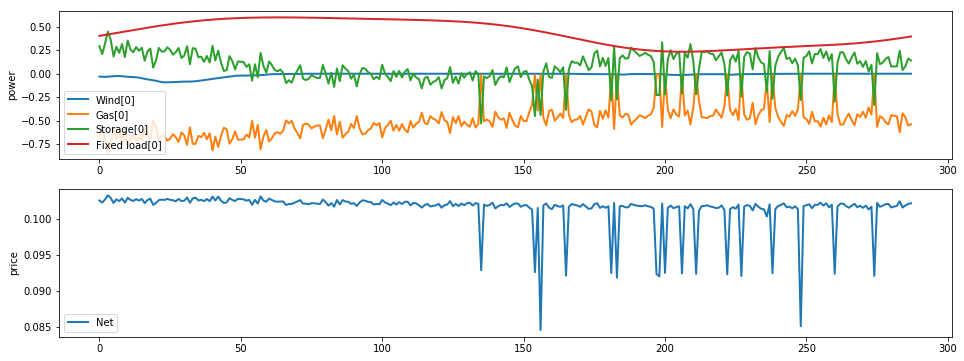

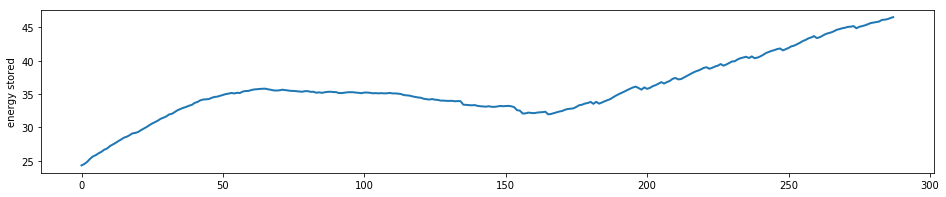

In [9]:
# plot the results
robust_MPC_results.plot(figsize=(16,6))

# plot energy stored in battery
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
ax.plot(energy_stored)
ax.set_ylabel("energy stored")

In [ ]:
# # plot the results
# results.plot()

# # plot energy stored in battery
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
# ax.plot(energy_stored)
# ax.set_ylabel("energy stored")

In [ ]:
plt.plot(xrange(N), p_wind[initial_time:initial_time+N]/16, label="p_wind_max")
plt.plot(-robust_MPC_results.power[(wind_gen, 0)], label="p_wind")
plt.legend()